

## Deep learning: MLP Kernels
 


In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import timeit
%matplotlib inline



In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

We scale the data to be in $[-1,1]$.

In [3]:
x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1

The size of each data points is $28 \times 28$. While this format will be useful when using CNNs, we will vectorize the datapoints for visualization and preliminary questions.

In [4]:
nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

### 3: Multi Layer Perceptron

Multi Layer Perceptron (MLP) is a fully connected deep (more than one hidden layer) network. In this part of the coursework we will implement a 2 hidden layers MLP with Recified Linear Unit (ReLU) activations. We will train the model via ADAM optimizer over a cross-entropy loss function.

First of all, we will convert our label vectors to matrices via one-hot encoding (e.g. $y=2$ would become $[0,0,1,0,0,0,0,0,0,0]$). This can be simply done using commands below:

In [5]:
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

Below, we define a class MLP. It is initialized via:  

+ x_train: The training matrix.
+ y_train: One hot encoding of the corresponding labels.
+ lr: Learning rate used for ADAM optimizer
+ nb_epochs: Number of epochs to use
+ batch_size: The number of data point in each mini-batch
+ output_dir: The directory where model parameters and tensorboard event files will be stored.

We also define the methods: 
* 'create_model' which will desribe a neural network architecture of the form $[784, 1000, 1000, 10]$, each integer representing the number of neurons in a given layer while the length of the vector defines the number of layers accordingly. 
* 'compute_loss' which given the output of 'create_model' will calculate the cross-entropy loss of the mini-batches.
* 'train' where we initiate a tensorflow session and perform the training iterations. 
* 'test' where we load our trained model and perform inference on the test set.

##### Task 3.1
- Complete the method 'create_model' in order to implement a network of the shape $[784, 1000, 1000, 10]$, use ReLU as the non linear activation for hidden layers.

   The function 'create_model' to complete defines the class variables: 

   + self.logits $\in \mathbb{R^{10}}$ containing the output __<font color='red'>without activation of the MLP.</font>__
   + self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.

- Using self.logits complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss. 


In [6]:
accuracy = np.zeros(6)

In [7]:
class MLP:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        tf.reset_default_graph()
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
        
            hl_1 = tf.layers.dense(self.im,1000,activation=tf.nn.relu, name='hl_1')
            hl_2 = tf.layers.dense(hl_1,1000,activation=tf.nn.relu, name='hl_2')
            self.logits = tf.layers.dense(hl_2,10,activation=None, name='logits')
            self.preds = tf.nn.softmax(self.logits, name='preds')
        
    def compute_loss(self):
        with tf.variable_scope('loss'):

            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

Now that we defined our model, our loss and its optimizer. we can instantate the MLP class, initiate our variables, and start the tensorflow session:

In [8]:
model = MLP(x_train, y_train, './MLP_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


We can now start training. We loop over the training data points and we feed them to the session in mini-batches form. we repeat this process several times (for several epochs). 

In [9]:
start_time = timeit.default_timer()

# epochs_train = []
# iterations_train = []
# losses_train = []
# accuracies_train = []

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
#         epochs_train.append(epoch)
#         iterations_train.append(i)
#         losses_train.append(loss)
#         accuracies_train.append(acc_train)
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Epoch 0, Iteration 0, loss 2.444, batch accuracy 0.000
Epoch 0, Iteration 1, loss 3.048, batch accuracy 0.400
Epoch 0, Iteration 2, loss 4.476, batch accuracy 0.200
Epoch 0, Iteration 3, loss 3.700, batch accuracy 0.200
Epoch 0, Iteration 4, loss 1.960, batch accuracy 0.400
Epoch 0, Iteration 5, loss 2.173, batch accuracy 0.300
Epoch 0, Iteration 6, loss 1.448, batch accuracy 0.400
Epoch 0, Iteration 7, loss 2.512, batch accuracy 0.200
Epoch 0, Iteration 8, loss 1.540, batch accuracy 0.400
Epoch 0, Iteration 9, loss 2.414, batch accuracy 0.200
Epoch 0, Iteration 10, loss 0.872, batch accuracy 0.800
Epoch 0, Iteration 11, loss 1.586, batch accuracy 0.600
Epoch 0, Iteration 12, loss 2.113, batch accuracy 0.200
Epoch 0, Iteration 13, loss 1.552, batch accuracy 0.300
Epoch 0, Iteration 14, loss 1.053, batch accuracy 0.700
Epoch 0, Iteration 15, loss 2.487, batch accuracy 0.100
Epoch 0, Iteration 16, loss 1.452, batch accuracy 0.600
Epoch 0, Iteration 17, loss 0.902, batch accuracy 0.700
Ep

Epoch 0, Iteration 151, loss 0.590, batch accuracy 0.800
Epoch 0, Iteration 152, loss 0.747, batch accuracy 0.600
Epoch 0, Iteration 153, loss 1.119, batch accuracy 0.700
Epoch 0, Iteration 154, loss 0.538, batch accuracy 0.700
Epoch 0, Iteration 155, loss 0.638, batch accuracy 0.800
Epoch 0, Iteration 156, loss 0.433, batch accuracy 0.900
Epoch 0, Iteration 157, loss 0.420, batch accuracy 0.800
Epoch 0, Iteration 158, loss 0.206, batch accuracy 0.900
Epoch 0, Iteration 159, loss 1.060, batch accuracy 0.700
Epoch 0, Iteration 160, loss 0.851, batch accuracy 0.600
Epoch 0, Iteration 161, loss 0.836, batch accuracy 0.700
Epoch 0, Iteration 162, loss 0.420, batch accuracy 0.900
Epoch 0, Iteration 163, loss 0.784, batch accuracy 0.600
Epoch 0, Iteration 164, loss 0.431, batch accuracy 0.900
Epoch 0, Iteration 165, loss 0.916, batch accuracy 0.600
Epoch 0, Iteration 166, loss 0.553, batch accuracy 0.900
Epoch 0, Iteration 167, loss 0.198, batch accuracy 1.000
Epoch 0, Iteration 168, loss 0.

Epoch 0, Iteration 308, loss 0.387, batch accuracy 0.900
Epoch 0, Iteration 309, loss 0.359, batch accuracy 0.900
Epoch 0, Iteration 310, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 311, loss 0.653, batch accuracy 0.800
Epoch 0, Iteration 312, loss 0.838, batch accuracy 0.700
Epoch 0, Iteration 313, loss 0.426, batch accuracy 0.900
Epoch 0, Iteration 314, loss 0.396, batch accuracy 0.800
Epoch 0, Iteration 315, loss 0.344, batch accuracy 0.900
Epoch 0, Iteration 316, loss 0.507, batch accuracy 0.700
Epoch 0, Iteration 317, loss 0.557, batch accuracy 0.800
Epoch 0, Iteration 318, loss 0.692, batch accuracy 0.800
Epoch 0, Iteration 319, loss 0.805, batch accuracy 0.800
Epoch 0, Iteration 320, loss 0.861, batch accuracy 0.700
Epoch 0, Iteration 321, loss 0.795, batch accuracy 0.900
Epoch 0, Iteration 322, loss 0.422, batch accuracy 0.900
Epoch 0, Iteration 323, loss 0.695, batch accuracy 0.700
Epoch 0, Iteration 324, loss 0.271, batch accuracy 1.000
Epoch 0, Iteration 325, loss 0.

Epoch 0, Iteration 465, loss 0.792, batch accuracy 0.700
Epoch 0, Iteration 466, loss 0.202, batch accuracy 0.900
Epoch 0, Iteration 467, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 468, loss 0.454, batch accuracy 0.700
Epoch 0, Iteration 469, loss 1.295, batch accuracy 0.900
Epoch 0, Iteration 470, loss 0.161, batch accuracy 0.900
Epoch 0, Iteration 471, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 472, loss 0.612, batch accuracy 0.700
Epoch 0, Iteration 473, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 474, loss 0.958, batch accuracy 0.700
Epoch 0, Iteration 475, loss 0.135, batch accuracy 1.000
Epoch 0, Iteration 476, loss 0.462, batch accuracy 0.900
Epoch 0, Iteration 477, loss 0.283, batch accuracy 0.900
Epoch 0, Iteration 478, loss 0.922, batch accuracy 0.700
Epoch 0, Iteration 479, loss 0.292, batch accuracy 0.900
Epoch 0, Iteration 480, loss 0.223, batch accuracy 0.900
Epoch 0, Iteration 481, loss 0.948, batch accuracy 0.800
Epoch 0, Iteration 482, loss 0.

Epoch 0, Iteration 616, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 617, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 618, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 619, loss 0.100, batch accuracy 0.900
Epoch 0, Iteration 620, loss 0.367, batch accuracy 0.800
Epoch 0, Iteration 621, loss 1.257, batch accuracy 0.500
Epoch 0, Iteration 622, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 623, loss 0.488, batch accuracy 0.800
Epoch 0, Iteration 624, loss 0.354, batch accuracy 0.900
Epoch 0, Iteration 625, loss 0.234, batch accuracy 0.900
Epoch 0, Iteration 626, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 627, loss 0.829, batch accuracy 0.600
Epoch 0, Iteration 628, loss 0.301, batch accuracy 0.800
Epoch 0, Iteration 629, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 630, loss 0.567, batch accuracy 0.800
Epoch 0, Iteration 631, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 632, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 633, loss 0.

Epoch 0, Iteration 767, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 768, loss 0.446, batch accuracy 0.900
Epoch 0, Iteration 769, loss 0.199, batch accuracy 0.900
Epoch 0, Iteration 770, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 771, loss 0.382, batch accuracy 0.700
Epoch 0, Iteration 772, loss 0.219, batch accuracy 0.900
Epoch 0, Iteration 773, loss 0.436, batch accuracy 0.900
Epoch 0, Iteration 774, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 775, loss 0.273, batch accuracy 0.900
Epoch 0, Iteration 776, loss 0.485, batch accuracy 0.800
Epoch 0, Iteration 777, loss 0.290, batch accuracy 0.900
Epoch 0, Iteration 778, loss 0.162, batch accuracy 1.000
Epoch 0, Iteration 779, loss 0.197, batch accuracy 0.900
Epoch 0, Iteration 780, loss 0.130, batch accuracy 1.000
Epoch 0, Iteration 781, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 782, loss 1.099, batch accuracy 0.800
Epoch 0, Iteration 783, loss 0.494, batch accuracy 0.800
Epoch 0, Iteration 784, loss 0.

Epoch 0, Iteration 921, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 922, loss 0.357, batch accuracy 0.900
Epoch 0, Iteration 923, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 924, loss 0.209, batch accuracy 0.900
Epoch 0, Iteration 925, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 926, loss 0.811, batch accuracy 0.900
Epoch 0, Iteration 927, loss 0.304, batch accuracy 0.800
Epoch 0, Iteration 928, loss 0.140, batch accuracy 0.900
Epoch 0, Iteration 929, loss 0.612, batch accuracy 0.900
Epoch 0, Iteration 930, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 931, loss 0.809, batch accuracy 0.800
Epoch 0, Iteration 932, loss 0.810, batch accuracy 0.700
Epoch 0, Iteration 933, loss 0.634, batch accuracy 0.900
Epoch 0, Iteration 934, loss 0.732, batch accuracy 0.800
Epoch 0, Iteration 935, loss 0.364, batch accuracy 0.900
Epoch 0, Iteration 936, loss 0.201, batch accuracy 0.900
Epoch 0, Iteration 937, loss 0.476, batch accuracy 0.800
Epoch 0, Iteration 938, loss 0.

Epoch 0, Iteration 1073, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 1074, loss 0.355, batch accuracy 0.900
Epoch 0, Iteration 1075, loss 0.758, batch accuracy 0.800
Epoch 0, Iteration 1076, loss 0.322, batch accuracy 0.900
Epoch 0, Iteration 1077, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 1078, loss 0.251, batch accuracy 0.900
Epoch 0, Iteration 1079, loss 0.424, batch accuracy 0.900
Epoch 0, Iteration 1080, loss 0.181, batch accuracy 1.000
Epoch 0, Iteration 1081, loss 1.064, batch accuracy 0.700
Epoch 0, Iteration 1082, loss 0.258, batch accuracy 1.000
Epoch 0, Iteration 1083, loss 0.507, batch accuracy 0.900
Epoch 0, Iteration 1084, loss 1.010, batch accuracy 0.800
Epoch 0, Iteration 1085, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 1086, loss 0.143, batch accuracy 1.000
Epoch 0, Iteration 1087, loss 0.355, batch accuracy 0.900
Epoch 0, Iteration 1088, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 1089, loss 0.086, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1223, loss 0.127, batch accuracy 0.900
Epoch 0, Iteration 1224, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 1225, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 1226, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 1227, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 1228, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 1229, loss 0.122, batch accuracy 0.900
Epoch 0, Iteration 1230, loss 0.204, batch accuracy 0.800
Epoch 0, Iteration 1231, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 1232, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 1233, loss 0.130, batch accuracy 0.900
Epoch 0, Iteration 1234, loss 0.161, batch accuracy 0.900
Epoch 0, Iteration 1235, loss 0.325, batch accuracy 0.900
Epoch 0, Iteration 1236, loss 0.320, batch accuracy 0.900
Epoch 0, Iteration 1237, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 1238, loss 0.664, batch accuracy 0.800
Epoch 0, Iteration 1239, loss 0.115, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1370, loss 0.409, batch accuracy 0.700
Epoch 0, Iteration 1371, loss 0.113, batch accuracy 1.000
Epoch 0, Iteration 1372, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 1373, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 1374, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 1375, loss 0.628, batch accuracy 0.900
Epoch 0, Iteration 1376, loss 0.181, batch accuracy 0.900
Epoch 0, Iteration 1377, loss 0.179, batch accuracy 1.000
Epoch 0, Iteration 1378, loss 0.130, batch accuracy 0.900
Epoch 0, Iteration 1379, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 1380, loss 0.476, batch accuracy 0.800
Epoch 0, Iteration 1381, loss 0.385, batch accuracy 0.900
Epoch 0, Iteration 1382, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 1383, loss 0.577, batch accuracy 0.800
Epoch 0, Iteration 1384, loss 0.330, batch accuracy 0.900
Epoch 0, Iteration 1385, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 1386, loss 0.392, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1524, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 1525, loss 0.568, batch accuracy 0.500
Epoch 0, Iteration 1526, loss 0.183, batch accuracy 0.900
Epoch 0, Iteration 1527, loss 0.313, batch accuracy 0.900
Epoch 0, Iteration 1528, loss 0.621, batch accuracy 0.900
Epoch 0, Iteration 1529, loss 0.119, batch accuracy 1.000
Epoch 0, Iteration 1530, loss 0.223, batch accuracy 0.900
Epoch 0, Iteration 1531, loss 0.248, batch accuracy 0.800
Epoch 0, Iteration 1532, loss 0.149, batch accuracy 0.900
Epoch 0, Iteration 1533, loss 0.160, batch accuracy 0.900
Epoch 0, Iteration 1534, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 1535, loss 0.135, batch accuracy 0.900
Epoch 0, Iteration 1536, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 1537, loss 0.361, batch accuracy 0.900
Epoch 0, Iteration 1538, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 1539, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 1540, loss 0.007, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1678, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 1679, loss 0.361, batch accuracy 0.900
Epoch 0, Iteration 1680, loss 0.535, batch accuracy 0.800
Epoch 0, Iteration 1681, loss 0.344, batch accuracy 0.900
Epoch 0, Iteration 1682, loss 0.732, batch accuracy 0.700
Epoch 0, Iteration 1683, loss 0.181, batch accuracy 0.900
Epoch 0, Iteration 1684, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 1685, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 1686, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 1687, loss 0.175, batch accuracy 0.900
Epoch 0, Iteration 1688, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 1689, loss 0.339, batch accuracy 0.900
Epoch 0, Iteration 1690, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 1691, loss 0.494, batch accuracy 0.800
Epoch 0, Iteration 1692, loss 0.186, batch accuracy 1.000
Epoch 0, Iteration 1693, loss 0.267, batch accuracy 0.800
Epoch 0, Iteration 1694, loss 0.016, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1822, loss 0.104, batch accuracy 1.000
Epoch 0, Iteration 1823, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 1824, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 1825, loss 1.042, batch accuracy 0.800
Epoch 0, Iteration 1826, loss 0.128, batch accuracy 1.000
Epoch 0, Iteration 1827, loss 0.123, batch accuracy 0.900
Epoch 0, Iteration 1828, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 1829, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 1830, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 1831, loss 0.235, batch accuracy 0.900
Epoch 0, Iteration 1832, loss 0.361, batch accuracy 0.900
Epoch 0, Iteration 1833, loss 0.305, batch accuracy 0.900
Epoch 0, Iteration 1834, loss 0.098, batch accuracy 1.000
Epoch 0, Iteration 1835, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 1836, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 1837, loss 0.996, batch accuracy 0.800
Epoch 0, Iteration 1838, loss 0.299, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1977, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 1978, loss 0.291, batch accuracy 1.000
Epoch 0, Iteration 1979, loss 0.349, batch accuracy 0.900
Epoch 0, Iteration 1980, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 1981, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 1982, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 1983, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 1984, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 1985, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 1986, loss 0.379, batch accuracy 0.900
Epoch 0, Iteration 1987, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 1988, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 1989, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 1990, loss 0.123, batch accuracy 1.000
Epoch 0, Iteration 1991, loss 1.086, batch accuracy 0.900
Epoch 0, Iteration 1992, loss 0.342, batch accuracy 0.900
Epoch 0, Iteration 1993, loss 0.209, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2131, loss 0.478, batch accuracy 0.900
Epoch 0, Iteration 2132, loss 0.445, batch accuracy 0.900
Epoch 0, Iteration 2133, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 2134, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 2135, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 2136, loss 0.310, batch accuracy 0.900
Epoch 0, Iteration 2137, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 2138, loss 0.518, batch accuracy 0.900
Epoch 0, Iteration 2139, loss 0.427, batch accuracy 0.900
Epoch 0, Iteration 2140, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 2141, loss 0.304, batch accuracy 0.900
Epoch 0, Iteration 2142, loss 0.136, batch accuracy 0.900
Epoch 0, Iteration 2143, loss 0.143, batch accuracy 0.900
Epoch 0, Iteration 2144, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 2145, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 2146, loss 0.377, batch accuracy 0.900
Epoch 0, Iteration 2147, loss 0.140, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2286, loss 0.208, batch accuracy 0.900
Epoch 0, Iteration 2287, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 2288, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 2289, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 2290, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 2291, loss 0.185, batch accuracy 0.900
Epoch 0, Iteration 2292, loss 0.410, batch accuracy 0.700
Epoch 0, Iteration 2293, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 2294, loss 0.263, batch accuracy 0.900
Epoch 0, Iteration 2295, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 2296, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 2297, loss 0.110, batch accuracy 0.900
Epoch 0, Iteration 2298, loss 0.434, batch accuracy 0.800
Epoch 0, Iteration 2299, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 2300, loss 0.157, batch accuracy 0.900
Epoch 0, Iteration 2301, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 2302, loss 0.444, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2442, loss 0.588, batch accuracy 0.800
Epoch 0, Iteration 2443, loss 0.685, batch accuracy 0.900
Epoch 0, Iteration 2444, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 2445, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 2446, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 2447, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 2448, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 2449, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 2450, loss 0.238, batch accuracy 0.900
Epoch 0, Iteration 2451, loss 0.101, batch accuracy 0.900
Epoch 0, Iteration 2452, loss 0.342, batch accuracy 0.900
Epoch 0, Iteration 2453, loss 0.204, batch accuracy 0.900
Epoch 0, Iteration 2454, loss 0.748, batch accuracy 0.900
Epoch 0, Iteration 2455, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 2456, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 2457, loss 0.462, batch accuracy 0.800
Epoch 0, Iteration 2458, loss 0.058, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2590, loss 1.035, batch accuracy 0.900
Epoch 0, Iteration 2591, loss 0.272, batch accuracy 0.900
Epoch 0, Iteration 2592, loss 0.329, batch accuracy 0.900
Epoch 0, Iteration 2593, loss 0.366, batch accuracy 0.800
Epoch 0, Iteration 2594, loss 0.529, batch accuracy 0.800
Epoch 0, Iteration 2595, loss 0.577, batch accuracy 0.800
Epoch 0, Iteration 2596, loss 0.217, batch accuracy 0.900
Epoch 0, Iteration 2597, loss 0.317, batch accuracy 0.900
Epoch 0, Iteration 2598, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 2599, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 2600, loss 0.186, batch accuracy 0.900
Epoch 0, Iteration 2601, loss 0.136, batch accuracy 1.000
Epoch 0, Iteration 2602, loss 1.206, batch accuracy 0.700
Epoch 0, Iteration 2603, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 2604, loss 0.429, batch accuracy 0.900
Epoch 0, Iteration 2605, loss 0.178, batch accuracy 0.900
Epoch 0, Iteration 2606, loss 0.231, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2737, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 2738, loss 0.453, batch accuracy 0.900
Epoch 0, Iteration 2739, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 2740, loss 0.471, batch accuracy 0.900
Epoch 0, Iteration 2741, loss 0.348, batch accuracy 0.800
Epoch 0, Iteration 2742, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 2743, loss 0.591, batch accuracy 0.800
Epoch 0, Iteration 2744, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 2745, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 2746, loss 0.081, batch accuracy 1.000
Epoch 0, Iteration 2747, loss 1.013, batch accuracy 0.700
Epoch 0, Iteration 2748, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 2749, loss 0.284, batch accuracy 0.900
Epoch 0, Iteration 2750, loss 0.489, batch accuracy 0.900
Epoch 0, Iteration 2751, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 2752, loss 0.204, batch accuracy 1.000
Epoch 0, Iteration 2753, loss 0.026, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2889, loss 0.381, batch accuracy 0.900
Epoch 0, Iteration 2890, loss 1.316, batch accuracy 0.800
Epoch 0, Iteration 2891, loss 0.119, batch accuracy 0.900
Epoch 0, Iteration 2892, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 2893, loss 0.164, batch accuracy 0.900
Epoch 0, Iteration 2894, loss 0.795, batch accuracy 0.900
Epoch 0, Iteration 2895, loss 0.162, batch accuracy 1.000
Epoch 0, Iteration 2896, loss 0.081, batch accuracy 1.000
Epoch 0, Iteration 2897, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 2898, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 2899, loss 0.275, batch accuracy 0.900
Epoch 0, Iteration 2900, loss 0.280, batch accuracy 0.900
Epoch 0, Iteration 2901, loss 0.515, batch accuracy 0.900
Epoch 0, Iteration 2902, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 2903, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 2904, loss 0.679, batch accuracy 0.800
Epoch 0, Iteration 2905, loss 0.008, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3041, loss 0.391, batch accuracy 0.900
Epoch 0, Iteration 3042, loss 0.120, batch accuracy 0.900
Epoch 0, Iteration 3043, loss 0.363, batch accuracy 0.900
Epoch 0, Iteration 3044, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 3045, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 3046, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 3047, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 3048, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 3049, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 3050, loss 0.155, batch accuracy 1.000
Epoch 0, Iteration 3051, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 3052, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 3053, loss 0.101, batch accuracy 0.900
Epoch 0, Iteration 3054, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 3055, loss 0.134, batch accuracy 0.900
Epoch 0, Iteration 3056, loss 1.060, batch accuracy 0.900
Epoch 0, Iteration 3057, loss 0.178, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3184, loss 0.327, batch accuracy 0.900
Epoch 0, Iteration 3185, loss 0.492, batch accuracy 0.800
Epoch 0, Iteration 3186, loss 0.117, batch accuracy 0.900
Epoch 0, Iteration 3187, loss 0.239, batch accuracy 0.900
Epoch 0, Iteration 3188, loss 0.349, batch accuracy 0.900
Epoch 0, Iteration 3189, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 3190, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 3191, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 3192, loss 0.218, batch accuracy 1.000
Epoch 0, Iteration 3193, loss 0.948, batch accuracy 0.800
Epoch 0, Iteration 3194, loss 0.219, batch accuracy 0.900
Epoch 0, Iteration 3195, loss 0.491, batch accuracy 0.900
Epoch 0, Iteration 3196, loss 1.025, batch accuracy 0.700
Epoch 0, Iteration 3197, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 3198, loss 0.116, batch accuracy 1.000
Epoch 0, Iteration 3199, loss 0.099, batch accuracy 0.900
Epoch 0, Iteration 3200, loss 0.284, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3339, loss 0.898, batch accuracy 0.800
Epoch 0, Iteration 3340, loss 0.603, batch accuracy 0.800
Epoch 0, Iteration 3341, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 3342, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 3343, loss 0.308, batch accuracy 0.800
Epoch 0, Iteration 3344, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 3345, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 3346, loss 0.491, batch accuracy 0.800
Epoch 0, Iteration 3347, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 3348, loss 0.383, batch accuracy 0.900
Epoch 0, Iteration 3349, loss 0.208, batch accuracy 0.900
Epoch 0, Iteration 3350, loss 0.299, batch accuracy 0.900
Epoch 0, Iteration 3351, loss 0.244, batch accuracy 0.900
Epoch 0, Iteration 3352, loss 0.251, batch accuracy 1.000
Epoch 0, Iteration 3353, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3354, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 3355, loss 0.021, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3495, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 3496, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 3497, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 3498, loss 0.465, batch accuracy 0.900
Epoch 0, Iteration 3499, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 3500, loss 0.134, batch accuracy 0.900
Epoch 0, Iteration 3501, loss 0.103, batch accuracy 1.000
Epoch 0, Iteration 3502, loss 0.344, batch accuracy 0.800
Epoch 0, Iteration 3503, loss 0.187, batch accuracy 0.900
Epoch 0, Iteration 3504, loss 0.110, batch accuracy 0.900
Epoch 0, Iteration 3505, loss 0.228, batch accuracy 0.900
Epoch 0, Iteration 3506, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 3507, loss 0.136, batch accuracy 0.900
Epoch 0, Iteration 3508, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 3509, loss 0.698, batch accuracy 0.700
Epoch 0, Iteration 3510, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 3511, loss 0.054, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3647, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 3648, loss 0.211, batch accuracy 1.000
Epoch 0, Iteration 3649, loss 0.159, batch accuracy 0.900
Epoch 0, Iteration 3650, loss 0.095, batch accuracy 0.900
Epoch 0, Iteration 3651, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 3652, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 3653, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 3654, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 3655, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 3656, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 3657, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 3658, loss 0.130, batch accuracy 0.900
Epoch 0, Iteration 3659, loss 0.143, batch accuracy 0.900
Epoch 0, Iteration 3660, loss 0.527, batch accuracy 0.900
Epoch 0, Iteration 3661, loss 0.510, batch accuracy 0.800
Epoch 0, Iteration 3662, loss 0.134, batch accuracy 0.900
Epoch 0, Iteration 3663, loss 0.079, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3798, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 3799, loss 0.507, batch accuracy 0.900
Epoch 0, Iteration 3800, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3801, loss 0.116, batch accuracy 1.000
Epoch 0, Iteration 3802, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 3803, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 3804, loss 0.305, batch accuracy 0.900
Epoch 0, Iteration 3805, loss 0.950, batch accuracy 0.800
Epoch 0, Iteration 3806, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 3807, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 3808, loss 0.141, batch accuracy 0.900
Epoch 0, Iteration 3809, loss 0.325, batch accuracy 0.900
Epoch 0, Iteration 3810, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 3811, loss 0.309, batch accuracy 0.900
Epoch 0, Iteration 3812, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 3813, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 3814, loss 0.017, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3950, loss 0.650, batch accuracy 0.900
Epoch 0, Iteration 3951, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 3952, loss 0.314, batch accuracy 0.800
Epoch 0, Iteration 3953, loss 0.535, batch accuracy 0.800
Epoch 0, Iteration 3954, loss 0.228, batch accuracy 1.000
Epoch 0, Iteration 3955, loss 0.515, batch accuracy 0.900
Epoch 0, Iteration 3956, loss 0.196, batch accuracy 0.900
Epoch 0, Iteration 3957, loss 0.138, batch accuracy 0.900
Epoch 0, Iteration 3958, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 3959, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 3960, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 3961, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 3962, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 3963, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 3964, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 3965, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 3966, loss 0.050, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4101, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 4102, loss 0.194, batch accuracy 0.900
Epoch 0, Iteration 4103, loss 0.129, batch accuracy 0.900
Epoch 0, Iteration 4104, loss 0.142, batch accuracy 0.900
Epoch 0, Iteration 4105, loss 0.263, batch accuracy 0.900
Epoch 0, Iteration 4106, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4107, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 4108, loss 0.752, batch accuracy 0.700
Epoch 0, Iteration 4109, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 4110, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 4111, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 4112, loss 0.402, batch accuracy 0.800
Epoch 0, Iteration 4113, loss 0.611, batch accuracy 0.900
Epoch 0, Iteration 4114, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 4115, loss 0.241, batch accuracy 0.900
Epoch 0, Iteration 4116, loss 1.019, batch accuracy 0.700
Epoch 0, Iteration 4117, loss 0.198, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4243, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 4244, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 4245, loss 0.603, batch accuracy 0.800
Epoch 0, Iteration 4246, loss 0.354, batch accuracy 0.900
Epoch 0, Iteration 4247, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 4248, loss 1.158, batch accuracy 0.700
Epoch 0, Iteration 4249, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 4250, loss 0.527, batch accuracy 0.900
Epoch 0, Iteration 4251, loss 0.192, batch accuracy 1.000
Epoch 0, Iteration 4252, loss 0.301, batch accuracy 0.800
Epoch 0, Iteration 4253, loss 0.243, batch accuracy 0.900
Epoch 0, Iteration 4254, loss 0.205, batch accuracy 0.900
Epoch 0, Iteration 4255, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 4256, loss 0.233, batch accuracy 0.900
Epoch 0, Iteration 4257, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4258, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 4259, loss 0.062, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4392, loss 0.317, batch accuracy 0.900
Epoch 0, Iteration 4393, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 4394, loss 0.752, batch accuracy 0.800
Epoch 0, Iteration 4395, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 4396, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 4397, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 4398, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 4399, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 4400, loss 0.418, batch accuracy 0.900
Epoch 0, Iteration 4401, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 4402, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 4403, loss 0.251, batch accuracy 0.900
Epoch 0, Iteration 4404, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 4405, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 4406, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 4407, loss 0.213, batch accuracy 0.900
Epoch 0, Iteration 4408, loss 0.390, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4540, loss 0.275, batch accuracy 0.900
Epoch 0, Iteration 4541, loss 0.129, batch accuracy 0.900
Epoch 0, Iteration 4542, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 4543, loss 0.331, batch accuracy 0.900
Epoch 0, Iteration 4544, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 4545, loss 0.992, batch accuracy 0.900
Epoch 0, Iteration 4546, loss 0.610, batch accuracy 0.900
Epoch 0, Iteration 4547, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 4548, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 4549, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 4550, loss 1.731, batch accuracy 0.700
Epoch 0, Iteration 4551, loss 0.804, batch accuracy 0.800
Epoch 0, Iteration 4552, loss 0.485, batch accuracy 0.800
Epoch 0, Iteration 4553, loss 0.079, batch accuracy 1.000
Epoch 0, Iteration 4554, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 4555, loss 0.418, batch accuracy 0.900
Epoch 0, Iteration 4556, loss 0.038, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4684, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4685, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4686, loss 0.736, batch accuracy 0.900
Epoch 0, Iteration 4687, loss 0.109, batch accuracy 1.000
Epoch 0, Iteration 4688, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 4689, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 4690, loss 0.366, batch accuracy 0.900
Epoch 0, Iteration 4691, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 4692, loss 0.122, batch accuracy 1.000
Epoch 0, Iteration 4693, loss 0.271, batch accuracy 0.900
Epoch 0, Iteration 4694, loss 0.146, batch accuracy 1.000
Epoch 0, Iteration 4695, loss 0.297, batch accuracy 0.900
Epoch 0, Iteration 4696, loss 0.207, batch accuracy 0.900
Epoch 0, Iteration 4697, loss 0.816, batch accuracy 0.900
Epoch 0, Iteration 4698, loss 0.216, batch accuracy 0.900
Epoch 0, Iteration 4699, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 4700, loss 1.069, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4835, loss 0.619, batch accuracy 0.900
Epoch 0, Iteration 4836, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 4837, loss 0.110, batch accuracy 1.000
Epoch 0, Iteration 4838, loss 0.129, batch accuracy 1.000
Epoch 0, Iteration 4839, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 4840, loss 0.185, batch accuracy 0.900
Epoch 0, Iteration 4841, loss 0.201, batch accuracy 0.900
Epoch 0, Iteration 4842, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 4843, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4844, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 4845, loss 0.087, batch accuracy 0.900
Epoch 0, Iteration 4846, loss 0.104, batch accuracy 1.000
Epoch 0, Iteration 4847, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 4848, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 4849, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 4850, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 4851, loss 0.013, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4985, loss 0.084, batch accuracy 0.900
Epoch 0, Iteration 4986, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 4987, loss 0.615, batch accuracy 0.900
Epoch 0, Iteration 4988, loss 0.535, batch accuracy 0.800
Epoch 0, Iteration 4989, loss 0.206, batch accuracy 0.900
Epoch 0, Iteration 4990, loss 0.225, batch accuracy 0.800
Epoch 0, Iteration 4991, loss 0.670, batch accuracy 0.700
Epoch 0, Iteration 4992, loss 0.506, batch accuracy 0.800
Epoch 0, Iteration 4993, loss 0.504, batch accuracy 0.900
Epoch 0, Iteration 4994, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 4995, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 4996, loss 0.136, batch accuracy 0.900
Epoch 0, Iteration 4997, loss 0.252, batch accuracy 0.900
Epoch 0, Iteration 4998, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 4999, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 5000, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5001, loss 0.216, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5128, loss 0.243, batch accuracy 0.900
Epoch 0, Iteration 5129, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 5130, loss 0.304, batch accuracy 0.900
Epoch 0, Iteration 5131, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5132, loss 0.367, batch accuracy 0.800
Epoch 0, Iteration 5133, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 5134, loss 0.265, batch accuracy 0.900
Epoch 0, Iteration 5135, loss 0.211, batch accuracy 0.900
Epoch 0, Iteration 5136, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 5137, loss 0.171, batch accuracy 1.000
Epoch 0, Iteration 5138, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5139, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 5140, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 5141, loss 0.237, batch accuracy 0.900
Epoch 0, Iteration 5142, loss 0.258, batch accuracy 0.800
Epoch 0, Iteration 5143, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 5144, loss 0.094, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5277, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 5278, loss 0.308, batch accuracy 0.800
Epoch 0, Iteration 5279, loss 0.837, batch accuracy 0.800
Epoch 0, Iteration 5280, loss 0.213, batch accuracy 0.900
Epoch 0, Iteration 5281, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 5282, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 5283, loss 0.218, batch accuracy 0.900
Epoch 0, Iteration 5284, loss 0.346, batch accuracy 0.800
Epoch 0, Iteration 5285, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5286, loss 0.416, batch accuracy 0.900
Epoch 0, Iteration 5287, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5288, loss 0.253, batch accuracy 0.900
Epoch 0, Iteration 5289, loss 0.344, batch accuracy 0.900
Epoch 0, Iteration 5290, loss 0.281, batch accuracy 0.900
Epoch 0, Iteration 5291, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 5292, loss 1.061, batch accuracy 0.800
Epoch 0, Iteration 5293, loss 0.201, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5429, loss 0.651, batch accuracy 0.800
Epoch 0, Iteration 5430, loss 0.636, batch accuracy 0.900
Epoch 0, Iteration 5431, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5432, loss 0.270, batch accuracy 0.900
Epoch 0, Iteration 5433, loss 0.738, batch accuracy 0.900
Epoch 0, Iteration 5434, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5435, loss 0.135, batch accuracy 0.900
Epoch 0, Iteration 5436, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 5437, loss 0.171, batch accuracy 0.900
Epoch 0, Iteration 5438, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 5439, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 5440, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 5441, loss 0.321, batch accuracy 0.900
Epoch 0, Iteration 5442, loss 0.515, batch accuracy 0.900
Epoch 0, Iteration 5443, loss 0.794, batch accuracy 0.800
Epoch 0, Iteration 5444, loss 0.432, batch accuracy 0.900
Epoch 0, Iteration 5445, loss 0.127, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5583, loss 0.163, batch accuracy 0.900
Epoch 0, Iteration 5584, loss 0.134, batch accuracy 1.000
Epoch 0, Iteration 5585, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 5586, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5587, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5588, loss 0.374, batch accuracy 0.900
Epoch 0, Iteration 5589, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5590, loss 0.374, batch accuracy 0.900
Epoch 0, Iteration 5591, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 5592, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5593, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 5594, loss 0.131, batch accuracy 0.900
Epoch 0, Iteration 5595, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5596, loss 0.210, batch accuracy 0.900
Epoch 0, Iteration 5597, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 5598, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 5599, loss 0.137, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5738, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 5739, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5740, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 5741, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 5742, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 5743, loss 0.276, batch accuracy 0.900
Epoch 0, Iteration 5744, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 5745, loss 0.181, batch accuracy 0.900
Epoch 0, Iteration 5746, loss 0.159, batch accuracy 0.900
Epoch 0, Iteration 5747, loss 0.261, batch accuracy 0.900
Epoch 0, Iteration 5748, loss 0.104, batch accuracy 1.000
Epoch 0, Iteration 5749, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 5750, loss 0.134, batch accuracy 0.900
Epoch 0, Iteration 5751, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 5752, loss 0.177, batch accuracy 0.900
Epoch 0, Iteration 5753, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5754, loss 0.005, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5888, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 5889, loss 0.657, batch accuracy 0.800
Epoch 0, Iteration 5890, loss 0.101, batch accuracy 0.900
Epoch 0, Iteration 5891, loss 0.745, batch accuracy 0.700
Epoch 0, Iteration 5892, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 5893, loss 0.675, batch accuracy 0.900
Epoch 0, Iteration 5894, loss 0.168, batch accuracy 0.900
Epoch 0, Iteration 5895, loss 0.294, batch accuracy 0.900
Epoch 0, Iteration 5896, loss 0.185, batch accuracy 0.900
Epoch 0, Iteration 5897, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 5898, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 5899, loss 0.235, batch accuracy 0.900
Epoch 0, Iteration 5900, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 5901, loss 0.142, batch accuracy 0.900
Epoch 0, Iteration 5902, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 5903, loss 0.211, batch accuracy 0.900
Epoch 0, Iteration 5904, loss 0.023, batch accuracy 1.000
Epoch 0, Itera

Epoch 1, Iteration 31, loss 1.214, batch accuracy 0.600
Epoch 1, Iteration 32, loss 0.255, batch accuracy 0.900
Epoch 1, Iteration 33, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 34, loss 0.273, batch accuracy 0.900
Epoch 1, Iteration 35, loss 0.281, batch accuracy 0.900
Epoch 1, Iteration 36, loss 0.985, batch accuracy 0.900
Epoch 1, Iteration 37, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 38, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 39, loss 0.200, batch accuracy 0.900
Epoch 1, Iteration 40, loss 0.137, batch accuracy 0.900
Epoch 1, Iteration 41, loss 0.138, batch accuracy 0.900
Epoch 1, Iteration 42, loss 0.093, batch accuracy 0.900
Epoch 1, Iteration 43, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 44, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 45, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 46, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 47, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 48, loss 0.023, batch accurac

Epoch 1, Iteration 184, loss 0.823, batch accuracy 0.800
Epoch 1, Iteration 185, loss 1.162, batch accuracy 0.800
Epoch 1, Iteration 186, loss 0.864, batch accuracy 0.900
Epoch 1, Iteration 187, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 188, loss 0.111, batch accuracy 0.900
Epoch 1, Iteration 189, loss 0.318, batch accuracy 0.800
Epoch 1, Iteration 190, loss 0.293, batch accuracy 0.900
Epoch 1, Iteration 191, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 192, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 193, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 194, loss 0.666, batch accuracy 0.800
Epoch 1, Iteration 195, loss 0.234, batch accuracy 0.900
Epoch 1, Iteration 196, loss 0.789, batch accuracy 0.900
Epoch 1, Iteration 197, loss 0.178, batch accuracy 0.900
Epoch 1, Iteration 198, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 199, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 200, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 201, loss 0.

Epoch 1, Iteration 338, loss 0.101, batch accuracy 0.900
Epoch 1, Iteration 339, loss 0.170, batch accuracy 0.900
Epoch 1, Iteration 340, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 341, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 342, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 343, loss 0.365, batch accuracy 0.900
Epoch 1, Iteration 344, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 345, loss 0.108, batch accuracy 0.900
Epoch 1, Iteration 346, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 347, loss 0.233, batch accuracy 0.900
Epoch 1, Iteration 348, loss 0.131, batch accuracy 0.900
Epoch 1, Iteration 349, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 350, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 351, loss 0.300, batch accuracy 0.900
Epoch 1, Iteration 352, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 353, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 354, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 355, loss 0.

Epoch 1, Iteration 492, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 493, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 494, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 495, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 496, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 497, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 498, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 499, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 500, loss 0.188, batch accuracy 0.900
Epoch 1, Iteration 501, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 502, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 503, loss 0.260, batch accuracy 0.900
Epoch 1, Iteration 504, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 505, loss 0.206, batch accuracy 0.900
Epoch 1, Iteration 506, loss 0.086, batch accuracy 0.900
Epoch 1, Iteration 507, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 508, loss 0.260, batch accuracy 0.900
Epoch 1, Iteration 509, loss 0.

Epoch 1, Iteration 644, loss 0.088, batch accuracy 0.900
Epoch 1, Iteration 645, loss 0.235, batch accuracy 0.900
Epoch 1, Iteration 646, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 647, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 648, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 649, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 650, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 651, loss 0.487, batch accuracy 0.900
Epoch 1, Iteration 652, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 653, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 654, loss 0.441, batch accuracy 0.800
Epoch 1, Iteration 655, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 656, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 657, loss 0.319, batch accuracy 0.900
Epoch 1, Iteration 658, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 659, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 660, loss 0.334, batch accuracy 0.900
Epoch 1, Iteration 661, loss 0.

Epoch 1, Iteration 799, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 800, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 801, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 802, loss 0.162, batch accuracy 0.900
Epoch 1, Iteration 803, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 804, loss 0.196, batch accuracy 0.900
Epoch 1, Iteration 805, loss 0.399, batch accuracy 0.900
Epoch 1, Iteration 806, loss 0.534, batch accuracy 0.900
Epoch 1, Iteration 807, loss 0.468, batch accuracy 0.900
Epoch 1, Iteration 808, loss 0.088, batch accuracy 1.000
Epoch 1, Iteration 809, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 810, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 811, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 812, loss 1.271, batch accuracy 0.800
Epoch 1, Iteration 813, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 814, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 815, loss 0.267, batch accuracy 0.900
Epoch 1, Iteration 816, loss 0.

Epoch 1, Iteration 946, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 947, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 948, loss 0.817, batch accuracy 0.800
Epoch 1, Iteration 949, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 950, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 951, loss 0.375, batch accuracy 0.700
Epoch 1, Iteration 952, loss 0.103, batch accuracy 0.900
Epoch 1, Iteration 953, loss 0.317, batch accuracy 0.900
Epoch 1, Iteration 954, loss 1.103, batch accuracy 0.800
Epoch 1, Iteration 955, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 956, loss 0.210, batch accuracy 0.900
Epoch 1, Iteration 957, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 958, loss 0.310, batch accuracy 0.900
Epoch 1, Iteration 959, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 960, loss 0.122, batch accuracy 1.000
Epoch 1, Iteration 961, loss 0.111, batch accuracy 0.900
Epoch 1, Iteration 962, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 963, loss 0.

Epoch 1, Iteration 1095, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1096, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 1097, loss 0.359, batch accuracy 0.900
Epoch 1, Iteration 1098, loss 0.157, batch accuracy 0.900
Epoch 1, Iteration 1099, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1100, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1101, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1102, loss 0.242, batch accuracy 0.800
Epoch 1, Iteration 1103, loss 0.406, batch accuracy 0.900
Epoch 1, Iteration 1104, loss 0.135, batch accuracy 1.000
Epoch 1, Iteration 1105, loss 0.592, batch accuracy 0.800
Epoch 1, Iteration 1106, loss 0.691, batch accuracy 0.900
Epoch 1, Iteration 1107, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 1108, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 1109, loss 0.147, batch accuracy 0.900
Epoch 1, Iteration 1110, loss 0.839, batch accuracy 0.900
Epoch 1, Iteration 1111, loss 0.021, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1249, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1250, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1251, loss 0.114, batch accuracy 1.000
Epoch 1, Iteration 1252, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 1253, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1254, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1255, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1256, loss 1.502, batch accuracy 0.700
Epoch 1, Iteration 1257, loss 0.972, batch accuracy 0.900
Epoch 1, Iteration 1258, loss 0.231, batch accuracy 0.900
Epoch 1, Iteration 1259, loss 0.506, batch accuracy 0.900
Epoch 1, Iteration 1260, loss 0.368, batch accuracy 0.900
Epoch 1, Iteration 1261, loss 0.301, batch accuracy 0.900
Epoch 1, Iteration 1262, loss 0.226, batch accuracy 0.900
Epoch 1, Iteration 1263, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 1264, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1265, loss 0.214, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1402, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 1403, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1404, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1405, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1406, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1407, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1408, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1409, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 1410, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 1411, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 1412, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 1413, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 1414, loss 0.386, batch accuracy 0.900
Epoch 1, Iteration 1415, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1416, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 1417, loss 0.338, batch accuracy 0.900
Epoch 1, Iteration 1418, loss 1.129, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 1548, loss 0.214, batch accuracy 0.900
Epoch 1, Iteration 1549, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 1550, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1551, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1552, loss 0.293, batch accuracy 0.900
Epoch 1, Iteration 1553, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 1554, loss 0.185, batch accuracy 0.900
Epoch 1, Iteration 1555, loss 0.089, batch accuracy 1.000
Epoch 1, Iteration 1556, loss 0.492, batch accuracy 0.900
Epoch 1, Iteration 1557, loss 0.188, batch accuracy 0.900
Epoch 1, Iteration 1558, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 1559, loss 0.571, batch accuracy 0.800
Epoch 1, Iteration 1560, loss 0.563, batch accuracy 0.900
Epoch 1, Iteration 1561, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 1562, loss 0.180, batch accuracy 0.900
Epoch 1, Iteration 1563, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 1564, loss 0.056, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1702, loss 0.634, batch accuracy 0.900
Epoch 1, Iteration 1703, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 1704, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1705, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 1706, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 1707, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1708, loss 0.368, batch accuracy 0.900
Epoch 1, Iteration 1709, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 1710, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 1711, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1712, loss 0.569, batch accuracy 0.900
Epoch 1, Iteration 1713, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1714, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1715, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 1716, loss 0.154, batch accuracy 0.900
Epoch 1, Iteration 1717, loss 0.174, batch accuracy 0.900
Epoch 1, Iteration 1718, loss 0.594, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1854, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1855, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1856, loss 0.626, batch accuracy 0.800
Epoch 1, Iteration 1857, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 1858, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1859, loss 0.206, batch accuracy 0.900
Epoch 1, Iteration 1860, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1861, loss 0.336, batch accuracy 0.900
Epoch 1, Iteration 1862, loss 0.223, batch accuracy 1.000
Epoch 1, Iteration 1863, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1864, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 1865, loss 0.246, batch accuracy 0.900
Epoch 1, Iteration 1866, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 1867, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 1868, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 1869, loss 0.190, batch accuracy 0.900
Epoch 1, Iteration 1870, loss 0.074, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2006, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 2007, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 2008, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 2009, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 2010, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2011, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2012, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 2013, loss 0.109, batch accuracy 1.000
Epoch 1, Iteration 2014, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 2015, loss 0.238, batch accuracy 0.900
Epoch 1, Iteration 2016, loss 0.350, batch accuracy 0.900
Epoch 1, Iteration 2017, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2018, loss 0.207, batch accuracy 0.900
Epoch 1, Iteration 2019, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 2020, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2021, loss 0.815, batch accuracy 0.900
Epoch 1, Iteration 2022, loss 0.731, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 2150, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 2151, loss 0.181, batch accuracy 0.900
Epoch 1, Iteration 2152, loss 0.296, batch accuracy 0.900
Epoch 1, Iteration 2153, loss 0.334, batch accuracy 0.800
Epoch 1, Iteration 2154, loss 0.234, batch accuracy 0.900
Epoch 1, Iteration 2155, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2156, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 2157, loss 0.179, batch accuracy 0.900
Epoch 1, Iteration 2158, loss 0.115, batch accuracy 0.900
Epoch 1, Iteration 2159, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2160, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 2161, loss 0.298, batch accuracy 0.900
Epoch 1, Iteration 2162, loss 0.099, batch accuracy 1.000
Epoch 1, Iteration 2163, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 2164, loss 0.106, batch accuracy 0.900
Epoch 1, Iteration 2165, loss 0.448, batch accuracy 0.900
Epoch 1, Iteration 2166, loss 0.016, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2294, loss 0.415, batch accuracy 0.800
Epoch 1, Iteration 2295, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 2296, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 2297, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2298, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2299, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 2300, loss 0.500, batch accuracy 0.800
Epoch 1, Iteration 2301, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 2302, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2303, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2304, loss 0.239, batch accuracy 0.900
Epoch 1, Iteration 2305, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 2306, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 2307, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 2308, loss 0.186, batch accuracy 0.900
Epoch 1, Iteration 2309, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 2310, loss 0.016, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2447, loss 0.109, batch accuracy 0.900
Epoch 1, Iteration 2448, loss 0.201, batch accuracy 0.900
Epoch 1, Iteration 2449, loss 0.123, batch accuracy 0.900
Epoch 1, Iteration 2450, loss 0.119, batch accuracy 1.000
Epoch 1, Iteration 2451, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 2452, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2453, loss 0.339, batch accuracy 0.900
Epoch 1, Iteration 2454, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2455, loss 0.360, batch accuracy 0.800
Epoch 1, Iteration 2456, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 2457, loss 0.755, batch accuracy 0.700
Epoch 1, Iteration 2458, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2459, loss 0.324, batch accuracy 0.800
Epoch 1, Iteration 2460, loss 0.638, batch accuracy 0.900
Epoch 1, Iteration 2461, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 2462, loss 0.556, batch accuracy 0.900
Epoch 1, Iteration 2463, loss 0.070, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2596, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 2597, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2598, loss 0.353, batch accuracy 0.800
Epoch 1, Iteration 2599, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 2600, loss 0.321, batch accuracy 0.900
Epoch 1, Iteration 2601, loss 0.137, batch accuracy 0.900
Epoch 1, Iteration 2602, loss 0.189, batch accuracy 0.800
Epoch 1, Iteration 2603, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 2604, loss 0.083, batch accuracy 0.900
Epoch 1, Iteration 2605, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2606, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 2607, loss 0.584, batch accuracy 0.800
Epoch 1, Iteration 2608, loss 0.474, batch accuracy 0.900
Epoch 1, Iteration 2609, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2610, loss 0.227, batch accuracy 0.900
Epoch 1, Iteration 2611, loss 0.368, batch accuracy 0.900
Epoch 1, Iteration 2612, loss 0.073, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2746, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2747, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2748, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2749, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 2750, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 2751, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 2752, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2753, loss 0.103, batch accuracy 0.900
Epoch 1, Iteration 2754, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2755, loss 0.152, batch accuracy 0.900
Epoch 1, Iteration 2756, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2757, loss 0.715, batch accuracy 0.800
Epoch 1, Iteration 2758, loss 0.147, batch accuracy 0.900
Epoch 1, Iteration 2759, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 2760, loss 0.105, batch accuracy 1.000
Epoch 1, Iteration 2761, loss 0.431, batch accuracy 0.800
Epoch 1, Iteration 2762, loss 0.004, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2897, loss 0.188, batch accuracy 0.800
Epoch 1, Iteration 2898, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 2899, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 2900, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2901, loss 0.182, batch accuracy 0.900
Epoch 1, Iteration 2902, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 2903, loss 0.228, batch accuracy 0.900
Epoch 1, Iteration 2904, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 2905, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 2906, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2907, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 2908, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2909, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 2910, loss 0.225, batch accuracy 0.900
Epoch 1, Iteration 2911, loss 0.210, batch accuracy 0.900
Epoch 1, Iteration 2912, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2913, loss 0.048, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3052, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3053, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3054, loss 0.079, batch accuracy 0.900
Epoch 1, Iteration 3055, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 3056, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3057, loss 0.448, batch accuracy 0.900
Epoch 1, Iteration 3058, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 3059, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 3060, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3061, loss 0.127, batch accuracy 0.900
Epoch 1, Iteration 3062, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 3063, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3064, loss 1.980, batch accuracy 0.800
Epoch 1, Iteration 3065, loss 0.178, batch accuracy 0.900
Epoch 1, Iteration 3066, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3067, loss 0.492, batch accuracy 0.900
Epoch 1, Iteration 3068, loss 0.622, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 3194, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 3195, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 3196, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3197, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3198, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 3199, loss 0.095, batch accuracy 0.900
Epoch 1, Iteration 3200, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3201, loss 1.024, batch accuracy 0.900
Epoch 1, Iteration 3202, loss 0.888, batch accuracy 0.700
Epoch 1, Iteration 3203, loss 0.246, batch accuracy 0.900
Epoch 1, Iteration 3204, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3205, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3206, loss 0.101, batch accuracy 1.000
Epoch 1, Iteration 3207, loss 0.254, batch accuracy 0.900
Epoch 1, Iteration 3208, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3209, loss 0.127, batch accuracy 0.900
Epoch 1, Iteration 3210, loss 0.110, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3342, loss 0.134, batch accuracy 1.000
Epoch 1, Iteration 3343, loss 0.088, batch accuracy 1.000
Epoch 1, Iteration 3344, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 3345, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3346, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3347, loss 0.169, batch accuracy 0.900
Epoch 1, Iteration 3348, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 3349, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 3350, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 3351, loss 0.298, batch accuracy 0.900
Epoch 1, Iteration 3352, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3353, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3354, loss 1.167, batch accuracy 0.800
Epoch 1, Iteration 3355, loss 0.320, batch accuracy 0.800
Epoch 1, Iteration 3356, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 3357, loss 0.453, batch accuracy 0.800
Epoch 1, Iteration 3358, loss 0.006, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3489, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3490, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3491, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 3492, loss 0.293, batch accuracy 0.900
Epoch 1, Iteration 3493, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 3494, loss 0.420, batch accuracy 0.900
Epoch 1, Iteration 3495, loss 1.188, batch accuracy 0.800
Epoch 1, Iteration 3496, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3497, loss 1.421, batch accuracy 0.800
Epoch 1, Iteration 3498, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 3499, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 3500, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 3501, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3502, loss 0.352, batch accuracy 0.900
Epoch 1, Iteration 3503, loss 0.171, batch accuracy 0.900
Epoch 1, Iteration 3504, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 3505, loss 0.002, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3632, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 3633, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 3634, loss 0.133, batch accuracy 1.000
Epoch 1, Iteration 3635, loss 0.488, batch accuracy 0.900
Epoch 1, Iteration 3636, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 3637, loss 0.187, batch accuracy 0.900
Epoch 1, Iteration 3638, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3639, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 3640, loss 0.094, batch accuracy 0.900
Epoch 1, Iteration 3641, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3642, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 3643, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 3644, loss 0.207, batch accuracy 0.900
Epoch 1, Iteration 3645, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 3646, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3647, loss 0.144, batch accuracy 0.900
Epoch 1, Iteration 3648, loss 0.018, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3775, loss 0.787, batch accuracy 0.900
Epoch 1, Iteration 3776, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 3777, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 3778, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3779, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 3780, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3781, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 3782, loss 0.092, batch accuracy 0.900
Epoch 1, Iteration 3783, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3784, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3785, loss 0.156, batch accuracy 1.000
Epoch 1, Iteration 3786, loss 0.358, batch accuracy 0.900
Epoch 1, Iteration 3787, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3788, loss 0.465, batch accuracy 0.900
Epoch 1, Iteration 3789, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 3790, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 3791, loss 0.132, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3922, loss 0.134, batch accuracy 0.900
Epoch 1, Iteration 3923, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 3924, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3925, loss 0.232, batch accuracy 0.900
Epoch 1, Iteration 3926, loss 0.369, batch accuracy 0.800
Epoch 1, Iteration 3927, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3928, loss 0.380, batch accuracy 0.800
Epoch 1, Iteration 3929, loss 0.967, batch accuracy 0.800
Epoch 1, Iteration 3930, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 3931, loss 1.364, batch accuracy 0.900
Epoch 1, Iteration 3932, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3933, loss 0.401, batch accuracy 0.900
Epoch 1, Iteration 3934, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 3935, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 3936, loss 0.149, batch accuracy 1.000
Epoch 1, Iteration 3937, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3938, loss 0.558, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4075, loss 0.137, batch accuracy 0.900
Epoch 1, Iteration 4076, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 4077, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 4078, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 4079, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 4080, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 4081, loss 0.832, batch accuracy 0.800
Epoch 1, Iteration 4082, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 4083, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 4084, loss 0.102, batch accuracy 0.900
Epoch 1, Iteration 4085, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4086, loss 0.186, batch accuracy 0.900
Epoch 1, Iteration 4087, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4088, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 4089, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 4090, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4091, loss 0.190, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4228, loss 0.725, batch accuracy 0.800
Epoch 1, Iteration 4229, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 4230, loss 0.332, batch accuracy 0.800
Epoch 1, Iteration 4231, loss 0.272, batch accuracy 0.900
Epoch 1, Iteration 4232, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 4233, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4234, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4235, loss 0.308, batch accuracy 0.900
Epoch 1, Iteration 4236, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 4237, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 4238, loss 0.286, batch accuracy 0.900
Epoch 1, Iteration 4239, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4240, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 4241, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4242, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4243, loss 0.355, batch accuracy 0.800
Epoch 1, Iteration 4244, loss 0.759, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4378, loss 0.285, batch accuracy 0.900
Epoch 1, Iteration 4379, loss 0.187, batch accuracy 0.900
Epoch 1, Iteration 4380, loss 0.096, batch accuracy 0.900
Epoch 1, Iteration 4381, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 4382, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 4383, loss 0.162, batch accuracy 0.900
Epoch 1, Iteration 4384, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4385, loss 0.624, batch accuracy 0.800
Epoch 1, Iteration 4386, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4387, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 4388, loss 0.380, batch accuracy 0.900
Epoch 1, Iteration 4389, loss 0.301, batch accuracy 0.900
Epoch 1, Iteration 4390, loss 0.091, batch accuracy 1.000
Epoch 1, Iteration 4391, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4392, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4393, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4394, loss 0.011, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4530, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4531, loss 0.112, batch accuracy 0.900
Epoch 1, Iteration 4532, loss 0.356, batch accuracy 0.900
Epoch 1, Iteration 4533, loss 0.316, batch accuracy 0.900
Epoch 1, Iteration 4534, loss 0.925, batch accuracy 0.800
Epoch 1, Iteration 4535, loss 0.270, batch accuracy 0.900
Epoch 1, Iteration 4536, loss 0.354, batch accuracy 0.900
Epoch 1, Iteration 4537, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 4538, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4539, loss 0.505, batch accuracy 0.900
Epoch 1, Iteration 4540, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4541, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 4542, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4543, loss 0.190, batch accuracy 0.900
Epoch 1, Iteration 4544, loss 0.548, batch accuracy 0.900
Epoch 1, Iteration 4545, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 4546, loss 0.009, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4683, loss 0.149, batch accuracy 0.900
Epoch 1, Iteration 4684, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 4685, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 4686, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4687, loss 0.115, batch accuracy 1.000
Epoch 1, Iteration 4688, loss 0.136, batch accuracy 0.900
Epoch 1, Iteration 4689, loss 0.304, batch accuracy 0.900
Epoch 1, Iteration 4690, loss 0.407, batch accuracy 0.900
Epoch 1, Iteration 4691, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4692, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4693, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4694, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4695, loss 0.383, batch accuracy 0.900
Epoch 1, Iteration 4696, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 4697, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 4698, loss 0.233, batch accuracy 0.900
Epoch 1, Iteration 4699, loss 0.056, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4836, loss 0.205, batch accuracy 0.900
Epoch 1, Iteration 4837, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 4838, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4839, loss 0.103, batch accuracy 0.900
Epoch 1, Iteration 4840, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 4841, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4842, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4843, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 4844, loss 0.370, batch accuracy 0.900
Epoch 1, Iteration 4845, loss 0.245, batch accuracy 0.900
Epoch 1, Iteration 4846, loss 0.203, batch accuracy 0.900
Epoch 1, Iteration 4847, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4848, loss 0.135, batch accuracy 0.900
Epoch 1, Iteration 4849, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 4850, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 4851, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 4852, loss 0.054, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4988, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 4989, loss 0.621, batch accuracy 0.900
Epoch 1, Iteration 4990, loss 0.199, batch accuracy 0.900
Epoch 1, Iteration 4991, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 4992, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4993, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 4994, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 4995, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 4996, loss 0.317, batch accuracy 0.900
Epoch 1, Iteration 4997, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 4998, loss 0.356, batch accuracy 0.900
Epoch 1, Iteration 4999, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 5000, loss 0.111, batch accuracy 1.000
Epoch 1, Iteration 5001, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 5002, loss 0.360, batch accuracy 0.900
Epoch 1, Iteration 5003, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 5004, loss 0.273, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5143, loss 0.419, batch accuracy 0.800
Epoch 1, Iteration 5144, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5145, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5146, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 5147, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5148, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 5149, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5150, loss 0.605, batch accuracy 0.800
Epoch 1, Iteration 5151, loss 0.224, batch accuracy 0.900
Epoch 1, Iteration 5152, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5153, loss 0.722, batch accuracy 0.800
Epoch 1, Iteration 5154, loss 0.159, batch accuracy 0.900
Epoch 1, Iteration 5155, loss 0.524, batch accuracy 0.900
Epoch 1, Iteration 5156, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 5157, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 5158, loss 0.583, batch accuracy 0.900
Epoch 1, Iteration 5159, loss 0.042, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5290, loss 0.295, batch accuracy 0.900
Epoch 1, Iteration 5291, loss 0.196, batch accuracy 0.900
Epoch 1, Iteration 5292, loss 0.559, batch accuracy 0.700
Epoch 1, Iteration 5293, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5294, loss 0.153, batch accuracy 0.900
Epoch 1, Iteration 5295, loss 0.281, batch accuracy 0.900
Epoch 1, Iteration 5296, loss 0.822, batch accuracy 0.800
Epoch 1, Iteration 5297, loss 0.291, batch accuracy 0.900
Epoch 1, Iteration 5298, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 5299, loss 0.537, batch accuracy 0.800
Epoch 1, Iteration 5300, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 5301, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5302, loss 0.527, batch accuracy 0.800
Epoch 1, Iteration 5303, loss 0.133, batch accuracy 0.900
Epoch 1, Iteration 5304, loss 0.710, batch accuracy 0.800
Epoch 1, Iteration 5305, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 5306, loss 0.020, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5444, loss 0.175, batch accuracy 0.900
Epoch 1, Iteration 5445, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5446, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5447, loss 0.658, batch accuracy 0.900
Epoch 1, Iteration 5448, loss 0.118, batch accuracy 0.900
Epoch 1, Iteration 5449, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 5450, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5451, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 5452, loss 0.224, batch accuracy 0.900
Epoch 1, Iteration 5453, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 5454, loss 0.697, batch accuracy 0.900
Epoch 1, Iteration 5455, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5456, loss 0.097, batch accuracy 0.900
Epoch 1, Iteration 5457, loss 0.352, batch accuracy 0.900
Epoch 1, Iteration 5458, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 5459, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 5460, loss 0.088, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5594, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 5595, loss 0.091, batch accuracy 1.000
Epoch 1, Iteration 5596, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5597, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 5598, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5599, loss 0.476, batch accuracy 0.900
Epoch 1, Iteration 5600, loss 0.744, batch accuracy 0.900
Epoch 1, Iteration 5601, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 5602, loss 0.170, batch accuracy 0.900
Epoch 1, Iteration 5603, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5604, loss 0.111, batch accuracy 1.000
Epoch 1, Iteration 5605, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5606, loss 0.122, batch accuracy 0.900
Epoch 1, Iteration 5607, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 5608, loss 0.280, batch accuracy 0.900
Epoch 1, Iteration 5609, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 5610, loss 0.007, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5745, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 5746, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5747, loss 0.089, batch accuracy 1.000
Epoch 1, Iteration 5748, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 5749, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 5750, loss 0.237, batch accuracy 0.900
Epoch 1, Iteration 5751, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5752, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 5753, loss 0.401, batch accuracy 0.900
Epoch 1, Iteration 5754, loss 0.719, batch accuracy 0.900
Epoch 1, Iteration 5755, loss 0.303, batch accuracy 0.800
Epoch 1, Iteration 5756, loss 0.669, batch accuracy 0.900
Epoch 1, Iteration 5757, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 5758, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 5759, loss 0.987, batch accuracy 0.900
Epoch 1, Iteration 5760, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5761, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5900, loss 0.261, batch accuracy 0.800
Epoch 1, Iteration 5901, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 5902, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 5903, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5904, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5905, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5906, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 5907, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5908, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 5909, loss 0.455, batch accuracy 0.900
Epoch 1, Iteration 5910, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5911, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5912, loss 0.111, batch accuracy 0.900
Epoch 1, Iteration 5913, loss 0.091, batch accuracy 0.900
Epoch 1, Iteration 5914, loss 0.148, batch accuracy 1.000
Epoch 1, Iteration 5915, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 5916, loss 0.081, batch accuracy 1.000
Epoch 1, Itera

During and after training visualize the training and the created graph via tensorboard. Tensorboard is accessible via the command "tensorboard --logdir=#yourlogdir#". Check out https://www.tensorflow.org/guide/summaries_and_tensorboard for more details.

Similarly we loop over the test dataset and get the test accuracy via:

In [10]:
start_time = timeit.default_timer()

# iterations_test = []
# accuracies_test = []


batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
#     iterations_test.append(i)
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
        
#     y_pred = np.argmax(preds, axis=1)
#     y_real = np.argmax(y_test, axis=1)
#     accuracy_test = np.mean((y_pred==y_real)*1)
#     accuracies_test.append(accuracy_test)
    
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)

print('Test accuracy achieved: %.3f' %acc_test)

accuracy[0] =  acc_test

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Test accuracy achieved: 0.951
Runtime:  2.1923293240000135  seconds



- Include a figure to visualize your training & testing(see below) performances during iterations and discuss your observations in your report.


We now close the tensorflow session:

In [11]:
#sess.close()

##### Task 3.2
Using a similar format as before, discuss how the number of layers affects the classification accuracy. 
- Train four different networks with more hidden layers for example 3,4,5 and 7 hidden layers (choice is yours here to make a good conclusion). Choose an appropriate width i.e. number of neurons per layer so to achieve good accuracy and feasible training time. How many paramters (weights/biases) do these models have? How do they compare to the former MLP you implemented? 
- Compare the classification accuracies of these networks with the previous MLP.


- Plot a graph showing the accuracy vs. depth v.s. complexity (number of paramters) of the all five MLPs with different depths/widths. Additionally report the results in a Table. Discuss the results and provide conclusion. 


#### 3-Hidden Layers MLP

In [12]:
class MLP3:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        tf.reset_default_graph()
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP3', reuse=tf.AUTO_REUSE):

            hl_1 = tf.layers.dense(self.im,1000,activation=tf.nn.relu, name='hl_1')
            hl_2 = tf.layers.dense(hl_1,1000,activation=tf.nn.relu, name='hl_2')
            hl_3 = tf.layers.dense(hl_2,1000,activation=tf.nn.relu, name='hl_3')
            self.logits = tf.layers.dense(hl_3,10,activation=None, name='logits')
            self.preds = tf.nn.softmax(self.logits, name='preds')
        #########################################
    def compute_loss(self):
        with tf.variable_scope('loss'):

            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [13]:
model = MLP3(x_train, y_train, './MLP3_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)


In [14]:
start_time = timeit.default_timer()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Epoch 0, Iteration 0, loss 2.404, batch accuracy 0.100
Epoch 0, Iteration 1, loss 3.268, batch accuracy 0.400
Epoch 0, Iteration 2, loss 5.493, batch accuracy 0.000
Epoch 0, Iteration 3, loss 2.188, batch accuracy 0.300
Epoch 0, Iteration 4, loss 2.903, batch accuracy 0.300
Epoch 0, Iteration 5, loss 2.853, batch accuracy 0.100
Epoch 0, Iteration 6, loss 1.889, batch accuracy 0.500
Epoch 0, Iteration 7, loss 2.367, batch accuracy 0.300
Epoch 0, Iteration 8, loss 2.144, batch accuracy 0.100
Epoch 0, Iteration 9, loss 2.279, batch accuracy 0.100
Epoch 0, Iteration 10, loss 2.142, batch accuracy 0.300
Epoch 0, Iteration 11, loss 2.065, batch accuracy 0.300
Epoch 0, Iteration 12, loss 2.057, batch accuracy 0.100
Epoch 0, Iteration 13, loss 2.296, batch accuracy 0.300
Epoch 0, Iteration 14, loss 1.400, batch accuracy 0.400
Epoch 0, Iteration 15, loss 1.703, batch accuracy 0.400
Epoch 0, Iteration 16, loss 2.168, batch accuracy 0.000
Epoch 0, Iteration 17, loss 1.903, batch accuracy 0.100
Ep

Epoch 0, Iteration 152, loss 1.465, batch accuracy 0.600
Epoch 0, Iteration 153, loss 0.474, batch accuracy 0.900
Epoch 0, Iteration 154, loss 0.401, batch accuracy 0.900
Epoch 0, Iteration 155, loss 0.107, batch accuracy 1.000
Epoch 0, Iteration 156, loss 0.368, batch accuracy 0.900
Epoch 0, Iteration 157, loss 0.771, batch accuracy 0.900
Epoch 0, Iteration 158, loss 1.359, batch accuracy 0.600
Epoch 0, Iteration 159, loss 0.718, batch accuracy 0.700
Epoch 0, Iteration 160, loss 0.786, batch accuracy 0.600
Epoch 0, Iteration 161, loss 0.201, batch accuracy 1.000
Epoch 0, Iteration 162, loss 0.748, batch accuracy 0.800
Epoch 0, Iteration 163, loss 1.048, batch accuracy 0.600
Epoch 0, Iteration 164, loss 0.823, batch accuracy 0.800
Epoch 0, Iteration 165, loss 0.924, batch accuracy 0.800
Epoch 0, Iteration 166, loss 1.364, batch accuracy 0.400
Epoch 0, Iteration 167, loss 0.339, batch accuracy 0.900
Epoch 0, Iteration 168, loss 0.560, batch accuracy 0.800
Epoch 0, Iteration 169, loss 1.

Epoch 0, Iteration 303, loss 0.343, batch accuracy 0.900
Epoch 0, Iteration 304, loss 0.763, batch accuracy 0.600
Epoch 0, Iteration 305, loss 0.260, batch accuracy 0.900
Epoch 0, Iteration 306, loss 0.967, batch accuracy 0.700
Epoch 0, Iteration 307, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 308, loss 0.504, batch accuracy 0.900
Epoch 0, Iteration 309, loss 0.571, batch accuracy 0.800
Epoch 0, Iteration 310, loss 0.276, batch accuracy 0.900
Epoch 0, Iteration 311, loss 0.586, batch accuracy 0.800
Epoch 0, Iteration 312, loss 0.108, batch accuracy 1.000
Epoch 0, Iteration 313, loss 0.466, batch accuracy 0.800
Epoch 0, Iteration 314, loss 0.396, batch accuracy 0.800
Epoch 0, Iteration 315, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 316, loss 0.736, batch accuracy 0.800
Epoch 0, Iteration 317, loss 0.263, batch accuracy 1.000
Epoch 0, Iteration 318, loss 0.734, batch accuracy 0.800
Epoch 0, Iteration 319, loss 0.855, batch accuracy 0.600
Epoch 0, Iteration 320, loss 0.

Epoch 0, Iteration 456, loss 1.029, batch accuracy 0.600
Epoch 0, Iteration 457, loss 0.365, batch accuracy 0.900
Epoch 0, Iteration 458, loss 0.562, batch accuracy 0.800
Epoch 0, Iteration 459, loss 0.161, batch accuracy 1.000
Epoch 0, Iteration 460, loss 0.143, batch accuracy 1.000
Epoch 0, Iteration 461, loss 0.671, batch accuracy 0.900
Epoch 0, Iteration 462, loss 0.879, batch accuracy 0.800
Epoch 0, Iteration 463, loss 0.355, batch accuracy 0.900
Epoch 0, Iteration 464, loss 0.333, batch accuracy 0.800
Epoch 0, Iteration 465, loss 0.340, batch accuracy 0.900
Epoch 0, Iteration 466, loss 0.170, batch accuracy 1.000
Epoch 0, Iteration 467, loss 0.465, batch accuracy 0.900
Epoch 0, Iteration 468, loss 0.327, batch accuracy 0.800
Epoch 0, Iteration 469, loss 1.088, batch accuracy 0.400
Epoch 0, Iteration 470, loss 0.327, batch accuracy 0.800
Epoch 0, Iteration 471, loss 0.744, batch accuracy 0.700
Epoch 0, Iteration 472, loss 0.216, batch accuracy 0.900
Epoch 0, Iteration 473, loss 0.

Epoch 0, Iteration 608, loss 0.561, batch accuracy 0.900
Epoch 0, Iteration 609, loss 0.387, batch accuracy 0.800
Epoch 0, Iteration 610, loss 0.428, batch accuracy 0.900
Epoch 0, Iteration 611, loss 0.189, batch accuracy 0.900
Epoch 0, Iteration 612, loss 0.636, batch accuracy 0.800
Epoch 0, Iteration 613, loss 1.394, batch accuracy 0.600
Epoch 0, Iteration 614, loss 0.447, batch accuracy 0.900
Epoch 0, Iteration 615, loss 0.153, batch accuracy 1.000
Epoch 0, Iteration 616, loss 0.268, batch accuracy 0.800
Epoch 0, Iteration 617, loss 0.521, batch accuracy 0.900
Epoch 0, Iteration 618, loss 0.098, batch accuracy 1.000
Epoch 0, Iteration 619, loss 0.167, batch accuracy 1.000
Epoch 0, Iteration 620, loss 0.861, batch accuracy 0.800
Epoch 0, Iteration 621, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 622, loss 0.579, batch accuracy 0.900
Epoch 0, Iteration 623, loss 0.842, batch accuracy 0.900
Epoch 0, Iteration 624, loss 1.368, batch accuracy 0.700
Epoch 0, Iteration 625, loss 0.

Epoch 0, Iteration 758, loss 0.113, batch accuracy 1.000
Epoch 0, Iteration 759, loss 0.373, batch accuracy 0.800
Epoch 0, Iteration 760, loss 0.569, batch accuracy 0.700
Epoch 0, Iteration 761, loss 0.311, batch accuracy 0.800
Epoch 0, Iteration 762, loss 0.322, batch accuracy 0.900
Epoch 0, Iteration 763, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 764, loss 0.427, batch accuracy 0.900
Epoch 0, Iteration 765, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 766, loss 0.217, batch accuracy 0.900
Epoch 0, Iteration 767, loss 0.210, batch accuracy 1.000
Epoch 0, Iteration 768, loss 0.689, batch accuracy 0.800
Epoch 0, Iteration 769, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 770, loss 1.220, batch accuracy 0.800
Epoch 0, Iteration 771, loss 0.473, batch accuracy 0.800
Epoch 0, Iteration 772, loss 1.816, batch accuracy 0.400
Epoch 0, Iteration 773, loss 0.789, batch accuracy 0.800
Epoch 0, Iteration 774, loss 1.898, batch accuracy 0.900
Epoch 0, Iteration 775, loss 0.

Epoch 0, Iteration 903, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 904, loss 0.282, batch accuracy 0.900
Epoch 0, Iteration 905, loss 0.864, batch accuracy 0.800
Epoch 0, Iteration 906, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 907, loss 0.139, batch accuracy 1.000
Epoch 0, Iteration 908, loss 0.643, batch accuracy 0.800
Epoch 0, Iteration 909, loss 0.167, batch accuracy 0.900
Epoch 0, Iteration 910, loss 1.365, batch accuracy 0.600
Epoch 0, Iteration 911, loss 0.745, batch accuracy 0.800
Epoch 0, Iteration 912, loss 0.426, batch accuracy 0.900
Epoch 0, Iteration 913, loss 0.731, batch accuracy 0.800
Epoch 0, Iteration 914, loss 0.626, batch accuracy 0.800
Epoch 0, Iteration 915, loss 0.326, batch accuracy 0.900
Epoch 0, Iteration 916, loss 0.977, batch accuracy 0.800
Epoch 0, Iteration 917, loss 0.283, batch accuracy 0.900
Epoch 0, Iteration 918, loss 0.214, batch accuracy 1.000
Epoch 0, Iteration 919, loss 0.373, batch accuracy 0.900
Epoch 0, Iteration 920, loss 0.

Epoch 0, Iteration 1046, loss 0.339, batch accuracy 0.900
Epoch 0, Iteration 1047, loss 0.370, batch accuracy 0.900
Epoch 0, Iteration 1048, loss 0.496, batch accuracy 0.800
Epoch 0, Iteration 1049, loss 0.636, batch accuracy 0.700
Epoch 0, Iteration 1050, loss 0.271, batch accuracy 0.900
Epoch 0, Iteration 1051, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 1052, loss 0.767, batch accuracy 0.800
Epoch 0, Iteration 1053, loss 0.325, batch accuracy 0.900
Epoch 0, Iteration 1054, loss 0.603, batch accuracy 0.700
Epoch 0, Iteration 1055, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 1056, loss 1.011, batch accuracy 0.800
Epoch 0, Iteration 1057, loss 0.584, batch accuracy 0.800
Epoch 0, Iteration 1058, loss 0.324, batch accuracy 0.900
Epoch 0, Iteration 1059, loss 0.439, batch accuracy 0.900
Epoch 0, Iteration 1060, loss 0.132, batch accuracy 1.000
Epoch 0, Iteration 1061, loss 0.536, batch accuracy 0.900
Epoch 0, Iteration 1062, loss 0.208, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1190, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 1191, loss 0.326, batch accuracy 0.900
Epoch 0, Iteration 1192, loss 0.141, batch accuracy 1.000
Epoch 0, Iteration 1193, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 1194, loss 0.502, batch accuracy 0.800
Epoch 0, Iteration 1195, loss 0.932, batch accuracy 0.700
Epoch 0, Iteration 1196, loss 0.275, batch accuracy 0.900
Epoch 0, Iteration 1197, loss 0.107, batch accuracy 1.000
Epoch 0, Iteration 1198, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 1199, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 1200, loss 0.456, batch accuracy 0.700
Epoch 0, Iteration 1201, loss 0.667, batch accuracy 0.800
Epoch 0, Iteration 1202, loss 0.363, batch accuracy 0.900
Epoch 0, Iteration 1203, loss 0.377, batch accuracy 0.900
Epoch 0, Iteration 1204, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 1205, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 1206, loss 0.119, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1340, loss 0.301, batch accuracy 0.900
Epoch 0, Iteration 1341, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 1342, loss 0.184, batch accuracy 1.000
Epoch 0, Iteration 1343, loss 0.279, batch accuracy 0.900
Epoch 0, Iteration 1344, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 1345, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 1346, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 1347, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 1348, loss 1.441, batch accuracy 0.800
Epoch 0, Iteration 1349, loss 0.639, batch accuracy 0.600
Epoch 0, Iteration 1350, loss 0.808, batch accuracy 0.900
Epoch 0, Iteration 1351, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 1352, loss 0.325, batch accuracy 0.900
Epoch 0, Iteration 1353, loss 1.399, batch accuracy 0.500
Epoch 0, Iteration 1354, loss 0.160, batch accuracy 0.900
Epoch 0, Iteration 1355, loss 0.162, batch accuracy 1.000
Epoch 0, Iteration 1356, loss 0.492, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1491, loss 0.808, batch accuracy 0.700
Epoch 0, Iteration 1492, loss 0.351, batch accuracy 0.900
Epoch 0, Iteration 1493, loss 0.267, batch accuracy 0.900
Epoch 0, Iteration 1494, loss 0.635, batch accuracy 0.700
Epoch 0, Iteration 1495, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 1496, loss 0.193, batch accuracy 0.900
Epoch 0, Iteration 1497, loss 0.224, batch accuracy 0.900
Epoch 0, Iteration 1498, loss 0.196, batch accuracy 1.000
Epoch 0, Iteration 1499, loss 0.361, batch accuracy 0.900
Epoch 0, Iteration 1500, loss 0.676, batch accuracy 0.800
Epoch 0, Iteration 1501, loss 0.187, batch accuracy 1.000
Epoch 0, Iteration 1502, loss 0.720, batch accuracy 0.800
Epoch 0, Iteration 1503, loss 0.172, batch accuracy 0.900
Epoch 0, Iteration 1504, loss 0.115, batch accuracy 0.900
Epoch 0, Iteration 1505, loss 1.159, batch accuracy 0.700
Epoch 0, Iteration 1506, loss 0.240, batch accuracy 0.900
Epoch 0, Iteration 1507, loss 1.147, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1641, loss 0.333, batch accuracy 0.900
Epoch 0, Iteration 1642, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 1643, loss 0.572, batch accuracy 0.800
Epoch 0, Iteration 1644, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 1645, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 1646, loss 0.175, batch accuracy 1.000
Epoch 0, Iteration 1647, loss 0.136, batch accuracy 0.900
Epoch 0, Iteration 1648, loss 0.704, batch accuracy 0.700
Epoch 0, Iteration 1649, loss 0.182, batch accuracy 0.900
Epoch 0, Iteration 1650, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 1651, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 1652, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 1653, loss 1.522, batch accuracy 0.800
Epoch 0, Iteration 1654, loss 0.286, batch accuracy 0.900
Epoch 0, Iteration 1655, loss 0.227, batch accuracy 0.900
Epoch 0, Iteration 1656, loss 0.128, batch accuracy 1.000
Epoch 0, Iteration 1657, loss 0.107, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1790, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 1791, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 1792, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 1793, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 1794, loss 0.174, batch accuracy 0.900
Epoch 0, Iteration 1795, loss 0.298, batch accuracy 0.800
Epoch 0, Iteration 1796, loss 0.168, batch accuracy 1.000
Epoch 0, Iteration 1797, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 1798, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 1799, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 1800, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 1801, loss 0.933, batch accuracy 0.900
Epoch 0, Iteration 1802, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 1803, loss 0.364, batch accuracy 0.900
Epoch 0, Iteration 1804, loss 0.178, batch accuracy 1.000
Epoch 0, Iteration 1805, loss 0.394, batch accuracy 0.800
Epoch 0, Iteration 1806, loss 0.207, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1936, loss 0.096, batch accuracy 0.900
Epoch 0, Iteration 1937, loss 0.157, batch accuracy 0.900
Epoch 0, Iteration 1938, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 1939, loss 0.413, batch accuracy 0.800
Epoch 0, Iteration 1940, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 1941, loss 0.484, batch accuracy 0.800
Epoch 0, Iteration 1942, loss 0.969, batch accuracy 0.700
Epoch 0, Iteration 1943, loss 0.673, batch accuracy 0.900
Epoch 0, Iteration 1944, loss 0.276, batch accuracy 0.900
Epoch 0, Iteration 1945, loss 1.645, batch accuracy 0.600
Epoch 0, Iteration 1946, loss 0.101, batch accuracy 1.000
Epoch 0, Iteration 1947, loss 0.564, batch accuracy 0.900
Epoch 0, Iteration 1948, loss 0.280, batch accuracy 0.900
Epoch 0, Iteration 1949, loss 0.504, batch accuracy 0.900
Epoch 0, Iteration 1950, loss 0.499, batch accuracy 0.900
Epoch 0, Iteration 1951, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 1952, loss 0.316, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2086, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 2087, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 2088, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 2089, loss 0.597, batch accuracy 0.900
Epoch 0, Iteration 2090, loss 0.148, batch accuracy 0.900
Epoch 0, Iteration 2091, loss 1.124, batch accuracy 0.800
Epoch 0, Iteration 2092, loss 0.108, batch accuracy 1.000
Epoch 0, Iteration 2093, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 2094, loss 0.309, batch accuracy 0.900
Epoch 0, Iteration 2095, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 2096, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 2097, loss 0.745, batch accuracy 0.600
Epoch 0, Iteration 2098, loss 0.779, batch accuracy 0.900
Epoch 0, Iteration 2099, loss 0.092, batch accuracy 1.000
Epoch 0, Iteration 2100, loss 0.377, batch accuracy 0.800
Epoch 0, Iteration 2101, loss 0.257, batch accuracy 0.900
Epoch 0, Iteration 2102, loss 0.022, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2233, loss 0.475, batch accuracy 0.800
Epoch 0, Iteration 2234, loss 0.155, batch accuracy 1.000
Epoch 0, Iteration 2235, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 2236, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 2237, loss 0.756, batch accuracy 0.800
Epoch 0, Iteration 2238, loss 0.269, batch accuracy 0.900
Epoch 0, Iteration 2239, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 2240, loss 0.092, batch accuracy 1.000
Epoch 0, Iteration 2241, loss 0.169, batch accuracy 1.000
Epoch 0, Iteration 2242, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 2243, loss 0.228, batch accuracy 0.900
Epoch 0, Iteration 2244, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 2245, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 2246, loss 0.164, batch accuracy 0.900
Epoch 0, Iteration 2247, loss 0.362, batch accuracy 0.800
Epoch 0, Iteration 2248, loss 0.441, batch accuracy 0.900
Epoch 0, Iteration 2249, loss 0.479, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2384, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 2385, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 2386, loss 1.523, batch accuracy 0.800
Epoch 0, Iteration 2387, loss 0.376, batch accuracy 0.900
Epoch 0, Iteration 2388, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 2389, loss 0.161, batch accuracy 1.000
Epoch 0, Iteration 2390, loss 0.945, batch accuracy 0.800
Epoch 0, Iteration 2391, loss 0.356, batch accuracy 0.900
Epoch 0, Iteration 2392, loss 0.224, batch accuracy 0.800
Epoch 0, Iteration 2393, loss 0.826, batch accuracy 0.900
Epoch 0, Iteration 2394, loss 0.152, batch accuracy 0.900
Epoch 0, Iteration 2395, loss 0.254, batch accuracy 0.900
Epoch 0, Iteration 2396, loss 0.263, batch accuracy 0.900
Epoch 0, Iteration 2397, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 2398, loss 0.351, batch accuracy 0.900
Epoch 0, Iteration 2399, loss 0.505, batch accuracy 0.900
Epoch 0, Iteration 2400, loss 1.579, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2535, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 2536, loss 0.312, batch accuracy 0.800
Epoch 0, Iteration 2537, loss 0.151, batch accuracy 1.000
Epoch 0, Iteration 2538, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 2539, loss 1.303, batch accuracy 0.700
Epoch 0, Iteration 2540, loss 0.467, batch accuracy 0.800
Epoch 0, Iteration 2541, loss 0.210, batch accuracy 0.900
Epoch 0, Iteration 2542, loss 0.473, batch accuracy 0.900
Epoch 0, Iteration 2543, loss 0.213, batch accuracy 1.000
Epoch 0, Iteration 2544, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 2545, loss 0.272, batch accuracy 0.900
Epoch 0, Iteration 2546, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 2547, loss 0.260, batch accuracy 0.900
Epoch 0, Iteration 2548, loss 0.214, batch accuracy 0.900
Epoch 0, Iteration 2549, loss 0.320, batch accuracy 0.900
Epoch 0, Iteration 2550, loss 0.579, batch accuracy 0.800
Epoch 0, Iteration 2551, loss 0.215, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2684, loss 0.589, batch accuracy 0.800
Epoch 0, Iteration 2685, loss 0.325, batch accuracy 0.900
Epoch 0, Iteration 2686, loss 0.150, batch accuracy 1.000
Epoch 0, Iteration 2687, loss 0.238, batch accuracy 0.900
Epoch 0, Iteration 2688, loss 0.598, batch accuracy 0.800
Epoch 0, Iteration 2689, loss 0.882, batch accuracy 0.700
Epoch 0, Iteration 2690, loss 0.539, batch accuracy 0.800
Epoch 0, Iteration 2691, loss 1.157, batch accuracy 0.700
Epoch 0, Iteration 2692, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 2693, loss 0.261, batch accuracy 0.900
Epoch 0, Iteration 2694, loss 0.146, batch accuracy 0.900
Epoch 0, Iteration 2695, loss 0.502, batch accuracy 0.900
Epoch 0, Iteration 2696, loss 0.349, batch accuracy 0.900
Epoch 0, Iteration 2697, loss 0.483, batch accuracy 0.900
Epoch 0, Iteration 2698, loss 0.413, batch accuracy 0.900
Epoch 0, Iteration 2699, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 2700, loss 0.349, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2832, loss 1.396, batch accuracy 0.700
Epoch 0, Iteration 2833, loss 0.166, batch accuracy 1.000
Epoch 0, Iteration 2834, loss 0.675, batch accuracy 0.800
Epoch 0, Iteration 2835, loss 0.432, batch accuracy 0.900
Epoch 0, Iteration 2836, loss 0.299, batch accuracy 0.900
Epoch 0, Iteration 2837, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 2838, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 2839, loss 0.224, batch accuracy 0.900
Epoch 0, Iteration 2840, loss 0.230, batch accuracy 0.900
Epoch 0, Iteration 2841, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 2842, loss 0.620, batch accuracy 0.800
Epoch 0, Iteration 2843, loss 0.492, batch accuracy 0.800
Epoch 0, Iteration 2844, loss 0.812, batch accuracy 0.800
Epoch 0, Iteration 2845, loss 0.113, batch accuracy 0.900
Epoch 0, Iteration 2846, loss 0.472, batch accuracy 0.900
Epoch 0, Iteration 2847, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 2848, loss 0.016, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2982, loss 0.281, batch accuracy 0.800
Epoch 0, Iteration 2983, loss 0.206, batch accuracy 0.900
Epoch 0, Iteration 2984, loss 0.616, batch accuracy 0.800
Epoch 0, Iteration 2985, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 2986, loss 0.279, batch accuracy 0.800
Epoch 0, Iteration 2987, loss 0.169, batch accuracy 0.900
Epoch 0, Iteration 2988, loss 0.260, batch accuracy 0.900
Epoch 0, Iteration 2989, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 2990, loss 0.973, batch accuracy 0.800
Epoch 0, Iteration 2991, loss 0.790, batch accuracy 0.900
Epoch 0, Iteration 2992, loss 0.189, batch accuracy 0.900
Epoch 0, Iteration 2993, loss 0.967, batch accuracy 0.900
Epoch 0, Iteration 2994, loss 0.449, batch accuracy 0.700
Epoch 0, Iteration 2995, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 2996, loss 0.347, batch accuracy 0.900
Epoch 0, Iteration 2997, loss 0.131, batch accuracy 1.000
Epoch 0, Iteration 2998, loss 0.458, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3130, loss 0.208, batch accuracy 0.900
Epoch 0, Iteration 3131, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 3132, loss 0.496, batch accuracy 0.800
Epoch 0, Iteration 3133, loss 0.459, batch accuracy 0.700
Epoch 0, Iteration 3134, loss 0.184, batch accuracy 1.000
Epoch 0, Iteration 3135, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 3136, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 3137, loss 0.156, batch accuracy 1.000
Epoch 0, Iteration 3138, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 3139, loss 0.907, batch accuracy 0.900
Epoch 0, Iteration 3140, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 3141, loss 0.309, batch accuracy 0.800
Epoch 0, Iteration 3142, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 3143, loss 0.223, batch accuracy 1.000
Epoch 0, Iteration 3144, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 3145, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 3146, loss 0.386, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3281, loss 0.177, batch accuracy 1.000
Epoch 0, Iteration 3282, loss 0.741, batch accuracy 0.800
Epoch 0, Iteration 3283, loss 0.177, batch accuracy 0.900
Epoch 0, Iteration 3284, loss 1.295, batch accuracy 0.700
Epoch 0, Iteration 3285, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 3286, loss 0.087, batch accuracy 1.000
Epoch 0, Iteration 3287, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 3288, loss 0.137, batch accuracy 1.000
Epoch 0, Iteration 3289, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 3290, loss 0.530, batch accuracy 0.800
Epoch 0, Iteration 3291, loss 0.275, batch accuracy 0.900
Epoch 0, Iteration 3292, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 3293, loss 0.377, batch accuracy 0.900
Epoch 0, Iteration 3294, loss 0.192, batch accuracy 0.900
Epoch 0, Iteration 3295, loss 0.268, batch accuracy 0.900
Epoch 0, Iteration 3296, loss 0.536, batch accuracy 0.900
Epoch 0, Iteration 3297, loss 0.159, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3427, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 3428, loss 0.276, batch accuracy 0.900
Epoch 0, Iteration 3429, loss 0.265, batch accuracy 0.900
Epoch 0, Iteration 3430, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 3431, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 3432, loss 0.471, batch accuracy 0.800
Epoch 0, Iteration 3433, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 3434, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 3435, loss 1.057, batch accuracy 0.600
Epoch 0, Iteration 3436, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3437, loss 0.367, batch accuracy 0.900
Epoch 0, Iteration 3438, loss 0.297, batch accuracy 0.900
Epoch 0, Iteration 3439, loss 0.227, batch accuracy 0.900
Epoch 0, Iteration 3440, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 3441, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 3442, loss 0.163, batch accuracy 0.900
Epoch 0, Iteration 3443, loss 0.022, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3572, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 3573, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 3574, loss 0.340, batch accuracy 0.800
Epoch 0, Iteration 3575, loss 0.232, batch accuracy 1.000
Epoch 0, Iteration 3576, loss 1.349, batch accuracy 0.600
Epoch 0, Iteration 3577, loss 0.145, batch accuracy 0.900
Epoch 0, Iteration 3578, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 3579, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 3580, loss 0.197, batch accuracy 0.900
Epoch 0, Iteration 3581, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 3582, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 3583, loss 0.233, batch accuracy 0.900
Epoch 0, Iteration 3584, loss 0.073, batch accuracy 0.900
Epoch 0, Iteration 3585, loss 0.323, batch accuracy 0.800
Epoch 0, Iteration 3586, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3587, loss 1.147, batch accuracy 0.800
Epoch 0, Iteration 3588, loss 0.524, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 3721, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 3722, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 3723, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 3724, loss 0.248, batch accuracy 0.900
Epoch 0, Iteration 3725, loss 0.202, batch accuracy 1.000
Epoch 0, Iteration 3726, loss 0.189, batch accuracy 0.900
Epoch 0, Iteration 3727, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 3728, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 3729, loss 0.311, batch accuracy 0.800
Epoch 0, Iteration 3730, loss 0.496, batch accuracy 0.900
Epoch 0, Iteration 3731, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 3732, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 3733, loss 0.436, batch accuracy 0.900
Epoch 0, Iteration 3734, loss 0.365, batch accuracy 0.900
Epoch 0, Iteration 3735, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 3736, loss 0.100, batch accuracy 0.900
Epoch 0, Iteration 3737, loss 0.198, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3871, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 3872, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 3873, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 3874, loss 0.780, batch accuracy 0.900
Epoch 0, Iteration 3875, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3876, loss 0.373, batch accuracy 0.900
Epoch 0, Iteration 3877, loss 0.691, batch accuracy 0.900
Epoch 0, Iteration 3878, loss 0.418, batch accuracy 0.800
Epoch 0, Iteration 3879, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 3880, loss 0.961, batch accuracy 0.600
Epoch 0, Iteration 3881, loss 1.300, batch accuracy 0.800
Epoch 0, Iteration 3882, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 3883, loss 1.025, batch accuracy 0.800
Epoch 0, Iteration 3884, loss 0.521, batch accuracy 0.900
Epoch 0, Iteration 3885, loss 0.968, batch accuracy 0.800
Epoch 0, Iteration 3886, loss 0.720, batch accuracy 0.800
Epoch 0, Iteration 3887, loss 0.492, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4022, loss 0.100, batch accuracy 1.000
Epoch 0, Iteration 4023, loss 0.349, batch accuracy 0.900
Epoch 0, Iteration 4024, loss 0.272, batch accuracy 0.800
Epoch 0, Iteration 4025, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 4026, loss 0.501, batch accuracy 0.900
Epoch 0, Iteration 4027, loss 0.195, batch accuracy 1.000
Epoch 0, Iteration 4028, loss 0.856, batch accuracy 0.900
Epoch 0, Iteration 4029, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4030, loss 0.458, batch accuracy 0.800
Epoch 0, Iteration 4031, loss 0.199, batch accuracy 0.900
Epoch 0, Iteration 4032, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 4033, loss 0.609, batch accuracy 0.800
Epoch 0, Iteration 4034, loss 0.429, batch accuracy 0.800
Epoch 0, Iteration 4035, loss 2.101, batch accuracy 0.600
Epoch 0, Iteration 4036, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 4037, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 4038, loss 0.810, batch accuracy 0.600
Epoch 0, Itera

Epoch 0, Iteration 4174, loss 0.119, batch accuracy 1.000
Epoch 0, Iteration 4175, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 4176, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4177, loss 1.062, batch accuracy 0.800
Epoch 0, Iteration 4178, loss 0.125, batch accuracy 1.000
Epoch 0, Iteration 4179, loss 0.274, batch accuracy 0.900
Epoch 0, Iteration 4180, loss 0.136, batch accuracy 1.000
Epoch 0, Iteration 4181, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 4182, loss 0.236, batch accuracy 0.900
Epoch 0, Iteration 4183, loss 0.330, batch accuracy 0.900
Epoch 0, Iteration 4184, loss 0.273, batch accuracy 0.900
Epoch 0, Iteration 4185, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 4186, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 4187, loss 0.572, batch accuracy 0.900
Epoch 0, Iteration 4188, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 4189, loss 0.193, batch accuracy 0.900
Epoch 0, Iteration 4190, loss 0.053, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4321, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 4322, loss 0.140, batch accuracy 1.000
Epoch 0, Iteration 4323, loss 0.252, batch accuracy 0.900
Epoch 0, Iteration 4324, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 4325, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 4326, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 4327, loss 0.324, batch accuracy 0.900
Epoch 0, Iteration 4328, loss 0.209, batch accuracy 0.900
Epoch 0, Iteration 4329, loss 0.203, batch accuracy 0.900
Epoch 0, Iteration 4330, loss 0.758, batch accuracy 0.800
Epoch 0, Iteration 4331, loss 0.558, batch accuracy 0.700
Epoch 0, Iteration 4332, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4333, loss 0.158, batch accuracy 0.900
Epoch 0, Iteration 4334, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 4335, loss 0.507, batch accuracy 0.900
Epoch 0, Iteration 4336, loss 0.177, batch accuracy 0.900
Epoch 0, Iteration 4337, loss 0.138, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4466, loss 0.097, batch accuracy 0.900
Epoch 0, Iteration 4467, loss 0.436, batch accuracy 0.900
Epoch 0, Iteration 4468, loss 0.169, batch accuracy 0.900
Epoch 0, Iteration 4469, loss 0.307, batch accuracy 0.900
Epoch 0, Iteration 4470, loss 0.278, batch accuracy 0.800
Epoch 0, Iteration 4471, loss 0.572, batch accuracy 0.900
Epoch 0, Iteration 4472, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 4473, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4474, loss 0.166, batch accuracy 1.000
Epoch 0, Iteration 4475, loss 0.227, batch accuracy 0.900
Epoch 0, Iteration 4476, loss 0.614, batch accuracy 0.800
Epoch 0, Iteration 4477, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 4478, loss 0.463, batch accuracy 0.900
Epoch 0, Iteration 4479, loss 0.079, batch accuracy 0.900
Epoch 0, Iteration 4480, loss 0.205, batch accuracy 0.900
Epoch 0, Iteration 4481, loss 0.263, batch accuracy 0.900
Epoch 0, Iteration 4482, loss 0.088, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4617, loss 0.128, batch accuracy 1.000
Epoch 0, Iteration 4618, loss 0.339, batch accuracy 0.800
Epoch 0, Iteration 4619, loss 0.152, batch accuracy 1.000
Epoch 0, Iteration 4620, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 4621, loss 0.204, batch accuracy 0.900
Epoch 0, Iteration 4622, loss 0.143, batch accuracy 1.000
Epoch 0, Iteration 4623, loss 0.142, batch accuracy 0.900
Epoch 0, Iteration 4624, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 4625, loss 0.151, batch accuracy 1.000
Epoch 0, Iteration 4626, loss 0.994, batch accuracy 0.800
Epoch 0, Iteration 4627, loss 0.095, batch accuracy 1.000
Epoch 0, Iteration 4628, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 4629, loss 0.677, batch accuracy 0.900
Epoch 0, Iteration 4630, loss 0.272, batch accuracy 0.900
Epoch 0, Iteration 4631, loss 0.323, batch accuracy 0.900
Epoch 0, Iteration 4632, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 4633, loss 0.005, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4765, loss 0.571, batch accuracy 0.700
Epoch 0, Iteration 4766, loss 0.425, batch accuracy 0.900
Epoch 0, Iteration 4767, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 4768, loss 0.284, batch accuracy 0.900
Epoch 0, Iteration 4769, loss 0.505, batch accuracy 0.800
Epoch 0, Iteration 4770, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 4771, loss 0.099, batch accuracy 0.900
Epoch 0, Iteration 4772, loss 1.175, batch accuracy 0.800
Epoch 0, Iteration 4773, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 4774, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 4775, loss 0.220, batch accuracy 0.900
Epoch 0, Iteration 4776, loss 0.341, batch accuracy 0.800
Epoch 0, Iteration 4777, loss 0.211, batch accuracy 0.900
Epoch 0, Iteration 4778, loss 0.347, batch accuracy 0.800
Epoch 0, Iteration 4779, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 4780, loss 0.142, batch accuracy 0.900
Epoch 0, Iteration 4781, loss 0.590, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4917, loss 0.263, batch accuracy 0.800
Epoch 0, Iteration 4918, loss 0.367, batch accuracy 0.900
Epoch 0, Iteration 4919, loss 0.103, batch accuracy 1.000
Epoch 0, Iteration 4920, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 4921, loss 0.720, batch accuracy 0.800
Epoch 0, Iteration 4922, loss 0.227, batch accuracy 0.900
Epoch 0, Iteration 4923, loss 0.401, batch accuracy 0.800
Epoch 0, Iteration 4924, loss 0.664, batch accuracy 0.900
Epoch 0, Iteration 4925, loss 0.212, batch accuracy 0.900
Epoch 0, Iteration 4926, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 4927, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 4928, loss 0.149, batch accuracy 1.000
Epoch 0, Iteration 4929, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 4930, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 4931, loss 0.169, batch accuracy 0.900
Epoch 0, Iteration 4932, loss 0.264, batch accuracy 0.800
Epoch 0, Iteration 4933, loss 0.208, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5064, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 5065, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 5066, loss 0.535, batch accuracy 0.900
Epoch 0, Iteration 5067, loss 0.290, batch accuracy 0.900
Epoch 0, Iteration 5068, loss 0.417, batch accuracy 1.000
Epoch 0, Iteration 5069, loss 0.201, batch accuracy 0.900
Epoch 0, Iteration 5070, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 5071, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 5072, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5073, loss 0.434, batch accuracy 0.700
Epoch 0, Iteration 5074, loss 0.332, batch accuracy 0.900
Epoch 0, Iteration 5075, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 5076, loss 0.087, batch accuracy 1.000
Epoch 0, Iteration 5077, loss 0.268, batch accuracy 0.900
Epoch 0, Iteration 5078, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 5079, loss 0.338, batch accuracy 0.800
Epoch 0, Iteration 5080, loss 0.011, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5211, loss 0.243, batch accuracy 0.900
Epoch 0, Iteration 5212, loss 0.239, batch accuracy 1.000
Epoch 0, Iteration 5213, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 5214, loss 0.239, batch accuracy 0.900
Epoch 0, Iteration 5215, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 5216, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 5217, loss 0.137, batch accuracy 1.000
Epoch 0, Iteration 5218, loss 0.117, batch accuracy 0.900
Epoch 0, Iteration 5219, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5220, loss 0.110, batch accuracy 0.900
Epoch 0, Iteration 5221, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5222, loss 0.833, batch accuracy 0.800
Epoch 0, Iteration 5223, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 5224, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 5225, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 5226, loss 0.902, batch accuracy 0.800
Epoch 0, Iteration 5227, loss 0.302, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5355, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5356, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 5357, loss 0.308, batch accuracy 0.900
Epoch 0, Iteration 5358, loss 0.248, batch accuracy 0.900
Epoch 0, Iteration 5359, loss 0.619, batch accuracy 0.800
Epoch 0, Iteration 5360, loss 0.087, batch accuracy 0.900
Epoch 0, Iteration 5361, loss 0.155, batch accuracy 1.000
Epoch 0, Iteration 5362, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 5363, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5364, loss 0.722, batch accuracy 0.900
Epoch 0, Iteration 5365, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5366, loss 0.596, batch accuracy 0.800
Epoch 0, Iteration 5367, loss 0.375, batch accuracy 0.800
Epoch 0, Iteration 5368, loss 0.212, batch accuracy 1.000
Epoch 0, Iteration 5369, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 5370, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5371, loss 0.331, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5502, loss 1.154, batch accuracy 0.800
Epoch 0, Iteration 5503, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 5504, loss 0.492, batch accuracy 0.800
Epoch 0, Iteration 5505, loss 0.161, batch accuracy 0.900
Epoch 0, Iteration 5506, loss 0.369, batch accuracy 0.900
Epoch 0, Iteration 5507, loss 0.098, batch accuracy 1.000
Epoch 0, Iteration 5508, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5509, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5510, loss 0.488, batch accuracy 0.800
Epoch 0, Iteration 5511, loss 0.173, batch accuracy 0.900
Epoch 0, Iteration 5512, loss 0.331, batch accuracy 0.900
Epoch 0, Iteration 5513, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 5514, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5515, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 5516, loss 0.633, batch accuracy 0.900
Epoch 0, Iteration 5517, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 5518, loss 0.341, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5651, loss 0.382, batch accuracy 0.800
Epoch 0, Iteration 5652, loss 0.131, batch accuracy 1.000
Epoch 0, Iteration 5653, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 5654, loss 0.314, batch accuracy 0.900
Epoch 0, Iteration 5655, loss 0.277, batch accuracy 0.900
Epoch 0, Iteration 5656, loss 0.116, batch accuracy 1.000
Epoch 0, Iteration 5657, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 5658, loss 0.306, batch accuracy 0.900
Epoch 0, Iteration 5659, loss 0.627, batch accuracy 0.800
Epoch 0, Iteration 5660, loss 0.343, batch accuracy 0.900
Epoch 0, Iteration 5661, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 5662, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 5663, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5664, loss 0.374, batch accuracy 0.800
Epoch 0, Iteration 5665, loss 0.172, batch accuracy 1.000
Epoch 0, Iteration 5666, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 5667, loss 0.276, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5800, loss 0.530, batch accuracy 0.900
Epoch 0, Iteration 5801, loss 0.433, batch accuracy 0.800
Epoch 0, Iteration 5802, loss 0.164, batch accuracy 0.900
Epoch 0, Iteration 5803, loss 0.115, batch accuracy 0.900
Epoch 0, Iteration 5804, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 5805, loss 0.538, batch accuracy 0.800
Epoch 0, Iteration 5806, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 5807, loss 0.457, batch accuracy 0.900
Epoch 0, Iteration 5808, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 5809, loss 0.157, batch accuracy 0.900
Epoch 0, Iteration 5810, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 5811, loss 0.863, batch accuracy 0.800
Epoch 0, Iteration 5812, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 5813, loss 0.443, batch accuracy 0.900
Epoch 0, Iteration 5814, loss 0.502, batch accuracy 0.900
Epoch 0, Iteration 5815, loss 0.119, batch accuracy 1.000
Epoch 0, Iteration 5816, loss 0.363, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5948, loss 0.178, batch accuracy 0.900
Epoch 0, Iteration 5949, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5950, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 5951, loss 0.356, batch accuracy 0.900
Epoch 0, Iteration 5952, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 5953, loss 0.132, batch accuracy 1.000
Epoch 0, Iteration 5954, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 5955, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 5956, loss 0.125, batch accuracy 0.900
Epoch 0, Iteration 5957, loss 1.477, batch accuracy 0.800
Epoch 0, Iteration 5958, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 5959, loss 0.190, batch accuracy 0.900
Epoch 0, Iteration 5960, loss 0.110, batch accuracy 1.000
Epoch 0, Iteration 5961, loss 0.000, batch accuracy 1.000
Epoch 0, Iteration 5962, loss 0.130, batch accuracy 0.900
Epoch 0, Iteration 5963, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 5964, loss 0.032, batch accuracy 1.000
Epoch 0, Itera

Epoch 1, Iteration 95, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 96, loss 1.086, batch accuracy 0.900
Epoch 1, Iteration 97, loss 0.257, batch accuracy 0.900
Epoch 1, Iteration 98, loss 0.237, batch accuracy 0.900
Epoch 1, Iteration 99, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 100, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 101, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 102, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 103, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 104, loss 0.932, batch accuracy 0.900
Epoch 1, Iteration 105, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 106, loss 0.349, batch accuracy 0.800
Epoch 1, Iteration 107, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 108, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 109, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 110, loss 0.454, batch accuracy 0.800
Epoch 1, Iteration 111, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 112, loss 0.055, 

Epoch 1, Iteration 246, loss 0.333, batch accuracy 0.900
Epoch 1, Iteration 247, loss 0.235, batch accuracy 0.900
Epoch 1, Iteration 248, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 249, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 250, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 251, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 252, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 253, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 254, loss 0.403, batch accuracy 0.900
Epoch 1, Iteration 255, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 256, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 257, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 258, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 259, loss 0.325, batch accuracy 0.900
Epoch 1, Iteration 260, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 261, loss 0.204, batch accuracy 0.900
Epoch 1, Iteration 262, loss 0.241, batch accuracy 0.900
Epoch 1, Iteration 263, loss 0.

Epoch 1, Iteration 393, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 394, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 395, loss 0.699, batch accuracy 0.900
Epoch 1, Iteration 396, loss 0.408, batch accuracy 0.800
Epoch 1, Iteration 397, loss 0.527, batch accuracy 0.800
Epoch 1, Iteration 398, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 399, loss 0.285, batch accuracy 0.900
Epoch 1, Iteration 400, loss 0.469, batch accuracy 0.800
Epoch 1, Iteration 401, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 402, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 403, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 404, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 405, loss 0.298, batch accuracy 0.800
Epoch 1, Iteration 406, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 407, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 408, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 409, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 410, loss 1.

Epoch 1, Iteration 540, loss 0.342, batch accuracy 0.900
Epoch 1, Iteration 541, loss 0.451, batch accuracy 0.900
Epoch 1, Iteration 542, loss 0.229, batch accuracy 0.900
Epoch 1, Iteration 543, loss 0.166, batch accuracy 0.900
Epoch 1, Iteration 544, loss 0.228, batch accuracy 0.900
Epoch 1, Iteration 545, loss 1.334, batch accuracy 0.900
Epoch 1, Iteration 546, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 547, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 548, loss 0.290, batch accuracy 0.900
Epoch 1, Iteration 549, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 550, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 551, loss 0.471, batch accuracy 0.700
Epoch 1, Iteration 552, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 553, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 554, loss 0.105, batch accuracy 1.000
Epoch 1, Iteration 555, loss 0.877, batch accuracy 0.800
Epoch 1, Iteration 556, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 557, loss 0.

Epoch 1, Iteration 693, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 694, loss 0.367, batch accuracy 0.800
Epoch 1, Iteration 695, loss 0.182, batch accuracy 0.900
Epoch 1, Iteration 696, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 697, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 698, loss 0.456, batch accuracy 0.700
Epoch 1, Iteration 699, loss 0.203, batch accuracy 0.900
Epoch 1, Iteration 700, loss 1.152, batch accuracy 0.900
Epoch 1, Iteration 701, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 702, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 703, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 704, loss 0.260, batch accuracy 0.900
Epoch 1, Iteration 705, loss 0.125, batch accuracy 1.000
Epoch 1, Iteration 706, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 707, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 708, loss 0.151, batch accuracy 0.900
Epoch 1, Iteration 709, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 710, loss 0.

Epoch 1, Iteration 845, loss 0.107, batch accuracy 1.000
Epoch 1, Iteration 846, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 847, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 848, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 849, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 850, loss 0.096, batch accuracy 1.000
Epoch 1, Iteration 851, loss 0.459, batch accuracy 0.900
Epoch 1, Iteration 852, loss 0.348, batch accuracy 0.900
Epoch 1, Iteration 853, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 854, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 855, loss 0.146, batch accuracy 0.900
Epoch 1, Iteration 856, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 857, loss 1.106, batch accuracy 0.900
Epoch 1, Iteration 858, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 859, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 860, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 861, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 862, loss 0.

Epoch 1, Iteration 991, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 992, loss 0.220, batch accuracy 0.900
Epoch 1, Iteration 993, loss 0.179, batch accuracy 1.000
Epoch 1, Iteration 994, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 995, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 996, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 997, loss 0.694, batch accuracy 0.800
Epoch 1, Iteration 998, loss 0.336, batch accuracy 0.900
Epoch 1, Iteration 999, loss 0.149, batch accuracy 1.000
Epoch 1, Iteration 1000, loss 0.092, batch accuracy 0.900
Epoch 1, Iteration 1001, loss 0.644, batch accuracy 0.900
Epoch 1, Iteration 1002, loss 0.864, batch accuracy 0.900
Epoch 1, Iteration 1003, loss 0.150, batch accuracy 0.900
Epoch 1, Iteration 1004, loss 0.478, batch accuracy 0.700
Epoch 1, Iteration 1005, loss 0.437, batch accuracy 0.900
Epoch 1, Iteration 1006, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 1007, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1008

Epoch 1, Iteration 1137, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 1138, loss 0.481, batch accuracy 0.900
Epoch 1, Iteration 1139, loss 0.443, batch accuracy 0.800
Epoch 1, Iteration 1140, loss 0.692, batch accuracy 0.900
Epoch 1, Iteration 1141, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 1142, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1143, loss 0.298, batch accuracy 0.900
Epoch 1, Iteration 1144, loss 0.284, batch accuracy 0.900
Epoch 1, Iteration 1145, loss 0.243, batch accuracy 0.800
Epoch 1, Iteration 1146, loss 0.177, batch accuracy 1.000
Epoch 1, Iteration 1147, loss 0.330, batch accuracy 0.900
Epoch 1, Iteration 1148, loss 0.344, batch accuracy 0.900
Epoch 1, Iteration 1149, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 1150, loss 0.161, batch accuracy 0.900
Epoch 1, Iteration 1151, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 1152, loss 0.275, batch accuracy 0.900
Epoch 1, Iteration 1153, loss 0.016, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1283, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 1284, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 1285, loss 0.368, batch accuracy 0.900
Epoch 1, Iteration 1286, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 1287, loss 0.173, batch accuracy 0.900
Epoch 1, Iteration 1288, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 1289, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 1290, loss 0.324, batch accuracy 0.900
Epoch 1, Iteration 1291, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 1292, loss 0.079, batch accuracy 0.900
Epoch 1, Iteration 1293, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 1294, loss 0.238, batch accuracy 1.000
Epoch 1, Iteration 1295, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 1296, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 1297, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 1298, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 1299, loss 0.083, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1428, loss 0.362, batch accuracy 0.900
Epoch 1, Iteration 1429, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 1430, loss 0.330, batch accuracy 0.800
Epoch 1, Iteration 1431, loss 0.152, batch accuracy 0.900
Epoch 1, Iteration 1432, loss 0.099, batch accuracy 0.900
Epoch 1, Iteration 1433, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 1434, loss 0.145, batch accuracy 0.900
Epoch 1, Iteration 1435, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1436, loss 0.204, batch accuracy 0.900
Epoch 1, Iteration 1437, loss 0.277, batch accuracy 0.900
Epoch 1, Iteration 1438, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 1439, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1440, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1441, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 1442, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 1443, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 1444, loss 0.282, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1576, loss 0.275, batch accuracy 0.800
Epoch 1, Iteration 1577, loss 0.099, batch accuracy 0.900
Epoch 1, Iteration 1578, loss 0.560, batch accuracy 0.800
Epoch 1, Iteration 1579, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 1580, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 1581, loss 1.185, batch accuracy 0.600
Epoch 1, Iteration 1582, loss 0.276, batch accuracy 0.900
Epoch 1, Iteration 1583, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 1584, loss 0.671, batch accuracy 0.900
Epoch 1, Iteration 1585, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 1586, loss 0.343, batch accuracy 0.900
Epoch 1, Iteration 1587, loss 0.106, batch accuracy 1.000
Epoch 1, Iteration 1588, loss 0.196, batch accuracy 0.900
Epoch 1, Iteration 1589, loss 0.843, batch accuracy 0.800
Epoch 1, Iteration 1590, loss 0.291, batch accuracy 0.900
Epoch 1, Iteration 1591, loss 0.649, batch accuracy 0.900
Epoch 1, Iteration 1592, loss 0.053, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1720, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 1721, loss 0.725, batch accuracy 0.700
Epoch 1, Iteration 1722, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1723, loss 0.112, batch accuracy 1.000
Epoch 1, Iteration 1724, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1725, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1726, loss 0.397, batch accuracy 0.900
Epoch 1, Iteration 1727, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1728, loss 0.089, batch accuracy 1.000
Epoch 1, Iteration 1729, loss 0.198, batch accuracy 0.900
Epoch 1, Iteration 1730, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1731, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 1732, loss 0.182, batch accuracy 0.900
Epoch 1, Iteration 1733, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 1734, loss 0.280, batch accuracy 0.900
Epoch 1, Iteration 1735, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1736, loss 0.321, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 1863, loss 0.873, batch accuracy 0.900
Epoch 1, Iteration 1864, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 1865, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 1866, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 1867, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 1868, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1869, loss 0.889, batch accuracy 0.800
Epoch 1, Iteration 1870, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 1871, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 1872, loss 0.079, batch accuracy 0.900
Epoch 1, Iteration 1873, loss 0.101, batch accuracy 0.900
Epoch 1, Iteration 1874, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1875, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1876, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1877, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1878, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1879, loss 2.225, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 2010, loss 0.161, batch accuracy 0.900
Epoch 1, Iteration 2011, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 2012, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 2013, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 2014, loss 0.628, batch accuracy 0.900
Epoch 1, Iteration 2015, loss 0.308, batch accuracy 0.900
Epoch 1, Iteration 2016, loss 0.255, batch accuracy 0.900
Epoch 1, Iteration 2017, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 2018, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 2019, loss 0.203, batch accuracy 1.000
Epoch 1, Iteration 2020, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2021, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 2022, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2023, loss 0.207, batch accuracy 0.900
Epoch 1, Iteration 2024, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2025, loss 0.204, batch accuracy 0.900
Epoch 1, Iteration 2026, loss 0.273, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2161, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 2162, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2163, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 2164, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2165, loss 0.311, batch accuracy 0.900
Epoch 1, Iteration 2166, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 2167, loss 0.107, batch accuracy 1.000
Epoch 1, Iteration 2168, loss 0.092, batch accuracy 0.900
Epoch 1, Iteration 2169, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 2170, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 2171, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2172, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 2173, loss 0.379, batch accuracy 0.800
Epoch 1, Iteration 2174, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 2175, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2176, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 2177, loss 0.419, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2306, loss 0.230, batch accuracy 0.900
Epoch 1, Iteration 2307, loss 0.430, batch accuracy 0.700
Epoch 1, Iteration 2308, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2309, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2310, loss 0.314, batch accuracy 0.900
Epoch 1, Iteration 2311, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 2312, loss 0.385, batch accuracy 0.800
Epoch 1, Iteration 2313, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 2314, loss 0.761, batch accuracy 0.900
Epoch 1, Iteration 2315, loss 0.788, batch accuracy 0.800
Epoch 1, Iteration 2316, loss 0.278, batch accuracy 0.900
Epoch 1, Iteration 2317, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 2318, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 2319, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 2320, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 2321, loss 0.814, batch accuracy 0.900
Epoch 1, Iteration 2322, loss 0.053, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2453, loss 0.277, batch accuracy 0.900
Epoch 1, Iteration 2454, loss 0.139, batch accuracy 0.900
Epoch 1, Iteration 2455, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 2456, loss 0.102, batch accuracy 1.000
Epoch 1, Iteration 2457, loss 0.105, batch accuracy 1.000
Epoch 1, Iteration 2458, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2459, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2460, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2461, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2462, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 2463, loss 0.111, batch accuracy 1.000
Epoch 1, Iteration 2464, loss 0.184, batch accuracy 1.000
Epoch 1, Iteration 2465, loss 0.270, batch accuracy 0.900
Epoch 1, Iteration 2466, loss 0.395, batch accuracy 0.900
Epoch 1, Iteration 2467, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 2468, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 2469, loss 0.101, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2603, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 2604, loss 0.191, batch accuracy 0.900
Epoch 1, Iteration 2605, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2606, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2607, loss 0.079, batch accuracy 0.900
Epoch 1, Iteration 2608, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 2609, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 2610, loss 0.273, batch accuracy 0.900
Epoch 1, Iteration 2611, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 2612, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2613, loss 0.403, batch accuracy 0.800
Epoch 1, Iteration 2614, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2615, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 2616, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2617, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2618, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 2619, loss 0.202, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2753, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2754, loss 0.396, batch accuracy 0.900
Epoch 1, Iteration 2755, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 2756, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 2757, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2758, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2759, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2760, loss 0.295, batch accuracy 0.900
Epoch 1, Iteration 2761, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 2762, loss 0.281, batch accuracy 0.900
Epoch 1, Iteration 2763, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2764, loss 0.280, batch accuracy 0.900
Epoch 1, Iteration 2765, loss 0.457, batch accuracy 0.900
Epoch 1, Iteration 2766, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2767, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2768, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 2769, loss 0.725, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 2902, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 2903, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 2904, loss 0.327, batch accuracy 0.900
Epoch 1, Iteration 2905, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 2906, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 2907, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2908, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 2909, loss 0.138, batch accuracy 0.900
Epoch 1, Iteration 2910, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2911, loss 0.438, batch accuracy 0.800
Epoch 1, Iteration 2912, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 2913, loss 1.135, batch accuracy 0.900
Epoch 1, Iteration 2914, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2915, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2916, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 2917, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2918, loss 0.000, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3045, loss 0.370, batch accuracy 0.900
Epoch 1, Iteration 3046, loss 0.185, batch accuracy 0.900
Epoch 1, Iteration 3047, loss 0.339, batch accuracy 0.900
Epoch 1, Iteration 3048, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 3049, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 3050, loss 0.248, batch accuracy 0.900
Epoch 1, Iteration 3051, loss 0.153, batch accuracy 0.900
Epoch 1, Iteration 3052, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3053, loss 0.278, batch accuracy 0.900
Epoch 1, Iteration 3054, loss 0.133, batch accuracy 0.900
Epoch 1, Iteration 3055, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 3056, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 3057, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 3058, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 3059, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 3060, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3061, loss 0.076, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3191, loss 0.096, batch accuracy 0.900
Epoch 1, Iteration 3192, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3193, loss 0.398, batch accuracy 0.800
Epoch 1, Iteration 3194, loss 0.189, batch accuracy 0.900
Epoch 1, Iteration 3195, loss 0.731, batch accuracy 0.900
Epoch 1, Iteration 3196, loss 0.282, batch accuracy 0.900
Epoch 1, Iteration 3197, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3198, loss 0.078, batch accuracy 0.900
Epoch 1, Iteration 3199, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 3200, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3201, loss 0.111, batch accuracy 0.900
Epoch 1, Iteration 3202, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3203, loss 0.382, batch accuracy 0.900
Epoch 1, Iteration 3204, loss 1.936, batch accuracy 0.700
Epoch 1, Iteration 3205, loss 0.094, batch accuracy 0.900
Epoch 1, Iteration 3206, loss 0.311, batch accuracy 0.900
Epoch 1, Iteration 3207, loss 0.051, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3342, loss 0.602, batch accuracy 0.800
Epoch 1, Iteration 3343, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 3344, loss 0.636, batch accuracy 0.900
Epoch 1, Iteration 3345, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 3346, loss 0.471, batch accuracy 0.800
Epoch 1, Iteration 3347, loss 2.184, batch accuracy 0.800
Epoch 1, Iteration 3348, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 3349, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 3350, loss 0.234, batch accuracy 0.900
Epoch 1, Iteration 3351, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3352, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 3353, loss 1.377, batch accuracy 0.900
Epoch 1, Iteration 3354, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 3355, loss 0.192, batch accuracy 0.900
Epoch 1, Iteration 3356, loss 0.231, batch accuracy 0.900
Epoch 1, Iteration 3357, loss 0.258, batch accuracy 0.900
Epoch 1, Iteration 3358, loss 0.136, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3491, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 3492, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 3493, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 3494, loss 1.487, batch accuracy 0.900
Epoch 1, Iteration 3495, loss 0.167, batch accuracy 0.900
Epoch 1, Iteration 3496, loss 1.357, batch accuracy 0.700
Epoch 1, Iteration 3497, loss 0.344, batch accuracy 0.800
Epoch 1, Iteration 3498, loss 0.160, batch accuracy 0.900
Epoch 1, Iteration 3499, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 3500, loss 0.133, batch accuracy 0.900
Epoch 1, Iteration 3501, loss 0.268, batch accuracy 0.900
Epoch 1, Iteration 3502, loss 0.686, batch accuracy 0.900
Epoch 1, Iteration 3503, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 3504, loss 0.456, batch accuracy 0.800
Epoch 1, Iteration 3505, loss 0.439, batch accuracy 0.900
Epoch 1, Iteration 3506, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 3507, loss 0.220, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3640, loss 0.618, batch accuracy 0.900
Epoch 1, Iteration 3641, loss 0.133, batch accuracy 0.900
Epoch 1, Iteration 3642, loss 0.389, batch accuracy 0.900
Epoch 1, Iteration 3643, loss 0.378, batch accuracy 0.800
Epoch 1, Iteration 3644, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3645, loss 0.315, batch accuracy 0.900
Epoch 1, Iteration 3646, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3647, loss 0.486, batch accuracy 0.900
Epoch 1, Iteration 3648, loss 0.141, batch accuracy 0.900
Epoch 1, Iteration 3649, loss 0.171, batch accuracy 1.000
Epoch 1, Iteration 3650, loss 0.186, batch accuracy 0.900
Epoch 1, Iteration 3651, loss 0.500, batch accuracy 0.900
Epoch 1, Iteration 3652, loss 0.879, batch accuracy 0.900
Epoch 1, Iteration 3653, loss 0.357, batch accuracy 0.900
Epoch 1, Iteration 3654, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 3655, loss 0.661, batch accuracy 0.800
Epoch 1, Iteration 3656, loss 0.207, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3789, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3790, loss 0.537, batch accuracy 0.800
Epoch 1, Iteration 3791, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3792, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3793, loss 0.109, batch accuracy 0.900
Epoch 1, Iteration 3794, loss 0.187, batch accuracy 0.900
Epoch 1, Iteration 3795, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 3796, loss 0.738, batch accuracy 0.900
Epoch 1, Iteration 3797, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3798, loss 0.692, batch accuracy 0.900
Epoch 1, Iteration 3799, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 3800, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 3801, loss 0.235, batch accuracy 0.900
Epoch 1, Iteration 3802, loss 0.171, batch accuracy 0.900
Epoch 1, Iteration 3803, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3804, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 3805, loss 0.363, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3932, loss 0.570, batch accuracy 0.900
Epoch 1, Iteration 3933, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3934, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3935, loss 0.361, batch accuracy 0.900
Epoch 1, Iteration 3936, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 3937, loss 0.265, batch accuracy 0.900
Epoch 1, Iteration 3938, loss 0.718, batch accuracy 0.900
Epoch 1, Iteration 3939, loss 0.709, batch accuracy 0.800
Epoch 1, Iteration 3940, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 3941, loss 0.107, batch accuracy 1.000
Epoch 1, Iteration 3942, loss 1.013, batch accuracy 0.800
Epoch 1, Iteration 3943, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 3944, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3945, loss 0.918, batch accuracy 0.800
Epoch 1, Iteration 3946, loss 0.144, batch accuracy 0.900
Epoch 1, Iteration 3947, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 3948, loss 0.395, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4082, loss 0.261, batch accuracy 0.900
Epoch 1, Iteration 4083, loss 0.653, batch accuracy 0.900
Epoch 1, Iteration 4084, loss 0.172, batch accuracy 1.000
Epoch 1, Iteration 4085, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 4086, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4087, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 4088, loss 0.203, batch accuracy 0.900
Epoch 1, Iteration 4089, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 4090, loss 0.237, batch accuracy 0.900
Epoch 1, Iteration 4091, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4092, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4093, loss 0.502, batch accuracy 0.800
Epoch 1, Iteration 4094, loss 0.168, batch accuracy 0.900
Epoch 1, Iteration 4095, loss 0.644, batch accuracy 0.800
Epoch 1, Iteration 4096, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 4097, loss 0.186, batch accuracy 1.000
Epoch 1, Iteration 4098, loss 0.100, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4233, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 4234, loss 0.191, batch accuracy 0.900
Epoch 1, Iteration 4235, loss 0.173, batch accuracy 0.900
Epoch 1, Iteration 4236, loss 0.309, batch accuracy 0.900
Epoch 1, Iteration 4237, loss 1.952, batch accuracy 0.700
Epoch 1, Iteration 4238, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 4239, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4240, loss 0.108, batch accuracy 1.000
Epoch 1, Iteration 4241, loss 0.537, batch accuracy 0.900
Epoch 1, Iteration 4242, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4243, loss 0.298, batch accuracy 0.900
Epoch 1, Iteration 4244, loss 0.204, batch accuracy 0.900
Epoch 1, Iteration 4245, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 4246, loss 0.357, batch accuracy 0.900
Epoch 1, Iteration 4247, loss 1.130, batch accuracy 0.800
Epoch 1, Iteration 4248, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 4249, loss 1.478, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4382, loss 0.512, batch accuracy 0.900
Epoch 1, Iteration 4383, loss 0.796, batch accuracy 0.800
Epoch 1, Iteration 4384, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4385, loss 0.198, batch accuracy 0.900
Epoch 1, Iteration 4386, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 4387, loss 1.263, batch accuracy 0.700
Epoch 1, Iteration 4388, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 4389, loss 0.117, batch accuracy 1.000
Epoch 1, Iteration 4390, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4391, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4392, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4393, loss 0.146, batch accuracy 0.900
Epoch 1, Iteration 4394, loss 0.697, batch accuracy 0.900
Epoch 1, Iteration 4395, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4396, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 4397, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4398, loss 0.245, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4533, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 4534, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 4535, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 4536, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4537, loss 0.483, batch accuracy 0.900
Epoch 1, Iteration 4538, loss 0.111, batch accuracy 1.000
Epoch 1, Iteration 4539, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4540, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4541, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4542, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 4543, loss 0.317, batch accuracy 0.900
Epoch 1, Iteration 4544, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 4545, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 4546, loss 0.739, batch accuracy 0.900
Epoch 1, Iteration 4547, loss 0.339, batch accuracy 0.900
Epoch 1, Iteration 4548, loss 0.214, batch accuracy 0.800
Epoch 1, Iteration 4549, loss 0.085, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4676, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 4677, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 4678, loss 0.241, batch accuracy 0.900
Epoch 1, Iteration 4679, loss 0.131, batch accuracy 1.000
Epoch 1, Iteration 4680, loss 1.401, batch accuracy 0.800
Epoch 1, Iteration 4681, loss 0.087, batch accuracy 0.900
Epoch 1, Iteration 4682, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 4683, loss 0.102, batch accuracy 1.000
Epoch 1, Iteration 4684, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4685, loss 0.085, batch accuracy 0.900
Epoch 1, Iteration 4686, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4687, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4688, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4689, loss 0.350, batch accuracy 0.800
Epoch 1, Iteration 4690, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4691, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4692, loss 0.042, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4825, loss 0.114, batch accuracy 1.000
Epoch 1, Iteration 4826, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 4827, loss 0.241, batch accuracy 0.900
Epoch 1, Iteration 4828, loss 0.408, batch accuracy 0.800
Epoch 1, Iteration 4829, loss 0.108, batch accuracy 1.000
Epoch 1, Iteration 4830, loss 0.087, batch accuracy 0.900
Epoch 1, Iteration 4831, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 4832, loss 2.079, batch accuracy 0.800
Epoch 1, Iteration 4833, loss 0.380, batch accuracy 0.900
Epoch 1, Iteration 4834, loss 0.198, batch accuracy 0.900
Epoch 1, Iteration 4835, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4836, loss 0.344, batch accuracy 0.900
Epoch 1, Iteration 4837, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 4838, loss 0.162, batch accuracy 1.000
Epoch 1, Iteration 4839, loss 0.093, batch accuracy 1.000
Epoch 1, Iteration 4840, loss 0.144, batch accuracy 0.900
Epoch 1, Iteration 4841, loss 0.000, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4967, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 4968, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 4969, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4970, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 4971, loss 0.144, batch accuracy 0.900
Epoch 1, Iteration 4972, loss 0.727, batch accuracy 0.900
Epoch 1, Iteration 4973, loss 0.396, batch accuracy 0.900
Epoch 1, Iteration 4974, loss 0.181, batch accuracy 0.900
Epoch 1, Iteration 4975, loss 0.112, batch accuracy 1.000
Epoch 1, Iteration 4976, loss 0.807, batch accuracy 0.800
Epoch 1, Iteration 4977, loss 0.306, batch accuracy 0.900
Epoch 1, Iteration 4978, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4979, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4980, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4981, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 4982, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4983, loss 0.370, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5118, loss 0.641, batch accuracy 0.800
Epoch 1, Iteration 5119, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 5120, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 5121, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 5122, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5123, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 5124, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5125, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5126, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 5127, loss 0.118, batch accuracy 0.900
Epoch 1, Iteration 5128, loss 0.313, batch accuracy 0.900
Epoch 1, Iteration 5129, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5130, loss 0.503, batch accuracy 0.800
Epoch 1, Iteration 5131, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 5132, loss 0.134, batch accuracy 1.000
Epoch 1, Iteration 5133, loss 0.818, batch accuracy 0.800
Epoch 1, Iteration 5134, loss 0.536, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5262, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 5263, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5264, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 5265, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 5266, loss 0.465, batch accuracy 0.800
Epoch 1, Iteration 5267, loss 0.269, batch accuracy 0.900
Epoch 1, Iteration 5268, loss 0.226, batch accuracy 0.900
Epoch 1, Iteration 5269, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5270, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5271, loss 1.024, batch accuracy 0.800
Epoch 1, Iteration 5272, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 5273, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 5274, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 5275, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 5276, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 5277, loss 0.237, batch accuracy 1.000
Epoch 1, Iteration 5278, loss 0.002, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5410, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5411, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5412, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 5413, loss 0.609, batch accuracy 0.800
Epoch 1, Iteration 5414, loss 0.207, batch accuracy 0.900
Epoch 1, Iteration 5415, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 5416, loss 0.123, batch accuracy 1.000
Epoch 1, Iteration 5417, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5418, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 5419, loss 0.762, batch accuracy 0.800
Epoch 1, Iteration 5420, loss 0.218, batch accuracy 0.900
Epoch 1, Iteration 5421, loss 0.607, batch accuracy 0.800
Epoch 1, Iteration 5422, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 5423, loss 0.531, batch accuracy 0.900
Epoch 1, Iteration 5424, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 5425, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5426, loss 0.395, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 5553, loss 0.693, batch accuracy 0.800
Epoch 1, Iteration 5554, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 5555, loss 0.098, batch accuracy 1.000
Epoch 1, Iteration 5556, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5557, loss 0.406, batch accuracy 0.900
Epoch 1, Iteration 5558, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5559, loss 1.132, batch accuracy 0.900
Epoch 1, Iteration 5560, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5561, loss 0.224, batch accuracy 0.900
Epoch 1, Iteration 5562, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5563, loss 0.152, batch accuracy 0.900
Epoch 1, Iteration 5564, loss 0.465, batch accuracy 0.900
Epoch 1, Iteration 5565, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5566, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 5567, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 5568, loss 0.174, batch accuracy 0.900
Epoch 1, Iteration 5569, loss 0.178, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5696, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 5697, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5698, loss 0.472, batch accuracy 0.800
Epoch 1, Iteration 5699, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 5700, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 5701, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 5702, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 5703, loss 0.368, batch accuracy 0.800
Epoch 1, Iteration 5704, loss 0.169, batch accuracy 0.900
Epoch 1, Iteration 5705, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 5706, loss 0.337, batch accuracy 0.900
Epoch 1, Iteration 5707, loss 0.160, batch accuracy 0.900
Epoch 1, Iteration 5708, loss 0.297, batch accuracy 0.900
Epoch 1, Iteration 5709, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 5710, loss 0.833, batch accuracy 0.900
Epoch 1, Iteration 5711, loss 0.446, batch accuracy 0.900
Epoch 1, Iteration 5712, loss 0.114, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5842, loss 0.213, batch accuracy 0.900
Epoch 1, Iteration 5843, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 5844, loss 0.180, batch accuracy 1.000
Epoch 1, Iteration 5845, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5846, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5847, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 5848, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5849, loss 0.488, batch accuracy 0.900
Epoch 1, Iteration 5850, loss 0.812, batch accuracy 0.800
Epoch 1, Iteration 5851, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 5852, loss 0.186, batch accuracy 0.900
Epoch 1, Iteration 5853, loss 0.136, batch accuracy 0.900
Epoch 1, Iteration 5854, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5855, loss 0.119, batch accuracy 0.900
Epoch 1, Iteration 5856, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 5857, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5858, loss 0.155, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5989, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 5990, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 5991, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 5992, loss 1.649, batch accuracy 0.800
Epoch 1, Iteration 5993, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 5994, loss 0.105, batch accuracy 0.900
Epoch 1, Iteration 5995, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 5996, loss 0.743, batch accuracy 0.700
Epoch 1, Iteration 5997, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 5998, loss 0.176, batch accuracy 0.900
Epoch 1, Iteration 5999, loss 0.004, batch accuracy 1.000
Runtime:  243.826873229  seconds


In [15]:
start_time = timeit.default_timer()

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %acc_test)

accuracy[1] =  acc_test

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Test accuracy achieved: 0.910
Runtime:  3.322419797000009  seconds


#### 4-Hidden Layers MLP

In [16]:
class MLP4:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        tf.reset_default_graph()
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP4', reuse=tf.AUTO_REUSE):
        
            hl_1 = tf.layers.dense(self.im,1000,activation=tf.nn.relu, name='hl_1')
            hl_2 = tf.layers.dense(hl_1,1000,activation=tf.nn.relu, name='hl_2')
            hl_3 = tf.layers.dense(hl_2,1000,activation=tf.nn.relu, name='hl_3')
            hl_4 = tf.layers.dense(hl_3,1000,activation=tf.nn.relu, name='hl_4')
            self.logits = tf.layers.dense(hl_4,10,activation=None, name='logits')
            self.preds = tf.nn.softmax(self.logits, name='preds')
        
    def compute_loss(self):
        with tf.variable_scope('loss'):
 
            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [17]:
model = MLP4(x_train, y_train, './MLP4_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)


In [18]:
start_time = timeit.default_timer()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Epoch 0, Iteration 0, loss 2.378, batch accuracy 0.000
Epoch 0, Iteration 1, loss 4.860, batch accuracy 0.100
Epoch 0, Iteration 2, loss 3.025, batch accuracy 0.000
Epoch 0, Iteration 3, loss 3.004, batch accuracy 0.100
Epoch 0, Iteration 4, loss 2.206, batch accuracy 0.300
Epoch 0, Iteration 5, loss 2.576, batch accuracy 0.100
Epoch 0, Iteration 6, loss 2.202, batch accuracy 0.200
Epoch 0, Iteration 7, loss 2.087, batch accuracy 0.300
Epoch 0, Iteration 8, loss 2.159, batch accuracy 0.100
Epoch 0, Iteration 9, loss 2.159, batch accuracy 0.200
Epoch 0, Iteration 10, loss 2.260, batch accuracy 0.000
Epoch 0, Iteration 11, loss 2.208, batch accuracy 0.000
Epoch 0, Iteration 12, loss 1.967, batch accuracy 0.300
Epoch 0, Iteration 13, loss 1.786, batch accuracy 0.400
Epoch 0, Iteration 14, loss 1.769, batch accuracy 0.400
Epoch 0, Iteration 15, loss 1.729, batch accuracy 0.500
Epoch 0, Iteration 16, loss 1.745, batch accuracy 0.500
Epoch 0, Iteration 17, loss 2.264, batch accuracy 0.300
Ep

Epoch 0, Iteration 150, loss 1.235, batch accuracy 0.600
Epoch 0, Iteration 151, loss 1.147, batch accuracy 0.400
Epoch 0, Iteration 152, loss 1.644, batch accuracy 0.600
Epoch 0, Iteration 153, loss 1.341, batch accuracy 0.600
Epoch 0, Iteration 154, loss 0.830, batch accuracy 0.900
Epoch 0, Iteration 155, loss 1.194, batch accuracy 0.700
Epoch 0, Iteration 156, loss 1.125, batch accuracy 0.700
Epoch 0, Iteration 157, loss 1.313, batch accuracy 0.600
Epoch 0, Iteration 158, loss 0.942, batch accuracy 0.700
Epoch 0, Iteration 159, loss 1.658, batch accuracy 0.500
Epoch 0, Iteration 160, loss 0.860, batch accuracy 0.700
Epoch 0, Iteration 161, loss 0.640, batch accuracy 0.800
Epoch 0, Iteration 162, loss 1.083, batch accuracy 0.700
Epoch 0, Iteration 163, loss 1.256, batch accuracy 0.600
Epoch 0, Iteration 164, loss 1.128, batch accuracy 0.600
Epoch 0, Iteration 165, loss 0.973, batch accuracy 0.700
Epoch 0, Iteration 166, loss 0.548, batch accuracy 0.700
Epoch 0, Iteration 167, loss 0.

Epoch 0, Iteration 294, loss 1.052, batch accuracy 0.500
Epoch 0, Iteration 295, loss 0.647, batch accuracy 0.700
Epoch 0, Iteration 296, loss 0.829, batch accuracy 0.700
Epoch 0, Iteration 297, loss 0.296, batch accuracy 0.900
Epoch 0, Iteration 298, loss 0.436, batch accuracy 0.900
Epoch 0, Iteration 299, loss 0.753, batch accuracy 0.600
Epoch 0, Iteration 300, loss 0.546, batch accuracy 0.800
Epoch 0, Iteration 301, loss 0.693, batch accuracy 0.800
Epoch 0, Iteration 302, loss 0.368, batch accuracy 0.900
Epoch 0, Iteration 303, loss 0.515, batch accuracy 0.900
Epoch 0, Iteration 304, loss 0.754, batch accuracy 0.800
Epoch 0, Iteration 305, loss 0.403, batch accuracy 0.900
Epoch 0, Iteration 306, loss 1.239, batch accuracy 0.700
Epoch 0, Iteration 307, loss 1.377, batch accuracy 0.600
Epoch 0, Iteration 308, loss 0.914, batch accuracy 0.700
Epoch 0, Iteration 309, loss 0.674, batch accuracy 0.800
Epoch 0, Iteration 310, loss 0.323, batch accuracy 0.900
Epoch 0, Iteration 311, loss 0.

Epoch 0, Iteration 438, loss 0.253, batch accuracy 1.000
Epoch 0, Iteration 439, loss 0.273, batch accuracy 1.000
Epoch 0, Iteration 440, loss 0.892, batch accuracy 0.700
Epoch 0, Iteration 441, loss 0.192, batch accuracy 1.000
Epoch 0, Iteration 442, loss 1.000, batch accuracy 0.600
Epoch 0, Iteration 443, loss 1.064, batch accuracy 0.700
Epoch 0, Iteration 444, loss 0.513, batch accuracy 0.800
Epoch 0, Iteration 445, loss 0.327, batch accuracy 0.900
Epoch 0, Iteration 446, loss 1.567, batch accuracy 0.500
Epoch 0, Iteration 447, loss 1.195, batch accuracy 0.700
Epoch 0, Iteration 448, loss 0.137, batch accuracy 1.000
Epoch 0, Iteration 449, loss 1.057, batch accuracy 0.800
Epoch 0, Iteration 450, loss 1.360, batch accuracy 0.700
Epoch 0, Iteration 451, loss 0.145, batch accuracy 1.000
Epoch 0, Iteration 452, loss 1.198, batch accuracy 0.600
Epoch 0, Iteration 453, loss 1.180, batch accuracy 0.800
Epoch 0, Iteration 454, loss 0.471, batch accuracy 0.900
Epoch 0, Iteration 455, loss 0.

Epoch 0, Iteration 585, loss 0.518, batch accuracy 0.900
Epoch 0, Iteration 586, loss 0.182, batch accuracy 0.900
Epoch 0, Iteration 587, loss 0.426, batch accuracy 0.900
Epoch 0, Iteration 588, loss 0.109, batch accuracy 1.000
Epoch 0, Iteration 589, loss 0.653, batch accuracy 0.900
Epoch 0, Iteration 590, loss 0.114, batch accuracy 1.000
Epoch 0, Iteration 591, loss 0.603, batch accuracy 0.800
Epoch 0, Iteration 592, loss 1.145, batch accuracy 0.700
Epoch 0, Iteration 593, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 594, loss 0.657, batch accuracy 0.700
Epoch 0, Iteration 595, loss 1.078, batch accuracy 0.700
Epoch 0, Iteration 596, loss 0.951, batch accuracy 0.700
Epoch 0, Iteration 597, loss 1.024, batch accuracy 0.700
Epoch 0, Iteration 598, loss 1.293, batch accuracy 0.700
Epoch 0, Iteration 599, loss 0.538, batch accuracy 0.800
Epoch 0, Iteration 600, loss 0.136, batch accuracy 1.000
Epoch 0, Iteration 601, loss 0.851, batch accuracy 0.800
Epoch 0, Iteration 602, loss 0.

Epoch 0, Iteration 729, loss 0.095, batch accuracy 1.000
Epoch 0, Iteration 730, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 731, loss 0.228, batch accuracy 1.000
Epoch 0, Iteration 732, loss 0.118, batch accuracy 1.000
Epoch 0, Iteration 733, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 734, loss 0.758, batch accuracy 0.800
Epoch 0, Iteration 735, loss 0.510, batch accuracy 0.900
Epoch 0, Iteration 736, loss 0.568, batch accuracy 0.800
Epoch 0, Iteration 737, loss 0.586, batch accuracy 0.900
Epoch 0, Iteration 738, loss 0.633, batch accuracy 0.800
Epoch 0, Iteration 739, loss 0.652, batch accuracy 0.900
Epoch 0, Iteration 740, loss 0.456, batch accuracy 0.900
Epoch 0, Iteration 741, loss 0.774, batch accuracy 0.800
Epoch 0, Iteration 742, loss 0.502, batch accuracy 0.800
Epoch 0, Iteration 743, loss 0.701, batch accuracy 0.800
Epoch 0, Iteration 744, loss 0.298, batch accuracy 1.000
Epoch 0, Iteration 745, loss 1.415, batch accuracy 0.600
Epoch 0, Iteration 746, loss 0.

Epoch 0, Iteration 873, loss 0.384, batch accuracy 0.900
Epoch 0, Iteration 874, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 875, loss 0.402, batch accuracy 0.800
Epoch 0, Iteration 876, loss 1.834, batch accuracy 0.800
Epoch 0, Iteration 877, loss 0.148, batch accuracy 0.900
Epoch 0, Iteration 878, loss 0.515, batch accuracy 0.800
Epoch 0, Iteration 879, loss 0.452, batch accuracy 0.900
Epoch 0, Iteration 880, loss 0.934, batch accuracy 0.800
Epoch 0, Iteration 881, loss 0.148, batch accuracy 0.900
Epoch 0, Iteration 882, loss 0.274, batch accuracy 0.900
Epoch 0, Iteration 883, loss 0.270, batch accuracy 0.900
Epoch 0, Iteration 884, loss 0.579, batch accuracy 0.900
Epoch 0, Iteration 885, loss 0.559, batch accuracy 0.800
Epoch 0, Iteration 886, loss 0.668, batch accuracy 0.800
Epoch 0, Iteration 887, loss 0.556, batch accuracy 0.900
Epoch 0, Iteration 888, loss 0.296, batch accuracy 0.900
Epoch 0, Iteration 889, loss 0.250, batch accuracy 0.800
Epoch 0, Iteration 890, loss 0.

Epoch 0, Iteration 1021, loss 1.377, batch accuracy 0.500
Epoch 0, Iteration 1022, loss 0.230, batch accuracy 1.000
Epoch 0, Iteration 1023, loss 1.376, batch accuracy 0.700
Epoch 0, Iteration 1024, loss 0.596, batch accuracy 0.700
Epoch 0, Iteration 1025, loss 0.801, batch accuracy 0.600
Epoch 0, Iteration 1026, loss 0.829, batch accuracy 0.900
Epoch 0, Iteration 1027, loss 1.035, batch accuracy 0.700
Epoch 0, Iteration 1028, loss 0.436, batch accuracy 0.900
Epoch 0, Iteration 1029, loss 0.418, batch accuracy 0.900
Epoch 0, Iteration 1030, loss 0.139, batch accuracy 1.000
Epoch 0, Iteration 1031, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 1032, loss 0.296, batch accuracy 0.900
Epoch 0, Iteration 1033, loss 0.355, batch accuracy 0.900
Epoch 0, Iteration 1034, loss 0.424, batch accuracy 0.800
Epoch 0, Iteration 1035, loss 0.420, batch accuracy 0.900
Epoch 0, Iteration 1036, loss 0.273, batch accuracy 0.900
Epoch 0, Iteration 1037, loss 0.578, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1164, loss 0.453, batch accuracy 0.800
Epoch 0, Iteration 1165, loss 0.483, batch accuracy 0.800
Epoch 0, Iteration 1166, loss 0.294, batch accuracy 0.900
Epoch 0, Iteration 1167, loss 1.142, batch accuracy 0.600
Epoch 0, Iteration 1168, loss 0.520, batch accuracy 0.700
Epoch 0, Iteration 1169, loss 2.194, batch accuracy 0.700
Epoch 0, Iteration 1170, loss 0.201, batch accuracy 0.900
Epoch 0, Iteration 1171, loss 0.395, batch accuracy 0.900
Epoch 0, Iteration 1172, loss 0.430, batch accuracy 0.800
Epoch 0, Iteration 1173, loss 1.145, batch accuracy 0.800
Epoch 0, Iteration 1174, loss 0.378, batch accuracy 0.900
Epoch 0, Iteration 1175, loss 0.128, batch accuracy 0.900
Epoch 0, Iteration 1176, loss 0.375, batch accuracy 0.900
Epoch 0, Iteration 1177, loss 0.365, batch accuracy 0.900
Epoch 0, Iteration 1178, loss 0.653, batch accuracy 0.700
Epoch 0, Iteration 1179, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 1180, loss 0.297, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1306, loss 0.123, batch accuracy 0.900
Epoch 0, Iteration 1307, loss 1.019, batch accuracy 0.700
Epoch 0, Iteration 1308, loss 0.926, batch accuracy 0.700
Epoch 0, Iteration 1309, loss 0.249, batch accuracy 0.900
Epoch 0, Iteration 1310, loss 0.549, batch accuracy 0.900
Epoch 0, Iteration 1311, loss 0.130, batch accuracy 1.000
Epoch 0, Iteration 1312, loss 0.397, batch accuracy 0.900
Epoch 0, Iteration 1313, loss 0.229, batch accuracy 0.900
Epoch 0, Iteration 1314, loss 0.359, batch accuracy 0.900
Epoch 0, Iteration 1315, loss 0.753, batch accuracy 0.800
Epoch 0, Iteration 1316, loss 0.301, batch accuracy 0.900
Epoch 0, Iteration 1317, loss 0.434, batch accuracy 0.900
Epoch 0, Iteration 1318, loss 0.154, batch accuracy 1.000
Epoch 0, Iteration 1319, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 1320, loss 0.680, batch accuracy 0.900
Epoch 0, Iteration 1321, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 1322, loss 0.277, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1449, loss 0.766, batch accuracy 0.700
Epoch 0, Iteration 1450, loss 0.635, batch accuracy 0.800
Epoch 0, Iteration 1451, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 1452, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 1453, loss 0.489, batch accuracy 0.900
Epoch 0, Iteration 1454, loss 0.098, batch accuracy 1.000
Epoch 0, Iteration 1455, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 1456, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 1457, loss 0.555, batch accuracy 0.900
Epoch 0, Iteration 1458, loss 0.128, batch accuracy 1.000
Epoch 0, Iteration 1459, loss 0.097, batch accuracy 0.900
Epoch 0, Iteration 1460, loss 0.242, batch accuracy 1.000
Epoch 0, Iteration 1461, loss 0.416, batch accuracy 0.800
Epoch 0, Iteration 1462, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 1463, loss 0.316, batch accuracy 0.900
Epoch 0, Iteration 1464, loss 0.110, batch accuracy 1.000
Epoch 0, Iteration 1465, loss 0.127, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1593, loss 0.181, batch accuracy 0.900
Epoch 0, Iteration 1594, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 1595, loss 0.137, batch accuracy 1.000
Epoch 0, Iteration 1596, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 1597, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 1598, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 1599, loss 0.259, batch accuracy 0.900
Epoch 0, Iteration 1600, loss 0.101, batch accuracy 1.000
Epoch 0, Iteration 1601, loss 0.764, batch accuracy 0.800
Epoch 0, Iteration 1602, loss 0.636, batch accuracy 0.900
Epoch 0, Iteration 1603, loss 0.160, batch accuracy 1.000
Epoch 0, Iteration 1604, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 1605, loss 0.348, batch accuracy 0.900
Epoch 0, Iteration 1606, loss 0.161, batch accuracy 0.900
Epoch 0, Iteration 1607, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 1608, loss 0.206, batch accuracy 0.900
Epoch 0, Iteration 1609, loss 0.886, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1742, loss 0.225, batch accuracy 0.900
Epoch 0, Iteration 1743, loss 0.434, batch accuracy 0.800
Epoch 0, Iteration 1744, loss 1.807, batch accuracy 0.600
Epoch 0, Iteration 1745, loss 0.148, batch accuracy 1.000
Epoch 0, Iteration 1746, loss 1.481, batch accuracy 0.700
Epoch 0, Iteration 1747, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 1748, loss 1.678, batch accuracy 0.700
Epoch 0, Iteration 1749, loss 0.394, batch accuracy 0.800
Epoch 0, Iteration 1750, loss 0.388, batch accuracy 0.900
Epoch 0, Iteration 1751, loss 0.170, batch accuracy 1.000
Epoch 0, Iteration 1752, loss 0.157, batch accuracy 1.000
Epoch 0, Iteration 1753, loss 0.113, batch accuracy 1.000
Epoch 0, Iteration 1754, loss 0.974, batch accuracy 0.700
Epoch 0, Iteration 1755, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 1756, loss 0.430, batch accuracy 0.900
Epoch 0, Iteration 1757, loss 0.400, batch accuracy 0.900
Epoch 0, Iteration 1758, loss 0.063, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1886, loss 0.732, batch accuracy 0.800
Epoch 0, Iteration 1887, loss 0.719, batch accuracy 0.800
Epoch 0, Iteration 1888, loss 0.953, batch accuracy 0.700
Epoch 0, Iteration 1889, loss 0.320, batch accuracy 0.800
Epoch 0, Iteration 1890, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 1891, loss 0.819, batch accuracy 0.800
Epoch 0, Iteration 1892, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 1893, loss 0.261, batch accuracy 1.000
Epoch 0, Iteration 1894, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 1895, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 1896, loss 0.222, batch accuracy 1.000
Epoch 0, Iteration 1897, loss 0.406, batch accuracy 0.900
Epoch 0, Iteration 1898, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 1899, loss 0.177, batch accuracy 0.900
Epoch 0, Iteration 1900, loss 0.340, batch accuracy 0.900
Epoch 0, Iteration 1901, loss 0.365, batch accuracy 0.900
Epoch 0, Iteration 1902, loss 0.130, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2029, loss 1.777, batch accuracy 0.600
Epoch 0, Iteration 2030, loss 0.410, batch accuracy 0.900
Epoch 0, Iteration 2031, loss 0.973, batch accuracy 0.800
Epoch 0, Iteration 2032, loss 0.315, batch accuracy 0.900
Epoch 0, Iteration 2033, loss 0.550, batch accuracy 0.800
Epoch 0, Iteration 2034, loss 0.259, batch accuracy 0.800
Epoch 0, Iteration 2035, loss 0.170, batch accuracy 1.000
Epoch 0, Iteration 2036, loss 0.267, batch accuracy 0.900
Epoch 0, Iteration 2037, loss 0.248, batch accuracy 0.900
Epoch 0, Iteration 2038, loss 0.199, batch accuracy 1.000
Epoch 0, Iteration 2039, loss 0.271, batch accuracy 0.900
Epoch 0, Iteration 2040, loss 0.119, batch accuracy 1.000
Epoch 0, Iteration 2041, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 2042, loss 0.873, batch accuracy 0.600
Epoch 0, Iteration 2043, loss 0.227, batch accuracy 0.900
Epoch 0, Iteration 2044, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 2045, loss 0.842, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 2174, loss 0.277, batch accuracy 0.900
Epoch 0, Iteration 2175, loss 0.290, batch accuracy 0.800
Epoch 0, Iteration 2176, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 2177, loss 0.324, batch accuracy 0.900
Epoch 0, Iteration 2178, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 2179, loss 0.109, batch accuracy 1.000
Epoch 0, Iteration 2180, loss 0.108, batch accuracy 1.000
Epoch 0, Iteration 2181, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 2182, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 2183, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 2184, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 2185, loss 0.369, batch accuracy 0.800
Epoch 0, Iteration 2186, loss 0.428, batch accuracy 0.900
Epoch 0, Iteration 2187, loss 0.606, batch accuracy 0.700
Epoch 0, Iteration 2188, loss 0.369, batch accuracy 0.800
Epoch 0, Iteration 2189, loss 0.374, batch accuracy 0.800
Epoch 0, Iteration 2190, loss 0.548, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2322, loss 0.360, batch accuracy 0.900
Epoch 0, Iteration 2323, loss 0.494, batch accuracy 0.800
Epoch 0, Iteration 2324, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 2325, loss 0.789, batch accuracy 0.700
Epoch 0, Iteration 2326, loss 0.628, batch accuracy 0.900
Epoch 0, Iteration 2327, loss 0.420, batch accuracy 0.800
Epoch 0, Iteration 2328, loss 0.234, batch accuracy 0.800
Epoch 0, Iteration 2329, loss 0.287, batch accuracy 0.900
Epoch 0, Iteration 2330, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 2331, loss 0.470, batch accuracy 0.900
Epoch 0, Iteration 2332, loss 0.970, batch accuracy 0.800
Epoch 0, Iteration 2333, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 2334, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 2335, loss 0.286, batch accuracy 0.900
Epoch 0, Iteration 2336, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 2337, loss 0.390, batch accuracy 0.800
Epoch 0, Iteration 2338, loss 0.292, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2470, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 2471, loss 0.955, batch accuracy 0.800
Epoch 0, Iteration 2472, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 2473, loss 0.388, batch accuracy 0.900
Epoch 0, Iteration 2474, loss 0.155, batch accuracy 0.900
Epoch 0, Iteration 2475, loss 0.380, batch accuracy 0.900
Epoch 0, Iteration 2476, loss 0.304, batch accuracy 0.900
Epoch 0, Iteration 2477, loss 0.204, batch accuracy 1.000
Epoch 0, Iteration 2478, loss 0.226, batch accuracy 0.900
Epoch 0, Iteration 2479, loss 0.113, batch accuracy 0.900
Epoch 0, Iteration 2480, loss 0.509, batch accuracy 0.900
Epoch 0, Iteration 2481, loss 0.302, batch accuracy 0.900
Epoch 0, Iteration 2482, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 2483, loss 0.944, batch accuracy 0.800
Epoch 0, Iteration 2484, loss 0.537, batch accuracy 0.800
Epoch 0, Iteration 2485, loss 0.167, batch accuracy 1.000
Epoch 0, Iteration 2486, loss 0.410, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2615, loss 0.341, batch accuracy 0.900
Epoch 0, Iteration 2616, loss 0.845, batch accuracy 0.600
Epoch 0, Iteration 2617, loss 1.951, batch accuracy 0.600
Epoch 0, Iteration 2618, loss 0.773, batch accuracy 0.900
Epoch 0, Iteration 2619, loss 0.315, batch accuracy 1.000
Epoch 0, Iteration 2620, loss 0.292, batch accuracy 1.000
Epoch 0, Iteration 2621, loss 0.147, batch accuracy 1.000
Epoch 0, Iteration 2622, loss 0.376, batch accuracy 0.900
Epoch 0, Iteration 2623, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 2624, loss 0.685, batch accuracy 0.900
Epoch 0, Iteration 2625, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 2626, loss 0.133, batch accuracy 1.000
Epoch 0, Iteration 2627, loss 0.215, batch accuracy 1.000
Epoch 0, Iteration 2628, loss 1.040, batch accuracy 0.700
Epoch 0, Iteration 2629, loss 0.347, batch accuracy 0.900
Epoch 0, Iteration 2630, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 2631, loss 0.624, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2759, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 2760, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 2761, loss 0.887, batch accuracy 0.700
Epoch 0, Iteration 2762, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 2763, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 2764, loss 0.466, batch accuracy 0.900
Epoch 0, Iteration 2765, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 2766, loss 0.452, batch accuracy 0.900
Epoch 0, Iteration 2767, loss 0.607, batch accuracy 0.800
Epoch 0, Iteration 2768, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 2769, loss 0.343, batch accuracy 0.900
Epoch 0, Iteration 2770, loss 0.138, batch accuracy 1.000
Epoch 0, Iteration 2771, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 2772, loss 0.697, batch accuracy 0.900
Epoch 0, Iteration 2773, loss 0.295, batch accuracy 0.900
Epoch 0, Iteration 2774, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 2775, loss 1.476, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2909, loss 0.171, batch accuracy 1.000
Epoch 0, Iteration 2910, loss 0.511, batch accuracy 0.900
Epoch 0, Iteration 2911, loss 0.481, batch accuracy 0.800
Epoch 0, Iteration 2912, loss 0.138, batch accuracy 0.900
Epoch 0, Iteration 2913, loss 1.219, batch accuracy 0.900
Epoch 0, Iteration 2914, loss 0.825, batch accuracy 0.900
Epoch 0, Iteration 2915, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 2916, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 2917, loss 0.127, batch accuracy 0.900
Epoch 0, Iteration 2918, loss 0.650, batch accuracy 0.800
Epoch 0, Iteration 2919, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 2920, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 2921, loss 0.226, batch accuracy 0.900
Epoch 0, Iteration 2922, loss 0.868, batch accuracy 0.800
Epoch 0, Iteration 2923, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 2924, loss 0.244, batch accuracy 0.900
Epoch 0, Iteration 2925, loss 0.340, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3055, loss 1.484, batch accuracy 0.600
Epoch 0, Iteration 3056, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 3057, loss 0.468, batch accuracy 0.800
Epoch 0, Iteration 3058, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 3059, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 3060, loss 0.272, batch accuracy 0.800
Epoch 0, Iteration 3061, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 3062, loss 0.321, batch accuracy 0.900
Epoch 0, Iteration 3063, loss 0.207, batch accuracy 0.900
Epoch 0, Iteration 3064, loss 0.312, batch accuracy 0.900
Epoch 0, Iteration 3065, loss 0.238, batch accuracy 0.900
Epoch 0, Iteration 3066, loss 0.138, batch accuracy 1.000
Epoch 0, Iteration 3067, loss 0.518, batch accuracy 0.900
Epoch 0, Iteration 3068, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 3069, loss 0.292, batch accuracy 0.800
Epoch 0, Iteration 3070, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 3071, loss 0.007, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3203, loss 0.631, batch accuracy 0.800
Epoch 0, Iteration 3204, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 3205, loss 0.404, batch accuracy 0.900
Epoch 0, Iteration 3206, loss 0.513, batch accuracy 0.800
Epoch 0, Iteration 3207, loss 0.529, batch accuracy 0.800
Epoch 0, Iteration 3208, loss 0.627, batch accuracy 0.700
Epoch 0, Iteration 3209, loss 0.450, batch accuracy 0.800
Epoch 0, Iteration 3210, loss 0.970, batch accuracy 0.700
Epoch 0, Iteration 3211, loss 0.202, batch accuracy 1.000
Epoch 0, Iteration 3212, loss 0.203, batch accuracy 0.900
Epoch 0, Iteration 3213, loss 0.134, batch accuracy 1.000
Epoch 0, Iteration 3214, loss 0.119, batch accuracy 1.000
Epoch 0, Iteration 3215, loss 0.182, batch accuracy 1.000
Epoch 0, Iteration 3216, loss 0.707, batch accuracy 0.800
Epoch 0, Iteration 3217, loss 0.316, batch accuracy 1.000
Epoch 0, Iteration 3218, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 3219, loss 0.024, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3350, loss 0.158, batch accuracy 1.000
Epoch 0, Iteration 3351, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 3352, loss 0.273, batch accuracy 0.900
Epoch 0, Iteration 3353, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 3354, loss 0.230, batch accuracy 0.900
Epoch 0, Iteration 3355, loss 0.150, batch accuracy 1.000
Epoch 0, Iteration 3356, loss 0.079, batch accuracy 1.000
Epoch 0, Iteration 3357, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 3358, loss 1.109, batch accuracy 0.900
Epoch 0, Iteration 3359, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 3360, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 3361, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 3362, loss 0.103, batch accuracy 0.900
Epoch 0, Iteration 3363, loss 0.218, batch accuracy 0.900
Epoch 0, Iteration 3364, loss 0.641, batch accuracy 0.900
Epoch 0, Iteration 3365, loss 0.465, batch accuracy 0.900
Epoch 0, Iteration 3366, loss 0.300, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3494, loss 0.498, batch accuracy 0.900
Epoch 0, Iteration 3495, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 3496, loss 0.485, batch accuracy 0.900
Epoch 0, Iteration 3497, loss 0.668, batch accuracy 0.900
Epoch 0, Iteration 3498, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 3499, loss 0.293, batch accuracy 0.900
Epoch 0, Iteration 3500, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 3501, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 3502, loss 0.456, batch accuracy 0.800
Epoch 0, Iteration 3503, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 3504, loss 0.339, batch accuracy 0.900
Epoch 0, Iteration 3505, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 3506, loss 0.340, batch accuracy 0.900
Epoch 0, Iteration 3507, loss 0.369, batch accuracy 0.900
Epoch 0, Iteration 3508, loss 0.179, batch accuracy 0.800
Epoch 0, Iteration 3509, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 3510, loss 0.089, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3642, loss 0.158, batch accuracy 0.900
Epoch 0, Iteration 3643, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 3644, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 3645, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 3646, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 3647, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 3648, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3649, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 3650, loss 0.156, batch accuracy 0.900
Epoch 0, Iteration 3651, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 3652, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 3653, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 3654, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 3655, loss 0.129, batch accuracy 1.000
Epoch 0, Iteration 3656, loss 0.178, batch accuracy 0.900
Epoch 0, Iteration 3657, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 3658, loss 0.430, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 3785, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 3786, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 3787, loss 0.705, batch accuracy 0.900
Epoch 0, Iteration 3788, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 3789, loss 0.197, batch accuracy 0.900
Epoch 0, Iteration 3790, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 3791, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 3792, loss 0.346, batch accuracy 0.900
Epoch 0, Iteration 3793, loss 0.558, batch accuracy 0.800
Epoch 0, Iteration 3794, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 3795, loss 0.404, batch accuracy 0.900
Epoch 0, Iteration 3796, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 3797, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 3798, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 3799, loss 0.272, batch accuracy 0.900
Epoch 0, Iteration 3800, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 3801, loss 0.112, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3929, loss 0.170, batch accuracy 0.900
Epoch 0, Iteration 3930, loss 0.330, batch accuracy 0.900
Epoch 0, Iteration 3931, loss 0.851, batch accuracy 0.900
Epoch 0, Iteration 3932, loss 1.538, batch accuracy 0.700
Epoch 0, Iteration 3933, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 3934, loss 0.291, batch accuracy 0.900
Epoch 0, Iteration 3935, loss 0.842, batch accuracy 0.900
Epoch 0, Iteration 3936, loss 0.404, batch accuracy 0.800
Epoch 0, Iteration 3937, loss 0.260, batch accuracy 0.900
Epoch 0, Iteration 3938, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 3939, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 3940, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 3941, loss 0.131, batch accuracy 1.000
Epoch 0, Iteration 3942, loss 0.257, batch accuracy 0.900
Epoch 0, Iteration 3943, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 3944, loss 0.131, batch accuracy 1.000
Epoch 0, Iteration 3945, loss 1.032, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4076, loss 0.548, batch accuracy 0.800
Epoch 0, Iteration 4077, loss 0.134, batch accuracy 0.900
Epoch 0, Iteration 4078, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 4079, loss 0.354, batch accuracy 0.900
Epoch 0, Iteration 4080, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 4081, loss 0.429, batch accuracy 0.900
Epoch 0, Iteration 4082, loss 0.335, batch accuracy 0.900
Epoch 0, Iteration 4083, loss 0.223, batch accuracy 0.900
Epoch 0, Iteration 4084, loss 0.260, batch accuracy 0.900
Epoch 0, Iteration 4085, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 4086, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 4087, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 4088, loss 0.380, batch accuracy 0.900
Epoch 0, Iteration 4089, loss 0.342, batch accuracy 0.900
Epoch 0, Iteration 4090, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 4091, loss 0.185, batch accuracy 0.900
Epoch 0, Iteration 4092, loss 0.150, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4218, loss 0.148, batch accuracy 1.000
Epoch 0, Iteration 4219, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 4220, loss 0.212, batch accuracy 0.900
Epoch 0, Iteration 4221, loss 0.206, batch accuracy 1.000
Epoch 0, Iteration 4222, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 4223, loss 0.210, batch accuracy 0.900
Epoch 0, Iteration 4224, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 4225, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 4226, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4227, loss 0.188, batch accuracy 0.900
Epoch 0, Iteration 4228, loss 0.507, batch accuracy 0.900
Epoch 0, Iteration 4229, loss 3.369, batch accuracy 0.600
Epoch 0, Iteration 4230, loss 0.515, batch accuracy 0.900
Epoch 0, Iteration 4231, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 4232, loss 0.768, batch accuracy 0.800
Epoch 0, Iteration 4233, loss 0.686, batch accuracy 0.800
Epoch 0, Iteration 4234, loss 0.340, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4365, loss 0.358, batch accuracy 0.900
Epoch 0, Iteration 4366, loss 0.425, batch accuracy 0.900
Epoch 0, Iteration 4367, loss 0.294, batch accuracy 0.800
Epoch 0, Iteration 4368, loss 0.960, batch accuracy 0.900
Epoch 0, Iteration 4369, loss 0.210, batch accuracy 0.900
Epoch 0, Iteration 4370, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 4371, loss 0.234, batch accuracy 0.900
Epoch 0, Iteration 4372, loss 0.421, batch accuracy 0.900
Epoch 0, Iteration 4373, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 4374, loss 0.228, batch accuracy 0.900
Epoch 0, Iteration 4375, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4376, loss 0.331, batch accuracy 0.900
Epoch 0, Iteration 4377, loss 0.509, batch accuracy 0.800
Epoch 0, Iteration 4378, loss 0.100, batch accuracy 1.000
Epoch 0, Iteration 4379, loss 0.442, batch accuracy 0.800
Epoch 0, Iteration 4380, loss 0.549, batch accuracy 0.900
Epoch 0, Iteration 4381, loss 1.229, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4511, loss 0.312, batch accuracy 0.900
Epoch 0, Iteration 4512, loss 0.580, batch accuracy 0.900
Epoch 0, Iteration 4513, loss 0.740, batch accuracy 0.700
Epoch 0, Iteration 4514, loss 0.350, batch accuracy 0.900
Epoch 0, Iteration 4515, loss 0.146, batch accuracy 0.900
Epoch 0, Iteration 4516, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 4517, loss 0.383, batch accuracy 0.800
Epoch 0, Iteration 4518, loss 0.245, batch accuracy 0.900
Epoch 0, Iteration 4519, loss 0.319, batch accuracy 0.900
Epoch 0, Iteration 4520, loss 0.127, batch accuracy 0.900
Epoch 0, Iteration 4521, loss 0.519, batch accuracy 0.800
Epoch 0, Iteration 4522, loss 0.178, batch accuracy 0.900
Epoch 0, Iteration 4523, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 4524, loss 0.245, batch accuracy 0.900
Epoch 0, Iteration 4525, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 4526, loss 0.726, batch accuracy 0.800
Epoch 0, Iteration 4527, loss 0.075, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4659, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 4660, loss 0.335, batch accuracy 0.900
Epoch 0, Iteration 4661, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 4662, loss 0.415, batch accuracy 0.900
Epoch 0, Iteration 4663, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 4664, loss 0.098, batch accuracy 1.000
Epoch 0, Iteration 4665, loss 0.162, batch accuracy 1.000
Epoch 0, Iteration 4666, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 4667, loss 0.401, batch accuracy 0.900
Epoch 0, Iteration 4668, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 4669, loss 0.340, batch accuracy 0.900
Epoch 0, Iteration 4670, loss 0.714, batch accuracy 0.700
Epoch 0, Iteration 4671, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 4672, loss 0.485, batch accuracy 0.800
Epoch 0, Iteration 4673, loss 0.471, batch accuracy 0.900
Epoch 0, Iteration 4674, loss 0.245, batch accuracy 0.900
Epoch 0, Iteration 4675, loss 0.460, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4803, loss 0.814, batch accuracy 0.800
Epoch 0, Iteration 4804, loss 0.173, batch accuracy 1.000
Epoch 0, Iteration 4805, loss 0.220, batch accuracy 0.900
Epoch 0, Iteration 4806, loss 0.161, batch accuracy 0.900
Epoch 0, Iteration 4807, loss 0.130, batch accuracy 1.000
Epoch 0, Iteration 4808, loss 0.116, batch accuracy 0.900
Epoch 0, Iteration 4809, loss 0.354, batch accuracy 0.800
Epoch 0, Iteration 4810, loss 0.480, batch accuracy 0.900
Epoch 0, Iteration 4811, loss 0.326, batch accuracy 0.900
Epoch 0, Iteration 4812, loss 0.304, batch accuracy 0.900
Epoch 0, Iteration 4813, loss 0.533, batch accuracy 0.800
Epoch 0, Iteration 4814, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 4815, loss 0.330, batch accuracy 0.900
Epoch 0, Iteration 4816, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 4817, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 4818, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 4819, loss 0.131, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4952, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 4953, loss 0.900, batch accuracy 0.900
Epoch 0, Iteration 4954, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 4955, loss 0.317, batch accuracy 0.800
Epoch 0, Iteration 4956, loss 0.269, batch accuracy 0.900
Epoch 0, Iteration 4957, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 4958, loss 0.456, batch accuracy 0.800
Epoch 0, Iteration 4959, loss 0.161, batch accuracy 1.000
Epoch 0, Iteration 4960, loss 0.451, batch accuracy 0.900
Epoch 0, Iteration 4961, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 4962, loss 0.444, batch accuracy 0.900
Epoch 0, Iteration 4963, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 4964, loss 0.347, batch accuracy 0.900
Epoch 0, Iteration 4965, loss 0.000, batch accuracy 1.000
Epoch 0, Iteration 4966, loss 0.119, batch accuracy 0.900
Epoch 0, Iteration 4967, loss 0.121, batch accuracy 0.900
Epoch 0, Iteration 4968, loss 0.068, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5096, loss 0.307, batch accuracy 0.900
Epoch 0, Iteration 5097, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5098, loss 0.220, batch accuracy 0.900
Epoch 0, Iteration 5099, loss 0.304, batch accuracy 0.900
Epoch 0, Iteration 5100, loss 0.997, batch accuracy 0.800
Epoch 0, Iteration 5101, loss 0.162, batch accuracy 0.900
Epoch 0, Iteration 5102, loss 0.985, batch accuracy 0.900
Epoch 0, Iteration 5103, loss 0.149, batch accuracy 0.900
Epoch 0, Iteration 5104, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 5105, loss 0.259, batch accuracy 0.900
Epoch 0, Iteration 5106, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 5107, loss 0.101, batch accuracy 1.000
Epoch 0, Iteration 5108, loss 0.856, batch accuracy 0.800
Epoch 0, Iteration 5109, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 5110, loss 0.194, batch accuracy 0.900
Epoch 0, Iteration 5111, loss 0.344, batch accuracy 0.900
Epoch 0, Iteration 5112, loss 0.362, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5244, loss 1.925, batch accuracy 0.700
Epoch 0, Iteration 5245, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 5246, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 5247, loss 0.301, batch accuracy 0.900
Epoch 0, Iteration 5248, loss 0.176, batch accuracy 1.000
Epoch 0, Iteration 5249, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 5250, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 5251, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 5252, loss 0.518, batch accuracy 0.800
Epoch 0, Iteration 5253, loss 0.920, batch accuracy 0.700
Epoch 0, Iteration 5254, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 5255, loss 0.280, batch accuracy 0.900
Epoch 0, Iteration 5256, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 5257, loss 0.238, batch accuracy 1.000
Epoch 0, Iteration 5258, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 5259, loss 0.166, batch accuracy 0.900
Epoch 0, Iteration 5260, loss 0.135, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5387, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 5388, loss 0.740, batch accuracy 0.800
Epoch 0, Iteration 5389, loss 0.179, batch accuracy 1.000
Epoch 0, Iteration 5390, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 5391, loss 0.474, batch accuracy 0.800
Epoch 0, Iteration 5392, loss 0.412, batch accuracy 0.900
Epoch 0, Iteration 5393, loss 0.620, batch accuracy 0.700
Epoch 0, Iteration 5394, loss 0.826, batch accuracy 0.800
Epoch 0, Iteration 5395, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 5396, loss 0.648, batch accuracy 0.800
Epoch 0, Iteration 5397, loss 1.026, batch accuracy 0.800
Epoch 0, Iteration 5398, loss 0.354, batch accuracy 0.900
Epoch 0, Iteration 5399, loss 0.241, batch accuracy 0.900
Epoch 0, Iteration 5400, loss 0.339, batch accuracy 0.800
Epoch 0, Iteration 5401, loss 0.294, batch accuracy 0.900
Epoch 0, Iteration 5402, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 5403, loss 0.091, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5530, loss 0.150, batch accuracy 1.000
Epoch 0, Iteration 5531, loss 0.657, batch accuracy 0.900
Epoch 0, Iteration 5532, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 5533, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5534, loss 0.311, batch accuracy 0.900
Epoch 0, Iteration 5535, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5536, loss 0.476, batch accuracy 0.800
Epoch 0, Iteration 5537, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 5538, loss 1.148, batch accuracy 0.700
Epoch 0, Iteration 5539, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 5540, loss 0.494, batch accuracy 0.800
Epoch 0, Iteration 5541, loss 0.421, batch accuracy 0.900
Epoch 0, Iteration 5542, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 5543, loss 1.689, batch accuracy 0.900
Epoch 0, Iteration 5544, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 5545, loss 2.003, batch accuracy 0.900
Epoch 0, Iteration 5546, loss 0.055, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5677, loss 0.195, batch accuracy 0.800
Epoch 0, Iteration 5678, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5679, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 5680, loss 1.524, batch accuracy 0.700
Epoch 0, Iteration 5681, loss 0.450, batch accuracy 0.900
Epoch 0, Iteration 5682, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 5683, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 5684, loss 0.282, batch accuracy 0.900
Epoch 0, Iteration 5685, loss 0.483, batch accuracy 0.900
Epoch 0, Iteration 5686, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 5687, loss 0.245, batch accuracy 0.900
Epoch 0, Iteration 5688, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 5689, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 5690, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 5691, loss 0.851, batch accuracy 0.800
Epoch 0, Iteration 5692, loss 0.180, batch accuracy 0.900
Epoch 0, Iteration 5693, loss 0.099, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5822, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 5823, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 5824, loss 0.161, batch accuracy 1.000
Epoch 0, Iteration 5825, loss 0.083, batch accuracy 0.900
Epoch 0, Iteration 5826, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 5827, loss 0.453, batch accuracy 0.800
Epoch 0, Iteration 5828, loss 0.081, batch accuracy 1.000
Epoch 0, Iteration 5829, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 5830, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 5831, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 5832, loss 0.866, batch accuracy 0.800
Epoch 0, Iteration 5833, loss 0.289, batch accuracy 0.900
Epoch 0, Iteration 5834, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 5835, loss 0.279, batch accuracy 0.900
Epoch 0, Iteration 5836, loss 0.240, batch accuracy 0.900
Epoch 0, Iteration 5837, loss 0.280, batch accuracy 0.800
Epoch 0, Iteration 5838, loss 0.086, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5967, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 5968, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 5969, loss 0.399, batch accuracy 0.800
Epoch 0, Iteration 5970, loss 0.146, batch accuracy 0.900
Epoch 0, Iteration 5971, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5972, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 5973, loss 0.224, batch accuracy 0.900
Epoch 0, Iteration 5974, loss 0.262, batch accuracy 0.900
Epoch 0, Iteration 5975, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 5976, loss 0.280, batch accuracy 0.900
Epoch 0, Iteration 5977, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 5978, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 5979, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 5980, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 5981, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5982, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 5983, loss 0.018, batch accuracy 1.000
Epoch 0, Itera

Epoch 1, Iteration 120, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 121, loss 0.309, batch accuracy 0.900
Epoch 1, Iteration 122, loss 0.671, batch accuracy 0.900
Epoch 1, Iteration 123, loss 0.164, batch accuracy 0.900
Epoch 1, Iteration 124, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 125, loss 0.466, batch accuracy 0.800
Epoch 1, Iteration 126, loss 0.391, batch accuracy 0.900
Epoch 1, Iteration 127, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 128, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 129, loss 0.356, batch accuracy 0.800
Epoch 1, Iteration 130, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 131, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 132, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 133, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 134, loss 0.162, batch accuracy 0.900
Epoch 1, Iteration 135, loss 0.788, batch accuracy 0.800
Epoch 1, Iteration 136, loss 0.175, batch accuracy 0.900
Epoch 1, Iteration 137, loss 0.

Epoch 1, Iteration 269, loss 0.248, batch accuracy 0.900
Epoch 1, Iteration 270, loss 0.389, batch accuracy 0.800
Epoch 1, Iteration 271, loss 0.228, batch accuracy 0.900
Epoch 1, Iteration 272, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 273, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 274, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 275, loss 0.416, batch accuracy 0.900
Epoch 1, Iteration 276, loss 0.089, batch accuracy 1.000
Epoch 1, Iteration 277, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 278, loss 0.287, batch accuracy 0.900
Epoch 1, Iteration 279, loss 0.190, batch accuracy 0.900
Epoch 1, Iteration 280, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 281, loss 0.221, batch accuracy 0.900
Epoch 1, Iteration 282, loss 0.303, batch accuracy 0.800
Epoch 1, Iteration 283, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 284, loss 0.089, batch accuracy 1.000
Epoch 1, Iteration 285, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 286, loss 0.

Epoch 1, Iteration 414, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 415, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 416, loss 0.291, batch accuracy 0.900
Epoch 1, Iteration 417, loss 0.378, batch accuracy 0.900
Epoch 1, Iteration 418, loss 0.622, batch accuracy 0.900
Epoch 1, Iteration 419, loss 0.333, batch accuracy 0.900
Epoch 1, Iteration 420, loss 0.164, batch accuracy 1.000
Epoch 1, Iteration 421, loss 1.813, batch accuracy 0.800
Epoch 1, Iteration 422, loss 0.145, batch accuracy 0.900
Epoch 1, Iteration 423, loss 0.303, batch accuracy 0.800
Epoch 1, Iteration 424, loss 0.210, batch accuracy 0.900
Epoch 1, Iteration 425, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 426, loss 0.242, batch accuracy 0.900
Epoch 1, Iteration 427, loss 0.271, batch accuracy 0.900
Epoch 1, Iteration 428, loss 0.128, batch accuracy 1.000
Epoch 1, Iteration 429, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 430, loss 0.182, batch accuracy 0.900
Epoch 1, Iteration 431, loss 0.

Epoch 1, Iteration 559, loss 0.281, batch accuracy 0.900
Epoch 1, Iteration 560, loss 0.131, batch accuracy 1.000
Epoch 1, Iteration 561, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 562, loss 0.134, batch accuracy 1.000
Epoch 1, Iteration 563, loss 0.338, batch accuracy 0.900
Epoch 1, Iteration 564, loss 0.096, batch accuracy 1.000
Epoch 1, Iteration 565, loss 0.759, batch accuracy 0.800
Epoch 1, Iteration 566, loss 0.121, batch accuracy 1.000
Epoch 1, Iteration 567, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 568, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 569, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 570, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 571, loss 0.149, batch accuracy 0.900
Epoch 1, Iteration 572, loss 0.098, batch accuracy 1.000
Epoch 1, Iteration 573, loss 0.560, batch accuracy 0.800
Epoch 1, Iteration 574, loss 0.434, batch accuracy 0.800
Epoch 1, Iteration 575, loss 0.316, batch accuracy 0.900
Epoch 1, Iteration 576, loss 0.

Epoch 1, Iteration 706, loss 0.326, batch accuracy 0.900
Epoch 1, Iteration 707, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 708, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 709, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 710, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 711, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 712, loss 0.092, batch accuracy 0.900
Epoch 1, Iteration 713, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 714, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 715, loss 0.152, batch accuracy 0.900
Epoch 1, Iteration 716, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 717, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 718, loss 0.392, batch accuracy 0.900
Epoch 1, Iteration 719, loss 0.260, batch accuracy 0.900
Epoch 1, Iteration 720, loss 0.145, batch accuracy 0.900
Epoch 1, Iteration 721, loss 0.322, batch accuracy 0.900
Epoch 1, Iteration 722, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 723, loss 0.

Epoch 1, Iteration 858, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 859, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 860, loss 0.265, batch accuracy 0.900
Epoch 1, Iteration 861, loss 0.089, batch accuracy 1.000
Epoch 1, Iteration 862, loss 0.340, batch accuracy 0.800
Epoch 1, Iteration 863, loss 0.369, batch accuracy 0.800
Epoch 1, Iteration 864, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 865, loss 0.141, batch accuracy 0.900
Epoch 1, Iteration 866, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 867, loss 0.329, batch accuracy 0.900
Epoch 1, Iteration 868, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 869, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 870, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 871, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 872, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 873, loss 1.048, batch accuracy 0.900
Epoch 1, Iteration 874, loss 0.122, batch accuracy 0.900
Epoch 1, Iteration 875, loss 0.

Epoch 1, Iteration 1004, loss 0.821, batch accuracy 0.800
Epoch 1, Iteration 1005, loss 0.954, batch accuracy 0.700
Epoch 1, Iteration 1006, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 1007, loss 0.232, batch accuracy 0.900
Epoch 1, Iteration 1008, loss 0.326, batch accuracy 0.900
Epoch 1, Iteration 1009, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 1010, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 1011, loss 0.175, batch accuracy 0.900
Epoch 1, Iteration 1012, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1013, loss 0.116, batch accuracy 1.000
Epoch 1, Iteration 1014, loss 0.447, batch accuracy 0.800
Epoch 1, Iteration 1015, loss 0.878, batch accuracy 0.900
Epoch 1, Iteration 1016, loss 0.099, batch accuracy 1.000
Epoch 1, Iteration 1017, loss 0.522, batch accuracy 0.800
Epoch 1, Iteration 1018, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 1019, loss 0.188, batch accuracy 0.900
Epoch 1, Iteration 1020, loss 0.642, batch accuracy 0.700
Epoch 1, Itera

Epoch 1, Iteration 1150, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 1151, loss 0.430, batch accuracy 0.900
Epoch 1, Iteration 1152, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 1153, loss 0.254, batch accuracy 1.000
Epoch 1, Iteration 1154, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 1155, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1156, loss 0.326, batch accuracy 0.900
Epoch 1, Iteration 1157, loss 1.497, batch accuracy 0.800
Epoch 1, Iteration 1158, loss 0.358, batch accuracy 0.800
Epoch 1, Iteration 1159, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1160, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 1161, loss 0.293, batch accuracy 0.900
Epoch 1, Iteration 1162, loss 0.197, batch accuracy 0.900
Epoch 1, Iteration 1163, loss 3.990, batch accuracy 0.800
Epoch 1, Iteration 1164, loss 0.188, batch accuracy 1.000
Epoch 1, Iteration 1165, loss 0.398, batch accuracy 0.900
Epoch 1, Iteration 1166, loss 0.304, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1293, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 1294, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 1295, loss 0.562, batch accuracy 0.900
Epoch 1, Iteration 1296, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1297, loss 0.444, batch accuracy 0.900
Epoch 1, Iteration 1298, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 1299, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1300, loss 0.088, batch accuracy 1.000
Epoch 1, Iteration 1301, loss 0.273, batch accuracy 0.800
Epoch 1, Iteration 1302, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 1303, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 1304, loss 0.115, batch accuracy 1.000
Epoch 1, Iteration 1305, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 1306, loss 0.179, batch accuracy 0.900
Epoch 1, Iteration 1307, loss 0.164, batch accuracy 1.000
Epoch 1, Iteration 1308, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1309, loss 1.708, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1440, loss 0.109, batch accuracy 1.000
Epoch 1, Iteration 1441, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 1442, loss 0.573, batch accuracy 0.800
Epoch 1, Iteration 1443, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 1444, loss 0.876, batch accuracy 0.800
Epoch 1, Iteration 1445, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1446, loss 0.128, batch accuracy 1.000
Epoch 1, Iteration 1447, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1448, loss 0.242, batch accuracy 0.900
Epoch 1, Iteration 1449, loss 0.202, batch accuracy 1.000
Epoch 1, Iteration 1450, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 1451, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 1452, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 1453, loss 0.195, batch accuracy 0.900
Epoch 1, Iteration 1454, loss 0.302, batch accuracy 0.900
Epoch 1, Iteration 1455, loss 0.508, batch accuracy 0.900
Epoch 1, Iteration 1456, loss 0.218, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1588, loss 0.262, batch accuracy 0.900
Epoch 1, Iteration 1589, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1590, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 1591, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 1592, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1593, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 1594, loss 0.105, batch accuracy 1.000
Epoch 1, Iteration 1595, loss 0.250, batch accuracy 0.800
Epoch 1, Iteration 1596, loss 0.427, batch accuracy 0.900
Epoch 1, Iteration 1597, loss 0.115, batch accuracy 1.000
Epoch 1, Iteration 1598, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1599, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 1600, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1601, loss 0.705, batch accuracy 0.800
Epoch 1, Iteration 1602, loss 1.295, batch accuracy 0.800
Epoch 1, Iteration 1603, loss 0.606, batch accuracy 0.800
Epoch 1, Iteration 1604, loss 0.069, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1730, loss 0.376, batch accuracy 0.800
Epoch 1, Iteration 1731, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 1732, loss 0.297, batch accuracy 0.900
Epoch 1, Iteration 1733, loss 0.361, batch accuracy 0.900
Epoch 1, Iteration 1734, loss 0.313, batch accuracy 0.900
Epoch 1, Iteration 1735, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 1736, loss 0.134, batch accuracy 1.000
Epoch 1, Iteration 1737, loss 0.342, batch accuracy 0.900
Epoch 1, Iteration 1738, loss 0.165, batch accuracy 1.000
Epoch 1, Iteration 1739, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 1740, loss 0.255, batch accuracy 0.900
Epoch 1, Iteration 1741, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 1742, loss 0.234, batch accuracy 0.900
Epoch 1, Iteration 1743, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 1744, loss 0.238, batch accuracy 0.900
Epoch 1, Iteration 1745, loss 1.081, batch accuracy 0.900
Epoch 1, Iteration 1746, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1877, loss 0.288, batch accuracy 0.900
Epoch 1, Iteration 1878, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 1879, loss 0.294, batch accuracy 0.900
Epoch 1, Iteration 1880, loss 0.140, batch accuracy 1.000
Epoch 1, Iteration 1881, loss 0.091, batch accuracy 1.000
Epoch 1, Iteration 1882, loss 0.093, batch accuracy 1.000
Epoch 1, Iteration 1883, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 1884, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1885, loss 0.478, batch accuracy 0.800
Epoch 1, Iteration 1886, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1887, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 1888, loss 0.516, batch accuracy 0.800
Epoch 1, Iteration 1889, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1890, loss 0.239, batch accuracy 0.900
Epoch 1, Iteration 1891, loss 0.149, batch accuracy 1.000
Epoch 1, Iteration 1892, loss 0.171, batch accuracy 0.900
Epoch 1, Iteration 1893, loss 0.021, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2019, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2020, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 2021, loss 0.188, batch accuracy 0.900
Epoch 1, Iteration 2022, loss 0.141, batch accuracy 0.900
Epoch 1, Iteration 2023, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 2024, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 2025, loss 0.513, batch accuracy 0.900
Epoch 1, Iteration 2026, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 2027, loss 0.231, batch accuracy 0.900
Epoch 1, Iteration 2028, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 2029, loss 0.234, batch accuracy 0.900
Epoch 1, Iteration 2030, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2031, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 2032, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 2033, loss 0.633, batch accuracy 0.900
Epoch 1, Iteration 2034, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2035, loss 0.006, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2166, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 2167, loss 0.121, batch accuracy 1.000
Epoch 1, Iteration 2168, loss 0.324, batch accuracy 0.900
Epoch 1, Iteration 2169, loss 0.826, batch accuracy 0.800
Epoch 1, Iteration 2170, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 2171, loss 0.355, batch accuracy 0.900
Epoch 1, Iteration 2172, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 2173, loss 0.510, batch accuracy 0.800
Epoch 1, Iteration 2174, loss 1.099, batch accuracy 0.900
Epoch 1, Iteration 2175, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2176, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 2177, loss 0.244, batch accuracy 0.900
Epoch 1, Iteration 2178, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2179, loss 0.243, batch accuracy 1.000
Epoch 1, Iteration 2180, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 2181, loss 0.377, batch accuracy 0.900
Epoch 1, Iteration 2182, loss 0.020, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2313, loss 0.355, batch accuracy 0.800
Epoch 1, Iteration 2314, loss 0.532, batch accuracy 0.900
Epoch 1, Iteration 2315, loss 0.129, batch accuracy 1.000
Epoch 1, Iteration 2316, loss 0.814, batch accuracy 0.800
Epoch 1, Iteration 2317, loss 0.579, batch accuracy 0.700
Epoch 1, Iteration 2318, loss 0.167, batch accuracy 0.900
Epoch 1, Iteration 2319, loss 0.206, batch accuracy 0.900
Epoch 1, Iteration 2320, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 2321, loss 0.303, batch accuracy 0.900
Epoch 1, Iteration 2322, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 2323, loss 0.131, batch accuracy 1.000
Epoch 1, Iteration 2324, loss 0.113, batch accuracy 1.000
Epoch 1, Iteration 2325, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 2326, loss 0.134, batch accuracy 0.900
Epoch 1, Iteration 2327, loss 0.233, batch accuracy 0.900
Epoch 1, Iteration 2328, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2329, loss 0.009, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2455, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 2456, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2457, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2458, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 2459, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2460, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 2461, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 2462, loss 0.120, batch accuracy 1.000
Epoch 1, Iteration 2463, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2464, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2465, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2466, loss 0.428, batch accuracy 0.900
Epoch 1, Iteration 2467, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2468, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2469, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 2470, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 2471, loss 0.000, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2599, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 2600, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 2601, loss 0.234, batch accuracy 0.900
Epoch 1, Iteration 2602, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 2603, loss 0.419, batch accuracy 0.900
Epoch 1, Iteration 2604, loss 0.189, batch accuracy 0.900
Epoch 1, Iteration 2605, loss 0.093, batch accuracy 1.000
Epoch 1, Iteration 2606, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 2607, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2608, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 2609, loss 0.107, batch accuracy 1.000
Epoch 1, Iteration 2610, loss 0.868, batch accuracy 0.700
Epoch 1, Iteration 2611, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 2612, loss 0.313, batch accuracy 0.900
Epoch 1, Iteration 2613, loss 0.275, batch accuracy 0.900
Epoch 1, Iteration 2614, loss 0.449, batch accuracy 0.900
Epoch 1, Iteration 2615, loss 0.027, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2744, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 2745, loss 0.234, batch accuracy 0.900
Epoch 1, Iteration 2746, loss 0.296, batch accuracy 0.900
Epoch 1, Iteration 2747, loss 0.141, batch accuracy 1.000
Epoch 1, Iteration 2748, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 2749, loss 0.528, batch accuracy 0.800
Epoch 1, Iteration 2750, loss 0.184, batch accuracy 0.900
Epoch 1, Iteration 2751, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 2752, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 2753, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 2754, loss 0.134, batch accuracy 1.000
Epoch 1, Iteration 2755, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2756, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 2757, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 2758, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 2759, loss 0.103, batch accuracy 0.900
Epoch 1, Iteration 2760, loss 0.033, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2891, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 2892, loss 0.929, batch accuracy 0.700
Epoch 1, Iteration 2893, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 2894, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2895, loss 0.739, batch accuracy 0.800
Epoch 1, Iteration 2896, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2897, loss 0.517, batch accuracy 0.900
Epoch 1, Iteration 2898, loss 0.137, batch accuracy 0.900
Epoch 1, Iteration 2899, loss 0.104, batch accuracy 1.000
Epoch 1, Iteration 2900, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2901, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 2902, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 2903, loss 0.576, batch accuracy 0.900
Epoch 1, Iteration 2904, loss 0.346, batch accuracy 0.900
Epoch 1, Iteration 2905, loss 0.593, batch accuracy 0.900
Epoch 1, Iteration 2906, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 2907, loss 0.044, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3035, loss 0.140, batch accuracy 1.000
Epoch 1, Iteration 3036, loss 0.128, batch accuracy 0.900
Epoch 1, Iteration 3037, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 3038, loss 0.219, batch accuracy 0.900
Epoch 1, Iteration 3039, loss 0.348, batch accuracy 0.900
Epoch 1, Iteration 3040, loss 1.431, batch accuracy 0.800
Epoch 1, Iteration 3041, loss 0.150, batch accuracy 1.000
Epoch 1, Iteration 3042, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3043, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3044, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 3045, loss 0.115, batch accuracy 1.000
Epoch 1, Iteration 3046, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 3047, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 3048, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3049, loss 0.182, batch accuracy 0.900
Epoch 1, Iteration 3050, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3051, loss 0.463, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3178, loss 0.469, batch accuracy 0.900
Epoch 1, Iteration 3179, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 3180, loss 0.268, batch accuracy 0.900
Epoch 1, Iteration 3181, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 3182, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3183, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 3184, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 3185, loss 0.132, batch accuracy 0.900
Epoch 1, Iteration 3186, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 3187, loss 0.583, batch accuracy 0.800
Epoch 1, Iteration 3188, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 3189, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 3190, loss 0.669, batch accuracy 0.900
Epoch 1, Iteration 3191, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 3192, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3193, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 3194, loss 0.108, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3321, loss 0.114, batch accuracy 0.900
Epoch 1, Iteration 3322, loss 0.125, batch accuracy 1.000
Epoch 1, Iteration 3323, loss 0.341, batch accuracy 0.900
Epoch 1, Iteration 3324, loss 0.398, batch accuracy 0.800
Epoch 1, Iteration 3325, loss 0.162, batch accuracy 1.000
Epoch 1, Iteration 3326, loss 0.477, batch accuracy 0.900
Epoch 1, Iteration 3327, loss 0.103, batch accuracy 0.900
Epoch 1, Iteration 3328, loss 0.216, batch accuracy 0.900
Epoch 1, Iteration 3329, loss 0.100, batch accuracy 0.900
Epoch 1, Iteration 3330, loss 0.135, batch accuracy 0.900
Epoch 1, Iteration 3331, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3332, loss 0.217, batch accuracy 0.900
Epoch 1, Iteration 3333, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 3334, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 3335, loss 0.258, batch accuracy 0.900
Epoch 1, Iteration 3336, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3337, loss 1.207, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 3464, loss 0.124, batch accuracy 1.000
Epoch 1, Iteration 3465, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 3466, loss 0.114, batch accuracy 1.000
Epoch 1, Iteration 3467, loss 0.244, batch accuracy 0.900
Epoch 1, Iteration 3468, loss 0.198, batch accuracy 1.000
Epoch 1, Iteration 3469, loss 0.363, batch accuracy 0.900
Epoch 1, Iteration 3470, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 3471, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 3472, loss 0.316, batch accuracy 0.900
Epoch 1, Iteration 3473, loss 0.258, batch accuracy 0.900
Epoch 1, Iteration 3474, loss 0.393, batch accuracy 0.900
Epoch 1, Iteration 3475, loss 0.347, batch accuracy 0.900
Epoch 1, Iteration 3476, loss 0.322, batch accuracy 0.900
Epoch 1, Iteration 3477, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3478, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3479, loss 0.134, batch accuracy 0.900
Epoch 1, Iteration 3480, loss 0.030, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3609, loss 0.537, batch accuracy 0.800
Epoch 1, Iteration 3610, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3611, loss 1.147, batch accuracy 0.700
Epoch 1, Iteration 3612, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3613, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 3614, loss 0.167, batch accuracy 0.900
Epoch 1, Iteration 3615, loss 0.539, batch accuracy 0.800
Epoch 1, Iteration 3616, loss 0.214, batch accuracy 0.900
Epoch 1, Iteration 3617, loss 0.703, batch accuracy 0.900
Epoch 1, Iteration 3618, loss 0.542, batch accuracy 0.800
Epoch 1, Iteration 3619, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 3620, loss 0.679, batch accuracy 0.700
Epoch 1, Iteration 3621, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 3622, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3623, loss 0.236, batch accuracy 0.900
Epoch 1, Iteration 3624, loss 0.266, batch accuracy 0.900
Epoch 1, Iteration 3625, loss 0.017, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3752, loss 0.268, batch accuracy 0.900
Epoch 1, Iteration 3753, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 3754, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3755, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3756, loss 0.590, batch accuracy 0.800
Epoch 1, Iteration 3757, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 3758, loss 1.031, batch accuracy 0.800
Epoch 1, Iteration 3759, loss 0.349, batch accuracy 0.900
Epoch 1, Iteration 3760, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 3761, loss 0.088, batch accuracy 1.000
Epoch 1, Iteration 3762, loss 0.496, batch accuracy 0.800
Epoch 1, Iteration 3763, loss 0.136, batch accuracy 1.000
Epoch 1, Iteration 3764, loss 0.420, batch accuracy 0.800
Epoch 1, Iteration 3765, loss 0.222, batch accuracy 0.900
Epoch 1, Iteration 3766, loss 0.275, batch accuracy 0.900
Epoch 1, Iteration 3767, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3768, loss 0.323, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3898, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3899, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3900, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3901, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 3902, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 3903, loss 0.141, batch accuracy 1.000
Epoch 1, Iteration 3904, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 3905, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3906, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 3907, loss 0.391, batch accuracy 0.900
Epoch 1, Iteration 3908, loss 0.185, batch accuracy 0.900
Epoch 1, Iteration 3909, loss 0.321, batch accuracy 0.800
Epoch 1, Iteration 3910, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 3911, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 3912, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 3913, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 3914, loss 0.838, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4048, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 4049, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 4050, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4051, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 4052, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 4053, loss 0.215, batch accuracy 0.900
Epoch 1, Iteration 4054, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 4055, loss 0.149, batch accuracy 0.900
Epoch 1, Iteration 4056, loss 0.214, batch accuracy 0.900
Epoch 1, Iteration 4057, loss 0.282, batch accuracy 0.900
Epoch 1, Iteration 4058, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 4059, loss 0.424, batch accuracy 0.900
Epoch 1, Iteration 4060, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 4061, loss 0.417, batch accuracy 0.900
Epoch 1, Iteration 4062, loss 1.221, batch accuracy 0.800
Epoch 1, Iteration 4063, loss 0.531, batch accuracy 0.900
Epoch 1, Iteration 4064, loss 0.383, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 4195, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 4196, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 4197, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 4198, loss 0.205, batch accuracy 0.900
Epoch 1, Iteration 4199, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 4200, loss 0.258, batch accuracy 0.900
Epoch 1, Iteration 4201, loss 0.747, batch accuracy 0.800
Epoch 1, Iteration 4202, loss 0.115, batch accuracy 1.000
Epoch 1, Iteration 4203, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 4204, loss 0.145, batch accuracy 0.900
Epoch 1, Iteration 4205, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4206, loss 0.244, batch accuracy 1.000
Epoch 1, Iteration 4207, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 4208, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 4209, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 4210, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 4211, loss 0.004, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4337, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 4338, loss 0.349, batch accuracy 0.900
Epoch 1, Iteration 4339, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4340, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 4341, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 4342, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 4343, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4344, loss 0.324, batch accuracy 0.800
Epoch 1, Iteration 4345, loss 0.086, batch accuracy 0.900
Epoch 1, Iteration 4346, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4347, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4348, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 4349, loss 0.264, batch accuracy 0.900
Epoch 1, Iteration 4350, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4351, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 4352, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4353, loss 0.054, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4480, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 4481, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 4482, loss 0.433, batch accuracy 0.800
Epoch 1, Iteration 4483, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 4484, loss 0.631, batch accuracy 0.800
Epoch 1, Iteration 4485, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4486, loss 0.276, batch accuracy 0.800
Epoch 1, Iteration 4487, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4488, loss 0.228, batch accuracy 0.900
Epoch 1, Iteration 4489, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 4490, loss 0.873, batch accuracy 0.800
Epoch 1, Iteration 4491, loss 0.381, batch accuracy 0.900
Epoch 1, Iteration 4492, loss 0.229, batch accuracy 0.900
Epoch 1, Iteration 4493, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 4494, loss 0.138, batch accuracy 0.900
Epoch 1, Iteration 4495, loss 0.099, batch accuracy 0.900
Epoch 1, Iteration 4496, loss 0.627, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 4624, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 4625, loss 0.180, batch accuracy 0.900
Epoch 1, Iteration 4626, loss 0.217, batch accuracy 0.900
Epoch 1, Iteration 4627, loss 0.236, batch accuracy 0.900
Epoch 1, Iteration 4628, loss 0.146, batch accuracy 0.900
Epoch 1, Iteration 4629, loss 0.319, batch accuracy 0.900
Epoch 1, Iteration 4630, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4631, loss 0.265, batch accuracy 0.900
Epoch 1, Iteration 4632, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4633, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 4634, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4635, loss 0.362, batch accuracy 0.900
Epoch 1, Iteration 4636, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 4637, loss 0.867, batch accuracy 0.900
Epoch 1, Iteration 4638, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 4639, loss 0.137, batch accuracy 1.000
Epoch 1, Iteration 4640, loss 0.058, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4767, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 4768, loss 0.154, batch accuracy 1.000
Epoch 1, Iteration 4769, loss 0.403, batch accuracy 0.900
Epoch 1, Iteration 4770, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 4771, loss 0.265, batch accuracy 0.900
Epoch 1, Iteration 4772, loss 0.381, batch accuracy 0.900
Epoch 1, Iteration 4773, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 4774, loss 1.207, batch accuracy 0.900
Epoch 1, Iteration 4775, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 4776, loss 0.260, batch accuracy 0.900
Epoch 1, Iteration 4777, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 4778, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 4779, loss 0.447, batch accuracy 0.900
Epoch 1, Iteration 4780, loss 0.528, batch accuracy 0.800
Epoch 1, Iteration 4781, loss 0.283, batch accuracy 0.900
Epoch 1, Iteration 4782, loss 0.277, batch accuracy 0.800
Epoch 1, Iteration 4783, loss 0.118, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4915, loss 0.514, batch accuracy 0.700
Epoch 1, Iteration 4916, loss 0.630, batch accuracy 0.800
Epoch 1, Iteration 4917, loss 0.127, batch accuracy 0.900
Epoch 1, Iteration 4918, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 4919, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 4920, loss 0.542, batch accuracy 0.900
Epoch 1, Iteration 4921, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 4922, loss 0.413, batch accuracy 0.800
Epoch 1, Iteration 4923, loss 0.096, batch accuracy 1.000
Epoch 1, Iteration 4924, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 4925, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 4926, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4927, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 4928, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 4929, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 4930, loss 0.255, batch accuracy 0.900
Epoch 1, Iteration 4931, loss 0.154, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5064, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 5065, loss 0.731, batch accuracy 0.900
Epoch 1, Iteration 5066, loss 0.413, batch accuracy 0.800
Epoch 1, Iteration 5067, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5068, loss 0.229, batch accuracy 1.000
Epoch 1, Iteration 5069, loss 0.347, batch accuracy 1.000
Epoch 1, Iteration 5070, loss 0.107, batch accuracy 1.000
Epoch 1, Iteration 5071, loss 0.141, batch accuracy 1.000
Epoch 1, Iteration 5072, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 5073, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 5074, loss 0.239, batch accuracy 0.900
Epoch 1, Iteration 5075, loss 0.158, batch accuracy 1.000
Epoch 1, Iteration 5076, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 5077, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5078, loss 0.224, batch accuracy 0.800
Epoch 1, Iteration 5079, loss 0.182, batch accuracy 1.000
Epoch 1, Iteration 5080, loss 0.157, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5213, loss 0.705, batch accuracy 0.900
Epoch 1, Iteration 5214, loss 0.878, batch accuracy 0.800
Epoch 1, Iteration 5215, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5216, loss 0.546, batch accuracy 0.900
Epoch 1, Iteration 5217, loss 0.149, batch accuracy 1.000
Epoch 1, Iteration 5218, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 5219, loss 0.133, batch accuracy 0.900
Epoch 1, Iteration 5220, loss 0.526, batch accuracy 0.900
Epoch 1, Iteration 5221, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5222, loss 0.940, batch accuracy 0.900
Epoch 1, Iteration 5223, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 5224, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 5225, loss 0.188, batch accuracy 0.900
Epoch 1, Iteration 5226, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 5227, loss 0.202, batch accuracy 0.900
Epoch 1, Iteration 5228, loss 0.357, batch accuracy 0.800
Epoch 1, Iteration 5229, loss 0.358, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5358, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 5359, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5360, loss 0.109, batch accuracy 1.000
Epoch 1, Iteration 5361, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 5362, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5363, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5364, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 5365, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5366, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 5367, loss 0.556, batch accuracy 0.800
Epoch 1, Iteration 5368, loss 1.093, batch accuracy 0.800
Epoch 1, Iteration 5369, loss 0.620, batch accuracy 0.800
Epoch 1, Iteration 5370, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 5371, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 5372, loss 0.379, batch accuracy 0.900
Epoch 1, Iteration 5373, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5374, loss 0.027, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5504, loss 0.300, batch accuracy 0.800
Epoch 1, Iteration 5505, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 5506, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 5507, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 5508, loss 0.986, batch accuracy 0.800
Epoch 1, Iteration 5509, loss 0.457, batch accuracy 0.900
Epoch 1, Iteration 5510, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 5511, loss 0.579, batch accuracy 0.800
Epoch 1, Iteration 5512, loss 0.117, batch accuracy 0.900
Epoch 1, Iteration 5513, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 5514, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 5515, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5516, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5517, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5518, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 5519, loss 0.639, batch accuracy 0.900
Epoch 1, Iteration 5520, loss 0.029, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5650, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 5651, loss 0.742, batch accuracy 0.900
Epoch 1, Iteration 5652, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5653, loss 0.080, batch accuracy 0.900
Epoch 1, Iteration 5654, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 5655, loss 0.788, batch accuracy 0.900
Epoch 1, Iteration 5656, loss 0.488, batch accuracy 0.800
Epoch 1, Iteration 5657, loss 0.526, batch accuracy 0.900
Epoch 1, Iteration 5658, loss 0.288, batch accuracy 0.900
Epoch 1, Iteration 5659, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 5660, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 5661, loss 0.948, batch accuracy 0.900
Epoch 1, Iteration 5662, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 5663, loss 1.925, batch accuracy 0.800
Epoch 1, Iteration 5664, loss 0.428, batch accuracy 0.900
Epoch 1, Iteration 5665, loss 0.097, batch accuracy 1.000
Epoch 1, Iteration 5666, loss 0.262, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5799, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5800, loss 0.702, batch accuracy 0.800
Epoch 1, Iteration 5801, loss 0.132, batch accuracy 0.900
Epoch 1, Iteration 5802, loss 0.325, batch accuracy 0.800
Epoch 1, Iteration 5803, loss 0.449, batch accuracy 0.800
Epoch 1, Iteration 5804, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 5805, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 5806, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 5807, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 5808, loss 0.139, batch accuracy 0.900
Epoch 1, Iteration 5809, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5810, loss 1.336, batch accuracy 0.700
Epoch 1, Iteration 5811, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5812, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5813, loss 0.204, batch accuracy 0.900
Epoch 1, Iteration 5814, loss 0.208, batch accuracy 0.900
Epoch 1, Iteration 5815, loss 0.165, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5941, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 5942, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5943, loss 0.182, batch accuracy 0.900
Epoch 1, Iteration 5944, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5945, loss 0.666, batch accuracy 0.800
Epoch 1, Iteration 5946, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5947, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5948, loss 0.131, batch accuracy 0.900
Epoch 1, Iteration 5949, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5950, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 5951, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 5952, loss 0.137, batch accuracy 0.900
Epoch 1, Iteration 5953, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5954, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 5955, loss 0.191, batch accuracy 0.900
Epoch 1, Iteration 5956, loss 0.293, batch accuracy 0.900
Epoch 1, Iteration 5957, loss 0.010, batch accuracy 1.000
Epoch 1, Itera

In [19]:
start_time = timeit.default_timer()

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %acc_test)

accuracy[2] =  acc_test

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Test accuracy achieved: 0.956
Runtime:  4.372486836999997  seconds


#### 5-Hidden Layer MLP

In [20]:
class MLP5:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        tf.reset_default_graph()
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP5', reuse=tf.AUTO_REUSE):
        
            hl_1 = tf.layers.dense(self.im,1000,activation=tf.nn.relu, name='hl_1')
            hl_2 = tf.layers.dense(hl_1,1000,activation=tf.nn.relu, name='hl_2')
            hl_3 = tf.layers.dense(hl_2,1000,activation=tf.nn.relu, name='hl_3')
            hl_4 = tf.layers.dense(hl_3,1000,activation=tf.nn.relu, name='hl_4')
            hl_5 = tf.layers.dense(hl_4,1000,activation=tf.nn.relu, name='hl_5')
            self.logits = tf.layers.dense(hl_5,10,activation=None, name='logits')
            self.preds = tf.nn.softmax(self.logits, name='preds')
        
    def compute_loss(self):
        with tf.variable_scope('loss'):

            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [21]:
model = MLP5(x_train, y_train, './MLP5b_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir) 


In [22]:
start_time = timeit.default_timer()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Epoch 0, Iteration 0, loss 2.272, batch accuracy 0.100
Epoch 0, Iteration 1, loss 3.974, batch accuracy 0.200
Epoch 0, Iteration 2, loss 2.383, batch accuracy 0.100
Epoch 0, Iteration 3, loss 2.874, batch accuracy 0.000
Epoch 0, Iteration 4, loss 2.416, batch accuracy 0.000
Epoch 0, Iteration 5, loss 2.220, batch accuracy 0.200
Epoch 0, Iteration 6, loss 2.466, batch accuracy 0.200
Epoch 0, Iteration 7, loss 2.333, batch accuracy 0.100
Epoch 0, Iteration 8, loss 2.109, batch accuracy 0.300
Epoch 0, Iteration 9, loss 1.910, batch accuracy 0.300
Epoch 0, Iteration 10, loss 2.039, batch accuracy 0.500
Epoch 0, Iteration 11, loss 2.353, batch accuracy 0.200
Epoch 0, Iteration 12, loss 2.151, batch accuracy 0.300
Epoch 0, Iteration 13, loss 2.366, batch accuracy 0.100
Epoch 0, Iteration 14, loss 2.165, batch accuracy 0.300
Epoch 0, Iteration 15, loss 2.310, batch accuracy 0.300
Epoch 0, Iteration 16, loss 2.383, batch accuracy 0.200
Epoch 0, Iteration 17, loss 2.170, batch accuracy 0.100
Ep

Epoch 0, Iteration 151, loss 0.966, batch accuracy 0.600
Epoch 0, Iteration 152, loss 0.335, batch accuracy 0.900
Epoch 0, Iteration 153, loss 0.627, batch accuracy 0.800
Epoch 0, Iteration 154, loss 1.090, batch accuracy 0.700
Epoch 0, Iteration 155, loss 0.408, batch accuracy 0.900
Epoch 0, Iteration 156, loss 1.174, batch accuracy 0.600
Epoch 0, Iteration 157, loss 1.360, batch accuracy 0.700
Epoch 0, Iteration 158, loss 0.903, batch accuracy 0.800
Epoch 0, Iteration 159, loss 0.976, batch accuracy 0.600
Epoch 0, Iteration 160, loss 1.558, batch accuracy 0.300
Epoch 0, Iteration 161, loss 0.918, batch accuracy 0.800
Epoch 0, Iteration 162, loss 0.810, batch accuracy 0.800
Epoch 0, Iteration 163, loss 1.133, batch accuracy 0.600
Epoch 0, Iteration 164, loss 2.855, batch accuracy 0.300
Epoch 0, Iteration 165, loss 1.800, batch accuracy 0.500
Epoch 0, Iteration 166, loss 1.754, batch accuracy 0.400
Epoch 0, Iteration 167, loss 0.616, batch accuracy 0.800
Epoch 0, Iteration 168, loss 1.

Epoch 0, Iteration 298, loss 0.613, batch accuracy 0.700
Epoch 0, Iteration 299, loss 0.438, batch accuracy 0.900
Epoch 0, Iteration 300, loss 0.584, batch accuracy 0.900
Epoch 0, Iteration 301, loss 1.298, batch accuracy 0.800
Epoch 0, Iteration 302, loss 2.119, batch accuracy 0.500
Epoch 0, Iteration 303, loss 0.890, batch accuracy 0.700
Epoch 0, Iteration 304, loss 1.077, batch accuracy 0.600
Epoch 0, Iteration 305, loss 0.629, batch accuracy 0.900
Epoch 0, Iteration 306, loss 0.583, batch accuracy 0.800
Epoch 0, Iteration 307, loss 1.524, batch accuracy 0.500
Epoch 0, Iteration 308, loss 0.899, batch accuracy 0.600
Epoch 0, Iteration 309, loss 0.661, batch accuracy 0.700
Epoch 0, Iteration 310, loss 0.851, batch accuracy 0.600
Epoch 0, Iteration 311, loss 1.461, batch accuracy 0.500
Epoch 0, Iteration 312, loss 1.291, batch accuracy 0.700
Epoch 0, Iteration 313, loss 1.123, batch accuracy 0.400
Epoch 0, Iteration 314, loss 1.076, batch accuracy 0.700
Epoch 0, Iteration 315, loss 2.

Epoch 0, Iteration 443, loss 0.804, batch accuracy 0.700
Epoch 0, Iteration 444, loss 0.733, batch accuracy 0.800
Epoch 0, Iteration 445, loss 0.347, batch accuracy 0.800
Epoch 0, Iteration 446, loss 0.288, batch accuracy 0.900
Epoch 0, Iteration 447, loss 0.665, batch accuracy 0.800
Epoch 0, Iteration 448, loss 0.265, batch accuracy 1.000
Epoch 0, Iteration 449, loss 2.190, batch accuracy 0.600
Epoch 0, Iteration 450, loss 1.089, batch accuracy 0.600
Epoch 0, Iteration 451, loss 0.335, batch accuracy 0.900
Epoch 0, Iteration 452, loss 0.204, batch accuracy 1.000
Epoch 0, Iteration 453, loss 0.493, batch accuracy 0.800
Epoch 0, Iteration 454, loss 0.298, batch accuracy 1.000
Epoch 0, Iteration 455, loss 0.914, batch accuracy 0.700
Epoch 0, Iteration 456, loss 0.539, batch accuracy 0.800
Epoch 0, Iteration 457, loss 0.358, batch accuracy 0.900
Epoch 0, Iteration 458, loss 0.537, batch accuracy 0.800
Epoch 0, Iteration 459, loss 1.062, batch accuracy 0.800
Epoch 0, Iteration 460, loss 0.

Epoch 0, Iteration 590, loss 0.983, batch accuracy 0.600
Epoch 0, Iteration 591, loss 0.895, batch accuracy 0.700
Epoch 0, Iteration 592, loss 0.556, batch accuracy 0.900
Epoch 0, Iteration 593, loss 0.618, batch accuracy 0.800
Epoch 0, Iteration 594, loss 0.660, batch accuracy 0.800
Epoch 0, Iteration 595, loss 0.707, batch accuracy 0.800
Epoch 0, Iteration 596, loss 1.708, batch accuracy 0.500
Epoch 0, Iteration 597, loss 0.277, batch accuracy 0.900
Epoch 0, Iteration 598, loss 0.609, batch accuracy 0.900
Epoch 0, Iteration 599, loss 0.180, batch accuracy 1.000
Epoch 0, Iteration 600, loss 0.841, batch accuracy 0.700
Epoch 0, Iteration 601, loss 0.307, batch accuracy 0.900
Epoch 0, Iteration 602, loss 0.816, batch accuracy 0.900
Epoch 0, Iteration 603, loss 1.311, batch accuracy 0.700
Epoch 0, Iteration 604, loss 0.980, batch accuracy 0.700
Epoch 0, Iteration 605, loss 0.847, batch accuracy 0.700
Epoch 0, Iteration 606, loss 1.050, batch accuracy 0.600
Epoch 0, Iteration 607, loss 0.

Epoch 0, Iteration 734, loss 0.570, batch accuracy 0.800
Epoch 0, Iteration 735, loss 1.290, batch accuracy 0.800
Epoch 0, Iteration 736, loss 0.405, batch accuracy 0.900
Epoch 0, Iteration 737, loss 0.399, batch accuracy 1.000
Epoch 0, Iteration 738, loss 0.348, batch accuracy 0.900
Epoch 0, Iteration 739, loss 1.260, batch accuracy 0.800
Epoch 0, Iteration 740, loss 0.728, batch accuracy 0.700
Epoch 0, Iteration 741, loss 0.706, batch accuracy 0.900
Epoch 0, Iteration 742, loss 0.168, batch accuracy 1.000
Epoch 0, Iteration 743, loss 0.965, batch accuracy 0.600
Epoch 0, Iteration 744, loss 0.087, batch accuracy 1.000
Epoch 0, Iteration 745, loss 0.342, batch accuracy 0.800
Epoch 0, Iteration 746, loss 0.676, batch accuracy 0.900
Epoch 0, Iteration 747, loss 0.502, batch accuracy 0.800
Epoch 0, Iteration 748, loss 0.535, batch accuracy 0.900
Epoch 0, Iteration 749, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 750, loss 0.934, batch accuracy 0.800
Epoch 0, Iteration 751, loss 0.

Epoch 0, Iteration 881, loss 0.786, batch accuracy 0.800
Epoch 0, Iteration 882, loss 0.480, batch accuracy 0.900
Epoch 0, Iteration 883, loss 0.568, batch accuracy 0.800
Epoch 0, Iteration 884, loss 0.148, batch accuracy 0.900
Epoch 0, Iteration 885, loss 0.874, batch accuracy 0.800
Epoch 0, Iteration 886, loss 0.402, batch accuracy 0.900
Epoch 0, Iteration 887, loss 0.204, batch accuracy 1.000
Epoch 0, Iteration 888, loss 0.449, batch accuracy 0.800
Epoch 0, Iteration 889, loss 0.458, batch accuracy 0.900
Epoch 0, Iteration 890, loss 0.538, batch accuracy 0.900
Epoch 0, Iteration 891, loss 0.417, batch accuracy 0.900
Epoch 0, Iteration 892, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 893, loss 0.185, batch accuracy 0.900
Epoch 0, Iteration 894, loss 0.521, batch accuracy 0.900
Epoch 0, Iteration 895, loss 0.521, batch accuracy 0.700
Epoch 0, Iteration 896, loss 0.953, batch accuracy 0.800
Epoch 0, Iteration 897, loss 1.355, batch accuracy 0.800
Epoch 0, Iteration 898, loss 0.

Epoch 0, Iteration 1028, loss 0.656, batch accuracy 0.800
Epoch 0, Iteration 1029, loss 0.565, batch accuracy 0.700
Epoch 0, Iteration 1030, loss 0.367, batch accuracy 0.800
Epoch 0, Iteration 1031, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 1032, loss 0.431, batch accuracy 0.900
Epoch 0, Iteration 1033, loss 0.301, batch accuracy 0.900
Epoch 0, Iteration 1034, loss 0.154, batch accuracy 1.000
Epoch 0, Iteration 1035, loss 0.295, batch accuracy 0.800
Epoch 0, Iteration 1036, loss 0.564, batch accuracy 0.800
Epoch 0, Iteration 1037, loss 0.241, batch accuracy 0.900
Epoch 0, Iteration 1038, loss 0.200, batch accuracy 0.900
Epoch 0, Iteration 1039, loss 0.909, batch accuracy 0.900
Epoch 0, Iteration 1040, loss 1.858, batch accuracy 0.800
Epoch 0, Iteration 1041, loss 0.121, batch accuracy 1.000
Epoch 0, Iteration 1042, loss 0.316, batch accuracy 0.900
Epoch 0, Iteration 1043, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 1044, loss 0.770, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 1174, loss 0.226, batch accuracy 0.900
Epoch 0, Iteration 1175, loss 0.984, batch accuracy 0.900
Epoch 0, Iteration 1176, loss 0.711, batch accuracy 0.800
Epoch 0, Iteration 1177, loss 0.352, batch accuracy 0.900
Epoch 0, Iteration 1178, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 1179, loss 0.179, batch accuracy 1.000
Epoch 0, Iteration 1180, loss 0.374, batch accuracy 0.900
Epoch 0, Iteration 1181, loss 1.386, batch accuracy 0.700
Epoch 0, Iteration 1182, loss 0.684, batch accuracy 0.800
Epoch 0, Iteration 1183, loss 0.442, batch accuracy 0.900
Epoch 0, Iteration 1184, loss 0.955, batch accuracy 0.800
Epoch 0, Iteration 1185, loss 0.598, batch accuracy 0.800
Epoch 0, Iteration 1186, loss 0.719, batch accuracy 0.600
Epoch 0, Iteration 1187, loss 0.211, batch accuracy 1.000
Epoch 0, Iteration 1188, loss 0.392, batch accuracy 0.900
Epoch 0, Iteration 1189, loss 1.664, batch accuracy 0.500
Epoch 0, Iteration 1190, loss 0.924, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1318, loss 1.123, batch accuracy 0.600
Epoch 0, Iteration 1319, loss 0.360, batch accuracy 0.800
Epoch 0, Iteration 1320, loss 0.519, batch accuracy 0.900
Epoch 0, Iteration 1321, loss 0.575, batch accuracy 0.900
Epoch 0, Iteration 1322, loss 0.446, batch accuracy 0.900
Epoch 0, Iteration 1323, loss 0.411, batch accuracy 0.900
Epoch 0, Iteration 1324, loss 0.458, batch accuracy 0.900
Epoch 0, Iteration 1325, loss 0.373, batch accuracy 0.900
Epoch 0, Iteration 1326, loss 0.731, batch accuracy 0.800
Epoch 0, Iteration 1327, loss 1.029, batch accuracy 0.700
Epoch 0, Iteration 1328, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 1329, loss 1.135, batch accuracy 0.900
Epoch 0, Iteration 1330, loss 0.610, batch accuracy 0.800
Epoch 0, Iteration 1331, loss 0.520, batch accuracy 0.800
Epoch 0, Iteration 1332, loss 1.488, batch accuracy 0.600
Epoch 0, Iteration 1333, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 1334, loss 0.653, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1461, loss 0.153, batch accuracy 1.000
Epoch 0, Iteration 1462, loss 0.768, batch accuracy 0.900
Epoch 0, Iteration 1463, loss 0.214, batch accuracy 1.000
Epoch 0, Iteration 1464, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 1465, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 1466, loss 0.814, batch accuracy 0.900
Epoch 0, Iteration 1467, loss 0.652, batch accuracy 0.800
Epoch 0, Iteration 1468, loss 2.192, batch accuracy 0.600
Epoch 0, Iteration 1469, loss 1.343, batch accuracy 0.800
Epoch 0, Iteration 1470, loss 0.565, batch accuracy 0.800
Epoch 0, Iteration 1471, loss 0.137, batch accuracy 1.000
Epoch 0, Iteration 1472, loss 0.737, batch accuracy 0.800
Epoch 0, Iteration 1473, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 1474, loss 1.093, batch accuracy 0.700
Epoch 0, Iteration 1475, loss 1.113, batch accuracy 0.800
Epoch 0, Iteration 1476, loss 0.620, batch accuracy 0.900
Epoch 0, Iteration 1477, loss 1.298, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 1604, loss 0.383, batch accuracy 0.800
Epoch 0, Iteration 1605, loss 0.368, batch accuracy 0.900
Epoch 0, Iteration 1606, loss 0.633, batch accuracy 0.700
Epoch 0, Iteration 1607, loss 0.614, batch accuracy 0.900
Epoch 0, Iteration 1608, loss 0.155, batch accuracy 0.900
Epoch 0, Iteration 1609, loss 0.846, batch accuracy 0.800
Epoch 0, Iteration 1610, loss 0.821, batch accuracy 0.800
Epoch 0, Iteration 1611, loss 1.492, batch accuracy 0.800
Epoch 0, Iteration 1612, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 1613, loss 0.234, batch accuracy 0.900
Epoch 0, Iteration 1614, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 1615, loss 0.545, batch accuracy 0.800
Epoch 0, Iteration 1616, loss 0.654, batch accuracy 0.700
Epoch 0, Iteration 1617, loss 0.280, batch accuracy 1.000
Epoch 0, Iteration 1618, loss 1.111, batch accuracy 0.700
Epoch 0, Iteration 1619, loss 1.086, batch accuracy 0.700
Epoch 0, Iteration 1620, loss 0.083, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1749, loss 0.288, batch accuracy 0.900
Epoch 0, Iteration 1750, loss 0.689, batch accuracy 0.800
Epoch 0, Iteration 1751, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 1752, loss 0.217, batch accuracy 0.900
Epoch 0, Iteration 1753, loss 0.167, batch accuracy 0.900
Epoch 0, Iteration 1754, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 1755, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 1756, loss 0.576, batch accuracy 0.900
Epoch 0, Iteration 1757, loss 1.287, batch accuracy 0.700
Epoch 0, Iteration 1758, loss 0.159, batch accuracy 1.000
Epoch 0, Iteration 1759, loss 0.545, batch accuracy 0.800
Epoch 0, Iteration 1760, loss 0.687, batch accuracy 0.800
Epoch 0, Iteration 1761, loss 0.194, batch accuracy 1.000
Epoch 0, Iteration 1762, loss 0.638, batch accuracy 0.800
Epoch 0, Iteration 1763, loss 0.299, batch accuracy 0.900
Epoch 0, Iteration 1764, loss 0.572, batch accuracy 0.700
Epoch 0, Iteration 1765, loss 0.156, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1894, loss 0.852, batch accuracy 0.800
Epoch 0, Iteration 1895, loss 0.259, batch accuracy 0.800
Epoch 0, Iteration 1896, loss 0.552, batch accuracy 0.800
Epoch 0, Iteration 1897, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 1898, loss 0.498, batch accuracy 0.900
Epoch 0, Iteration 1899, loss 0.491, batch accuracy 0.900
Epoch 0, Iteration 1900, loss 0.888, batch accuracy 0.600
Epoch 0, Iteration 1901, loss 1.044, batch accuracy 0.700
Epoch 0, Iteration 1902, loss 0.497, batch accuracy 0.900
Epoch 0, Iteration 1903, loss 0.596, batch accuracy 0.900
Epoch 0, Iteration 1904, loss 0.350, batch accuracy 0.900
Epoch 0, Iteration 1905, loss 0.704, batch accuracy 0.600
Epoch 0, Iteration 1906, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 1907, loss 0.321, batch accuracy 0.900
Epoch 0, Iteration 1908, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 1909, loss 0.209, batch accuracy 0.900
Epoch 0, Iteration 1910, loss 0.187, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2040, loss 1.257, batch accuracy 0.700
Epoch 0, Iteration 2041, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 2042, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 2043, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 2044, loss 0.993, batch accuracy 0.800
Epoch 0, Iteration 2045, loss 0.249, batch accuracy 0.900
Epoch 0, Iteration 2046, loss 0.208, batch accuracy 0.900
Epoch 0, Iteration 2047, loss 0.189, batch accuracy 0.800
Epoch 0, Iteration 2048, loss 0.169, batch accuracy 0.900
Epoch 0, Iteration 2049, loss 0.214, batch accuracy 1.000
Epoch 0, Iteration 2050, loss 0.214, batch accuracy 0.900
Epoch 0, Iteration 2051, loss 0.367, batch accuracy 0.900
Epoch 0, Iteration 2052, loss 0.440, batch accuracy 0.800
Epoch 0, Iteration 2053, loss 0.521, batch accuracy 0.800
Epoch 0, Iteration 2054, loss 0.723, batch accuracy 0.900
Epoch 0, Iteration 2055, loss 0.315, batch accuracy 0.900
Epoch 0, Iteration 2056, loss 0.018, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2183, loss 0.291, batch accuracy 0.900
Epoch 0, Iteration 2184, loss 0.349, batch accuracy 0.800
Epoch 0, Iteration 2185, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 2186, loss 1.032, batch accuracy 0.800
Epoch 0, Iteration 2187, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 2188, loss 0.661, batch accuracy 0.900
Epoch 0, Iteration 2189, loss 0.836, batch accuracy 0.700
Epoch 0, Iteration 2190, loss 0.500, batch accuracy 0.800
Epoch 0, Iteration 2191, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 2192, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 2193, loss 1.572, batch accuracy 0.800
Epoch 0, Iteration 2194, loss 0.764, batch accuracy 0.800
Epoch 0, Iteration 2195, loss 1.156, batch accuracy 0.800
Epoch 0, Iteration 2196, loss 0.440, batch accuracy 0.800
Epoch 0, Iteration 2197, loss 0.577, batch accuracy 0.800
Epoch 0, Iteration 2198, loss 0.860, batch accuracy 0.600
Epoch 0, Iteration 2199, loss 0.579, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2328, loss 0.941, batch accuracy 0.800
Epoch 0, Iteration 2329, loss 0.411, batch accuracy 0.900
Epoch 0, Iteration 2330, loss 0.710, batch accuracy 0.900
Epoch 0, Iteration 2331, loss 0.389, batch accuracy 0.800
Epoch 0, Iteration 2332, loss 0.177, batch accuracy 1.000
Epoch 0, Iteration 2333, loss 0.676, batch accuracy 0.800
Epoch 0, Iteration 2334, loss 0.172, batch accuracy 1.000
Epoch 0, Iteration 2335, loss 0.613, batch accuracy 0.800
Epoch 0, Iteration 2336, loss 0.209, batch accuracy 0.900
Epoch 0, Iteration 2337, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 2338, loss 0.147, batch accuracy 1.000
Epoch 0, Iteration 2339, loss 0.283, batch accuracy 0.900
Epoch 0, Iteration 2340, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 2341, loss 0.263, batch accuracy 0.900
Epoch 0, Iteration 2342, loss 0.243, batch accuracy 0.900
Epoch 0, Iteration 2343, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 2344, loss 0.044, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2475, loss 1.364, batch accuracy 0.700
Epoch 0, Iteration 2476, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 2477, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 2478, loss 0.182, batch accuracy 1.000
Epoch 0, Iteration 2479, loss 0.889, batch accuracy 0.800
Epoch 0, Iteration 2480, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 2481, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 2482, loss 0.205, batch accuracy 0.900
Epoch 0, Iteration 2483, loss 0.182, batch accuracy 0.900
Epoch 0, Iteration 2484, loss 0.535, batch accuracy 0.800
Epoch 0, Iteration 2485, loss 0.250, batch accuracy 0.900
Epoch 0, Iteration 2486, loss 0.422, batch accuracy 0.700
Epoch 0, Iteration 2487, loss 0.714, batch accuracy 0.700
Epoch 0, Iteration 2488, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 2489, loss 0.191, batch accuracy 0.900
Epoch 0, Iteration 2490, loss 0.318, batch accuracy 0.900
Epoch 0, Iteration 2491, loss 0.105, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2618, loss 1.026, batch accuracy 0.700
Epoch 0, Iteration 2619, loss 0.204, batch accuracy 1.000
Epoch 0, Iteration 2620, loss 0.095, batch accuracy 1.000
Epoch 0, Iteration 2621, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 2622, loss 0.150, batch accuracy 1.000
Epoch 0, Iteration 2623, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 2624, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 2625, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 2626, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 2627, loss 0.308, batch accuracy 0.900
Epoch 0, Iteration 2628, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 2629, loss 0.171, batch accuracy 1.000
Epoch 0, Iteration 2630, loss 0.470, batch accuracy 0.800
Epoch 0, Iteration 2631, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 2632, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 2633, loss 0.712, batch accuracy 0.700
Epoch 0, Iteration 2634, loss 0.259, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2761, loss 0.782, batch accuracy 0.900
Epoch 0, Iteration 2762, loss 0.291, batch accuracy 0.900
Epoch 0, Iteration 2763, loss 0.281, batch accuracy 0.900
Epoch 0, Iteration 2764, loss 0.341, batch accuracy 0.900
Epoch 0, Iteration 2765, loss 0.401, batch accuracy 0.900
Epoch 0, Iteration 2766, loss 0.116, batch accuracy 0.900
Epoch 0, Iteration 2767, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 2768, loss 0.371, batch accuracy 0.900
Epoch 0, Iteration 2769, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 2770, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 2771, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 2772, loss 0.216, batch accuracy 0.900
Epoch 0, Iteration 2773, loss 0.166, batch accuracy 0.900
Epoch 0, Iteration 2774, loss 0.335, batch accuracy 0.900
Epoch 0, Iteration 2775, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 2776, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 2777, loss 0.014, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2908, loss 0.449, batch accuracy 0.900
Epoch 0, Iteration 2909, loss 0.660, batch accuracy 0.800
Epoch 0, Iteration 2910, loss 0.292, batch accuracy 0.900
Epoch 0, Iteration 2911, loss 0.279, batch accuracy 0.900
Epoch 0, Iteration 2912, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 2913, loss 0.431, batch accuracy 0.900
Epoch 0, Iteration 2914, loss 0.368, batch accuracy 0.800
Epoch 0, Iteration 2915, loss 0.384, batch accuracy 0.900
Epoch 0, Iteration 2916, loss 0.138, batch accuracy 1.000
Epoch 0, Iteration 2917, loss 0.975, batch accuracy 0.500
Epoch 0, Iteration 2918, loss 0.416, batch accuracy 0.900
Epoch 0, Iteration 2919, loss 0.364, batch accuracy 0.800
Epoch 0, Iteration 2920, loss 0.270, batch accuracy 0.800
Epoch 0, Iteration 2921, loss 1.351, batch accuracy 0.700
Epoch 0, Iteration 2922, loss 0.852, batch accuracy 0.900
Epoch 0, Iteration 2923, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 2924, loss 0.524, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3053, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 3054, loss 0.109, batch accuracy 1.000
Epoch 0, Iteration 3055, loss 0.408, batch accuracy 0.900
Epoch 0, Iteration 3056, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 3057, loss 0.145, batch accuracy 1.000
Epoch 0, Iteration 3058, loss 0.928, batch accuracy 0.800
Epoch 0, Iteration 3059, loss 0.217, batch accuracy 0.900
Epoch 0, Iteration 3060, loss 0.179, batch accuracy 1.000
Epoch 0, Iteration 3061, loss 0.365, batch accuracy 0.800
Epoch 0, Iteration 3062, loss 0.346, batch accuracy 0.800
Epoch 0, Iteration 3063, loss 0.222, batch accuracy 0.900
Epoch 0, Iteration 3064, loss 0.319, batch accuracy 1.000
Epoch 0, Iteration 3065, loss 0.171, batch accuracy 1.000
Epoch 0, Iteration 3066, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 3067, loss 0.419, batch accuracy 0.900
Epoch 0, Iteration 3068, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 3069, loss 0.682, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3200, loss 0.220, batch accuracy 0.900
Epoch 0, Iteration 3201, loss 0.150, batch accuracy 0.900
Epoch 0, Iteration 3202, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 3203, loss 0.327, batch accuracy 0.900
Epoch 0, Iteration 3204, loss 0.175, batch accuracy 0.900
Epoch 0, Iteration 3205, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 3206, loss 0.413, batch accuracy 0.800
Epoch 0, Iteration 3207, loss 0.467, batch accuracy 0.900
Epoch 0, Iteration 3208, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 3209, loss 0.606, batch accuracy 0.800
Epoch 0, Iteration 3210, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 3211, loss 0.353, batch accuracy 0.900
Epoch 0, Iteration 3212, loss 0.684, batch accuracy 0.800
Epoch 0, Iteration 3213, loss 0.912, batch accuracy 0.900
Epoch 0, Iteration 3214, loss 0.578, batch accuracy 0.900
Epoch 0, Iteration 3215, loss 0.773, batch accuracy 0.800
Epoch 0, Iteration 3216, loss 0.102, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3343, loss 0.184, batch accuracy 1.000
Epoch 0, Iteration 3344, loss 0.633, batch accuracy 0.800
Epoch 0, Iteration 3345, loss 0.376, batch accuracy 0.900
Epoch 0, Iteration 3346, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 3347, loss 0.379, batch accuracy 0.800
Epoch 0, Iteration 3348, loss 1.081, batch accuracy 0.700
Epoch 0, Iteration 3349, loss 0.217, batch accuracy 1.000
Epoch 0, Iteration 3350, loss 0.814, batch accuracy 0.800
Epoch 0, Iteration 3351, loss 1.072, batch accuracy 0.700
Epoch 0, Iteration 3352, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 3353, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 3354, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 3355, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 3356, loss 0.542, batch accuracy 0.800
Epoch 0, Iteration 3357, loss 1.041, batch accuracy 0.600
Epoch 0, Iteration 3358, loss 0.598, batch accuracy 0.800
Epoch 0, Iteration 3359, loss 0.284, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3489, loss 0.187, batch accuracy 0.900
Epoch 0, Iteration 3490, loss 0.200, batch accuracy 0.900
Epoch 0, Iteration 3491, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 3492, loss 0.494, batch accuracy 0.900
Epoch 0, Iteration 3493, loss 0.229, batch accuracy 0.900
Epoch 0, Iteration 3494, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 3495, loss 1.538, batch accuracy 0.700
Epoch 0, Iteration 3496, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 3497, loss 0.792, batch accuracy 0.800
Epoch 0, Iteration 3498, loss 0.417, batch accuracy 0.900
Epoch 0, Iteration 3499, loss 0.254, batch accuracy 0.900
Epoch 0, Iteration 3500, loss 0.340, batch accuracy 0.900
Epoch 0, Iteration 3501, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 3502, loss 0.213, batch accuracy 0.900
Epoch 0, Iteration 3503, loss 1.108, batch accuracy 0.700
Epoch 0, Iteration 3504, loss 0.632, batch accuracy 0.900
Epoch 0, Iteration 3505, loss 0.172, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3632, loss 0.625, batch accuracy 0.800
Epoch 0, Iteration 3633, loss 0.104, batch accuracy 1.000
Epoch 0, Iteration 3634, loss 0.335, batch accuracy 0.900
Epoch 0, Iteration 3635, loss 0.597, batch accuracy 0.900
Epoch 0, Iteration 3636, loss 0.632, batch accuracy 0.800
Epoch 0, Iteration 3637, loss 0.101, batch accuracy 1.000
Epoch 0, Iteration 3638, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 3639, loss 0.169, batch accuracy 1.000
Epoch 0, Iteration 3640, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 3641, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 3642, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 3643, loss 0.119, batch accuracy 1.000
Epoch 0, Iteration 3644, loss 0.975, batch accuracy 0.800
Epoch 0, Iteration 3645, loss 0.133, batch accuracy 0.900
Epoch 0, Iteration 3646, loss 0.311, batch accuracy 0.900
Epoch 0, Iteration 3647, loss 0.168, batch accuracy 0.900
Epoch 0, Iteration 3648, loss 0.020, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3779, loss 0.362, batch accuracy 0.900
Epoch 0, Iteration 3780, loss 0.269, batch accuracy 0.900
Epoch 0, Iteration 3781, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 3782, loss 0.117, batch accuracy 0.900
Epoch 0, Iteration 3783, loss 0.288, batch accuracy 0.900
Epoch 0, Iteration 3784, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 3785, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 3786, loss 0.718, batch accuracy 0.800
Epoch 0, Iteration 3787, loss 0.484, batch accuracy 0.900
Epoch 0, Iteration 3788, loss 0.127, batch accuracy 1.000
Epoch 0, Iteration 3789, loss 1.027, batch accuracy 0.800
Epoch 0, Iteration 3790, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 3791, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 3792, loss 0.254, batch accuracy 0.900
Epoch 0, Iteration 3793, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 3794, loss 0.505, batch accuracy 0.900
Epoch 0, Iteration 3795, loss 0.043, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3927, loss 0.846, batch accuracy 0.700
Epoch 0, Iteration 3928, loss 0.277, batch accuracy 0.800
Epoch 0, Iteration 3929, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 3930, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 3931, loss 0.109, batch accuracy 1.000
Epoch 0, Iteration 3932, loss 0.649, batch accuracy 0.700
Epoch 0, Iteration 3933, loss 0.387, batch accuracy 0.800
Epoch 0, Iteration 3934, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 3935, loss 0.251, batch accuracy 0.900
Epoch 0, Iteration 3936, loss 0.703, batch accuracy 0.800
Epoch 0, Iteration 3937, loss 0.160, batch accuracy 1.000
Epoch 0, Iteration 3938, loss 1.662, batch accuracy 0.800
Epoch 0, Iteration 3939, loss 0.670, batch accuracy 0.700
Epoch 0, Iteration 3940, loss 0.204, batch accuracy 0.900
Epoch 0, Iteration 3941, loss 0.123, batch accuracy 1.000
Epoch 0, Iteration 3942, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 3943, loss 0.016, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4071, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 4072, loss 0.252, batch accuracy 0.900
Epoch 0, Iteration 4073, loss 0.199, batch accuracy 0.900
Epoch 0, Iteration 4074, loss 0.483, batch accuracy 0.900
Epoch 0, Iteration 4075, loss 0.294, batch accuracy 1.000
Epoch 0, Iteration 4076, loss 0.429, batch accuracy 0.900
Epoch 0, Iteration 4077, loss 0.359, batch accuracy 0.900
Epoch 0, Iteration 4078, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 4079, loss 1.485, batch accuracy 0.700
Epoch 0, Iteration 4080, loss 0.373, batch accuracy 0.900
Epoch 0, Iteration 4081, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 4082, loss 0.310, batch accuracy 0.900
Epoch 0, Iteration 4083, loss 0.165, batch accuracy 1.000
Epoch 0, Iteration 4084, loss 0.526, batch accuracy 0.900
Epoch 0, Iteration 4085, loss 0.331, batch accuracy 0.800
Epoch 0, Iteration 4086, loss 0.127, batch accuracy 1.000
Epoch 0, Iteration 4087, loss 0.168, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4215, loss 0.230, batch accuracy 0.900
Epoch 0, Iteration 4216, loss 0.381, batch accuracy 0.800
Epoch 0, Iteration 4217, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 4218, loss 0.400, batch accuracy 0.900
Epoch 0, Iteration 4219, loss 0.381, batch accuracy 0.900
Epoch 0, Iteration 4220, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 4221, loss 0.574, batch accuracy 0.800
Epoch 0, Iteration 4222, loss 0.446, batch accuracy 0.900
Epoch 0, Iteration 4223, loss 0.376, batch accuracy 0.800
Epoch 0, Iteration 4224, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 4225, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 4226, loss 0.328, batch accuracy 0.900
Epoch 0, Iteration 4227, loss 0.261, batch accuracy 0.900
Epoch 0, Iteration 4228, loss 0.136, batch accuracy 0.900
Epoch 0, Iteration 4229, loss 0.235, batch accuracy 0.900
Epoch 0, Iteration 4230, loss 0.129, batch accuracy 1.000
Epoch 0, Iteration 4231, loss 0.014, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4358, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 4359, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 4360, loss 0.223, batch accuracy 0.900
Epoch 0, Iteration 4361, loss 0.478, batch accuracy 0.800
Epoch 0, Iteration 4362, loss 0.594, batch accuracy 0.700
Epoch 0, Iteration 4363, loss 0.386, batch accuracy 0.800
Epoch 0, Iteration 4364, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4365, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4366, loss 0.319, batch accuracy 0.900
Epoch 0, Iteration 4367, loss 0.499, batch accuracy 0.800
Epoch 0, Iteration 4368, loss 0.731, batch accuracy 0.900
Epoch 0, Iteration 4369, loss 1.145, batch accuracy 0.800
Epoch 0, Iteration 4370, loss 1.314, batch accuracy 0.800
Epoch 0, Iteration 4371, loss 0.613, batch accuracy 0.900
Epoch 0, Iteration 4372, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 4373, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 4374, loss 0.441, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4504, loss 0.550, batch accuracy 0.800
Epoch 0, Iteration 4505, loss 0.235, batch accuracy 0.900
Epoch 0, Iteration 4506, loss 0.560, batch accuracy 0.900
Epoch 0, Iteration 4507, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 4508, loss 0.784, batch accuracy 0.800
Epoch 0, Iteration 4509, loss 0.186, batch accuracy 1.000
Epoch 0, Iteration 4510, loss 0.152, batch accuracy 1.000
Epoch 0, Iteration 4511, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4512, loss 0.494, batch accuracy 0.800
Epoch 0, Iteration 4513, loss 0.440, batch accuracy 0.900
Epoch 0, Iteration 4514, loss 1.215, batch accuracy 0.900
Epoch 0, Iteration 4515, loss 0.151, batch accuracy 1.000
Epoch 0, Iteration 4516, loss 0.470, batch accuracy 0.800
Epoch 0, Iteration 4517, loss 0.902, batch accuracy 0.700
Epoch 0, Iteration 4518, loss 0.463, batch accuracy 0.800
Epoch 0, Iteration 4519, loss 0.383, batch accuracy 0.800
Epoch 0, Iteration 4520, loss 0.039, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4647, loss 0.107, batch accuracy 1.000
Epoch 0, Iteration 4648, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 4649, loss 1.268, batch accuracy 0.700
Epoch 0, Iteration 4650, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 4651, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 4652, loss 0.190, batch accuracy 0.900
Epoch 0, Iteration 4653, loss 1.250, batch accuracy 0.800
Epoch 0, Iteration 4654, loss 0.278, batch accuracy 0.900
Epoch 0, Iteration 4655, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 4656, loss 0.653, batch accuracy 0.900
Epoch 0, Iteration 4657, loss 0.640, batch accuracy 0.800
Epoch 0, Iteration 4658, loss 0.463, batch accuracy 0.900
Epoch 0, Iteration 4659, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 4660, loss 0.317, batch accuracy 0.900
Epoch 0, Iteration 4661, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 4662, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 4663, loss 0.289, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4790, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 4791, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 4792, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 4793, loss 0.209, batch accuracy 0.900
Epoch 0, Iteration 4794, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 4795, loss 0.170, batch accuracy 1.000
Epoch 0, Iteration 4796, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4797, loss 0.129, batch accuracy 0.900
Epoch 0, Iteration 4798, loss 0.350, batch accuracy 0.900
Epoch 0, Iteration 4799, loss 0.248, batch accuracy 0.900
Epoch 0, Iteration 4800, loss 0.612, batch accuracy 0.900
Epoch 0, Iteration 4801, loss 0.372, batch accuracy 0.900
Epoch 0, Iteration 4802, loss 0.468, batch accuracy 0.900
Epoch 0, Iteration 4803, loss 0.159, batch accuracy 0.900
Epoch 0, Iteration 4804, loss 0.386, batch accuracy 0.800
Epoch 0, Iteration 4805, loss 0.917, batch accuracy 0.800
Epoch 0, Iteration 4806, loss 0.019, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4935, loss 0.755, batch accuracy 0.800
Epoch 0, Iteration 4936, loss 0.130, batch accuracy 0.900
Epoch 0, Iteration 4937, loss 0.662, batch accuracy 0.800
Epoch 0, Iteration 4938, loss 0.155, batch accuracy 1.000
Epoch 0, Iteration 4939, loss 0.189, batch accuracy 1.000
Epoch 0, Iteration 4940, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 4941, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 4942, loss 0.116, batch accuracy 1.000
Epoch 0, Iteration 4943, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 4944, loss 0.574, batch accuracy 0.900
Epoch 0, Iteration 4945, loss 1.115, batch accuracy 0.900
Epoch 0, Iteration 4946, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 4947, loss 0.160, batch accuracy 0.900
Epoch 0, Iteration 4948, loss 0.095, batch accuracy 1.000
Epoch 0, Iteration 4949, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 4950, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 4951, loss 0.520, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 5081, loss 0.443, batch accuracy 0.800
Epoch 0, Iteration 5082, loss 0.173, batch accuracy 1.000
Epoch 0, Iteration 5083, loss 0.242, batch accuracy 1.000
Epoch 0, Iteration 5084, loss 0.522, batch accuracy 0.900
Epoch 0, Iteration 5085, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 5086, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 5087, loss 0.788, batch accuracy 0.900
Epoch 0, Iteration 5088, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 5089, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 5090, loss 0.121, batch accuracy 1.000
Epoch 0, Iteration 5091, loss 0.214, batch accuracy 0.900
Epoch 0, Iteration 5092, loss 0.263, batch accuracy 0.900
Epoch 0, Iteration 5093, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5094, loss 0.087, batch accuracy 1.000
Epoch 0, Iteration 5095, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 5096, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5097, loss 0.338, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5226, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 5227, loss 0.209, batch accuracy 0.900
Epoch 0, Iteration 5228, loss 1.290, batch accuracy 0.700
Epoch 0, Iteration 5229, loss 0.376, batch accuracy 0.900
Epoch 0, Iteration 5230, loss 0.315, batch accuracy 0.800
Epoch 0, Iteration 5231, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 5232, loss 0.368, batch accuracy 0.800
Epoch 0, Iteration 5233, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 5234, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 5235, loss 0.835, batch accuracy 0.800
Epoch 0, Iteration 5236, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 5237, loss 0.290, batch accuracy 0.900
Epoch 0, Iteration 5238, loss 0.249, batch accuracy 0.900
Epoch 0, Iteration 5239, loss 0.675, batch accuracy 0.900
Epoch 0, Iteration 5240, loss 0.092, batch accuracy 1.000
Epoch 0, Iteration 5241, loss 0.326, batch accuracy 0.900
Epoch 0, Iteration 5242, loss 0.537, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 5372, loss 0.114, batch accuracy 1.000
Epoch 0, Iteration 5373, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 5374, loss 2.461, batch accuracy 0.900
Epoch 0, Iteration 5375, loss 0.332, batch accuracy 0.900
Epoch 0, Iteration 5376, loss 0.646, batch accuracy 0.800
Epoch 0, Iteration 5377, loss 0.206, batch accuracy 0.900
Epoch 0, Iteration 5378, loss 0.989, batch accuracy 0.800
Epoch 0, Iteration 5379, loss 0.239, batch accuracy 0.900
Epoch 0, Iteration 5380, loss 0.222, batch accuracy 0.900
Epoch 0, Iteration 5381, loss 0.207, batch accuracy 0.900
Epoch 0, Iteration 5382, loss 0.234, batch accuracy 0.900
Epoch 0, Iteration 5383, loss 0.220, batch accuracy 1.000
Epoch 0, Iteration 5384, loss 0.122, batch accuracy 1.000
Epoch 0, Iteration 5385, loss 0.191, batch accuracy 1.000
Epoch 0, Iteration 5386, loss 0.081, batch accuracy 1.000
Epoch 0, Iteration 5387, loss 0.220, batch accuracy 0.900
Epoch 0, Iteration 5388, loss 0.150, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5517, loss 0.227, batch accuracy 0.900
Epoch 0, Iteration 5518, loss 0.227, batch accuracy 0.900
Epoch 0, Iteration 5519, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5520, loss 0.645, batch accuracy 0.800
Epoch 0, Iteration 5521, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 5522, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 5523, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 5524, loss 0.955, batch accuracy 0.700
Epoch 0, Iteration 5525, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 5526, loss 0.134, batch accuracy 0.900
Epoch 0, Iteration 5527, loss 0.143, batch accuracy 1.000
Epoch 0, Iteration 5528, loss 0.175, batch accuracy 0.900
Epoch 0, Iteration 5529, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5530, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 5531, loss 0.296, batch accuracy 0.900
Epoch 0, Iteration 5532, loss 0.560, batch accuracy 0.800
Epoch 0, Iteration 5533, loss 0.302, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5659, loss 0.267, batch accuracy 0.900
Epoch 0, Iteration 5660, loss 0.164, batch accuracy 0.900
Epoch 0, Iteration 5661, loss 0.217, batch accuracy 0.900
Epoch 0, Iteration 5662, loss 0.377, batch accuracy 0.900
Epoch 0, Iteration 5663, loss 0.594, batch accuracy 0.800
Epoch 0, Iteration 5664, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 5665, loss 1.266, batch accuracy 0.700
Epoch 0, Iteration 5666, loss 0.203, batch accuracy 0.900
Epoch 0, Iteration 5667, loss 0.454, batch accuracy 0.800
Epoch 0, Iteration 5668, loss 0.629, batch accuracy 0.800
Epoch 0, Iteration 5669, loss 0.612, batch accuracy 0.900
Epoch 0, Iteration 5670, loss 0.326, batch accuracy 0.900
Epoch 0, Iteration 5671, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 5672, loss 0.140, batch accuracy 0.900
Epoch 0, Iteration 5673, loss 0.326, batch accuracy 0.900
Epoch 0, Iteration 5674, loss 0.257, batch accuracy 0.900
Epoch 0, Iteration 5675, loss 0.033, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5803, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5804, loss 0.224, batch accuracy 0.900
Epoch 0, Iteration 5805, loss 0.210, batch accuracy 1.000
Epoch 0, Iteration 5806, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 5807, loss 0.098, batch accuracy 0.900
Epoch 0, Iteration 5808, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5809, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 5810, loss 0.754, batch accuracy 0.600
Epoch 0, Iteration 5811, loss 0.117, batch accuracy 0.900
Epoch 0, Iteration 5812, loss 0.871, batch accuracy 0.600
Epoch 0, Iteration 5813, loss 0.244, batch accuracy 0.900
Epoch 0, Iteration 5814, loss 0.712, batch accuracy 0.800
Epoch 0, Iteration 5815, loss 0.167, batch accuracy 0.900
Epoch 0, Iteration 5816, loss 0.194, batch accuracy 1.000
Epoch 0, Iteration 5817, loss 0.235, batch accuracy 0.900
Epoch 0, Iteration 5818, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 5819, loss 0.005, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5945, loss 0.102, batch accuracy 0.900
Epoch 0, Iteration 5946, loss 0.572, batch accuracy 0.800
Epoch 0, Iteration 5947, loss 0.155, batch accuracy 0.900
Epoch 0, Iteration 5948, loss 0.273, batch accuracy 0.900
Epoch 0, Iteration 5949, loss 0.119, batch accuracy 1.000
Epoch 0, Iteration 5950, loss 0.087, batch accuracy 0.900
Epoch 0, Iteration 5951, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 5952, loss 1.368, batch accuracy 0.800
Epoch 0, Iteration 5953, loss 0.887, batch accuracy 0.700
Epoch 0, Iteration 5954, loss 0.691, batch accuracy 0.800
Epoch 0, Iteration 5955, loss 0.552, batch accuracy 0.900
Epoch 0, Iteration 5956, loss 0.129, batch accuracy 1.000
Epoch 0, Iteration 5957, loss 0.872, batch accuracy 0.800
Epoch 0, Iteration 5958, loss 0.205, batch accuracy 0.900
Epoch 0, Iteration 5959, loss 0.160, batch accuracy 1.000
Epoch 0, Iteration 5960, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 5961, loss 0.336, batch accuracy 0.900
Epoch 0, Itera

Epoch 1, Iteration 91, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 92, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 93, loss 0.246, batch accuracy 0.900
Epoch 1, Iteration 94, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 95, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 96, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 97, loss 0.338, batch accuracy 0.900
Epoch 1, Iteration 98, loss 0.240, batch accuracy 0.900
Epoch 1, Iteration 99, loss 0.305, batch accuracy 0.900
Epoch 1, Iteration 100, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 101, loss 0.288, batch accuracy 0.800
Epoch 1, Iteration 102, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 103, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 104, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 105, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 106, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 107, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 108, loss 0.213, batc

Epoch 1, Iteration 235, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 236, loss 0.838, batch accuracy 0.800
Epoch 1, Iteration 237, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 238, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 239, loss 0.088, batch accuracy 0.900
Epoch 1, Iteration 240, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 241, loss 0.297, batch accuracy 0.900
Epoch 1, Iteration 242, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 243, loss 0.099, batch accuracy 0.900
Epoch 1, Iteration 244, loss 0.114, batch accuracy 1.000
Epoch 1, Iteration 245, loss 0.185, batch accuracy 0.900
Epoch 1, Iteration 246, loss 0.362, batch accuracy 0.900
Epoch 1, Iteration 247, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 248, loss 0.430, batch accuracy 0.700
Epoch 1, Iteration 249, loss 0.355, batch accuracy 0.900
Epoch 1, Iteration 250, loss 0.652, batch accuracy 0.800
Epoch 1, Iteration 251, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 252, loss 0.

Epoch 1, Iteration 382, loss 0.680, batch accuracy 0.800
Epoch 1, Iteration 383, loss 0.752, batch accuracy 0.900
Epoch 1, Iteration 384, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 385, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 386, loss 0.186, batch accuracy 0.900
Epoch 1, Iteration 387, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 388, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 389, loss 0.673, batch accuracy 0.800
Epoch 1, Iteration 390, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 391, loss 0.309, batch accuracy 0.800
Epoch 1, Iteration 392, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 393, loss 0.521, batch accuracy 0.900
Epoch 1, Iteration 394, loss 0.911, batch accuracy 0.700
Epoch 1, Iteration 395, loss 0.174, batch accuracy 0.900
Epoch 1, Iteration 396, loss 0.264, batch accuracy 0.900
Epoch 1, Iteration 397, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 398, loss 0.171, batch accuracy 0.900
Epoch 1, Iteration 399, loss 0.

Epoch 1, Iteration 528, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 529, loss 0.430, batch accuracy 0.900
Epoch 1, Iteration 530, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 531, loss 0.115, batch accuracy 0.900
Epoch 1, Iteration 532, loss 1.428, batch accuracy 0.900
Epoch 1, Iteration 533, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 534, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 535, loss 0.670, batch accuracy 0.900
Epoch 1, Iteration 536, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 537, loss 0.668, batch accuracy 0.900
Epoch 1, Iteration 538, loss 0.711, batch accuracy 0.900
Epoch 1, Iteration 539, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 540, loss 0.437, batch accuracy 0.900
Epoch 1, Iteration 541, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 542, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 543, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 544, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 545, loss 1.

Epoch 1, Iteration 678, loss 0.151, batch accuracy 0.900
Epoch 1, Iteration 679, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 680, loss 0.249, batch accuracy 0.900
Epoch 1, Iteration 681, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 682, loss 0.441, batch accuracy 0.800
Epoch 1, Iteration 683, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 684, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 685, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 686, loss 0.302, batch accuracy 0.900
Epoch 1, Iteration 687, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 688, loss 0.443, batch accuracy 0.900
Epoch 1, Iteration 689, loss 1.330, batch accuracy 0.800
Epoch 1, Iteration 690, loss 0.951, batch accuracy 0.900
Epoch 1, Iteration 691, loss 0.431, batch accuracy 0.900
Epoch 1, Iteration 692, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 693, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 694, loss 0.371, batch accuracy 0.800
Epoch 1, Iteration 695, loss 0.

Epoch 1, Iteration 823, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 824, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 825, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 826, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 827, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 828, loss 0.828, batch accuracy 0.800
Epoch 1, Iteration 829, loss 0.128, batch accuracy 0.900
Epoch 1, Iteration 830, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 831, loss 0.144, batch accuracy 1.000
Epoch 1, Iteration 832, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 833, loss 0.124, batch accuracy 1.000
Epoch 1, Iteration 834, loss 0.446, batch accuracy 0.800
Epoch 1, Iteration 835, loss 0.207, batch accuracy 0.900
Epoch 1, Iteration 836, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 837, loss 0.171, batch accuracy 0.900
Epoch 1, Iteration 838, loss 0.120, batch accuracy 1.000
Epoch 1, Iteration 839, loss 0.142, batch accuracy 1.000
Epoch 1, Iteration 840, loss 0.

Epoch 1, Iteration 972, loss 0.151, batch accuracy 1.000
Epoch 1, Iteration 973, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 974, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 975, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 976, loss 1.014, batch accuracy 0.800
Epoch 1, Iteration 977, loss 0.148, batch accuracy 1.000
Epoch 1, Iteration 978, loss 1.882, batch accuracy 0.800
Epoch 1, Iteration 979, loss 0.099, batch accuracy 1.000
Epoch 1, Iteration 980, loss 1.003, batch accuracy 0.700
Epoch 1, Iteration 981, loss 0.829, batch accuracy 0.900
Epoch 1, Iteration 982, loss 0.569, batch accuracy 0.800
Epoch 1, Iteration 983, loss 0.245, batch accuracy 0.900
Epoch 1, Iteration 984, loss 0.262, batch accuracy 0.900
Epoch 1, Iteration 985, loss 1.569, batch accuracy 0.700
Epoch 1, Iteration 986, loss 0.160, batch accuracy 1.000
Epoch 1, Iteration 987, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 988, loss 0.571, batch accuracy 0.900
Epoch 1, Iteration 989, loss 0.

Epoch 1, Iteration 1117, loss 0.207, batch accuracy 0.900
Epoch 1, Iteration 1118, loss 0.251, batch accuracy 0.900
Epoch 1, Iteration 1119, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 1120, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1121, loss 0.685, batch accuracy 0.900
Epoch 1, Iteration 1122, loss 0.229, batch accuracy 0.800
Epoch 1, Iteration 1123, loss 0.178, batch accuracy 0.900
Epoch 1, Iteration 1124, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 1125, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1126, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 1127, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1128, loss 0.395, batch accuracy 0.900
Epoch 1, Iteration 1129, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 1130, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1131, loss 0.127, batch accuracy 0.900
Epoch 1, Iteration 1132, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 1133, loss 0.098, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1261, loss 0.201, batch accuracy 0.900
Epoch 1, Iteration 1262, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 1263, loss 0.262, batch accuracy 1.000
Epoch 1, Iteration 1264, loss 0.290, batch accuracy 0.900
Epoch 1, Iteration 1265, loss 0.145, batch accuracy 0.900
Epoch 1, Iteration 1266, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 1267, loss 0.129, batch accuracy 1.000
Epoch 1, Iteration 1268, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1269, loss 1.668, batch accuracy 0.700
Epoch 1, Iteration 1270, loss 0.737, batch accuracy 0.800
Epoch 1, Iteration 1271, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 1272, loss 0.166, batch accuracy 1.000
Epoch 1, Iteration 1273, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 1274, loss 0.170, batch accuracy 0.900
Epoch 1, Iteration 1275, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 1276, loss 0.358, batch accuracy 0.900
Epoch 1, Iteration 1277, loss 0.181, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1406, loss 0.112, batch accuracy 1.000
Epoch 1, Iteration 1407, loss 0.493, batch accuracy 0.800
Epoch 1, Iteration 1408, loss 0.746, batch accuracy 0.900
Epoch 1, Iteration 1409, loss 0.174, batch accuracy 1.000
Epoch 1, Iteration 1410, loss 1.272, batch accuracy 0.800
Epoch 1, Iteration 1411, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 1412, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 1413, loss 0.126, batch accuracy 1.000
Epoch 1, Iteration 1414, loss 0.689, batch accuracy 0.700
Epoch 1, Iteration 1415, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 1416, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 1417, loss 0.296, batch accuracy 0.900
Epoch 1, Iteration 1418, loss 0.194, batch accuracy 0.900
Epoch 1, Iteration 1419, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1420, loss 0.141, batch accuracy 0.900
Epoch 1, Iteration 1421, loss 0.638, batch accuracy 0.800
Epoch 1, Iteration 1422, loss 0.099, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1551, loss 0.246, batch accuracy 0.900
Epoch 1, Iteration 1552, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1553, loss 0.553, batch accuracy 0.800
Epoch 1, Iteration 1554, loss 0.387, batch accuracy 0.900
Epoch 1, Iteration 1555, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 1556, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1557, loss 0.160, batch accuracy 0.900
Epoch 1, Iteration 1558, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 1559, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 1560, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1561, loss 0.131, batch accuracy 0.900
Epoch 1, Iteration 1562, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1563, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1564, loss 0.144, batch accuracy 1.000
Epoch 1, Iteration 1565, loss 0.495, batch accuracy 0.900
Epoch 1, Iteration 1566, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 1567, loss 0.299, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1694, loss 0.499, batch accuracy 0.900
Epoch 1, Iteration 1695, loss 0.121, batch accuracy 0.900
Epoch 1, Iteration 1696, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 1697, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 1698, loss 0.578, batch accuracy 0.800
Epoch 1, Iteration 1699, loss 1.411, batch accuracy 0.800
Epoch 1, Iteration 1700, loss 0.376, batch accuracy 0.800
Epoch 1, Iteration 1701, loss 0.106, batch accuracy 1.000
Epoch 1, Iteration 1702, loss 0.160, batch accuracy 1.000
Epoch 1, Iteration 1703, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 1704, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 1705, loss 0.870, batch accuracy 0.900
Epoch 1, Iteration 1706, loss 0.394, batch accuracy 0.900
Epoch 1, Iteration 1707, loss 0.120, batch accuracy 1.000
Epoch 1, Iteration 1708, loss 0.450, batch accuracy 0.900
Epoch 1, Iteration 1709, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 1710, loss 0.423, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1838, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 1839, loss 0.103, batch accuracy 0.900
Epoch 1, Iteration 1840, loss 0.681, batch accuracy 0.900
Epoch 1, Iteration 1841, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 1842, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 1843, loss 0.389, batch accuracy 0.900
Epoch 1, Iteration 1844, loss 1.116, batch accuracy 0.600
Epoch 1, Iteration 1845, loss 0.117, batch accuracy 0.900
Epoch 1, Iteration 1846, loss 0.203, batch accuracy 0.900
Epoch 1, Iteration 1847, loss 0.897, batch accuracy 0.900
Epoch 1, Iteration 1848, loss 1.871, batch accuracy 0.600
Epoch 1, Iteration 1849, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 1850, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 1851, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 1852, loss 0.159, batch accuracy 1.000
Epoch 1, Iteration 1853, loss 0.447, batch accuracy 0.900
Epoch 1, Iteration 1854, loss 0.142, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1982, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 1983, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 1984, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 1985, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 1986, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 1987, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1988, loss 0.176, batch accuracy 0.900
Epoch 1, Iteration 1989, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1990, loss 0.237, batch accuracy 0.900
Epoch 1, Iteration 1991, loss 0.292, batch accuracy 0.900
Epoch 1, Iteration 1992, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 1993, loss 0.376, batch accuracy 0.800
Epoch 1, Iteration 1994, loss 0.296, batch accuracy 0.900
Epoch 1, Iteration 1995, loss 0.540, batch accuracy 0.900
Epoch 1, Iteration 1996, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1997, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 1998, loss 0.027, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2127, loss 0.322, batch accuracy 0.900
Epoch 1, Iteration 2128, loss 0.756, batch accuracy 0.900
Epoch 1, Iteration 2129, loss 0.350, batch accuracy 0.800
Epoch 1, Iteration 2130, loss 0.209, batch accuracy 0.900
Epoch 1, Iteration 2131, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 2132, loss 0.263, batch accuracy 0.900
Epoch 1, Iteration 2133, loss 0.518, batch accuracy 0.900
Epoch 1, Iteration 2134, loss 0.528, batch accuracy 0.800
Epoch 1, Iteration 2135, loss 0.313, batch accuracy 0.900
Epoch 1, Iteration 2136, loss 0.162, batch accuracy 1.000
Epoch 1, Iteration 2137, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 2138, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 2139, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 2140, loss 0.361, batch accuracy 0.900
Epoch 1, Iteration 2141, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 2142, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 2143, loss 0.033, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2275, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2276, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2277, loss 1.026, batch accuracy 0.900
Epoch 1, Iteration 2278, loss 0.128, batch accuracy 1.000
Epoch 1, Iteration 2279, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2280, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2281, loss 0.148, batch accuracy 1.000
Epoch 1, Iteration 2282, loss 0.540, batch accuracy 0.800
Epoch 1, Iteration 2283, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 2284, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 2285, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2286, loss 0.918, batch accuracy 0.900
Epoch 1, Iteration 2287, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 2288, loss 0.157, batch accuracy 0.900
Epoch 1, Iteration 2289, loss 0.352, batch accuracy 0.900
Epoch 1, Iteration 2290, loss 0.619, batch accuracy 0.900
Epoch 1, Iteration 2291, loss 0.003, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2421, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 2422, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 2423, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 2424, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 2425, loss 0.333, batch accuracy 0.900
Epoch 1, Iteration 2426, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 2427, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2428, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2429, loss 0.129, batch accuracy 1.000
Epoch 1, Iteration 2430, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 2431, loss 0.271, batch accuracy 0.800
Epoch 1, Iteration 2432, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 2433, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2434, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2435, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 2436, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2437, loss 0.382, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 2565, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 2566, loss 0.110, batch accuracy 0.900
Epoch 1, Iteration 2567, loss 1.080, batch accuracy 0.900
Epoch 1, Iteration 2568, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 2569, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2570, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 2571, loss 0.232, batch accuracy 0.900
Epoch 1, Iteration 2572, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 2573, loss 0.277, batch accuracy 0.900
Epoch 1, Iteration 2574, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 2575, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2576, loss 0.297, batch accuracy 0.900
Epoch 1, Iteration 2577, loss 0.175, batch accuracy 0.900
Epoch 1, Iteration 2578, loss 1.318, batch accuracy 0.900
Epoch 1, Iteration 2579, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 2580, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2581, loss 0.223, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2712, loss 0.143, batch accuracy 1.000
Epoch 1, Iteration 2713, loss 0.151, batch accuracy 1.000
Epoch 1, Iteration 2714, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2715, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2716, loss 0.263, batch accuracy 0.900
Epoch 1, Iteration 2717, loss 0.186, batch accuracy 0.900
Epoch 1, Iteration 2718, loss 0.128, batch accuracy 1.000
Epoch 1, Iteration 2719, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2720, loss 0.544, batch accuracy 0.900
Epoch 1, Iteration 2721, loss 0.269, batch accuracy 0.900
Epoch 1, Iteration 2722, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2723, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 2724, loss 0.192, batch accuracy 0.900
Epoch 1, Iteration 2725, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 2726, loss 0.610, batch accuracy 0.900
Epoch 1, Iteration 2727, loss 0.273, batch accuracy 0.900
Epoch 1, Iteration 2728, loss 0.139, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2858, loss 0.216, batch accuracy 0.900
Epoch 1, Iteration 2859, loss 0.579, batch accuracy 0.800
Epoch 1, Iteration 2860, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 2861, loss 2.407, batch accuracy 0.700
Epoch 1, Iteration 2862, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 2863, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 2864, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 2865, loss 0.155, batch accuracy 1.000
Epoch 1, Iteration 2866, loss 0.315, batch accuracy 0.800
Epoch 1, Iteration 2867, loss 0.141, batch accuracy 1.000
Epoch 1, Iteration 2868, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2869, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 2870, loss 0.120, batch accuracy 1.000
Epoch 1, Iteration 2871, loss 0.209, batch accuracy 1.000
Epoch 1, Iteration 2872, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 2873, loss 0.307, batch accuracy 0.900
Epoch 1, Iteration 2874, loss 0.286, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3003, loss 0.364, batch accuracy 0.800
Epoch 1, Iteration 3004, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3005, loss 0.515, batch accuracy 0.800
Epoch 1, Iteration 3006, loss 0.501, batch accuracy 0.900
Epoch 1, Iteration 3007, loss 0.216, batch accuracy 0.900
Epoch 1, Iteration 3008, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 3009, loss 0.227, batch accuracy 0.800
Epoch 1, Iteration 3010, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 3011, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 3012, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 3013, loss 0.202, batch accuracy 0.900
Epoch 1, Iteration 3014, loss 0.305, batch accuracy 0.900
Epoch 1, Iteration 3015, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 3016, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3017, loss 0.235, batch accuracy 0.900
Epoch 1, Iteration 3018, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 3019, loss 0.076, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3145, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3146, loss 0.125, batch accuracy 0.900
Epoch 1, Iteration 3147, loss 0.296, batch accuracy 0.900
Epoch 1, Iteration 3148, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 3149, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 3150, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3151, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 3152, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3153, loss 0.357, batch accuracy 0.900
Epoch 1, Iteration 3154, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3155, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 3156, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3157, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3158, loss 0.400, batch accuracy 0.900
Epoch 1, Iteration 3159, loss 0.422, batch accuracy 0.900
Epoch 1, Iteration 3160, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3161, loss 0.233, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3291, loss 1.632, batch accuracy 0.700
Epoch 1, Iteration 3292, loss 0.588, batch accuracy 0.800
Epoch 1, Iteration 3293, loss 0.126, batch accuracy 1.000
Epoch 1, Iteration 3294, loss 0.168, batch accuracy 1.000
Epoch 1, Iteration 3295, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3296, loss 0.144, batch accuracy 0.900
Epoch 1, Iteration 3297, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 3298, loss 0.185, batch accuracy 0.900
Epoch 1, Iteration 3299, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 3300, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 3301, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3302, loss 0.096, batch accuracy 0.900
Epoch 1, Iteration 3303, loss 0.168, batch accuracy 1.000
Epoch 1, Iteration 3304, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 3305, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 3306, loss 0.838, batch accuracy 0.900
Epoch 1, Iteration 3307, loss 0.008, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3436, loss 0.118, batch accuracy 1.000
Epoch 1, Iteration 3437, loss 0.410, batch accuracy 0.800
Epoch 1, Iteration 3438, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 3439, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3440, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3441, loss 0.445, batch accuracy 0.800
Epoch 1, Iteration 3442, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3443, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 3444, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 3445, loss 0.250, batch accuracy 0.900
Epoch 1, Iteration 3446, loss 0.320, batch accuracy 0.900
Epoch 1, Iteration 3447, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3448, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 3449, loss 0.261, batch accuracy 0.800
Epoch 1, Iteration 3450, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 3451, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 3452, loss 0.035, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3582, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 3583, loss 0.426, batch accuracy 0.800
Epoch 1, Iteration 3584, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 3585, loss 0.580, batch accuracy 0.800
Epoch 1, Iteration 3586, loss 0.695, batch accuracy 0.900
Epoch 1, Iteration 3587, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 3588, loss 0.641, batch accuracy 0.800
Epoch 1, Iteration 3589, loss 0.104, batch accuracy 0.900
Epoch 1, Iteration 3590, loss 0.198, batch accuracy 0.900
Epoch 1, Iteration 3591, loss 0.652, batch accuracy 0.800
Epoch 1, Iteration 3592, loss 0.413, batch accuracy 0.900
Epoch 1, Iteration 3593, loss 0.191, batch accuracy 0.900
Epoch 1, Iteration 3594, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 3595, loss 0.217, batch accuracy 0.900
Epoch 1, Iteration 3596, loss 0.576, batch accuracy 0.800
Epoch 1, Iteration 3597, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3598, loss 0.229, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3726, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 3727, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3728, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3729, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3730, loss 0.108, batch accuracy 1.000
Epoch 1, Iteration 3731, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 3732, loss 0.561, batch accuracy 0.900
Epoch 1, Iteration 3733, loss 0.291, batch accuracy 0.900
Epoch 1, Iteration 3734, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3735, loss 0.262, batch accuracy 0.900
Epoch 1, Iteration 3736, loss 0.624, batch accuracy 0.900
Epoch 1, Iteration 3737, loss 0.127, batch accuracy 1.000
Epoch 1, Iteration 3738, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3739, loss 0.120, batch accuracy 1.000
Epoch 1, Iteration 3740, loss 0.390, batch accuracy 0.900
Epoch 1, Iteration 3741, loss 0.270, batch accuracy 0.900
Epoch 1, Iteration 3742, loss 0.069, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3868, loss 0.098, batch accuracy 1.000
Epoch 1, Iteration 3869, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 3870, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 3871, loss 0.173, batch accuracy 0.900
Epoch 1, Iteration 3872, loss 0.349, batch accuracy 0.900
Epoch 1, Iteration 3873, loss 0.222, batch accuracy 1.000
Epoch 1, Iteration 3874, loss 0.735, batch accuracy 0.900
Epoch 1, Iteration 3875, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 3876, loss 0.331, batch accuracy 0.800
Epoch 1, Iteration 3877, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 3878, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 3879, loss 0.117, batch accuracy 1.000
Epoch 1, Iteration 3880, loss 0.352, batch accuracy 0.900
Epoch 1, Iteration 3881, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3882, loss 0.690, batch accuracy 0.900
Epoch 1, Iteration 3883, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 3884, loss 0.021, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4016, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4017, loss 0.357, batch accuracy 0.900
Epoch 1, Iteration 4018, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 4019, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 4020, loss 0.838, batch accuracy 0.800
Epoch 1, Iteration 4021, loss 0.340, batch accuracy 0.900
Epoch 1, Iteration 4022, loss 0.166, batch accuracy 0.900
Epoch 1, Iteration 4023, loss 0.446, batch accuracy 0.900
Epoch 1, Iteration 4024, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 4025, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 4026, loss 0.201, batch accuracy 0.900
Epoch 1, Iteration 4027, loss 0.473, batch accuracy 0.900
Epoch 1, Iteration 4028, loss 0.296, batch accuracy 0.900
Epoch 1, Iteration 4029, loss 0.114, batch accuracy 1.000
Epoch 1, Iteration 4030, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 4031, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 4032, loss 0.041, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4158, loss 0.093, batch accuracy 1.000
Epoch 1, Iteration 4159, loss 0.176, batch accuracy 1.000
Epoch 1, Iteration 4160, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 4161, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 4162, loss 0.109, batch accuracy 1.000
Epoch 1, Iteration 4163, loss 0.622, batch accuracy 0.800
Epoch 1, Iteration 4164, loss 0.157, batch accuracy 0.900
Epoch 1, Iteration 4165, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 4166, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 4167, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 4168, loss 0.299, batch accuracy 0.800
Epoch 1, Iteration 4169, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 4170, loss 0.376, batch accuracy 0.900
Epoch 1, Iteration 4171, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 4172, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4173, loss 0.813, batch accuracy 0.800
Epoch 1, Iteration 4174, loss 0.211, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4301, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 4302, loss 0.567, batch accuracy 0.800
Epoch 1, Iteration 4303, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 4304, loss 0.118, batch accuracy 1.000
Epoch 1, Iteration 4305, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4306, loss 0.217, batch accuracy 0.900
Epoch 1, Iteration 4307, loss 0.164, batch accuracy 1.000
Epoch 1, Iteration 4308, loss 0.332, batch accuracy 0.900
Epoch 1, Iteration 4309, loss 0.389, batch accuracy 0.900
Epoch 1, Iteration 4310, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 4311, loss 0.120, batch accuracy 0.900
Epoch 1, Iteration 4312, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 4313, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4314, loss 0.173, batch accuracy 0.900
Epoch 1, Iteration 4315, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 4316, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 4317, loss 0.103, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4446, loss 0.700, batch accuracy 0.900
Epoch 1, Iteration 4447, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4448, loss 0.145, batch accuracy 1.000
Epoch 1, Iteration 4449, loss 0.218, batch accuracy 1.000
Epoch 1, Iteration 4450, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 4451, loss 0.358, batch accuracy 0.900
Epoch 1, Iteration 4452, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 4453, loss 0.376, batch accuracy 0.900
Epoch 1, Iteration 4454, loss 0.352, batch accuracy 0.900
Epoch 1, Iteration 4455, loss 0.353, batch accuracy 0.900
Epoch 1, Iteration 4456, loss 0.304, batch accuracy 0.900
Epoch 1, Iteration 4457, loss 0.281, batch accuracy 0.900
Epoch 1, Iteration 4458, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 4459, loss 0.245, batch accuracy 0.900
Epoch 1, Iteration 4460, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 4461, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4462, loss 0.541, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4593, loss 0.159, batch accuracy 1.000
Epoch 1, Iteration 4594, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4595, loss 0.285, batch accuracy 0.900
Epoch 1, Iteration 4596, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 4597, loss 0.213, batch accuracy 0.900
Epoch 1, Iteration 4598, loss 0.105, batch accuracy 0.900
Epoch 1, Iteration 4599, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 4600, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4601, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 4602, loss 0.377, batch accuracy 0.900
Epoch 1, Iteration 4603, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4604, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 4605, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 4606, loss 0.213, batch accuracy 1.000
Epoch 1, Iteration 4607, loss 0.586, batch accuracy 0.800
Epoch 1, Iteration 4608, loss 0.275, batch accuracy 0.900
Epoch 1, Iteration 4609, loss 0.027, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4740, loss 0.842, batch accuracy 0.900
Epoch 1, Iteration 4741, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 4742, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4743, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 4744, loss 0.573, batch accuracy 0.900
Epoch 1, Iteration 4745, loss 0.495, batch accuracy 0.800
Epoch 1, Iteration 4746, loss 0.449, batch accuracy 0.900
Epoch 1, Iteration 4747, loss 0.760, batch accuracy 0.900
Epoch 1, Iteration 4748, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 4749, loss 0.148, batch accuracy 1.000
Epoch 1, Iteration 4750, loss 0.339, batch accuracy 0.800
Epoch 1, Iteration 4751, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 4752, loss 0.273, batch accuracy 0.900
Epoch 1, Iteration 4753, loss 0.292, batch accuracy 0.900
Epoch 1, Iteration 4754, loss 0.385, batch accuracy 0.800
Epoch 1, Iteration 4755, loss 0.183, batch accuracy 1.000
Epoch 1, Iteration 4756, loss 0.062, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4885, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4886, loss 0.592, batch accuracy 0.900
Epoch 1, Iteration 4887, loss 0.210, batch accuracy 1.000
Epoch 1, Iteration 4888, loss 0.222, batch accuracy 1.000
Epoch 1, Iteration 4889, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 4890, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 4891, loss 0.152, batch accuracy 1.000
Epoch 1, Iteration 4892, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4893, loss 0.461, batch accuracy 0.800
Epoch 1, Iteration 4894, loss 0.345, batch accuracy 0.900
Epoch 1, Iteration 4895, loss 0.705, batch accuracy 0.800
Epoch 1, Iteration 4896, loss 0.262, batch accuracy 0.900
Epoch 1, Iteration 4897, loss 0.115, batch accuracy 1.000
Epoch 1, Iteration 4898, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 4899, loss 0.140, batch accuracy 1.000
Epoch 1, Iteration 4900, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 4901, loss 0.176, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5031, loss 1.104, batch accuracy 0.600
Epoch 1, Iteration 5032, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5033, loss 0.388, batch accuracy 0.900
Epoch 1, Iteration 5034, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 5035, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 5036, loss 0.659, batch accuracy 0.900
Epoch 1, Iteration 5037, loss 0.218, batch accuracy 0.900
Epoch 1, Iteration 5038, loss 0.124, batch accuracy 0.900
Epoch 1, Iteration 5039, loss 0.248, batch accuracy 0.900
Epoch 1, Iteration 5040, loss 0.480, batch accuracy 0.800
Epoch 1, Iteration 5041, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 5042, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 5043, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 5044, loss 0.461, batch accuracy 0.800
Epoch 1, Iteration 5045, loss 0.169, batch accuracy 0.900
Epoch 1, Iteration 5046, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 5047, loss 0.101, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5174, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5175, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 5176, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 5177, loss 0.245, batch accuracy 0.800
Epoch 1, Iteration 5178, loss 0.274, batch accuracy 0.900
Epoch 1, Iteration 5179, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 5180, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 5181, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 5182, loss 0.452, batch accuracy 0.800
Epoch 1, Iteration 5183, loss 0.600, batch accuracy 0.900
Epoch 1, Iteration 5184, loss 0.188, batch accuracy 0.900
Epoch 1, Iteration 5185, loss 0.540, batch accuracy 0.800
Epoch 1, Iteration 5186, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 5187, loss 0.304, batch accuracy 0.900
Epoch 1, Iteration 5188, loss 0.335, batch accuracy 0.900
Epoch 1, Iteration 5189, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5190, loss 0.260, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5318, loss 0.154, batch accuracy 0.900
Epoch 1, Iteration 5319, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 5320, loss 0.371, batch accuracy 0.900
Epoch 1, Iteration 5321, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 5322, loss 0.166, batch accuracy 0.900
Epoch 1, Iteration 5323, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 5324, loss 0.546, batch accuracy 0.800
Epoch 1, Iteration 5325, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5326, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 5327, loss 0.191, batch accuracy 0.900
Epoch 1, Iteration 5328, loss 0.410, batch accuracy 0.800
Epoch 1, Iteration 5329, loss 0.210, batch accuracy 0.900
Epoch 1, Iteration 5330, loss 0.316, batch accuracy 0.900
Epoch 1, Iteration 5331, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 5332, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 5333, loss 0.497, batch accuracy 0.900
Epoch 1, Iteration 5334, loss 0.409, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5460, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 5461, loss 0.683, batch accuracy 0.900
Epoch 1, Iteration 5462, loss 0.258, batch accuracy 0.900
Epoch 1, Iteration 5463, loss 0.170, batch accuracy 0.900
Epoch 1, Iteration 5464, loss 0.224, batch accuracy 0.900
Epoch 1, Iteration 5465, loss 0.109, batch accuracy 0.900
Epoch 1, Iteration 5466, loss 0.401, batch accuracy 0.900
Epoch 1, Iteration 5467, loss 0.161, batch accuracy 1.000
Epoch 1, Iteration 5468, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5469, loss 0.263, batch accuracy 0.900
Epoch 1, Iteration 5470, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5471, loss 0.645, batch accuracy 0.800
Epoch 1, Iteration 5472, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5473, loss 0.222, batch accuracy 0.900
Epoch 1, Iteration 5474, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5475, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 5476, loss 0.003, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5604, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5605, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5606, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5607, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 5608, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5609, loss 0.259, batch accuracy 0.800
Epoch 1, Iteration 5610, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 5611, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 5612, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5613, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 5614, loss 0.207, batch accuracy 0.900
Epoch 1, Iteration 5615, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 5616, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5617, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5618, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 5619, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5620, loss 0.069, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5752, loss 0.195, batch accuracy 0.900
Epoch 1, Iteration 5753, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5754, loss 0.189, batch accuracy 0.900
Epoch 1, Iteration 5755, loss 0.276, batch accuracy 0.900
Epoch 1, Iteration 5756, loss 0.745, batch accuracy 0.800
Epoch 1, Iteration 5757, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 5758, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5759, loss 0.192, batch accuracy 1.000
Epoch 1, Iteration 5760, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5761, loss 0.365, batch accuracy 0.900
Epoch 1, Iteration 5762, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 5763, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 5764, loss 0.222, batch accuracy 0.900
Epoch 1, Iteration 5765, loss 0.144, batch accuracy 0.900
Epoch 1, Iteration 5766, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5767, loss 2.903, batch accuracy 0.700
Epoch 1, Iteration 5768, loss 0.082, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5895, loss 0.451, batch accuracy 0.900
Epoch 1, Iteration 5896, loss 0.272, batch accuracy 0.800
Epoch 1, Iteration 5897, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5898, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5899, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 5900, loss 0.869, batch accuracy 0.800
Epoch 1, Iteration 5901, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 5902, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 5903, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 5904, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 5905, loss 1.776, batch accuracy 0.700
Epoch 1, Iteration 5906, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 5907, loss 0.132, batch accuracy 1.000
Epoch 1, Iteration 5908, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 5909, loss 0.295, batch accuracy 0.900
Epoch 1, Iteration 5910, loss 0.160, batch accuracy 1.000
Epoch 1, Iteration 5911, loss 0.013, batch accuracy 1.000
Epoch 1, Itera

In [23]:
start_time = timeit.default_timer()

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %acc_test)

accuracy[3] =  acc_test

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Test accuracy achieved: 0.949
Runtime:  5.48665571399988  seconds


#### 6-Hidden Layer MLP

In [24]:
class MLP6:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        tf.reset_default_graph()
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP6', reuse=tf.AUTO_REUSE):

            hl_1 = tf.layers.dense(self.im,1000,activation=tf.nn.relu, name='hl_1')
            hl_2 = tf.layers.dense(hl_1,1000,activation=tf.nn.relu, name='hl_2')
            hl_3 = tf.layers.dense(hl_2,1000,activation=tf.nn.relu, name='hl_3')
            hl_4 = tf.layers.dense(hl_3,1000,activation=tf.nn.relu, name='hl_4')
            hl_5 = tf.layers.dense(hl_4,1000,activation=tf.nn.relu, name='hl_5')
            hl_6 = tf.layers.dense(hl_5,1000,activation=tf.nn.relu, name='hl_6')
            self.logits = tf.layers.dense(hl_6,10,activation=None, name='logits')
            self.preds = tf.nn.softmax(self.logits, name='preds')
        #########################################
    def compute_loss(self):
        with tf.variable_scope('loss'):
 
            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [25]:
model = MLP6(x_train, y_train, './MLP6_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)


In [26]:
start_time = timeit.default_timer()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Epoch 0, Iteration 0, loss 2.305, batch accuracy 0.200
Epoch 0, Iteration 1, loss 3.939, batch accuracy 0.100
Epoch 0, Iteration 2, loss 2.433, batch accuracy 0.100
Epoch 0, Iteration 3, loss 2.535, batch accuracy 0.100
Epoch 0, Iteration 4, loss 2.273, batch accuracy 0.100
Epoch 0, Iteration 5, loss 2.300, batch accuracy 0.100
Epoch 0, Iteration 6, loss 2.308, batch accuracy 0.100
Epoch 0, Iteration 7, loss 2.209, batch accuracy 0.200
Epoch 0, Iteration 8, loss 2.918, batch accuracy 0.100
Epoch 0, Iteration 9, loss 2.294, batch accuracy 0.000
Epoch 0, Iteration 10, loss 2.291, batch accuracy 0.100
Epoch 0, Iteration 11, loss 2.249, batch accuracy 0.300
Epoch 0, Iteration 12, loss 2.358, batch accuracy 0.000
Epoch 0, Iteration 13, loss 2.236, batch accuracy 0.100
Epoch 0, Iteration 14, loss 2.411, batch accuracy 0.100
Epoch 0, Iteration 15, loss 2.263, batch accuracy 0.500
Epoch 0, Iteration 16, loss 2.255, batch accuracy 0.200
Epoch 0, Iteration 17, loss 2.053, batch accuracy 0.300
Ep

Epoch 0, Iteration 151, loss 1.590, batch accuracy 0.300
Epoch 0, Iteration 152, loss 1.670, batch accuracy 0.200
Epoch 0, Iteration 153, loss 1.926, batch accuracy 0.200
Epoch 0, Iteration 154, loss 1.775, batch accuracy 0.500
Epoch 0, Iteration 155, loss 1.343, batch accuracy 0.300
Epoch 0, Iteration 156, loss 1.455, batch accuracy 0.500
Epoch 0, Iteration 157, loss 1.796, batch accuracy 0.400
Epoch 0, Iteration 158, loss 1.498, batch accuracy 0.500
Epoch 0, Iteration 159, loss 1.516, batch accuracy 0.500
Epoch 0, Iteration 160, loss 1.717, batch accuracy 0.300
Epoch 0, Iteration 161, loss 1.318, batch accuracy 0.600
Epoch 0, Iteration 162, loss 1.037, batch accuracy 0.500
Epoch 0, Iteration 163, loss 1.506, batch accuracy 0.400
Epoch 0, Iteration 164, loss 1.653, batch accuracy 0.400
Epoch 0, Iteration 165, loss 1.483, batch accuracy 0.400
Epoch 0, Iteration 166, loss 1.219, batch accuracy 0.400
Epoch 0, Iteration 167, loss 1.317, batch accuracy 0.400
Epoch 0, Iteration 168, loss 1.

Epoch 0, Iteration 297, loss 0.762, batch accuracy 0.700
Epoch 0, Iteration 298, loss 0.796, batch accuracy 0.500
Epoch 0, Iteration 299, loss 0.779, batch accuracy 0.600
Epoch 0, Iteration 300, loss 1.055, batch accuracy 0.600
Epoch 0, Iteration 301, loss 1.389, batch accuracy 0.400
Epoch 0, Iteration 302, loss 1.444, batch accuracy 0.700
Epoch 0, Iteration 303, loss 0.822, batch accuracy 0.800
Epoch 0, Iteration 304, loss 0.888, batch accuracy 0.400
Epoch 0, Iteration 305, loss 1.134, batch accuracy 0.500
Epoch 0, Iteration 306, loss 1.083, batch accuracy 0.400
Epoch 0, Iteration 307, loss 2.224, batch accuracy 0.400
Epoch 0, Iteration 308, loss 1.945, batch accuracy 0.400
Epoch 0, Iteration 309, loss 1.624, batch accuracy 0.300
Epoch 0, Iteration 310, loss 1.577, batch accuracy 0.500
Epoch 0, Iteration 311, loss 1.460, batch accuracy 0.500
Epoch 0, Iteration 312, loss 0.617, batch accuracy 0.900
Epoch 0, Iteration 313, loss 1.278, batch accuracy 0.300
Epoch 0, Iteration 314, loss 0.

Epoch 0, Iteration 444, loss 1.679, batch accuracy 0.400
Epoch 0, Iteration 445, loss 1.092, batch accuracy 0.500
Epoch 0, Iteration 446, loss 1.627, batch accuracy 0.200
Epoch 0, Iteration 447, loss 1.328, batch accuracy 0.300
Epoch 0, Iteration 448, loss 0.580, batch accuracy 0.700
Epoch 0, Iteration 449, loss 0.798, batch accuracy 0.600
Epoch 0, Iteration 450, loss 0.495, batch accuracy 0.800
Epoch 0, Iteration 451, loss 1.293, batch accuracy 0.500
Epoch 0, Iteration 452, loss 0.992, batch accuracy 0.700
Epoch 0, Iteration 453, loss 1.774, batch accuracy 0.300
Epoch 0, Iteration 454, loss 1.661, batch accuracy 0.400
Epoch 0, Iteration 455, loss 2.197, batch accuracy 0.300
Epoch 0, Iteration 456, loss 1.382, batch accuracy 0.300
Epoch 0, Iteration 457, loss 1.347, batch accuracy 0.500
Epoch 0, Iteration 458, loss 1.176, batch accuracy 0.600
Epoch 0, Iteration 459, loss 1.034, batch accuracy 0.500
Epoch 0, Iteration 460, loss 2.426, batch accuracy 0.200
Epoch 0, Iteration 461, loss 1.

Epoch 0, Iteration 588, loss 0.789, batch accuracy 0.700
Epoch 0, Iteration 589, loss 0.777, batch accuracy 0.800
Epoch 0, Iteration 590, loss 0.878, batch accuracy 0.600
Epoch 0, Iteration 591, loss 0.802, batch accuracy 0.600
Epoch 0, Iteration 592, loss 0.649, batch accuracy 0.600
Epoch 0, Iteration 593, loss 1.095, batch accuracy 0.600
Epoch 0, Iteration 594, loss 0.936, batch accuracy 0.800
Epoch 0, Iteration 595, loss 1.015, batch accuracy 0.500
Epoch 0, Iteration 596, loss 0.339, batch accuracy 0.900
Epoch 0, Iteration 597, loss 0.655, batch accuracy 0.800
Epoch 0, Iteration 598, loss 1.328, batch accuracy 0.700
Epoch 0, Iteration 599, loss 2.133, batch accuracy 0.200
Epoch 0, Iteration 600, loss 0.448, batch accuracy 0.800
Epoch 0, Iteration 601, loss 1.292, batch accuracy 0.600
Epoch 0, Iteration 602, loss 0.761, batch accuracy 0.700
Epoch 0, Iteration 603, loss 0.851, batch accuracy 0.600
Epoch 0, Iteration 604, loss 0.667, batch accuracy 0.800
Epoch 0, Iteration 605, loss 1.

Epoch 0, Iteration 735, loss 1.517, batch accuracy 0.600
Epoch 0, Iteration 736, loss 0.680, batch accuracy 0.800
Epoch 0, Iteration 737, loss 0.391, batch accuracy 1.000
Epoch 0, Iteration 738, loss 0.430, batch accuracy 0.800
Epoch 0, Iteration 739, loss 0.243, batch accuracy 0.900
Epoch 0, Iteration 740, loss 1.001, batch accuracy 0.600
Epoch 0, Iteration 741, loss 0.624, batch accuracy 0.700
Epoch 0, Iteration 742, loss 0.199, batch accuracy 1.000
Epoch 0, Iteration 743, loss 2.188, batch accuracy 0.300
Epoch 0, Iteration 744, loss 1.688, batch accuracy 0.500
Epoch 0, Iteration 745, loss 0.407, batch accuracy 0.900
Epoch 0, Iteration 746, loss 0.912, batch accuracy 0.600
Epoch 0, Iteration 747, loss 0.714, batch accuracy 0.700
Epoch 0, Iteration 748, loss 1.010, batch accuracy 0.700
Epoch 0, Iteration 749, loss 0.924, batch accuracy 0.700
Epoch 0, Iteration 750, loss 0.679, batch accuracy 0.800
Epoch 0, Iteration 751, loss 0.503, batch accuracy 0.800
Epoch 0, Iteration 752, loss 1.

Epoch 0, Iteration 880, loss 1.660, batch accuracy 0.800
Epoch 0, Iteration 881, loss 1.317, batch accuracy 0.700
Epoch 0, Iteration 882, loss 0.691, batch accuracy 0.800
Epoch 0, Iteration 883, loss 0.163, batch accuracy 0.900
Epoch 0, Iteration 884, loss 0.443, batch accuracy 0.900
Epoch 0, Iteration 885, loss 1.083, batch accuracy 0.900
Epoch 0, Iteration 886, loss 0.242, batch accuracy 1.000
Epoch 0, Iteration 887, loss 0.749, batch accuracy 0.800
Epoch 0, Iteration 888, loss 0.208, batch accuracy 0.900
Epoch 0, Iteration 889, loss 0.460, batch accuracy 0.900
Epoch 0, Iteration 890, loss 0.206, batch accuracy 0.900
Epoch 0, Iteration 891, loss 0.243, batch accuracy 0.900
Epoch 0, Iteration 892, loss 0.544, batch accuracy 0.700
Epoch 0, Iteration 893, loss 0.379, batch accuracy 0.900
Epoch 0, Iteration 894, loss 0.769, batch accuracy 0.800
Epoch 0, Iteration 895, loss 0.168, batch accuracy 1.000
Epoch 0, Iteration 896, loss 0.480, batch accuracy 0.800
Epoch 0, Iteration 897, loss 0.

Epoch 0, Iteration 1027, loss 0.722, batch accuracy 0.800
Epoch 0, Iteration 1028, loss 0.410, batch accuracy 0.900
Epoch 0, Iteration 1029, loss 0.808, batch accuracy 0.600
Epoch 0, Iteration 1030, loss 0.798, batch accuracy 0.800
Epoch 0, Iteration 1031, loss 0.946, batch accuracy 0.700
Epoch 0, Iteration 1032, loss 0.650, batch accuracy 0.900
Epoch 0, Iteration 1033, loss 0.478, batch accuracy 0.900
Epoch 0, Iteration 1034, loss 0.317, batch accuracy 1.000
Epoch 0, Iteration 1035, loss 0.475, batch accuracy 0.800
Epoch 0, Iteration 1036, loss 0.460, batch accuracy 0.900
Epoch 0, Iteration 1037, loss 0.851, batch accuracy 0.700
Epoch 0, Iteration 1038, loss 0.534, batch accuracy 0.800
Epoch 0, Iteration 1039, loss 1.088, batch accuracy 0.700
Epoch 0, Iteration 1040, loss 0.647, batch accuracy 0.800
Epoch 0, Iteration 1041, loss 0.758, batch accuracy 0.800
Epoch 0, Iteration 1042, loss 0.464, batch accuracy 0.800
Epoch 0, Iteration 1043, loss 1.001, batch accuracy 0.600
Epoch 0, Itera

Epoch 0, Iteration 1174, loss 0.125, batch accuracy 1.000
Epoch 0, Iteration 1175, loss 0.756, batch accuracy 0.700
Epoch 0, Iteration 1176, loss 0.415, batch accuracy 0.900
Epoch 0, Iteration 1177, loss 0.491, batch accuracy 0.900
Epoch 0, Iteration 1178, loss 0.820, batch accuracy 0.700
Epoch 0, Iteration 1179, loss 0.727, batch accuracy 0.800
Epoch 0, Iteration 1180, loss 0.500, batch accuracy 0.900
Epoch 0, Iteration 1181, loss 0.556, batch accuracy 0.800
Epoch 0, Iteration 1182, loss 0.635, batch accuracy 0.700
Epoch 0, Iteration 1183, loss 0.277, batch accuracy 0.900
Epoch 0, Iteration 1184, loss 0.587, batch accuracy 0.800
Epoch 0, Iteration 1185, loss 0.416, batch accuracy 1.000
Epoch 0, Iteration 1186, loss 0.100, batch accuracy 1.000
Epoch 0, Iteration 1187, loss 1.079, batch accuracy 0.800
Epoch 0, Iteration 1188, loss 1.517, batch accuracy 0.900
Epoch 0, Iteration 1189, loss 1.351, batch accuracy 0.800
Epoch 0, Iteration 1190, loss 0.440, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1316, loss 0.330, batch accuracy 0.900
Epoch 0, Iteration 1317, loss 0.457, batch accuracy 0.800
Epoch 0, Iteration 1318, loss 0.320, batch accuracy 0.900
Epoch 0, Iteration 1319, loss 0.347, batch accuracy 0.800
Epoch 0, Iteration 1320, loss 0.165, batch accuracy 1.000
Epoch 0, Iteration 1321, loss 0.980, batch accuracy 0.800
Epoch 0, Iteration 1322, loss 0.224, batch accuracy 0.900
Epoch 0, Iteration 1323, loss 1.469, batch accuracy 0.700
Epoch 0, Iteration 1324, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 1325, loss 0.739, batch accuracy 0.900
Epoch 0, Iteration 1326, loss 1.445, batch accuracy 0.600
Epoch 0, Iteration 1327, loss 0.469, batch accuracy 0.900
Epoch 0, Iteration 1328, loss 0.974, batch accuracy 0.800
Epoch 0, Iteration 1329, loss 0.195, batch accuracy 1.000
Epoch 0, Iteration 1330, loss 0.839, batch accuracy 0.700
Epoch 0, Iteration 1331, loss 0.680, batch accuracy 0.700
Epoch 0, Iteration 1332, loss 0.496, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1458, loss 0.511, batch accuracy 0.800
Epoch 0, Iteration 1459, loss 0.420, batch accuracy 0.800
Epoch 0, Iteration 1460, loss 0.381, batch accuracy 0.900
Epoch 0, Iteration 1461, loss 0.327, batch accuracy 0.900
Epoch 0, Iteration 1462, loss 1.688, batch accuracy 0.700
Epoch 0, Iteration 1463, loss 0.607, batch accuracy 0.700
Epoch 0, Iteration 1464, loss 1.441, batch accuracy 0.500
Epoch 0, Iteration 1465, loss 0.240, batch accuracy 0.900
Epoch 0, Iteration 1466, loss 0.281, batch accuracy 1.000
Epoch 0, Iteration 1467, loss 0.967, batch accuracy 0.800
Epoch 0, Iteration 1468, loss 0.366, batch accuracy 0.900
Epoch 0, Iteration 1469, loss 0.234, batch accuracy 1.000
Epoch 0, Iteration 1470, loss 0.964, batch accuracy 0.700
Epoch 0, Iteration 1471, loss 0.164, batch accuracy 1.000
Epoch 0, Iteration 1472, loss 0.439, batch accuracy 0.800
Epoch 0, Iteration 1473, loss 1.049, batch accuracy 0.900
Epoch 0, Iteration 1474, loss 0.109, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1604, loss 0.598, batch accuracy 0.800
Epoch 0, Iteration 1605, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 1606, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 1607, loss 0.379, batch accuracy 0.900
Epoch 0, Iteration 1608, loss 0.886, batch accuracy 0.800
Epoch 0, Iteration 1609, loss 0.200, batch accuracy 0.900
Epoch 0, Iteration 1610, loss 1.037, batch accuracy 0.700
Epoch 0, Iteration 1611, loss 0.149, batch accuracy 0.900
Epoch 0, Iteration 1612, loss 0.701, batch accuracy 0.800
Epoch 0, Iteration 1613, loss 0.361, batch accuracy 0.800
Epoch 0, Iteration 1614, loss 0.641, batch accuracy 0.800
Epoch 0, Iteration 1615, loss 0.652, batch accuracy 0.700
Epoch 0, Iteration 1616, loss 0.272, batch accuracy 0.900
Epoch 0, Iteration 1617, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 1618, loss 0.748, batch accuracy 0.900
Epoch 0, Iteration 1619, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 1620, loss 0.166, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1749, loss 1.046, batch accuracy 0.800
Epoch 0, Iteration 1750, loss 0.262, batch accuracy 0.900
Epoch 0, Iteration 1751, loss 0.460, batch accuracy 0.700
Epoch 0, Iteration 1752, loss 0.136, batch accuracy 1.000
Epoch 0, Iteration 1753, loss 1.171, batch accuracy 0.700
Epoch 0, Iteration 1754, loss 0.595, batch accuracy 0.800
Epoch 0, Iteration 1755, loss 0.192, batch accuracy 0.900
Epoch 0, Iteration 1756, loss 0.402, batch accuracy 0.900
Epoch 0, Iteration 1757, loss 0.682, batch accuracy 0.800
Epoch 0, Iteration 1758, loss 0.183, batch accuracy 0.900
Epoch 0, Iteration 1759, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 1760, loss 0.531, batch accuracy 0.800
Epoch 0, Iteration 1761, loss 0.354, batch accuracy 0.900
Epoch 0, Iteration 1762, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 1763, loss 1.074, batch accuracy 0.800
Epoch 0, Iteration 1764, loss 0.220, batch accuracy 0.900
Epoch 0, Iteration 1765, loss 0.644, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 1891, loss 0.415, batch accuracy 0.900
Epoch 0, Iteration 1892, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 1893, loss 0.772, batch accuracy 0.900
Epoch 0, Iteration 1894, loss 0.962, batch accuracy 0.700
Epoch 0, Iteration 1895, loss 0.505, batch accuracy 0.800
Epoch 0, Iteration 1896, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 1897, loss 0.447, batch accuracy 0.800
Epoch 0, Iteration 1898, loss 0.866, batch accuracy 0.800
Epoch 0, Iteration 1899, loss 0.266, batch accuracy 0.900
Epoch 0, Iteration 1900, loss 0.107, batch accuracy 1.000
Epoch 0, Iteration 1901, loss 0.509, batch accuracy 0.900
Epoch 0, Iteration 1902, loss 0.101, batch accuracy 1.000
Epoch 0, Iteration 1903, loss 0.243, batch accuracy 0.900
Epoch 0, Iteration 1904, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 1905, loss 0.673, batch accuracy 0.800
Epoch 0, Iteration 1906, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 1907, loss 0.648, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2033, loss 0.562, batch accuracy 0.800
Epoch 0, Iteration 2034, loss 0.936, batch accuracy 0.700
Epoch 0, Iteration 2035, loss 0.430, batch accuracy 0.900
Epoch 0, Iteration 2036, loss 0.449, batch accuracy 0.800
Epoch 0, Iteration 2037, loss 0.920, batch accuracy 0.900
Epoch 0, Iteration 2038, loss 0.430, batch accuracy 0.900
Epoch 0, Iteration 2039, loss 0.566, batch accuracy 0.900
Epoch 0, Iteration 2040, loss 0.517, batch accuracy 0.800
Epoch 0, Iteration 2041, loss 0.231, batch accuracy 0.900
Epoch 0, Iteration 2042, loss 1.214, batch accuracy 0.500
Epoch 0, Iteration 2043, loss 0.589, batch accuracy 0.900
Epoch 0, Iteration 2044, loss 0.438, batch accuracy 0.900
Epoch 0, Iteration 2045, loss 0.952, batch accuracy 0.800
Epoch 0, Iteration 2046, loss 0.444, batch accuracy 0.800
Epoch 0, Iteration 2047, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 2048, loss 0.333, batch accuracy 0.900
Epoch 0, Iteration 2049, loss 0.089, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2179, loss 0.853, batch accuracy 0.800
Epoch 0, Iteration 2180, loss 1.393, batch accuracy 0.600
Epoch 0, Iteration 2181, loss 0.192, batch accuracy 1.000
Epoch 0, Iteration 2182, loss 0.465, batch accuracy 0.900
Epoch 0, Iteration 2183, loss 0.651, batch accuracy 0.800
Epoch 0, Iteration 2184, loss 0.394, batch accuracy 0.900
Epoch 0, Iteration 2185, loss 0.351, batch accuracy 0.900
Epoch 0, Iteration 2186, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 2187, loss 0.408, batch accuracy 0.800
Epoch 0, Iteration 2188, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 2189, loss 0.469, batch accuracy 0.800
Epoch 0, Iteration 2190, loss 1.154, batch accuracy 0.700
Epoch 0, Iteration 2191, loss 0.509, batch accuracy 0.900
Epoch 0, Iteration 2192, loss 0.301, batch accuracy 0.900
Epoch 0, Iteration 2193, loss 0.351, batch accuracy 0.900
Epoch 0, Iteration 2194, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 2195, loss 1.005, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 2322, loss 0.365, batch accuracy 0.900
Epoch 0, Iteration 2323, loss 0.175, batch accuracy 1.000
Epoch 0, Iteration 2324, loss 1.140, batch accuracy 0.700
Epoch 0, Iteration 2325, loss 0.617, batch accuracy 0.800
Epoch 0, Iteration 2326, loss 0.460, batch accuracy 0.800
Epoch 0, Iteration 2327, loss 0.257, batch accuracy 0.900
Epoch 0, Iteration 2328, loss 0.669, batch accuracy 0.800
Epoch 0, Iteration 2329, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 2330, loss 0.176, batch accuracy 1.000
Epoch 0, Iteration 2331, loss 0.537, batch accuracy 0.800
Epoch 0, Iteration 2332, loss 0.348, batch accuracy 0.900
Epoch 0, Iteration 2333, loss 1.492, batch accuracy 0.800
Epoch 0, Iteration 2334, loss 2.980, batch accuracy 0.800
Epoch 0, Iteration 2335, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 2336, loss 0.218, batch accuracy 0.900
Epoch 0, Iteration 2337, loss 0.730, batch accuracy 0.800
Epoch 0, Iteration 2338, loss 2.094, batch accuracy 0.600
Epoch 0, Itera

Epoch 0, Iteration 2468, loss 3.811, batch accuracy 0.600
Epoch 0, Iteration 2469, loss 1.174, batch accuracy 0.900
Epoch 0, Iteration 2470, loss 2.042, batch accuracy 0.500
Epoch 0, Iteration 2471, loss 0.577, batch accuracy 0.800
Epoch 0, Iteration 2472, loss 0.446, batch accuracy 1.000
Epoch 0, Iteration 2473, loss 0.609, batch accuracy 0.900
Epoch 0, Iteration 2474, loss 1.136, batch accuracy 0.600
Epoch 0, Iteration 2475, loss 0.507, batch accuracy 0.900
Epoch 0, Iteration 2476, loss 0.430, batch accuracy 0.900
Epoch 0, Iteration 2477, loss 0.716, batch accuracy 0.900
Epoch 0, Iteration 2478, loss 0.496, batch accuracy 0.800
Epoch 0, Iteration 2479, loss 0.300, batch accuracy 0.900
Epoch 0, Iteration 2480, loss 0.135, batch accuracy 1.000
Epoch 0, Iteration 2481, loss 0.131, batch accuracy 1.000
Epoch 0, Iteration 2482, loss 0.314, batch accuracy 0.900
Epoch 0, Iteration 2483, loss 0.274, batch accuracy 0.900
Epoch 0, Iteration 2484, loss 0.121, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2611, loss 0.315, batch accuracy 0.900
Epoch 0, Iteration 2612, loss 0.929, batch accuracy 0.800
Epoch 0, Iteration 2613, loss 0.547, batch accuracy 0.800
Epoch 0, Iteration 2614, loss 0.938, batch accuracy 0.800
Epoch 0, Iteration 2615, loss 0.104, batch accuracy 1.000
Epoch 0, Iteration 2616, loss 0.781, batch accuracy 0.700
Epoch 0, Iteration 2617, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 2618, loss 0.827, batch accuracy 0.900
Epoch 0, Iteration 2619, loss 0.189, batch accuracy 1.000
Epoch 0, Iteration 2620, loss 0.489, batch accuracy 0.800
Epoch 0, Iteration 2621, loss 0.126, batch accuracy 1.000
Epoch 0, Iteration 2622, loss 1.204, batch accuracy 0.700
Epoch 0, Iteration 2623, loss 0.285, batch accuracy 0.900
Epoch 0, Iteration 2624, loss 0.122, batch accuracy 1.000
Epoch 0, Iteration 2625, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 2626, loss 0.580, batch accuracy 0.800
Epoch 0, Iteration 2627, loss 0.420, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2754, loss 0.163, batch accuracy 0.900
Epoch 0, Iteration 2755, loss 0.434, batch accuracy 0.900
Epoch 0, Iteration 2756, loss 1.489, batch accuracy 0.800
Epoch 0, Iteration 2757, loss 1.178, batch accuracy 0.700
Epoch 0, Iteration 2758, loss 0.546, batch accuracy 0.800
Epoch 0, Iteration 2759, loss 0.113, batch accuracy 1.000
Epoch 0, Iteration 2760, loss 2.218, batch accuracy 0.600
Epoch 0, Iteration 2761, loss 0.336, batch accuracy 0.900
Epoch 0, Iteration 2762, loss 0.696, batch accuracy 0.800
Epoch 0, Iteration 2763, loss 0.398, batch accuracy 0.900
Epoch 0, Iteration 2764, loss 0.214, batch accuracy 1.000
Epoch 0, Iteration 2765, loss 0.554, batch accuracy 0.900
Epoch 0, Iteration 2766, loss 0.380, batch accuracy 0.900
Epoch 0, Iteration 2767, loss 0.373, batch accuracy 0.900
Epoch 0, Iteration 2768, loss 0.136, batch accuracy 1.000
Epoch 0, Iteration 2769, loss 0.391, batch accuracy 0.900
Epoch 0, Iteration 2770, loss 0.641, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2898, loss 0.761, batch accuracy 0.800
Epoch 0, Iteration 2899, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 2900, loss 1.029, batch accuracy 0.800
Epoch 0, Iteration 2901, loss 0.348, batch accuracy 0.800
Epoch 0, Iteration 2902, loss 0.894, batch accuracy 0.700
Epoch 0, Iteration 2903, loss 0.908, batch accuracy 0.700
Epoch 0, Iteration 2904, loss 0.606, batch accuracy 0.800
Epoch 0, Iteration 2905, loss 0.661, batch accuracy 0.800
Epoch 0, Iteration 2906, loss 0.580, batch accuracy 0.800
Epoch 0, Iteration 2907, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 2908, loss 0.716, batch accuracy 0.800
Epoch 0, Iteration 2909, loss 0.462, batch accuracy 0.900
Epoch 0, Iteration 2910, loss 0.180, batch accuracy 1.000
Epoch 0, Iteration 2911, loss 0.454, batch accuracy 0.900
Epoch 0, Iteration 2912, loss 0.885, batch accuracy 0.700
Epoch 0, Iteration 2913, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 2914, loss 0.331, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3040, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 3041, loss 0.578, batch accuracy 0.800
Epoch 0, Iteration 3042, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 3043, loss 0.499, batch accuracy 0.700
Epoch 0, Iteration 3044, loss 0.233, batch accuracy 0.900
Epoch 0, Iteration 3045, loss 0.134, batch accuracy 0.900
Epoch 0, Iteration 3046, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 3047, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 3048, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 3049, loss 0.739, batch accuracy 0.700
Epoch 0, Iteration 3050, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 3051, loss 1.955, batch accuracy 0.600
Epoch 0, Iteration 3052, loss 0.759, batch accuracy 0.600
Epoch 0, Iteration 3053, loss 0.489, batch accuracy 0.900
Epoch 0, Iteration 3054, loss 0.457, batch accuracy 0.900
Epoch 0, Iteration 3055, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 3056, loss 0.787, batch accuracy 0.600
Epoch 0, Itera

Epoch 0, Iteration 3186, loss 0.893, batch accuracy 0.700
Epoch 0, Iteration 3187, loss 0.108, batch accuracy 1.000
Epoch 0, Iteration 3188, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 3189, loss 0.776, batch accuracy 0.800
Epoch 0, Iteration 3190, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3191, loss 0.329, batch accuracy 0.900
Epoch 0, Iteration 3192, loss 0.951, batch accuracy 0.700
Epoch 0, Iteration 3193, loss 0.439, batch accuracy 0.900
Epoch 0, Iteration 3194, loss 0.863, batch accuracy 0.700
Epoch 0, Iteration 3195, loss 0.281, batch accuracy 0.900
Epoch 0, Iteration 3196, loss 0.896, batch accuracy 0.800
Epoch 0, Iteration 3197, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 3198, loss 0.565, batch accuracy 0.800
Epoch 0, Iteration 3199, loss 0.223, batch accuracy 1.000
Epoch 0, Iteration 3200, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 3201, loss 0.239, batch accuracy 0.900
Epoch 0, Iteration 3202, loss 0.485, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 3332, loss 0.301, batch accuracy 0.900
Epoch 0, Iteration 3333, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 3334, loss 0.298, batch accuracy 0.900
Epoch 0, Iteration 3335, loss 1.098, batch accuracy 0.900
Epoch 0, Iteration 3336, loss 0.153, batch accuracy 1.000
Epoch 0, Iteration 3337, loss 0.848, batch accuracy 0.800
Epoch 0, Iteration 3338, loss 0.913, batch accuracy 0.900
Epoch 0, Iteration 3339, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 3340, loss 0.298, batch accuracy 0.800
Epoch 0, Iteration 3341, loss 1.116, batch accuracy 0.800
Epoch 0, Iteration 3342, loss 1.907, batch accuracy 0.500
Epoch 0, Iteration 3343, loss 0.353, batch accuracy 0.900
Epoch 0, Iteration 3344, loss 0.339, batch accuracy 0.900
Epoch 0, Iteration 3345, loss 0.477, batch accuracy 0.800
Epoch 0, Iteration 3346, loss 0.231, batch accuracy 1.000
Epoch 0, Iteration 3347, loss 0.261, batch accuracy 0.900
Epoch 0, Iteration 3348, loss 0.216, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3474, loss 0.190, batch accuracy 0.900
Epoch 0, Iteration 3475, loss 0.331, batch accuracy 0.900
Epoch 0, Iteration 3476, loss 0.468, batch accuracy 0.800
Epoch 0, Iteration 3477, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 3478, loss 0.146, batch accuracy 1.000
Epoch 0, Iteration 3479, loss 0.431, batch accuracy 0.900
Epoch 0, Iteration 3480, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 3481, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 3482, loss 0.676, batch accuracy 0.800
Epoch 0, Iteration 3483, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 3484, loss 0.376, batch accuracy 0.900
Epoch 0, Iteration 3485, loss 0.218, batch accuracy 0.900
Epoch 0, Iteration 3486, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 3487, loss 0.171, batch accuracy 1.000
Epoch 0, Iteration 3488, loss 0.528, batch accuracy 0.800
Epoch 0, Iteration 3489, loss 0.759, batch accuracy 0.900
Epoch 0, Iteration 3490, loss 0.276, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3618, loss 0.911, batch accuracy 0.600
Epoch 0, Iteration 3619, loss 0.504, batch accuracy 0.900
Epoch 0, Iteration 3620, loss 0.739, batch accuracy 0.900
Epoch 0, Iteration 3621, loss 0.183, batch accuracy 1.000
Epoch 0, Iteration 3622, loss 0.186, batch accuracy 1.000
Epoch 0, Iteration 3623, loss 1.021, batch accuracy 0.900
Epoch 0, Iteration 3624, loss 0.456, batch accuracy 0.900
Epoch 0, Iteration 3625, loss 0.197, batch accuracy 0.900
Epoch 0, Iteration 3626, loss 0.431, batch accuracy 0.900
Epoch 0, Iteration 3627, loss 0.092, batch accuracy 0.900
Epoch 0, Iteration 3628, loss 0.484, batch accuracy 0.900
Epoch 0, Iteration 3629, loss 0.293, batch accuracy 0.800
Epoch 0, Iteration 3630, loss 0.114, batch accuracy 1.000
Epoch 0, Iteration 3631, loss 0.438, batch accuracy 0.900
Epoch 0, Iteration 3632, loss 0.125, batch accuracy 0.900
Epoch 0, Iteration 3633, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 3634, loss 0.055, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3765, loss 1.055, batch accuracy 0.700
Epoch 0, Iteration 3766, loss 0.526, batch accuracy 0.900
Epoch 0, Iteration 3767, loss 1.224, batch accuracy 0.800
Epoch 0, Iteration 3768, loss 0.439, batch accuracy 0.900
Epoch 0, Iteration 3769, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 3770, loss 0.755, batch accuracy 0.800
Epoch 0, Iteration 3771, loss 0.418, batch accuracy 0.900
Epoch 0, Iteration 3772, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 3773, loss 0.891, batch accuracy 0.700
Epoch 0, Iteration 3774, loss 0.364, batch accuracy 0.900
Epoch 0, Iteration 3775, loss 0.255, batch accuracy 0.900
Epoch 0, Iteration 3776, loss 0.447, batch accuracy 0.800
Epoch 0, Iteration 3777, loss 0.733, batch accuracy 0.800
Epoch 0, Iteration 3778, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 3779, loss 0.931, batch accuracy 0.900
Epoch 0, Iteration 3780, loss 0.337, batch accuracy 0.900
Epoch 0, Iteration 3781, loss 0.881, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 3907, loss 0.439, batch accuracy 0.800
Epoch 0, Iteration 3908, loss 0.653, batch accuracy 0.900
Epoch 0, Iteration 3909, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 3910, loss 0.496, batch accuracy 0.800
Epoch 0, Iteration 3911, loss 0.440, batch accuracy 0.900
Epoch 0, Iteration 3912, loss 0.183, batch accuracy 0.900
Epoch 0, Iteration 3913, loss 0.610, batch accuracy 0.800
Epoch 0, Iteration 3914, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 3915, loss 0.157, batch accuracy 1.000
Epoch 0, Iteration 3916, loss 0.442, batch accuracy 0.900
Epoch 0, Iteration 3917, loss 0.146, batch accuracy 1.000
Epoch 0, Iteration 3918, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 3919, loss 1.829, batch accuracy 0.800
Epoch 0, Iteration 3920, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 3921, loss 0.570, batch accuracy 0.900
Epoch 0, Iteration 3922, loss 0.670, batch accuracy 0.800
Epoch 0, Iteration 3923, loss 0.229, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4054, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 4055, loss 0.281, batch accuracy 0.900
Epoch 0, Iteration 4056, loss 1.459, batch accuracy 0.800
Epoch 0, Iteration 4057, loss 0.804, batch accuracy 0.800
Epoch 0, Iteration 4058, loss 0.220, batch accuracy 1.000
Epoch 0, Iteration 4059, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 4060, loss 0.477, batch accuracy 0.800
Epoch 0, Iteration 4061, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 4062, loss 0.226, batch accuracy 1.000
Epoch 0, Iteration 4063, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 4064, loss 0.184, batch accuracy 0.900
Epoch 0, Iteration 4065, loss 0.741, batch accuracy 0.900
Epoch 0, Iteration 4066, loss 0.976, batch accuracy 0.800
Epoch 0, Iteration 4067, loss 0.156, batch accuracy 0.900
Epoch 0, Iteration 4068, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 4069, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 4070, loss 0.790, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4198, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 4199, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 4200, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 4201, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 4202, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 4203, loss 0.309, batch accuracy 0.900
Epoch 0, Iteration 4204, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 4205, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 4206, loss 0.728, batch accuracy 0.900
Epoch 0, Iteration 4207, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 4208, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 4209, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 4210, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 4211, loss 0.540, batch accuracy 0.900
Epoch 0, Iteration 4212, loss 1.353, batch accuracy 0.800
Epoch 0, Iteration 4213, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 4214, loss 0.017, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4345, loss 0.202, batch accuracy 0.900
Epoch 0, Iteration 4346, loss 0.182, batch accuracy 1.000
Epoch 0, Iteration 4347, loss 0.789, batch accuracy 0.800
Epoch 0, Iteration 4348, loss 0.303, batch accuracy 0.800
Epoch 0, Iteration 4349, loss 0.423, batch accuracy 0.900
Epoch 0, Iteration 4350, loss 0.452, batch accuracy 0.900
Epoch 0, Iteration 4351, loss 0.397, batch accuracy 0.900
Epoch 0, Iteration 4352, loss 0.371, batch accuracy 0.900
Epoch 0, Iteration 4353, loss 0.289, batch accuracy 0.900
Epoch 0, Iteration 4354, loss 0.428, batch accuracy 0.900
Epoch 0, Iteration 4355, loss 0.419, batch accuracy 0.800
Epoch 0, Iteration 4356, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 4357, loss 0.850, batch accuracy 0.800
Epoch 0, Iteration 4358, loss 1.573, batch accuracy 0.900
Epoch 0, Iteration 4359, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 4360, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 4361, loss 0.545, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4490, loss 0.245, batch accuracy 0.900
Epoch 0, Iteration 4491, loss 0.676, batch accuracy 0.700
Epoch 0, Iteration 4492, loss 1.032, batch accuracy 0.700
Epoch 0, Iteration 4493, loss 0.685, batch accuracy 0.900
Epoch 0, Iteration 4494, loss 0.601, batch accuracy 0.800
Epoch 0, Iteration 4495, loss 0.411, batch accuracy 0.800
Epoch 0, Iteration 4496, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 4497, loss 0.696, batch accuracy 0.800
Epoch 0, Iteration 4498, loss 0.127, batch accuracy 1.000
Epoch 0, Iteration 4499, loss 0.202, batch accuracy 1.000
Epoch 0, Iteration 4500, loss 0.354, batch accuracy 0.900
Epoch 0, Iteration 4501, loss 0.419, batch accuracy 0.800
Epoch 0, Iteration 4502, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 4503, loss 0.183, batch accuracy 0.900
Epoch 0, Iteration 4504, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 4505, loss 0.324, batch accuracy 0.900
Epoch 0, Iteration 4506, loss 0.067, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4634, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4635, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 4636, loss 3.121, batch accuracy 0.800
Epoch 0, Iteration 4637, loss 0.104, batch accuracy 1.000
Epoch 0, Iteration 4638, loss 0.151, batch accuracy 0.900
Epoch 0, Iteration 4639, loss 0.352, batch accuracy 0.800
Epoch 0, Iteration 4640, loss 0.247, batch accuracy 0.900
Epoch 0, Iteration 4641, loss 0.433, batch accuracy 0.900
Epoch 0, Iteration 4642, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 4643, loss 0.541, batch accuracy 0.800
Epoch 0, Iteration 4644, loss 0.668, batch accuracy 0.900
Epoch 0, Iteration 4645, loss 0.376, batch accuracy 0.900
Epoch 0, Iteration 4646, loss 0.535, batch accuracy 0.700
Epoch 0, Iteration 4647, loss 0.191, batch accuracy 0.900
Epoch 0, Iteration 4648, loss 0.467, batch accuracy 0.900
Epoch 0, Iteration 4649, loss 0.922, batch accuracy 0.900
Epoch 0, Iteration 4650, loss 0.169, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4778, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 4779, loss 1.013, batch accuracy 0.800
Epoch 0, Iteration 4780, loss 0.301, batch accuracy 0.900
Epoch 0, Iteration 4781, loss 0.679, batch accuracy 0.800
Epoch 0, Iteration 4782, loss 0.920, batch accuracy 0.700
Epoch 0, Iteration 4783, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 4784, loss 0.331, batch accuracy 0.900
Epoch 0, Iteration 4785, loss 0.406, batch accuracy 0.900
Epoch 0, Iteration 4786, loss 0.534, batch accuracy 0.800
Epoch 0, Iteration 4787, loss 0.155, batch accuracy 0.900
Epoch 0, Iteration 4788, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 4789, loss 0.143, batch accuracy 0.900
Epoch 0, Iteration 4790, loss 0.194, batch accuracy 0.900
Epoch 0, Iteration 4791, loss 0.504, batch accuracy 0.900
Epoch 0, Iteration 4792, loss 0.278, batch accuracy 0.900
Epoch 0, Iteration 4793, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 4794, loss 0.021, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4922, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 4923, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 4924, loss 0.169, batch accuracy 0.900
Epoch 0, Iteration 4925, loss 0.359, batch accuracy 0.900
Epoch 0, Iteration 4926, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 4927, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 4928, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 4929, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 4930, loss 0.596, batch accuracy 0.800
Epoch 0, Iteration 4931, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 4932, loss 0.181, batch accuracy 0.900
Epoch 0, Iteration 4933, loss 0.279, batch accuracy 0.900
Epoch 0, Iteration 4934, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 4935, loss 0.399, batch accuracy 0.800
Epoch 0, Iteration 4936, loss 0.243, batch accuracy 0.900
Epoch 0, Iteration 4937, loss 0.166, batch accuracy 0.900
Epoch 0, Iteration 4938, loss 0.038, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5068, loss 0.490, batch accuracy 0.900
Epoch 0, Iteration 5069, loss 0.727, batch accuracy 0.800
Epoch 0, Iteration 5070, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 5071, loss 0.936, batch accuracy 0.800
Epoch 0, Iteration 5072, loss 0.326, batch accuracy 0.800
Epoch 0, Iteration 5073, loss 0.682, batch accuracy 0.800
Epoch 0, Iteration 5074, loss 0.128, batch accuracy 0.900
Epoch 0, Iteration 5075, loss 0.208, batch accuracy 0.900
Epoch 0, Iteration 5076, loss 0.213, batch accuracy 0.900
Epoch 0, Iteration 5077, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 5078, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 5079, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5080, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5081, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 5082, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 5083, loss 0.684, batch accuracy 0.800
Epoch 0, Iteration 5084, loss 0.022, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5211, loss 0.237, batch accuracy 0.900
Epoch 0, Iteration 5212, loss 0.725, batch accuracy 0.700
Epoch 0, Iteration 5213, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 5214, loss 0.219, batch accuracy 0.900
Epoch 0, Iteration 5215, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 5216, loss 0.761, batch accuracy 0.800
Epoch 0, Iteration 5217, loss 0.377, batch accuracy 0.900
Epoch 0, Iteration 5218, loss 2.112, batch accuracy 0.800
Epoch 0, Iteration 5219, loss 0.220, batch accuracy 1.000
Epoch 0, Iteration 5220, loss 1.589, batch accuracy 0.600
Epoch 0, Iteration 5221, loss 0.372, batch accuracy 1.000
Epoch 0, Iteration 5222, loss 0.393, batch accuracy 1.000
Epoch 0, Iteration 5223, loss 0.266, batch accuracy 0.900
Epoch 0, Iteration 5224, loss 0.184, batch accuracy 1.000
Epoch 0, Iteration 5225, loss 0.221, batch accuracy 1.000
Epoch 0, Iteration 5226, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 5227, loss 0.486, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 5358, loss 1.202, batch accuracy 0.800
Epoch 0, Iteration 5359, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 5360, loss 0.138, batch accuracy 1.000
Epoch 0, Iteration 5361, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 5362, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 5363, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 5364, loss 0.197, batch accuracy 0.900
Epoch 0, Iteration 5365, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 5366, loss 0.177, batch accuracy 1.000
Epoch 0, Iteration 5367, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5368, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 5369, loss 0.347, batch accuracy 0.900
Epoch 0, Iteration 5370, loss 0.496, batch accuracy 0.900
Epoch 0, Iteration 5371, loss 0.110, batch accuracy 1.000
Epoch 0, Iteration 5372, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 5373, loss 0.446, batch accuracy 0.900
Epoch 0, Iteration 5374, loss 0.649, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5500, loss 1.048, batch accuracy 0.800
Epoch 0, Iteration 5501, loss 0.230, batch accuracy 0.900
Epoch 0, Iteration 5502, loss 0.538, batch accuracy 0.800
Epoch 0, Iteration 5503, loss 0.669, batch accuracy 0.700
Epoch 0, Iteration 5504, loss 0.133, batch accuracy 0.900
Epoch 0, Iteration 5505, loss 0.909, batch accuracy 0.700
Epoch 0, Iteration 5506, loss 0.407, batch accuracy 0.900
Epoch 0, Iteration 5507, loss 0.245, batch accuracy 0.900
Epoch 0, Iteration 5508, loss 0.352, batch accuracy 0.800
Epoch 0, Iteration 5509, loss 0.355, batch accuracy 0.900
Epoch 0, Iteration 5510, loss 0.206, batch accuracy 0.900
Epoch 0, Iteration 5511, loss 1.082, batch accuracy 0.600
Epoch 0, Iteration 5512, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 5513, loss 0.533, batch accuracy 0.800
Epoch 0, Iteration 5514, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 5515, loss 0.571, batch accuracy 0.900
Epoch 0, Iteration 5516, loss 0.518, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5643, loss 0.729, batch accuracy 0.900
Epoch 0, Iteration 5644, loss 0.278, batch accuracy 0.900
Epoch 0, Iteration 5645, loss 0.478, batch accuracy 0.900
Epoch 0, Iteration 5646, loss 0.332, batch accuracy 1.000
Epoch 0, Iteration 5647, loss 0.814, batch accuracy 0.800
Epoch 0, Iteration 5648, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 5649, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 5650, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 5651, loss 0.138, batch accuracy 1.000
Epoch 0, Iteration 5652, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 5653, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 5654, loss 0.970, batch accuracy 0.600
Epoch 0, Iteration 5655, loss 0.429, batch accuracy 0.900
Epoch 0, Iteration 5656, loss 0.168, batch accuracy 1.000
Epoch 0, Iteration 5657, loss 0.506, batch accuracy 0.800
Epoch 0, Iteration 5658, loss 0.420, batch accuracy 0.900
Epoch 0, Iteration 5659, loss 0.378, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5785, loss 0.267, batch accuracy 0.900
Epoch 0, Iteration 5786, loss 0.470, batch accuracy 0.800
Epoch 0, Iteration 5787, loss 0.313, batch accuracy 0.900
Epoch 0, Iteration 5788, loss 0.520, batch accuracy 0.900
Epoch 0, Iteration 5789, loss 0.313, batch accuracy 0.900
Epoch 0, Iteration 5790, loss 0.344, batch accuracy 0.900
Epoch 0, Iteration 5791, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 5792, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5793, loss 0.186, batch accuracy 0.900
Epoch 0, Iteration 5794, loss 0.476, batch accuracy 0.900
Epoch 0, Iteration 5795, loss 0.394, batch accuracy 0.900
Epoch 0, Iteration 5796, loss 0.150, batch accuracy 1.000
Epoch 0, Iteration 5797, loss 0.279, batch accuracy 0.800
Epoch 0, Iteration 5798, loss 0.190, batch accuracy 1.000
Epoch 0, Iteration 5799, loss 0.296, batch accuracy 0.900
Epoch 0, Iteration 5800, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 5801, loss 0.085, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5928, loss 0.502, batch accuracy 0.800
Epoch 0, Iteration 5929, loss 0.749, batch accuracy 0.900
Epoch 0, Iteration 5930, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 5931, loss 0.509, batch accuracy 0.900
Epoch 0, Iteration 5932, loss 0.976, batch accuracy 0.700
Epoch 0, Iteration 5933, loss 0.306, batch accuracy 0.900
Epoch 0, Iteration 5934, loss 0.187, batch accuracy 0.900
Epoch 0, Iteration 5935, loss 0.122, batch accuracy 1.000
Epoch 0, Iteration 5936, loss 0.559, batch accuracy 0.800
Epoch 0, Iteration 5937, loss 0.127, batch accuracy 1.000
Epoch 0, Iteration 5938, loss 0.183, batch accuracy 1.000
Epoch 0, Iteration 5939, loss 0.395, batch accuracy 0.900
Epoch 0, Iteration 5940, loss 0.460, batch accuracy 0.800
Epoch 0, Iteration 5941, loss 0.788, batch accuracy 0.600
Epoch 0, Iteration 5942, loss 0.671, batch accuracy 0.900
Epoch 0, Iteration 5943, loss 0.585, batch accuracy 0.900
Epoch 0, Iteration 5944, loss 0.585, batch accuracy 0.800
Epoch 0, Itera

Epoch 1, Iteration 75, loss 0.982, batch accuracy 0.900
Epoch 1, Iteration 76, loss 0.168, batch accuracy 0.900
Epoch 1, Iteration 77, loss 0.669, batch accuracy 0.800
Epoch 1, Iteration 78, loss 0.488, batch accuracy 0.900
Epoch 1, Iteration 79, loss 0.334, batch accuracy 0.900
Epoch 1, Iteration 80, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 81, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 82, loss 0.101, batch accuracy 1.000
Epoch 1, Iteration 83, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 84, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 85, loss 0.364, batch accuracy 0.900
Epoch 1, Iteration 86, loss 0.730, batch accuracy 0.900
Epoch 1, Iteration 87, loss 0.355, batch accuracy 0.800
Epoch 1, Iteration 88, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 89, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 90, loss 0.692, batch accuracy 0.800
Epoch 1, Iteration 91, loss 0.211, batch accuracy 1.000
Epoch 1, Iteration 92, loss 0.354, batch accurac

Epoch 1, Iteration 224, loss 0.122, batch accuracy 1.000
Epoch 1, Iteration 225, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 226, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 227, loss 0.481, batch accuracy 0.800
Epoch 1, Iteration 228, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 229, loss 0.237, batch accuracy 0.900
Epoch 1, Iteration 230, loss 0.272, batch accuracy 0.900
Epoch 1, Iteration 231, loss 0.506, batch accuracy 0.800
Epoch 1, Iteration 232, loss 0.195, batch accuracy 0.900
Epoch 1, Iteration 233, loss 0.263, batch accuracy 0.900
Epoch 1, Iteration 234, loss 0.112, batch accuracy 0.900
Epoch 1, Iteration 235, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 236, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 237, loss 1.287, batch accuracy 0.900
Epoch 1, Iteration 238, loss 0.518, batch accuracy 0.900
Epoch 1, Iteration 239, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 240, loss 0.382, batch accuracy 0.900
Epoch 1, Iteration 241, loss 0.

Epoch 1, Iteration 371, loss 0.366, batch accuracy 0.900
Epoch 1, Iteration 372, loss 0.323, batch accuracy 0.900
Epoch 1, Iteration 373, loss 0.190, batch accuracy 1.000
Epoch 1, Iteration 374, loss 0.185, batch accuracy 0.900
Epoch 1, Iteration 375, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 376, loss 0.221, batch accuracy 0.900
Epoch 1, Iteration 377, loss 0.789, batch accuracy 0.700
Epoch 1, Iteration 378, loss 0.176, batch accuracy 0.900
Epoch 1, Iteration 379, loss 0.586, batch accuracy 0.800
Epoch 1, Iteration 380, loss 0.255, batch accuracy 0.900
Epoch 1, Iteration 381, loss 0.089, batch accuracy 0.900
Epoch 1, Iteration 382, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 383, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 384, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 385, loss 0.437, batch accuracy 0.900
Epoch 1, Iteration 386, loss 0.495, batch accuracy 0.800
Epoch 1, Iteration 387, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 388, loss 0.

Epoch 1, Iteration 517, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 518, loss 0.461, batch accuracy 0.900
Epoch 1, Iteration 519, loss 0.107, batch accuracy 1.000
Epoch 1, Iteration 520, loss 0.241, batch accuracy 0.900
Epoch 1, Iteration 521, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 522, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 523, loss 0.537, batch accuracy 0.800
Epoch 1, Iteration 524, loss 0.500, batch accuracy 0.800
Epoch 1, Iteration 525, loss 0.282, batch accuracy 0.900
Epoch 1, Iteration 526, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 527, loss 1.935, batch accuracy 0.700
Epoch 1, Iteration 528, loss 0.597, batch accuracy 0.800
Epoch 1, Iteration 529, loss 0.835, batch accuracy 0.800
Epoch 1, Iteration 530, loss 0.317, batch accuracy 0.900
Epoch 1, Iteration 531, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 532, loss 0.404, batch accuracy 0.900
Epoch 1, Iteration 533, loss 0.575, batch accuracy 0.900
Epoch 1, Iteration 534, loss 0.

Epoch 1, Iteration 665, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 666, loss 0.483, batch accuracy 0.900
Epoch 1, Iteration 667, loss 0.498, batch accuracy 0.800
Epoch 1, Iteration 668, loss 0.164, batch accuracy 0.900
Epoch 1, Iteration 669, loss 0.157, batch accuracy 0.900
Epoch 1, Iteration 670, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 671, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 672, loss 0.219, batch accuracy 0.900
Epoch 1, Iteration 673, loss 1.283, batch accuracy 0.700
Epoch 1, Iteration 674, loss 0.372, batch accuracy 0.800
Epoch 1, Iteration 675, loss 0.262, batch accuracy 0.900
Epoch 1, Iteration 676, loss 0.694, batch accuracy 0.900
Epoch 1, Iteration 677, loss 0.507, batch accuracy 0.900
Epoch 1, Iteration 678, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 679, loss 0.568, batch accuracy 0.900
Epoch 1, Iteration 680, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 681, loss 0.527, batch accuracy 0.800
Epoch 1, Iteration 682, loss 0.

Epoch 1, Iteration 811, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 812, loss 0.725, batch accuracy 0.800
Epoch 1, Iteration 813, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 814, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 815, loss 0.370, batch accuracy 0.900
Epoch 1, Iteration 816, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 817, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 818, loss 0.140, batch accuracy 1.000
Epoch 1, Iteration 819, loss 0.657, batch accuracy 0.900
Epoch 1, Iteration 820, loss 0.513, batch accuracy 0.900
Epoch 1, Iteration 821, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 822, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 823, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 824, loss 2.037, batch accuracy 0.800
Epoch 1, Iteration 825, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 826, loss 0.896, batch accuracy 0.800
Epoch 1, Iteration 827, loss 0.473, batch accuracy 0.900
Epoch 1, Iteration 828, loss 0.

Epoch 1, Iteration 955, loss 0.350, batch accuracy 0.900
Epoch 1, Iteration 956, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 957, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 958, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 959, loss 0.585, batch accuracy 0.800
Epoch 1, Iteration 960, loss 0.323, batch accuracy 0.900
Epoch 1, Iteration 961, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 962, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 963, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 964, loss 0.523, batch accuracy 0.900
Epoch 1, Iteration 965, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 966, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 967, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 968, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 969, loss 0.380, batch accuracy 0.800
Epoch 1, Iteration 970, loss 0.107, batch accuracy 1.000
Epoch 1, Iteration 971, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 972, loss 0.

Epoch 1, Iteration 1103, loss 0.629, batch accuracy 0.800
Epoch 1, Iteration 1104, loss 0.259, batch accuracy 0.900
Epoch 1, Iteration 1105, loss 0.737, batch accuracy 0.900
Epoch 1, Iteration 1106, loss 0.843, batch accuracy 0.800
Epoch 1, Iteration 1107, loss 0.210, batch accuracy 0.900
Epoch 1, Iteration 1108, loss 0.525, batch accuracy 0.900
Epoch 1, Iteration 1109, loss 0.217, batch accuracy 1.000
Epoch 1, Iteration 1110, loss 0.918, batch accuracy 0.800
Epoch 1, Iteration 1111, loss 0.650, batch accuracy 0.900
Epoch 1, Iteration 1112, loss 0.283, batch accuracy 1.000
Epoch 1, Iteration 1113, loss 0.431, batch accuracy 0.800
Epoch 1, Iteration 1114, loss 0.478, batch accuracy 0.800
Epoch 1, Iteration 1115, loss 0.224, batch accuracy 1.000
Epoch 1, Iteration 1116, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 1117, loss 0.628, batch accuracy 0.900
Epoch 1, Iteration 1118, loss 0.469, batch accuracy 0.900
Epoch 1, Iteration 1119, loss 0.345, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 1249, loss 0.251, batch accuracy 0.900
Epoch 1, Iteration 1250, loss 0.342, batch accuracy 0.800
Epoch 1, Iteration 1251, loss 0.755, batch accuracy 0.900
Epoch 1, Iteration 1252, loss 0.696, batch accuracy 0.800
Epoch 1, Iteration 1253, loss 0.139, batch accuracy 1.000
Epoch 1, Iteration 1254, loss 0.096, batch accuracy 1.000
Epoch 1, Iteration 1255, loss 0.163, batch accuracy 1.000
Epoch 1, Iteration 1256, loss 0.178, batch accuracy 0.900
Epoch 1, Iteration 1257, loss 0.449, batch accuracy 0.800
Epoch 1, Iteration 1258, loss 0.273, batch accuracy 0.900
Epoch 1, Iteration 1259, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 1260, loss 0.258, batch accuracy 0.900
Epoch 1, Iteration 1261, loss 0.599, batch accuracy 0.700
Epoch 1, Iteration 1262, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 1263, loss 0.214, batch accuracy 0.900
Epoch 1, Iteration 1264, loss 0.297, batch accuracy 0.900
Epoch 1, Iteration 1265, loss 0.842, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 1395, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 1396, loss 0.771, batch accuracy 0.800
Epoch 1, Iteration 1397, loss 0.758, batch accuracy 0.900
Epoch 1, Iteration 1398, loss 0.514, batch accuracy 0.900
Epoch 1, Iteration 1399, loss 0.165, batch accuracy 1.000
Epoch 1, Iteration 1400, loss 0.546, batch accuracy 0.900
Epoch 1, Iteration 1401, loss 0.291, batch accuracy 0.900
Epoch 1, Iteration 1402, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 1403, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 1404, loss 0.589, batch accuracy 0.900
Epoch 1, Iteration 1405, loss 0.270, batch accuracy 0.900
Epoch 1, Iteration 1406, loss 0.338, batch accuracy 0.900
Epoch 1, Iteration 1407, loss 1.396, batch accuracy 0.700
Epoch 1, Iteration 1408, loss 0.656, batch accuracy 0.700
Epoch 1, Iteration 1409, loss 0.234, batch accuracy 1.000
Epoch 1, Iteration 1410, loss 0.211, batch accuracy 1.000
Epoch 1, Iteration 1411, loss 0.679, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 1537, loss 1.491, batch accuracy 0.900
Epoch 1, Iteration 1538, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 1539, loss 0.175, batch accuracy 1.000
Epoch 1, Iteration 1540, loss 0.291, batch accuracy 0.900
Epoch 1, Iteration 1541, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1542, loss 0.349, batch accuracy 0.800
Epoch 1, Iteration 1543, loss 0.391, batch accuracy 0.900
Epoch 1, Iteration 1544, loss 0.448, batch accuracy 0.800
Epoch 1, Iteration 1545, loss 0.464, batch accuracy 0.800
Epoch 1, Iteration 1546, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 1547, loss 0.431, batch accuracy 0.900
Epoch 1, Iteration 1548, loss 0.311, batch accuracy 0.900
Epoch 1, Iteration 1549, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 1550, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 1551, loss 0.581, batch accuracy 0.900
Epoch 1, Iteration 1552, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1553, loss 0.127, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1681, loss 0.109, batch accuracy 1.000
Epoch 1, Iteration 1682, loss 0.332, batch accuracy 0.900
Epoch 1, Iteration 1683, loss 0.797, batch accuracy 0.800
Epoch 1, Iteration 1684, loss 0.106, batch accuracy 1.000
Epoch 1, Iteration 1685, loss 0.133, batch accuracy 1.000
Epoch 1, Iteration 1686, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 1687, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 1688, loss 0.228, batch accuracy 1.000
Epoch 1, Iteration 1689, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 1690, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 1691, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 1692, loss 0.144, batch accuracy 0.900
Epoch 1, Iteration 1693, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 1694, loss 0.144, batch accuracy 0.900
Epoch 1, Iteration 1695, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1696, loss 0.511, batch accuracy 0.800
Epoch 1, Iteration 1697, loss 0.120, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1827, loss 0.578, batch accuracy 0.900
Epoch 1, Iteration 1828, loss 0.828, batch accuracy 0.700
Epoch 1, Iteration 1829, loss 0.384, batch accuracy 0.900
Epoch 1, Iteration 1830, loss 0.168, batch accuracy 1.000
Epoch 1, Iteration 1831, loss 0.198, batch accuracy 0.900
Epoch 1, Iteration 1832, loss 0.293, batch accuracy 0.900
Epoch 1, Iteration 1833, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 1834, loss 0.098, batch accuracy 1.000
Epoch 1, Iteration 1835, loss 0.297, batch accuracy 0.900
Epoch 1, Iteration 1836, loss 0.558, batch accuracy 0.900
Epoch 1, Iteration 1837, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 1838, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 1839, loss 0.792, batch accuracy 0.800
Epoch 1, Iteration 1840, loss 0.365, batch accuracy 0.900
Epoch 1, Iteration 1841, loss 0.123, batch accuracy 1.000
Epoch 1, Iteration 1842, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 1843, loss 0.314, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1970, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1971, loss 0.258, batch accuracy 0.900
Epoch 1, Iteration 1972, loss 0.540, batch accuracy 0.900
Epoch 1, Iteration 1973, loss 0.173, batch accuracy 1.000
Epoch 1, Iteration 1974, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1975, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 1976, loss 0.284, batch accuracy 0.900
Epoch 1, Iteration 1977, loss 0.650, batch accuracy 0.900
Epoch 1, Iteration 1978, loss 0.551, batch accuracy 0.900
Epoch 1, Iteration 1979, loss 0.433, batch accuracy 0.900
Epoch 1, Iteration 1980, loss 0.168, batch accuracy 0.900
Epoch 1, Iteration 1981, loss 0.349, batch accuracy 0.900
Epoch 1, Iteration 1982, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 1983, loss 0.502, batch accuracy 0.800
Epoch 1, Iteration 1984, loss 0.354, batch accuracy 0.800
Epoch 1, Iteration 1985, loss 0.542, batch accuracy 0.800
Epoch 1, Iteration 1986, loss 0.147, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2114, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 2115, loss 0.324, batch accuracy 0.900
Epoch 1, Iteration 2116, loss 0.207, batch accuracy 1.000
Epoch 1, Iteration 2117, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 2118, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 2119, loss 0.437, batch accuracy 0.900
Epoch 1, Iteration 2120, loss 0.182, batch accuracy 1.000
Epoch 1, Iteration 2121, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 2122, loss 0.111, batch accuracy 1.000
Epoch 1, Iteration 2123, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2124, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2125, loss 0.472, batch accuracy 0.900
Epoch 1, Iteration 2126, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 2127, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 2128, loss 0.116, batch accuracy 0.900
Epoch 1, Iteration 2129, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2130, loss 0.144, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2256, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2257, loss 0.305, batch accuracy 0.900
Epoch 1, Iteration 2258, loss 0.414, batch accuracy 0.900
Epoch 1, Iteration 2259, loss 0.162, batch accuracy 0.900
Epoch 1, Iteration 2260, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 2261, loss 0.257, batch accuracy 0.900
Epoch 1, Iteration 2262, loss 0.245, batch accuracy 0.900
Epoch 1, Iteration 2263, loss 0.449, batch accuracy 0.900
Epoch 1, Iteration 2264, loss 0.148, batch accuracy 1.000
Epoch 1, Iteration 2265, loss 0.134, batch accuracy 0.900
Epoch 1, Iteration 2266, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2267, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2268, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 2269, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 2270, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 2271, loss 0.167, batch accuracy 0.900
Epoch 1, Iteration 2272, loss 0.678, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2398, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 2399, loss 0.166, batch accuracy 0.900
Epoch 1, Iteration 2400, loss 0.350, batch accuracy 0.900
Epoch 1, Iteration 2401, loss 0.762, batch accuracy 0.800
Epoch 1, Iteration 2402, loss 0.156, batch accuracy 0.900
Epoch 1, Iteration 2403, loss 0.191, batch accuracy 1.000
Epoch 1, Iteration 2404, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2405, loss 0.446, batch accuracy 0.800
Epoch 1, Iteration 2406, loss 0.745, batch accuracy 0.900
Epoch 1, Iteration 2407, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 2408, loss 0.886, batch accuracy 0.900
Epoch 1, Iteration 2409, loss 0.144, batch accuracy 1.000
Epoch 1, Iteration 2410, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 2411, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 2412, loss 0.456, batch accuracy 0.900
Epoch 1, Iteration 2413, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2414, loss 0.074, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2540, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 2541, loss 0.178, batch accuracy 1.000
Epoch 1, Iteration 2542, loss 0.108, batch accuracy 0.900
Epoch 1, Iteration 2543, loss 0.271, batch accuracy 0.900
Epoch 1, Iteration 2544, loss 0.157, batch accuracy 1.000
Epoch 1, Iteration 2545, loss 0.265, batch accuracy 0.900
Epoch 1, Iteration 2546, loss 0.324, batch accuracy 0.900
Epoch 1, Iteration 2547, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 2548, loss 0.223, batch accuracy 0.900
Epoch 1, Iteration 2549, loss 0.945, batch accuracy 0.900
Epoch 1, Iteration 2550, loss 0.778, batch accuracy 0.800
Epoch 1, Iteration 2551, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 2552, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 2553, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 2554, loss 0.508, batch accuracy 0.900
Epoch 1, Iteration 2555, loss 0.214, batch accuracy 0.900
Epoch 1, Iteration 2556, loss 0.113, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2686, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 2687, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 2688, loss 0.328, batch accuracy 0.800
Epoch 1, Iteration 2689, loss 0.126, batch accuracy 1.000
Epoch 1, Iteration 2690, loss 0.377, batch accuracy 0.900
Epoch 1, Iteration 2691, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2692, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 2693, loss 0.279, batch accuracy 0.900
Epoch 1, Iteration 2694, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 2695, loss 1.491, batch accuracy 0.900
Epoch 1, Iteration 2696, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 2697, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 2698, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 2699, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 2700, loss 1.042, batch accuracy 0.900
Epoch 1, Iteration 2701, loss 0.799, batch accuracy 0.900
Epoch 1, Iteration 2702, loss 0.135, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2828, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2829, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 2830, loss 0.205, batch accuracy 0.900
Epoch 1, Iteration 2831, loss 0.352, batch accuracy 0.900
Epoch 1, Iteration 2832, loss 0.302, batch accuracy 0.900
Epoch 1, Iteration 2833, loss 0.396, batch accuracy 0.800
Epoch 1, Iteration 2834, loss 0.325, batch accuracy 0.900
Epoch 1, Iteration 2835, loss 0.436, batch accuracy 0.900
Epoch 1, Iteration 2836, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 2837, loss 0.122, batch accuracy 0.900
Epoch 1, Iteration 2838, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 2839, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 2840, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 2841, loss 0.277, batch accuracy 0.900
Epoch 1, Iteration 2842, loss 0.557, batch accuracy 0.900
Epoch 1, Iteration 2843, loss 0.199, batch accuracy 0.900
Epoch 1, Iteration 2844, loss 0.612, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2970, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 2971, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 2972, loss 0.175, batch accuracy 1.000
Epoch 1, Iteration 2973, loss 0.672, batch accuracy 0.900
Epoch 1, Iteration 2974, loss 0.356, batch accuracy 0.900
Epoch 1, Iteration 2975, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 2976, loss 0.102, batch accuracy 1.000
Epoch 1, Iteration 2977, loss 0.205, batch accuracy 0.900
Epoch 1, Iteration 2978, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 2979, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 2980, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 2981, loss 1.158, batch accuracy 0.800
Epoch 1, Iteration 2982, loss 0.118, batch accuracy 1.000
Epoch 1, Iteration 2983, loss 0.883, batch accuracy 0.800
Epoch 1, Iteration 2984, loss 0.302, batch accuracy 0.900
Epoch 1, Iteration 2985, loss 0.262, batch accuracy 0.900
Epoch 1, Iteration 2986, loss 0.056, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3116, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3117, loss 0.275, batch accuracy 0.900
Epoch 1, Iteration 3118, loss 0.602, batch accuracy 0.800
Epoch 1, Iteration 3119, loss 0.933, batch accuracy 0.800
Epoch 1, Iteration 3120, loss 0.307, batch accuracy 0.900
Epoch 1, Iteration 3121, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 3122, loss 0.255, batch accuracy 0.900
Epoch 1, Iteration 3123, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3124, loss 1.276, batch accuracy 0.700
Epoch 1, Iteration 3125, loss 0.594, batch accuracy 0.900
Epoch 1, Iteration 3126, loss 0.459, batch accuracy 0.900
Epoch 1, Iteration 3127, loss 0.138, batch accuracy 0.900
Epoch 1, Iteration 3128, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3129, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 3130, loss 0.556, batch accuracy 0.900
Epoch 1, Iteration 3131, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3132, loss 0.032, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3259, loss 0.161, batch accuracy 0.900
Epoch 1, Iteration 3260, loss 0.102, batch accuracy 1.000
Epoch 1, Iteration 3261, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 3262, loss 0.361, batch accuracy 0.900
Epoch 1, Iteration 3263, loss 0.523, batch accuracy 0.800
Epoch 1, Iteration 3264, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 3265, loss 0.421, batch accuracy 0.800
Epoch 1, Iteration 3266, loss 0.118, batch accuracy 1.000
Epoch 1, Iteration 3267, loss 0.195, batch accuracy 0.900
Epoch 1, Iteration 3268, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 3269, loss 0.600, batch accuracy 0.800
Epoch 1, Iteration 3270, loss 1.246, batch accuracy 0.800
Epoch 1, Iteration 3271, loss 0.284, batch accuracy 0.900
Epoch 1, Iteration 3272, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 3273, loss 0.417, batch accuracy 0.800
Epoch 1, Iteration 3274, loss 0.692, batch accuracy 0.800
Epoch 1, Iteration 3275, loss 0.106, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3402, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 3403, loss 0.335, batch accuracy 0.900
Epoch 1, Iteration 3404, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 3405, loss 0.441, batch accuracy 0.800
Epoch 1, Iteration 3406, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 3407, loss 0.096, batch accuracy 0.900
Epoch 1, Iteration 3408, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 3409, loss 0.173, batch accuracy 1.000
Epoch 1, Iteration 3410, loss 0.563, batch accuracy 0.800
Epoch 1, Iteration 3411, loss 0.296, batch accuracy 0.800
Epoch 1, Iteration 3412, loss 1.255, batch accuracy 0.800
Epoch 1, Iteration 3413, loss 0.222, batch accuracy 1.000
Epoch 1, Iteration 3414, loss 0.339, batch accuracy 0.900
Epoch 1, Iteration 3415, loss 0.156, batch accuracy 0.900
Epoch 1, Iteration 3416, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 3417, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 3418, loss 0.271, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3546, loss 0.194, batch accuracy 0.900
Epoch 1, Iteration 3547, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 3548, loss 0.901, batch accuracy 0.700
Epoch 1, Iteration 3549, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 3550, loss 0.290, batch accuracy 0.900
Epoch 1, Iteration 3551, loss 0.679, batch accuracy 0.900
Epoch 1, Iteration 3552, loss 0.711, batch accuracy 0.800
Epoch 1, Iteration 3553, loss 0.376, batch accuracy 0.900
Epoch 1, Iteration 3554, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 3555, loss 0.275, batch accuracy 0.900
Epoch 1, Iteration 3556, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 3557, loss 0.215, batch accuracy 0.900
Epoch 1, Iteration 3558, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 3559, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 3560, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 3561, loss 0.154, batch accuracy 0.900
Epoch 1, Iteration 3562, loss 0.342, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3691, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 3692, loss 0.585, batch accuracy 0.900
Epoch 1, Iteration 3693, loss 0.180, batch accuracy 0.900
Epoch 1, Iteration 3694, loss 0.134, batch accuracy 1.000
Epoch 1, Iteration 3695, loss 0.650, batch accuracy 0.700
Epoch 1, Iteration 3696, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 3697, loss 0.279, batch accuracy 0.900
Epoch 1, Iteration 3698, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 3699, loss 0.164, batch accuracy 0.900
Epoch 1, Iteration 3700, loss 0.135, batch accuracy 0.900
Epoch 1, Iteration 3701, loss 0.434, batch accuracy 0.900
Epoch 1, Iteration 3702, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3703, loss 0.242, batch accuracy 0.900
Epoch 1, Iteration 3704, loss 0.486, batch accuracy 0.900
Epoch 1, Iteration 3705, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 3706, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 3707, loss 0.109, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3833, loss 0.634, batch accuracy 0.900
Epoch 1, Iteration 3834, loss 0.122, batch accuracy 1.000
Epoch 1, Iteration 3835, loss 0.300, batch accuracy 0.800
Epoch 1, Iteration 3836, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3837, loss 0.829, batch accuracy 0.800
Epoch 1, Iteration 3838, loss 0.126, batch accuracy 1.000
Epoch 1, Iteration 3839, loss 2.067, batch accuracy 0.700
Epoch 1, Iteration 3840, loss 0.363, batch accuracy 0.900
Epoch 1, Iteration 3841, loss 0.282, batch accuracy 0.900
Epoch 1, Iteration 3842, loss 0.781, batch accuracy 0.700
Epoch 1, Iteration 3843, loss 0.742, batch accuracy 0.900
Epoch 1, Iteration 3844, loss 0.470, batch accuracy 0.800
Epoch 1, Iteration 3845, loss 0.163, batch accuracy 1.000
Epoch 1, Iteration 3846, loss 0.278, batch accuracy 0.900
Epoch 1, Iteration 3847, loss 0.333, batch accuracy 0.900
Epoch 1, Iteration 3848, loss 0.371, batch accuracy 0.900
Epoch 1, Iteration 3849, loss 0.227, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3976, loss 0.302, batch accuracy 0.900
Epoch 1, Iteration 3977, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 3978, loss 0.353, batch accuracy 0.900
Epoch 1, Iteration 3979, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3980, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 3981, loss 0.799, batch accuracy 0.800
Epoch 1, Iteration 3982, loss 0.209, batch accuracy 0.900
Epoch 1, Iteration 3983, loss 0.364, batch accuracy 0.900
Epoch 1, Iteration 3984, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 3985, loss 0.184, batch accuracy 1.000
Epoch 1, Iteration 3986, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 3987, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 3988, loss 0.443, batch accuracy 0.900
Epoch 1, Iteration 3989, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 3990, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 3991, loss 0.372, batch accuracy 0.900
Epoch 1, Iteration 3992, loss 0.209, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4120, loss 1.026, batch accuracy 0.800
Epoch 1, Iteration 4121, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4122, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 4123, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 4124, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 4125, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 4126, loss 1.191, batch accuracy 0.700
Epoch 1, Iteration 4127, loss 0.310, batch accuracy 0.900
Epoch 1, Iteration 4128, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4129, loss 0.381, batch accuracy 0.800
Epoch 1, Iteration 4130, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 4131, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 4132, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 4133, loss 0.172, batch accuracy 1.000
Epoch 1, Iteration 4134, loss 0.174, batch accuracy 0.900
Epoch 1, Iteration 4135, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 4136, loss 0.124, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4266, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4267, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 4268, loss 0.196, batch accuracy 0.900
Epoch 1, Iteration 4269, loss 0.204, batch accuracy 0.900
Epoch 1, Iteration 4270, loss 0.381, batch accuracy 0.800
Epoch 1, Iteration 4271, loss 0.338, batch accuracy 0.900
Epoch 1, Iteration 4272, loss 0.088, batch accuracy 0.900
Epoch 1, Iteration 4273, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4274, loss 0.545, batch accuracy 0.900
Epoch 1, Iteration 4275, loss 0.492, batch accuracy 0.900
Epoch 1, Iteration 4276, loss 0.540, batch accuracy 0.700
Epoch 1, Iteration 4277, loss 0.201, batch accuracy 0.900
Epoch 1, Iteration 4278, loss 0.617, batch accuracy 0.800
Epoch 1, Iteration 4279, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4280, loss 0.166, batch accuracy 0.900
Epoch 1, Iteration 4281, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 4282, loss 0.008, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4409, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 4410, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4411, loss 0.275, batch accuracy 0.900
Epoch 1, Iteration 4412, loss 0.708, batch accuracy 0.800
Epoch 1, Iteration 4413, loss 0.101, batch accuracy 1.000
Epoch 1, Iteration 4414, loss 1.045, batch accuracy 0.900
Epoch 1, Iteration 4415, loss 0.096, batch accuracy 1.000
Epoch 1, Iteration 4416, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 4417, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4418, loss 0.286, batch accuracy 1.000
Epoch 1, Iteration 4419, loss 0.652, batch accuracy 0.800
Epoch 1, Iteration 4420, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 4421, loss 0.601, batch accuracy 0.800
Epoch 1, Iteration 4422, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 4423, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4424, loss 0.443, batch accuracy 0.800
Epoch 1, Iteration 4425, loss 0.050, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4552, loss 0.097, batch accuracy 1.000
Epoch 1, Iteration 4553, loss 0.265, batch accuracy 0.900
Epoch 1, Iteration 4554, loss 0.681, batch accuracy 0.900
Epoch 1, Iteration 4555, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4556, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 4557, loss 0.108, batch accuracy 1.000
Epoch 1, Iteration 4558, loss 0.140, batch accuracy 1.000
Epoch 1, Iteration 4559, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 4560, loss 0.270, batch accuracy 0.800
Epoch 1, Iteration 4561, loss 1.285, batch accuracy 0.600
Epoch 1, Iteration 4562, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 4563, loss 0.238, batch accuracy 0.900
Epoch 1, Iteration 4564, loss 0.778, batch accuracy 0.900
Epoch 1, Iteration 4565, loss 0.430, batch accuracy 0.800
Epoch 1, Iteration 4566, loss 0.375, batch accuracy 0.900
Epoch 1, Iteration 4567, loss 0.089, batch accuracy 1.000
Epoch 1, Iteration 4568, loss 0.033, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4696, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 4697, loss 0.573, batch accuracy 0.800
Epoch 1, Iteration 4698, loss 0.252, batch accuracy 0.800
Epoch 1, Iteration 4699, loss 0.642, batch accuracy 0.800
Epoch 1, Iteration 4700, loss 1.267, batch accuracy 0.700
Epoch 1, Iteration 4701, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 4702, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4703, loss 0.602, batch accuracy 0.900
Epoch 1, Iteration 4704, loss 0.329, batch accuracy 0.800
Epoch 1, Iteration 4705, loss 0.598, batch accuracy 0.900
Epoch 1, Iteration 4706, loss 0.117, batch accuracy 1.000
Epoch 1, Iteration 4707, loss 0.176, batch accuracy 1.000
Epoch 1, Iteration 4708, loss 0.315, batch accuracy 0.800
Epoch 1, Iteration 4709, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 4710, loss 0.951, batch accuracy 0.800
Epoch 1, Iteration 4711, loss 1.882, batch accuracy 0.500
Epoch 1, Iteration 4712, loss 0.026, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4839, loss 0.098, batch accuracy 1.000
Epoch 1, Iteration 4840, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 4841, loss 0.440, batch accuracy 0.800
Epoch 1, Iteration 4842, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 4843, loss 0.410, batch accuracy 0.800
Epoch 1, Iteration 4844, loss 0.188, batch accuracy 0.900
Epoch 1, Iteration 4845, loss 0.621, batch accuracy 0.700
Epoch 1, Iteration 4846, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 4847, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 4848, loss 0.233, batch accuracy 0.900
Epoch 1, Iteration 4849, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4850, loss 0.409, batch accuracy 0.900
Epoch 1, Iteration 4851, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 4852, loss 0.108, batch accuracy 1.000
Epoch 1, Iteration 4853, loss 0.559, batch accuracy 0.800
Epoch 1, Iteration 4854, loss 0.405, batch accuracy 0.900
Epoch 1, Iteration 4855, loss 0.044, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4983, loss 0.329, batch accuracy 0.900
Epoch 1, Iteration 4984, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 4985, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 4986, loss 0.259, batch accuracy 0.900
Epoch 1, Iteration 4987, loss 0.543, batch accuracy 0.900
Epoch 1, Iteration 4988, loss 0.324, batch accuracy 0.900
Epoch 1, Iteration 4989, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4990, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4991, loss 0.267, batch accuracy 0.900
Epoch 1, Iteration 4992, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4993, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 4994, loss 0.159, batch accuracy 0.900
Epoch 1, Iteration 4995, loss 0.586, batch accuracy 0.700
Epoch 1, Iteration 4996, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 4997, loss 0.451, batch accuracy 0.900
Epoch 1, Iteration 4998, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 4999, loss 0.025, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5128, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5129, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 5130, loss 1.121, batch accuracy 0.900
Epoch 1, Iteration 5131, loss 0.438, batch accuracy 0.900
Epoch 1, Iteration 5132, loss 0.123, batch accuracy 1.000
Epoch 1, Iteration 5133, loss 0.113, batch accuracy 1.000
Epoch 1, Iteration 5134, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5135, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 5136, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 5137, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5138, loss 0.265, batch accuracy 0.900
Epoch 1, Iteration 5139, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 5140, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5141, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5142, loss 0.390, batch accuracy 0.800
Epoch 1, Iteration 5143, loss 1.136, batch accuracy 0.900
Epoch 1, Iteration 5144, loss 0.133, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5270, loss 0.512, batch accuracy 0.800
Epoch 1, Iteration 5271, loss 0.130, batch accuracy 1.000
Epoch 1, Iteration 5272, loss 0.614, batch accuracy 0.800
Epoch 1, Iteration 5273, loss 0.156, batch accuracy 0.900
Epoch 1, Iteration 5274, loss 0.246, batch accuracy 0.900
Epoch 1, Iteration 5275, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 5276, loss 0.178, batch accuracy 0.900
Epoch 1, Iteration 5277, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 5278, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5279, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 5280, loss 0.189, batch accuracy 0.900
Epoch 1, Iteration 5281, loss 0.577, batch accuracy 0.900
Epoch 1, Iteration 5282, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5283, loss 0.364, batch accuracy 0.800
Epoch 1, Iteration 5284, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5285, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 5286, loss 0.223, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5415, loss 0.530, batch accuracy 0.900
Epoch 1, Iteration 5416, loss 1.027, batch accuracy 0.900
Epoch 1, Iteration 5417, loss 0.088, batch accuracy 1.000
Epoch 1, Iteration 5418, loss 0.617, batch accuracy 0.800
Epoch 1, Iteration 5419, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 5420, loss 0.873, batch accuracy 0.600
Epoch 1, Iteration 5421, loss 0.494, batch accuracy 0.900
Epoch 1, Iteration 5422, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5423, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 5424, loss 1.005, batch accuracy 0.700
Epoch 1, Iteration 5425, loss 0.287, batch accuracy 0.900
Epoch 1, Iteration 5426, loss 0.652, batch accuracy 0.800
Epoch 1, Iteration 5427, loss 0.577, batch accuracy 0.700
Epoch 1, Iteration 5428, loss 0.368, batch accuracy 0.900
Epoch 1, Iteration 5429, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 5430, loss 0.114, batch accuracy 1.000
Epoch 1, Iteration 5431, loss 0.134, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5558, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 5559, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5560, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5561, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 5562, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5563, loss 0.178, batch accuracy 0.900
Epoch 1, Iteration 5564, loss 0.298, batch accuracy 0.900
Epoch 1, Iteration 5565, loss 0.258, batch accuracy 0.900
Epoch 1, Iteration 5566, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 5567, loss 0.316, batch accuracy 0.800
Epoch 1, Iteration 5568, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 5569, loss 0.113, batch accuracy 1.000
Epoch 1, Iteration 5570, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5571, loss 0.524, batch accuracy 0.900
Epoch 1, Iteration 5572, loss 0.260, batch accuracy 0.900
Epoch 1, Iteration 5573, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 5574, loss 0.066, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5701, loss 0.193, batch accuracy 1.000
Epoch 1, Iteration 5702, loss 0.276, batch accuracy 0.900
Epoch 1, Iteration 5703, loss 0.364, batch accuracy 0.900
Epoch 1, Iteration 5704, loss 0.305, batch accuracy 0.900
Epoch 1, Iteration 5705, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 5706, loss 0.844, batch accuracy 0.800
Epoch 1, Iteration 5707, loss 0.443, batch accuracy 0.900
Epoch 1, Iteration 5708, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 5709, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 5710, loss 0.086, batch accuracy 0.900
Epoch 1, Iteration 5711, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 5712, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 5713, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5714, loss 0.655, batch accuracy 0.900
Epoch 1, Iteration 5715, loss 0.311, batch accuracy 0.800
Epoch 1, Iteration 5716, loss 0.259, batch accuracy 0.900
Epoch 1, Iteration 5717, loss 0.544, batch accuracy 0.700
Epoch 1, Itera

Epoch 1, Iteration 5843, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 5844, loss 0.190, batch accuracy 0.900
Epoch 1, Iteration 5845, loss 0.719, batch accuracy 0.800
Epoch 1, Iteration 5846, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5847, loss 0.153, batch accuracy 1.000
Epoch 1, Iteration 5848, loss 0.630, batch accuracy 0.900
Epoch 1, Iteration 5849, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 5850, loss 0.101, batch accuracy 1.000
Epoch 1, Iteration 5851, loss 0.187, batch accuracy 1.000
Epoch 1, Iteration 5852, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5853, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 5854, loss 0.666, batch accuracy 0.800
Epoch 1, Iteration 5855, loss 0.336, batch accuracy 0.900
Epoch 1, Iteration 5856, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5857, loss 1.153, batch accuracy 0.900
Epoch 1, Iteration 5858, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 5859, loss 0.033, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5985, loss 0.421, batch accuracy 0.900
Epoch 1, Iteration 5986, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 5987, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 5988, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5989, loss 0.122, batch accuracy 0.900
Epoch 1, Iteration 5990, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5991, loss 0.458, batch accuracy 0.900
Epoch 1, Iteration 5992, loss 0.120, batch accuracy 1.000
Epoch 1, Iteration 5993, loss 0.391, batch accuracy 0.800
Epoch 1, Iteration 5994, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5995, loss 0.384, batch accuracy 0.900
Epoch 1, Iteration 5996, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5997, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 5998, loss 0.206, batch accuracy 0.900
Epoch 1, Iteration 5999, loss 0.008, batch accuracy 1.000
Runtime:  487.2463058430001  seconds


In [27]:
start_time = timeit.default_timer()

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %acc_test)

accuracy[4] =  acc_test

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Test accuracy achieved: 0.949
Runtime:  6.515316473999974  seconds


#### 7-Hidden Layer MLP

In [28]:
class MLP7:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        tf.reset_default_graph()
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP7', reuse=tf.AUTO_REUSE):
            
            hl_1 = tf.layers.dense(self.im,1000,activation=tf.nn.relu, name='hl_1')
            hl_2 = tf.layers.dense(hl_1,1000,activation=tf.nn.relu, name='hl_2')
            hl_3 = tf.layers.dense(hl_2,1000,activation=tf.nn.relu, name='hl_3')
            hl_4 = tf.layers.dense(hl_3,1000,activation=tf.nn.relu, name='hl_4')
            hl_5 = tf.layers.dense(hl_4,1000,activation=tf.nn.relu, name='hl_5')
            hl_6 = tf.layers.dense(hl_5,1000,activation=tf.nn.relu, name='hl_6')
            hl_7 = tf.layers.dense(hl_6,1000,activation=tf.nn.relu, name='hl_7')
            self.logits = tf.layers.dense(hl_7,10,activation=None, name='logits')
            self.preds = tf.nn.softmax(self.logits, name='preds')
        #########################################
    def compute_loss(self):
        with tf.variable_scope('loss'):

            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [29]:
model = MLP7(x_train, y_train, './MLP7_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)


In [30]:
start_time = timeit.default_timer()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Epoch 0, Iteration 0, loss 2.304, batch accuracy 0.000
Epoch 0, Iteration 1, loss 4.033, batch accuracy 0.100
Epoch 0, Iteration 2, loss 2.060, batch accuracy 0.300
Epoch 0, Iteration 3, loss 3.400, batch accuracy 0.000
Epoch 0, Iteration 4, loss 2.392, batch accuracy 0.000
Epoch 0, Iteration 5, loss 2.288, batch accuracy 0.200
Epoch 0, Iteration 6, loss 2.344, batch accuracy 0.100
Epoch 0, Iteration 7, loss 2.339, batch accuracy 0.100
Epoch 0, Iteration 8, loss 2.261, batch accuracy 0.100
Epoch 0, Iteration 9, loss 2.165, batch accuracy 0.200
Epoch 0, Iteration 10, loss 3.079, batch accuracy 0.100
Epoch 0, Iteration 11, loss 2.216, batch accuracy 0.100
Epoch 0, Iteration 12, loss 1.914, batch accuracy 0.200
Epoch 0, Iteration 13, loss 4.257, batch accuracy 0.100
Epoch 0, Iteration 14, loss 2.298, batch accuracy 0.100
Epoch 0, Iteration 15, loss 2.287, batch accuracy 0.100
Epoch 0, Iteration 16, loss 2.347, batch accuracy 0.100
Epoch 0, Iteration 17, loss 2.307, batch accuracy 0.100
Ep

Epoch 0, Iteration 150, loss 2.421, batch accuracy 0.200
Epoch 0, Iteration 151, loss 2.293, batch accuracy 0.400
Epoch 0, Iteration 152, loss 2.289, batch accuracy 0.200
Epoch 0, Iteration 153, loss 2.275, batch accuracy 0.200
Epoch 0, Iteration 154, loss 2.231, batch accuracy 0.100
Epoch 0, Iteration 155, loss 2.251, batch accuracy 0.200
Epoch 0, Iteration 156, loss 2.126, batch accuracy 0.100
Epoch 0, Iteration 157, loss 1.944, batch accuracy 0.200
Epoch 0, Iteration 158, loss 3.738, batch accuracy 0.100
Epoch 0, Iteration 159, loss 2.303, batch accuracy 0.000
Epoch 0, Iteration 160, loss 2.286, batch accuracy 0.200
Epoch 0, Iteration 161, loss 2.266, batch accuracy 0.000
Epoch 0, Iteration 162, loss 2.383, batch accuracy 0.000
Epoch 0, Iteration 163, loss 2.283, batch accuracy 0.100
Epoch 0, Iteration 164, loss 2.292, batch accuracy 0.200
Epoch 0, Iteration 165, loss 2.230, batch accuracy 0.200
Epoch 0, Iteration 166, loss 2.089, batch accuracy 0.200
Epoch 0, Iteration 167, loss 3.

Epoch 0, Iteration 294, loss 2.296, batch accuracy 0.400
Epoch 0, Iteration 295, loss 2.607, batch accuracy 0.100
Epoch 0, Iteration 296, loss 1.937, batch accuracy 0.100
Epoch 0, Iteration 297, loss 2.087, batch accuracy 0.200
Epoch 0, Iteration 298, loss 2.172, batch accuracy 0.200
Epoch 0, Iteration 299, loss 2.109, batch accuracy 0.100
Epoch 0, Iteration 300, loss 2.188, batch accuracy 0.300
Epoch 0, Iteration 301, loss 1.774, batch accuracy 0.500
Epoch 0, Iteration 302, loss 1.918, batch accuracy 0.200
Epoch 0, Iteration 303, loss 1.620, batch accuracy 0.300
Epoch 0, Iteration 304, loss 1.545, batch accuracy 0.500
Epoch 0, Iteration 305, loss 1.562, batch accuracy 0.300
Epoch 0, Iteration 306, loss 1.974, batch accuracy 0.300
Epoch 0, Iteration 307, loss 8.610, batch accuracy 0.200
Epoch 0, Iteration 308, loss 1.666, batch accuracy 0.400
Epoch 0, Iteration 309, loss 1.842, batch accuracy 0.200
Epoch 0, Iteration 310, loss 2.099, batch accuracy 0.200
Epoch 0, Iteration 311, loss 2.

Epoch 0, Iteration 440, loss 1.397, batch accuracy 0.200
Epoch 0, Iteration 441, loss 1.461, batch accuracy 0.200
Epoch 0, Iteration 442, loss 1.471, batch accuracy 0.200
Epoch 0, Iteration 443, loss 1.511, batch accuracy 0.200
Epoch 0, Iteration 444, loss 1.613, batch accuracy 0.200
Epoch 0, Iteration 445, loss 1.597, batch accuracy 0.600
Epoch 0, Iteration 446, loss 1.422, batch accuracy 0.300
Epoch 0, Iteration 447, loss 1.275, batch accuracy 0.300
Epoch 0, Iteration 448, loss 1.368, batch accuracy 0.300
Epoch 0, Iteration 449, loss 1.186, batch accuracy 0.600
Epoch 0, Iteration 450, loss 0.997, batch accuracy 0.700
Epoch 0, Iteration 451, loss 2.288, batch accuracy 0.400
Epoch 0, Iteration 452, loss 1.225, batch accuracy 0.400
Epoch 0, Iteration 453, loss 1.444, batch accuracy 0.300
Epoch 0, Iteration 454, loss 1.630, batch accuracy 0.100
Epoch 0, Iteration 455, loss 1.743, batch accuracy 0.300
Epoch 0, Iteration 456, loss 1.840, batch accuracy 0.200
Epoch 0, Iteration 457, loss 1.

Epoch 0, Iteration 586, loss 1.200, batch accuracy 0.400
Epoch 0, Iteration 587, loss 1.677, batch accuracy 0.200
Epoch 0, Iteration 588, loss 1.014, batch accuracy 0.600
Epoch 0, Iteration 589, loss 1.066, batch accuracy 0.600
Epoch 0, Iteration 590, loss 1.316, batch accuracy 0.300
Epoch 0, Iteration 591, loss 0.778, batch accuracy 0.600
Epoch 0, Iteration 592, loss 1.020, batch accuracy 0.600
Epoch 0, Iteration 593, loss 1.309, batch accuracy 0.300
Epoch 0, Iteration 594, loss 1.124, batch accuracy 0.700
Epoch 0, Iteration 595, loss 1.256, batch accuracy 0.300
Epoch 0, Iteration 596, loss 1.858, batch accuracy 0.200
Epoch 0, Iteration 597, loss 1.258, batch accuracy 0.300
Epoch 0, Iteration 598, loss 1.283, batch accuracy 0.500
Epoch 0, Iteration 599, loss 1.193, batch accuracy 0.500
Epoch 0, Iteration 600, loss 2.013, batch accuracy 0.600
Epoch 0, Iteration 601, loss 1.065, batch accuracy 0.600
Epoch 0, Iteration 602, loss 1.591, batch accuracy 0.200
Epoch 0, Iteration 603, loss 1.

Epoch 0, Iteration 734, loss 0.919, batch accuracy 0.600
Epoch 0, Iteration 735, loss 0.800, batch accuracy 0.700
Epoch 0, Iteration 736, loss 0.600, batch accuracy 0.800
Epoch 0, Iteration 737, loss 0.939, batch accuracy 0.600
Epoch 0, Iteration 738, loss 0.985, batch accuracy 0.300
Epoch 0, Iteration 739, loss 0.656, batch accuracy 0.700
Epoch 0, Iteration 740, loss 1.508, batch accuracy 0.600
Epoch 0, Iteration 741, loss 1.288, batch accuracy 0.500
Epoch 0, Iteration 742, loss 0.715, batch accuracy 0.600
Epoch 0, Iteration 743, loss 1.475, batch accuracy 0.400
Epoch 0, Iteration 744, loss 0.911, batch accuracy 0.600
Epoch 0, Iteration 745, loss 1.232, batch accuracy 0.400
Epoch 0, Iteration 746, loss 1.368, batch accuracy 0.300
Epoch 0, Iteration 747, loss 1.046, batch accuracy 0.500
Epoch 0, Iteration 748, loss 2.482, batch accuracy 0.400
Epoch 0, Iteration 749, loss 1.109, batch accuracy 0.500
Epoch 0, Iteration 750, loss 2.181, batch accuracy 0.400
Epoch 0, Iteration 751, loss 1.

Epoch 0, Iteration 881, loss 2.220, batch accuracy 0.500
Epoch 0, Iteration 882, loss 1.034, batch accuracy 0.600
Epoch 0, Iteration 883, loss 1.123, batch accuracy 0.600
Epoch 0, Iteration 884, loss 1.637, batch accuracy 0.400
Epoch 0, Iteration 885, loss 3.218, batch accuracy 0.300
Epoch 0, Iteration 886, loss 1.192, batch accuracy 0.400
Epoch 0, Iteration 887, loss 1.088, batch accuracy 0.500
Epoch 0, Iteration 888, loss 1.720, batch accuracy 0.200
Epoch 0, Iteration 889, loss 3.686, batch accuracy 0.500
Epoch 0, Iteration 890, loss 1.318, batch accuracy 0.400
Epoch 0, Iteration 891, loss 1.405, batch accuracy 0.500
Epoch 0, Iteration 892, loss 1.161, batch accuracy 0.600
Epoch 0, Iteration 893, loss 1.942, batch accuracy 0.600
Epoch 0, Iteration 894, loss 1.290, batch accuracy 0.100
Epoch 0, Iteration 895, loss 1.354, batch accuracy 0.300
Epoch 0, Iteration 896, loss 1.422, batch accuracy 0.500
Epoch 0, Iteration 897, loss 1.334, batch accuracy 0.300
Epoch 0, Iteration 898, loss 1.

Epoch 0, Iteration 1026, loss 1.375, batch accuracy 0.500
Epoch 0, Iteration 1027, loss 0.899, batch accuracy 0.700
Epoch 0, Iteration 1028, loss 1.388, batch accuracy 0.600
Epoch 0, Iteration 1029, loss 0.955, batch accuracy 0.700
Epoch 0, Iteration 1030, loss 0.843, batch accuracy 0.600
Epoch 0, Iteration 1031, loss 0.919, batch accuracy 0.500
Epoch 0, Iteration 1032, loss 1.077, batch accuracy 0.500
Epoch 0, Iteration 1033, loss 1.274, batch accuracy 0.600
Epoch 0, Iteration 1034, loss 1.649, batch accuracy 0.200
Epoch 0, Iteration 1035, loss 0.842, batch accuracy 0.600
Epoch 0, Iteration 1036, loss 1.447, batch accuracy 0.500
Epoch 0, Iteration 1037, loss 0.889, batch accuracy 0.600
Epoch 0, Iteration 1038, loss 1.683, batch accuracy 0.300
Epoch 0, Iteration 1039, loss 0.758, batch accuracy 0.600
Epoch 0, Iteration 1040, loss 1.364, batch accuracy 0.200
Epoch 0, Iteration 1041, loss 1.713, batch accuracy 0.300
Epoch 0, Iteration 1042, loss 1.599, batch accuracy 0.400
Epoch 0, Itera

Epoch 0, Iteration 1169, loss 1.403, batch accuracy 0.600
Epoch 0, Iteration 1170, loss 1.245, batch accuracy 0.300
Epoch 0, Iteration 1171, loss 0.572, batch accuracy 0.800
Epoch 0, Iteration 1172, loss 1.125, batch accuracy 0.300
Epoch 0, Iteration 1173, loss 0.652, batch accuracy 0.700
Epoch 0, Iteration 1174, loss 1.652, batch accuracy 0.800
Epoch 0, Iteration 1175, loss 0.670, batch accuracy 0.800
Epoch 0, Iteration 1176, loss 0.379, batch accuracy 0.800
Epoch 0, Iteration 1177, loss 0.921, batch accuracy 0.500
Epoch 0, Iteration 1178, loss 0.945, batch accuracy 0.600
Epoch 0, Iteration 1179, loss 0.867, batch accuracy 0.500
Epoch 0, Iteration 1180, loss 0.575, batch accuracy 0.900
Epoch 0, Iteration 1181, loss 0.624, batch accuracy 0.700
Epoch 0, Iteration 1182, loss 1.467, batch accuracy 0.400
Epoch 0, Iteration 1183, loss 0.740, batch accuracy 0.600
Epoch 0, Iteration 1184, loss 0.153, batch accuracy 1.000
Epoch 0, Iteration 1185, loss 1.799, batch accuracy 0.500
Epoch 0, Itera

Epoch 0, Iteration 1312, loss 1.076, batch accuracy 0.300
Epoch 0, Iteration 1313, loss 0.807, batch accuracy 0.700
Epoch 0, Iteration 1314, loss 1.242, batch accuracy 0.500
Epoch 0, Iteration 1315, loss 1.331, batch accuracy 0.600
Epoch 0, Iteration 1316, loss 0.957, batch accuracy 0.600
Epoch 0, Iteration 1317, loss 1.318, batch accuracy 0.600
Epoch 0, Iteration 1318, loss 1.005, batch accuracy 0.600
Epoch 0, Iteration 1319, loss 1.099, batch accuracy 0.600
Epoch 0, Iteration 1320, loss 0.695, batch accuracy 0.700
Epoch 0, Iteration 1321, loss 0.871, batch accuracy 0.700
Epoch 0, Iteration 1322, loss 0.638, batch accuracy 0.700
Epoch 0, Iteration 1323, loss 0.889, batch accuracy 0.600
Epoch 0, Iteration 1324, loss 1.229, batch accuracy 0.500
Epoch 0, Iteration 1325, loss 0.892, batch accuracy 0.500
Epoch 0, Iteration 1326, loss 1.161, batch accuracy 0.600
Epoch 0, Iteration 1327, loss 1.144, batch accuracy 0.600
Epoch 0, Iteration 1328, loss 1.214, batch accuracy 0.500
Epoch 0, Itera

Epoch 0, Iteration 1456, loss 0.897, batch accuracy 0.600
Epoch 0, Iteration 1457, loss 0.894, batch accuracy 0.700
Epoch 0, Iteration 1458, loss 0.578, batch accuracy 0.800
Epoch 0, Iteration 1459, loss 0.653, batch accuracy 0.700
Epoch 0, Iteration 1460, loss 1.064, batch accuracy 0.600
Epoch 0, Iteration 1461, loss 0.374, batch accuracy 0.900
Epoch 0, Iteration 1462, loss 0.683, batch accuracy 0.800
Epoch 0, Iteration 1463, loss 0.612, batch accuracy 0.700
Epoch 0, Iteration 1464, loss 0.820, batch accuracy 0.800
Epoch 0, Iteration 1465, loss 0.992, batch accuracy 0.700
Epoch 0, Iteration 1466, loss 1.328, batch accuracy 0.600
Epoch 0, Iteration 1467, loss 1.486, batch accuracy 0.600
Epoch 0, Iteration 1468, loss 0.953, batch accuracy 0.500
Epoch 0, Iteration 1469, loss 0.872, batch accuracy 0.500
Epoch 0, Iteration 1470, loss 0.369, batch accuracy 1.000
Epoch 0, Iteration 1471, loss 0.536, batch accuracy 0.800
Epoch 0, Iteration 1472, loss 0.920, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 1599, loss 1.511, batch accuracy 0.700
Epoch 0, Iteration 1600, loss 0.812, batch accuracy 0.800
Epoch 0, Iteration 1601, loss 0.534, batch accuracy 0.900
Epoch 0, Iteration 1602, loss 0.669, batch accuracy 0.700
Epoch 0, Iteration 1603, loss 0.374, batch accuracy 0.800
Epoch 0, Iteration 1604, loss 0.514, batch accuracy 0.900
Epoch 0, Iteration 1605, loss 0.214, batch accuracy 0.900
Epoch 0, Iteration 1606, loss 0.604, batch accuracy 0.700
Epoch 0, Iteration 1607, loss 0.708, batch accuracy 0.800
Epoch 0, Iteration 1608, loss 0.363, batch accuracy 0.800
Epoch 0, Iteration 1609, loss 0.889, batch accuracy 0.700
Epoch 0, Iteration 1610, loss 0.143, batch accuracy 1.000
Epoch 0, Iteration 1611, loss 1.449, batch accuracy 0.700
Epoch 0, Iteration 1612, loss 1.622, batch accuracy 0.500
Epoch 0, Iteration 1613, loss 0.606, batch accuracy 0.700
Epoch 0, Iteration 1614, loss 0.983, batch accuracy 0.600
Epoch 0, Iteration 1615, loss 0.615, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1744, loss 0.318, batch accuracy 0.900
Epoch 0, Iteration 1745, loss 0.441, batch accuracy 0.900
Epoch 0, Iteration 1746, loss 0.337, batch accuracy 0.800
Epoch 0, Iteration 1747, loss 1.429, batch accuracy 0.700
Epoch 0, Iteration 1748, loss 1.774, batch accuracy 0.600
Epoch 0, Iteration 1749, loss 0.577, batch accuracy 0.800
Epoch 0, Iteration 1750, loss 0.570, batch accuracy 0.600
Epoch 0, Iteration 1751, loss 1.538, batch accuracy 0.800
Epoch 0, Iteration 1752, loss 0.756, batch accuracy 0.800
Epoch 0, Iteration 1753, loss 0.500, batch accuracy 0.800
Epoch 0, Iteration 1754, loss 0.662, batch accuracy 0.800
Epoch 0, Iteration 1755, loss 0.631, batch accuracy 0.800
Epoch 0, Iteration 1756, loss 0.731, batch accuracy 0.700
Epoch 0, Iteration 1757, loss 0.502, batch accuracy 0.800
Epoch 0, Iteration 1758, loss 0.317, batch accuracy 0.900
Epoch 0, Iteration 1759, loss 2.110, batch accuracy 0.500
Epoch 0, Iteration 1760, loss 0.366, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1888, loss 0.478, batch accuracy 0.900
Epoch 0, Iteration 1889, loss 0.308, batch accuracy 0.900
Epoch 0, Iteration 1890, loss 0.465, batch accuracy 0.700
Epoch 0, Iteration 1891, loss 0.551, batch accuracy 0.700
Epoch 0, Iteration 1892, loss 1.262, batch accuracy 0.600
Epoch 0, Iteration 1893, loss 0.531, batch accuracy 0.800
Epoch 0, Iteration 1894, loss 0.825, batch accuracy 0.600
Epoch 0, Iteration 1895, loss 0.847, batch accuracy 0.600
Epoch 0, Iteration 1896, loss 0.568, batch accuracy 0.900
Epoch 0, Iteration 1897, loss 1.186, batch accuracy 0.600
Epoch 0, Iteration 1898, loss 0.403, batch accuracy 0.900
Epoch 0, Iteration 1899, loss 0.873, batch accuracy 0.600
Epoch 0, Iteration 1900, loss 0.462, batch accuracy 0.900
Epoch 0, Iteration 1901, loss 0.704, batch accuracy 0.800
Epoch 0, Iteration 1902, loss 0.403, batch accuracy 0.900
Epoch 0, Iteration 1903, loss 0.255, batch accuracy 0.900
Epoch 0, Iteration 1904, loss 0.866, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 2033, loss 0.575, batch accuracy 0.800
Epoch 0, Iteration 2034, loss 1.154, batch accuracy 0.600
Epoch 0, Iteration 2035, loss 0.520, batch accuracy 0.800
Epoch 0, Iteration 2036, loss 0.557, batch accuracy 0.800
Epoch 0, Iteration 2037, loss 0.421, batch accuracy 0.900
Epoch 0, Iteration 2038, loss 1.185, batch accuracy 0.600
Epoch 0, Iteration 2039, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 2040, loss 0.579, batch accuracy 0.900
Epoch 0, Iteration 2041, loss 0.365, batch accuracy 0.900
Epoch 0, Iteration 2042, loss 0.882, batch accuracy 0.600
Epoch 0, Iteration 2043, loss 1.211, batch accuracy 0.900
Epoch 0, Iteration 2044, loss 0.845, batch accuracy 0.700
Epoch 0, Iteration 2045, loss 0.972, batch accuracy 0.700
Epoch 0, Iteration 2046, loss 0.250, batch accuracy 0.900
Epoch 0, Iteration 2047, loss 0.718, batch accuracy 0.600
Epoch 0, Iteration 2048, loss 2.113, batch accuracy 0.600
Epoch 0, Iteration 2049, loss 0.254, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2178, loss 0.273, batch accuracy 0.900
Epoch 0, Iteration 2179, loss 1.380, batch accuracy 0.600
Epoch 0, Iteration 2180, loss 0.323, batch accuracy 0.900
Epoch 0, Iteration 2181, loss 1.541, batch accuracy 0.700
Epoch 0, Iteration 2182, loss 0.733, batch accuracy 0.800
Epoch 0, Iteration 2183, loss 0.417, batch accuracy 0.900
Epoch 0, Iteration 2184, loss 0.550, batch accuracy 0.900
Epoch 0, Iteration 2185, loss 1.041, batch accuracy 0.600
Epoch 0, Iteration 2186, loss 0.542, batch accuracy 0.800
Epoch 0, Iteration 2187, loss 1.348, batch accuracy 0.500
Epoch 0, Iteration 2188, loss 0.195, batch accuracy 1.000
Epoch 0, Iteration 2189, loss 0.295, batch accuracy 1.000
Epoch 0, Iteration 2190, loss 0.379, batch accuracy 0.800
Epoch 0, Iteration 2191, loss 0.307, batch accuracy 1.000
Epoch 0, Iteration 2192, loss 0.545, batch accuracy 0.800
Epoch 0, Iteration 2193, loss 0.199, batch accuracy 0.900
Epoch 0, Iteration 2194, loss 0.724, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2323, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 2324, loss 0.183, batch accuracy 1.000
Epoch 0, Iteration 2325, loss 0.217, batch accuracy 0.900
Epoch 0, Iteration 2326, loss 0.375, batch accuracy 0.800
Epoch 0, Iteration 2327, loss 0.579, batch accuracy 0.700
Epoch 0, Iteration 2328, loss 0.602, batch accuracy 0.900
Epoch 0, Iteration 2329, loss 0.232, batch accuracy 1.000
Epoch 0, Iteration 2330, loss 0.278, batch accuracy 0.900
Epoch 0, Iteration 2331, loss 0.517, batch accuracy 0.700
Epoch 0, Iteration 2332, loss 0.351, batch accuracy 0.800
Epoch 0, Iteration 2333, loss 0.144, batch accuracy 0.900
Epoch 0, Iteration 2334, loss 0.393, batch accuracy 0.900
Epoch 0, Iteration 2335, loss 0.365, batch accuracy 0.900
Epoch 0, Iteration 2336, loss 1.460, batch accuracy 0.500
Epoch 0, Iteration 2337, loss 0.225, batch accuracy 1.000
Epoch 0, Iteration 2338, loss 0.549, batch accuracy 0.800
Epoch 0, Iteration 2339, loss 1.051, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 2468, loss 0.488, batch accuracy 0.700
Epoch 0, Iteration 2469, loss 2.347, batch accuracy 0.600
Epoch 0, Iteration 2470, loss 0.744, batch accuracy 0.700
Epoch 0, Iteration 2471, loss 0.163, batch accuracy 1.000
Epoch 0, Iteration 2472, loss 0.563, batch accuracy 0.900
Epoch 0, Iteration 2473, loss 0.353, batch accuracy 1.000
Epoch 0, Iteration 2474, loss 0.643, batch accuracy 0.800
Epoch 0, Iteration 2475, loss 0.729, batch accuracy 0.700
Epoch 0, Iteration 2476, loss 0.309, batch accuracy 1.000
Epoch 0, Iteration 2477, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 2478, loss 1.008, batch accuracy 0.600
Epoch 0, Iteration 2479, loss 0.485, batch accuracy 0.800
Epoch 0, Iteration 2480, loss 0.110, batch accuracy 1.000
Epoch 0, Iteration 2481, loss 0.354, batch accuracy 0.900
Epoch 0, Iteration 2482, loss 0.145, batch accuracy 0.900
Epoch 0, Iteration 2483, loss 0.380, batch accuracy 0.900
Epoch 0, Iteration 2484, loss 0.368, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2610, loss 1.074, batch accuracy 0.500
Epoch 0, Iteration 2611, loss 0.915, batch accuracy 0.700
Epoch 0, Iteration 2612, loss 0.813, batch accuracy 0.800
Epoch 0, Iteration 2613, loss 0.895, batch accuracy 0.800
Epoch 0, Iteration 2614, loss 0.396, batch accuracy 0.800
Epoch 0, Iteration 2615, loss 0.792, batch accuracy 0.700
Epoch 0, Iteration 2616, loss 0.393, batch accuracy 0.900
Epoch 0, Iteration 2617, loss 0.475, batch accuracy 0.900
Epoch 0, Iteration 2618, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 2619, loss 0.275, batch accuracy 0.900
Epoch 0, Iteration 2620, loss 0.841, batch accuracy 0.700
Epoch 0, Iteration 2621, loss 0.180, batch accuracy 1.000
Epoch 0, Iteration 2622, loss 0.600, batch accuracy 0.700
Epoch 0, Iteration 2623, loss 0.876, batch accuracy 0.800
Epoch 0, Iteration 2624, loss 0.705, batch accuracy 0.800
Epoch 0, Iteration 2625, loss 0.879, batch accuracy 0.700
Epoch 0, Iteration 2626, loss 0.443, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2755, loss 1.900, batch accuracy 0.300
Epoch 0, Iteration 2756, loss 1.387, batch accuracy 0.600
Epoch 0, Iteration 2757, loss 1.567, batch accuracy 0.300
Epoch 0, Iteration 2758, loss 1.727, batch accuracy 0.500
Epoch 0, Iteration 2759, loss 1.127, batch accuracy 0.600
Epoch 0, Iteration 2760, loss 0.789, batch accuracy 0.700
Epoch 0, Iteration 2761, loss 1.642, batch accuracy 0.500
Epoch 0, Iteration 2762, loss 1.660, batch accuracy 0.400
Epoch 0, Iteration 2763, loss 1.348, batch accuracy 0.700
Epoch 0, Iteration 2764, loss 0.884, batch accuracy 0.500
Epoch 0, Iteration 2765, loss 1.159, batch accuracy 0.600
Epoch 0, Iteration 2766, loss 0.868, batch accuracy 0.800
Epoch 0, Iteration 2767, loss 1.046, batch accuracy 0.700
Epoch 0, Iteration 2768, loss 1.428, batch accuracy 0.400
Epoch 0, Iteration 2769, loss 0.750, batch accuracy 0.800
Epoch 0, Iteration 2770, loss 0.810, batch accuracy 0.700
Epoch 0, Iteration 2771, loss 0.141, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2900, loss 0.143, batch accuracy 0.900
Epoch 0, Iteration 2901, loss 1.099, batch accuracy 0.500
Epoch 0, Iteration 2902, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 2903, loss 0.922, batch accuracy 0.700
Epoch 0, Iteration 2904, loss 0.366, batch accuracy 0.900
Epoch 0, Iteration 2905, loss 0.887, batch accuracy 0.900
Epoch 0, Iteration 2906, loss 1.132, batch accuracy 0.600
Epoch 0, Iteration 2907, loss 1.731, batch accuracy 0.700
Epoch 0, Iteration 2908, loss 1.003, batch accuracy 0.700
Epoch 0, Iteration 2909, loss 0.595, batch accuracy 0.800
Epoch 0, Iteration 2910, loss 0.591, batch accuracy 0.700
Epoch 0, Iteration 2911, loss 0.283, batch accuracy 0.900
Epoch 0, Iteration 2912, loss 0.571, batch accuracy 0.900
Epoch 0, Iteration 2913, loss 0.131, batch accuracy 1.000
Epoch 0, Iteration 2914, loss 0.804, batch accuracy 0.800
Epoch 0, Iteration 2915, loss 0.424, batch accuracy 0.800
Epoch 0, Iteration 2916, loss 0.872, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 3043, loss 0.300, batch accuracy 0.900
Epoch 0, Iteration 3044, loss 0.311, batch accuracy 0.900
Epoch 0, Iteration 3045, loss 0.357, batch accuracy 0.800
Epoch 0, Iteration 3046, loss 0.848, batch accuracy 0.900
Epoch 0, Iteration 3047, loss 0.377, batch accuracy 0.900
Epoch 0, Iteration 3048, loss 1.054, batch accuracy 0.700
Epoch 0, Iteration 3049, loss 0.249, batch accuracy 0.900
Epoch 0, Iteration 3050, loss 1.073, batch accuracy 0.600
Epoch 0, Iteration 3051, loss 0.241, batch accuracy 1.000
Epoch 0, Iteration 3052, loss 0.392, batch accuracy 0.900
Epoch 0, Iteration 3053, loss 0.331, batch accuracy 0.900
Epoch 0, Iteration 3054, loss 0.264, batch accuracy 0.900
Epoch 0, Iteration 3055, loss 0.668, batch accuracy 0.800
Epoch 0, Iteration 3056, loss 0.497, batch accuracy 0.900
Epoch 0, Iteration 3057, loss 0.435, batch accuracy 0.900
Epoch 0, Iteration 3058, loss 0.079, batch accuracy 1.000
Epoch 0, Iteration 3059, loss 0.466, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 3188, loss 0.575, batch accuracy 0.800
Epoch 0, Iteration 3189, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 3190, loss 0.440, batch accuracy 0.900
Epoch 0, Iteration 3191, loss 0.469, batch accuracy 0.800
Epoch 0, Iteration 3192, loss 0.341, batch accuracy 0.800
Epoch 0, Iteration 3193, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 3194, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 3195, loss 0.245, batch accuracy 1.000
Epoch 0, Iteration 3196, loss 0.237, batch accuracy 1.000
Epoch 0, Iteration 3197, loss 0.795, batch accuracy 0.800
Epoch 0, Iteration 3198, loss 0.130, batch accuracy 1.000
Epoch 0, Iteration 3199, loss 0.363, batch accuracy 0.900
Epoch 0, Iteration 3200, loss 0.532, batch accuracy 0.800
Epoch 0, Iteration 3201, loss 0.190, batch accuracy 0.900
Epoch 0, Iteration 3202, loss 0.433, batch accuracy 0.900
Epoch 0, Iteration 3203, loss 0.453, batch accuracy 0.800
Epoch 0, Iteration 3204, loss 0.096, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3332, loss 0.377, batch accuracy 0.900
Epoch 0, Iteration 3333, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 3334, loss 0.773, batch accuracy 0.700
Epoch 0, Iteration 3335, loss 0.424, batch accuracy 0.900
Epoch 0, Iteration 3336, loss 0.376, batch accuracy 0.900
Epoch 0, Iteration 3337, loss 0.304, batch accuracy 0.900
Epoch 0, Iteration 3338, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 3339, loss 0.327, batch accuracy 0.900
Epoch 0, Iteration 3340, loss 0.254, batch accuracy 0.900
Epoch 0, Iteration 3341, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 3342, loss 0.743, batch accuracy 0.700
Epoch 0, Iteration 3343, loss 0.783, batch accuracy 0.800
Epoch 0, Iteration 3344, loss 0.890, batch accuracy 0.800
Epoch 0, Iteration 3345, loss 0.241, batch accuracy 0.900
Epoch 0, Iteration 3346, loss 0.332, batch accuracy 0.900
Epoch 0, Iteration 3347, loss 1.065, batch accuracy 0.700
Epoch 0, Iteration 3348, loss 0.082, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3477, loss 0.107, batch accuracy 1.000
Epoch 0, Iteration 3478, loss 0.266, batch accuracy 0.900
Epoch 0, Iteration 3479, loss 0.226, batch accuracy 0.900
Epoch 0, Iteration 3480, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 3481, loss 0.164, batch accuracy 1.000
Epoch 0, Iteration 3482, loss 0.479, batch accuracy 0.900
Epoch 0, Iteration 3483, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 3484, loss 0.792, batch accuracy 0.700
Epoch 0, Iteration 3485, loss 0.487, batch accuracy 0.900
Epoch 0, Iteration 3486, loss 0.582, batch accuracy 0.800
Epoch 0, Iteration 3487, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 3488, loss 0.364, batch accuracy 0.900
Epoch 0, Iteration 3489, loss 0.487, batch accuracy 0.800
Epoch 0, Iteration 3490, loss 0.133, batch accuracy 1.000
Epoch 0, Iteration 3491, loss 0.188, batch accuracy 0.900
Epoch 0, Iteration 3492, loss 1.029, batch accuracy 0.700
Epoch 0, Iteration 3493, loss 0.700, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3619, loss 0.612, batch accuracy 0.700
Epoch 0, Iteration 3620, loss 0.266, batch accuracy 0.900
Epoch 0, Iteration 3621, loss 1.069, batch accuracy 0.600
Epoch 0, Iteration 3622, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 3623, loss 0.587, batch accuracy 0.900
Epoch 0, Iteration 3624, loss 1.300, batch accuracy 0.900
Epoch 0, Iteration 3625, loss 0.762, batch accuracy 0.800
Epoch 0, Iteration 3626, loss 0.721, batch accuracy 0.900
Epoch 0, Iteration 3627, loss 0.247, batch accuracy 1.000
Epoch 0, Iteration 3628, loss 0.388, batch accuracy 0.900
Epoch 0, Iteration 3629, loss 0.331, batch accuracy 0.800
Epoch 0, Iteration 3630, loss 0.122, batch accuracy 1.000
Epoch 0, Iteration 3631, loss 0.936, batch accuracy 0.600
Epoch 0, Iteration 3632, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 3633, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 3634, loss 0.571, batch accuracy 0.900
Epoch 0, Iteration 3635, loss 0.285, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3764, loss 0.394, batch accuracy 0.900
Epoch 0, Iteration 3765, loss 1.499, batch accuracy 0.700
Epoch 0, Iteration 3766, loss 0.239, batch accuracy 0.900
Epoch 0, Iteration 3767, loss 1.091, batch accuracy 0.700
Epoch 0, Iteration 3768, loss 1.750, batch accuracy 0.600
Epoch 0, Iteration 3769, loss 0.397, batch accuracy 0.900
Epoch 0, Iteration 3770, loss 0.178, batch accuracy 1.000
Epoch 0, Iteration 3771, loss 0.773, batch accuracy 0.600
Epoch 0, Iteration 3772, loss 0.544, batch accuracy 0.800
Epoch 0, Iteration 3773, loss 0.752, batch accuracy 0.700
Epoch 0, Iteration 3774, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 3775, loss 0.394, batch accuracy 0.800
Epoch 0, Iteration 3776, loss 0.148, batch accuracy 1.000
Epoch 0, Iteration 3777, loss 0.693, batch accuracy 0.700
Epoch 0, Iteration 3778, loss 0.654, batch accuracy 0.800
Epoch 0, Iteration 3779, loss 0.222, batch accuracy 0.900
Epoch 0, Iteration 3780, loss 0.122, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3909, loss 1.752, batch accuracy 0.700
Epoch 0, Iteration 3910, loss 0.801, batch accuracy 0.900
Epoch 0, Iteration 3911, loss 0.584, batch accuracy 0.800
Epoch 0, Iteration 3912, loss 0.422, batch accuracy 0.900
Epoch 0, Iteration 3913, loss 0.676, batch accuracy 0.900
Epoch 0, Iteration 3914, loss 0.178, batch accuracy 1.000
Epoch 0, Iteration 3915, loss 0.163, batch accuracy 1.000
Epoch 0, Iteration 3916, loss 0.415, batch accuracy 0.800
Epoch 0, Iteration 3917, loss 0.247, batch accuracy 0.900
Epoch 0, Iteration 3918, loss 0.441, batch accuracy 0.900
Epoch 0, Iteration 3919, loss 0.146, batch accuracy 1.000
Epoch 0, Iteration 3920, loss 0.102, batch accuracy 0.900
Epoch 0, Iteration 3921, loss 0.276, batch accuracy 1.000
Epoch 0, Iteration 3922, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 3923, loss 0.959, batch accuracy 0.700
Epoch 0, Iteration 3924, loss 1.790, batch accuracy 0.800
Epoch 0, Iteration 3925, loss 1.111, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 4053, loss 0.188, batch accuracy 1.000
Epoch 0, Iteration 4054, loss 0.253, batch accuracy 0.900
Epoch 0, Iteration 4055, loss 0.274, batch accuracy 0.900
Epoch 0, Iteration 4056, loss 0.729, batch accuracy 0.700
Epoch 0, Iteration 4057, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 4058, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 4059, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 4060, loss 0.792, batch accuracy 0.800
Epoch 0, Iteration 4061, loss 0.327, batch accuracy 0.900
Epoch 0, Iteration 4062, loss 0.519, batch accuracy 0.900
Epoch 0, Iteration 4063, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 4064, loss 0.447, batch accuracy 0.800
Epoch 0, Iteration 4065, loss 0.691, batch accuracy 0.800
Epoch 0, Iteration 4066, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 4067, loss 0.605, batch accuracy 0.800
Epoch 0, Iteration 4068, loss 0.758, batch accuracy 0.800
Epoch 0, Iteration 4069, loss 0.071, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4198, loss 0.322, batch accuracy 0.800
Epoch 0, Iteration 4199, loss 1.424, batch accuracy 0.700
Epoch 0, Iteration 4200, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 4201, loss 0.616, batch accuracy 0.800
Epoch 0, Iteration 4202, loss 0.144, batch accuracy 1.000
Epoch 0, Iteration 4203, loss 1.473, batch accuracy 0.800
Epoch 0, Iteration 4204, loss 0.678, batch accuracy 0.900
Epoch 0, Iteration 4205, loss 0.296, batch accuracy 0.900
Epoch 0, Iteration 4206, loss 0.247, batch accuracy 0.900
Epoch 0, Iteration 4207, loss 0.834, batch accuracy 0.800
Epoch 0, Iteration 4208, loss 0.190, batch accuracy 1.000
Epoch 0, Iteration 4209, loss 0.314, batch accuracy 0.900
Epoch 0, Iteration 4210, loss 0.333, batch accuracy 0.900
Epoch 0, Iteration 4211, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 4212, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 4213, loss 0.101, batch accuracy 0.900
Epoch 0, Iteration 4214, loss 0.451, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4340, loss 0.400, batch accuracy 0.900
Epoch 0, Iteration 4341, loss 0.372, batch accuracy 0.800
Epoch 0, Iteration 4342, loss 0.993, batch accuracy 0.800
Epoch 0, Iteration 4343, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 4344, loss 0.279, batch accuracy 0.900
Epoch 0, Iteration 4345, loss 0.302, batch accuracy 0.900
Epoch 0, Iteration 4346, loss 0.238, batch accuracy 0.900
Epoch 0, Iteration 4347, loss 0.164, batch accuracy 1.000
Epoch 0, Iteration 4348, loss 0.449, batch accuracy 0.900
Epoch 0, Iteration 4349, loss 0.759, batch accuracy 0.900
Epoch 0, Iteration 4350, loss 0.204, batch accuracy 1.000
Epoch 0, Iteration 4351, loss 0.354, batch accuracy 0.900
Epoch 0, Iteration 4352, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 4353, loss 0.147, batch accuracy 0.900
Epoch 0, Iteration 4354, loss 0.642, batch accuracy 0.900
Epoch 0, Iteration 4355, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 4356, loss 0.096, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4484, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 4485, loss 0.938, batch accuracy 0.900
Epoch 0, Iteration 4486, loss 0.138, batch accuracy 0.900
Epoch 0, Iteration 4487, loss 1.260, batch accuracy 0.700
Epoch 0, Iteration 4488, loss 0.245, batch accuracy 0.900
Epoch 0, Iteration 4489, loss 0.319, batch accuracy 0.900
Epoch 0, Iteration 4490, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 4491, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 4492, loss 0.296, batch accuracy 0.900
Epoch 0, Iteration 4493, loss 0.208, batch accuracy 0.900
Epoch 0, Iteration 4494, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 4495, loss 0.304, batch accuracy 0.900
Epoch 0, Iteration 4496, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 4497, loss 0.464, batch accuracy 0.900
Epoch 0, Iteration 4498, loss 0.531, batch accuracy 0.800
Epoch 0, Iteration 4499, loss 0.181, batch accuracy 0.900
Epoch 0, Iteration 4500, loss 0.047, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4629, loss 0.000, batch accuracy 1.000
Epoch 0, Iteration 4630, loss 1.502, batch accuracy 0.900
Epoch 0, Iteration 4631, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 4632, loss 1.113, batch accuracy 0.900
Epoch 0, Iteration 4633, loss 0.524, batch accuracy 0.900
Epoch 0, Iteration 4634, loss 0.459, batch accuracy 0.900
Epoch 0, Iteration 4635, loss 0.186, batch accuracy 1.000
Epoch 0, Iteration 4636, loss 0.712, batch accuracy 0.800
Epoch 0, Iteration 4637, loss 0.208, batch accuracy 1.000
Epoch 0, Iteration 4638, loss 0.270, batch accuracy 1.000
Epoch 0, Iteration 4639, loss 0.675, batch accuracy 0.800
Epoch 0, Iteration 4640, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 4641, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 4642, loss 0.229, batch accuracy 0.900
Epoch 0, Iteration 4643, loss 0.292, batch accuracy 0.900
Epoch 0, Iteration 4644, loss 1.037, batch accuracy 0.800
Epoch 0, Iteration 4645, loss 0.095, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4774, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 4775, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 4776, loss 0.470, batch accuracy 0.800
Epoch 0, Iteration 4777, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 4778, loss 2.301, batch accuracy 0.700
Epoch 0, Iteration 4779, loss 0.108, batch accuracy 1.000
Epoch 0, Iteration 4780, loss 0.663, batch accuracy 0.800
Epoch 0, Iteration 4781, loss 0.087, batch accuracy 1.000
Epoch 0, Iteration 4782, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 4783, loss 0.540, batch accuracy 0.800
Epoch 0, Iteration 4784, loss 1.128, batch accuracy 0.700
Epoch 0, Iteration 4785, loss 0.376, batch accuracy 0.900
Epoch 0, Iteration 4786, loss 1.041, batch accuracy 0.800
Epoch 0, Iteration 4787, loss 0.227, batch accuracy 0.900
Epoch 0, Iteration 4788, loss 0.260, batch accuracy 1.000
Epoch 0, Iteration 4789, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 4790, loss 0.269, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4919, loss 0.159, batch accuracy 1.000
Epoch 0, Iteration 4920, loss 0.197, batch accuracy 0.900
Epoch 0, Iteration 4921, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 4922, loss 0.266, batch accuracy 0.900
Epoch 0, Iteration 4923, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 4924, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 4925, loss 0.322, batch accuracy 1.000
Epoch 0, Iteration 4926, loss 0.480, batch accuracy 0.900
Epoch 0, Iteration 4927, loss 0.245, batch accuracy 0.900
Epoch 0, Iteration 4928, loss 0.254, batch accuracy 0.900
Epoch 0, Iteration 4929, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 4930, loss 0.185, batch accuracy 0.900
Epoch 0, Iteration 4931, loss 0.425, batch accuracy 0.800
Epoch 0, Iteration 4932, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 4933, loss 0.095, batch accuracy 1.000
Epoch 0, Iteration 4934, loss 0.598, batch accuracy 0.800
Epoch 0, Iteration 4935, loss 1.445, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 5063, loss 0.405, batch accuracy 0.900
Epoch 0, Iteration 5064, loss 0.481, batch accuracy 0.700
Epoch 0, Iteration 5065, loss 0.366, batch accuracy 0.900
Epoch 0, Iteration 5066, loss 0.182, batch accuracy 0.900
Epoch 0, Iteration 5067, loss 0.149, batch accuracy 1.000
Epoch 0, Iteration 5068, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 5069, loss 0.794, batch accuracy 0.800
Epoch 0, Iteration 5070, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 5071, loss 0.538, batch accuracy 0.900
Epoch 0, Iteration 5072, loss 0.468, batch accuracy 0.800
Epoch 0, Iteration 5073, loss 0.267, batch accuracy 1.000
Epoch 0, Iteration 5074, loss 0.448, batch accuracy 0.900
Epoch 0, Iteration 5075, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 5076, loss 0.302, batch accuracy 0.900
Epoch 0, Iteration 5077, loss 0.335, batch accuracy 0.800
Epoch 0, Iteration 5078, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 5079, loss 0.194, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5207, loss 0.171, batch accuracy 1.000
Epoch 0, Iteration 5208, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 5209, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 5210, loss 0.364, batch accuracy 0.900
Epoch 0, Iteration 5211, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 5212, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 5213, loss 1.134, batch accuracy 0.800
Epoch 0, Iteration 5214, loss 0.294, batch accuracy 0.900
Epoch 0, Iteration 5215, loss 0.304, batch accuracy 0.800
Epoch 0, Iteration 5216, loss 0.132, batch accuracy 1.000
Epoch 0, Iteration 5217, loss 0.512, batch accuracy 0.800
Epoch 0, Iteration 5218, loss 0.108, batch accuracy 1.000
Epoch 0, Iteration 5219, loss 0.309, batch accuracy 0.800
Epoch 0, Iteration 5220, loss 0.546, batch accuracy 0.800
Epoch 0, Iteration 5221, loss 0.553, batch accuracy 0.900
Epoch 0, Iteration 5222, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 5223, loss 0.036, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5352, loss 0.188, batch accuracy 0.900
Epoch 0, Iteration 5353, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 5354, loss 0.081, batch accuracy 1.000
Epoch 0, Iteration 5355, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 5356, loss 1.230, batch accuracy 0.800
Epoch 0, Iteration 5357, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 5358, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 5359, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 5360, loss 0.367, batch accuracy 0.800
Epoch 0, Iteration 5361, loss 0.217, batch accuracy 0.900
Epoch 0, Iteration 5362, loss 0.762, batch accuracy 0.900
Epoch 0, Iteration 5363, loss 0.287, batch accuracy 0.900
Epoch 0, Iteration 5364, loss 0.308, batch accuracy 0.900
Epoch 0, Iteration 5365, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 5366, loss 0.191, batch accuracy 0.900
Epoch 0, Iteration 5367, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5368, loss 0.095, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5496, loss 0.634, batch accuracy 0.900
Epoch 0, Iteration 5497, loss 0.159, batch accuracy 1.000
Epoch 0, Iteration 5498, loss 0.479, batch accuracy 0.900
Epoch 0, Iteration 5499, loss 0.386, batch accuracy 0.900
Epoch 0, Iteration 5500, loss 0.443, batch accuracy 0.900
Epoch 0, Iteration 5501, loss 0.335, batch accuracy 1.000
Epoch 0, Iteration 5502, loss 0.169, batch accuracy 1.000
Epoch 0, Iteration 5503, loss 0.209, batch accuracy 1.000
Epoch 0, Iteration 5504, loss 0.211, batch accuracy 0.900
Epoch 0, Iteration 5505, loss 0.731, batch accuracy 0.800
Epoch 0, Iteration 5506, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 5507, loss 0.758, batch accuracy 0.800
Epoch 0, Iteration 5508, loss 0.156, batch accuracy 0.900
Epoch 0, Iteration 5509, loss 0.296, batch accuracy 0.900
Epoch 0, Iteration 5510, loss 0.313, batch accuracy 0.800
Epoch 0, Iteration 5511, loss 0.329, batch accuracy 0.800
Epoch 0, Iteration 5512, loss 0.675, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 5641, loss 1.337, batch accuracy 0.900
Epoch 0, Iteration 5642, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 5643, loss 0.378, batch accuracy 0.800
Epoch 0, Iteration 5644, loss 0.237, batch accuracy 0.900
Epoch 0, Iteration 5645, loss 0.266, batch accuracy 1.000
Epoch 0, Iteration 5646, loss 0.159, batch accuracy 0.900
Epoch 0, Iteration 5647, loss 0.550, batch accuracy 0.800
Epoch 0, Iteration 5648, loss 0.181, batch accuracy 0.900
Epoch 0, Iteration 5649, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 5650, loss 0.457, batch accuracy 0.800
Epoch 0, Iteration 5651, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 5652, loss 0.144, batch accuracy 1.000
Epoch 0, Iteration 5653, loss 1.582, batch accuracy 0.700
Epoch 0, Iteration 5654, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 5655, loss 0.667, batch accuracy 0.900
Epoch 0, Iteration 5656, loss 0.652, batch accuracy 0.900
Epoch 0, Iteration 5657, loss 0.113, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5785, loss 0.216, batch accuracy 1.000
Epoch 0, Iteration 5786, loss 0.131, batch accuracy 0.900
Epoch 0, Iteration 5787, loss 0.196, batch accuracy 0.900
Epoch 0, Iteration 5788, loss 0.635, batch accuracy 0.900
Epoch 0, Iteration 5789, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 5790, loss 0.527, batch accuracy 0.700
Epoch 0, Iteration 5791, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 5792, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 5793, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5794, loss 0.228, batch accuracy 0.900
Epoch 0, Iteration 5795, loss 0.163, batch accuracy 1.000
Epoch 0, Iteration 5796, loss 0.131, batch accuracy 0.900
Epoch 0, Iteration 5797, loss 0.606, batch accuracy 0.800
Epoch 0, Iteration 5798, loss 0.383, batch accuracy 0.800
Epoch 0, Iteration 5799, loss 0.839, batch accuracy 0.900
Epoch 0, Iteration 5800, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 5801, loss 0.724, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5929, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 5930, loss 0.127, batch accuracy 1.000
Epoch 0, Iteration 5931, loss 0.546, batch accuracy 0.900
Epoch 0, Iteration 5932, loss 0.432, batch accuracy 0.900
Epoch 0, Iteration 5933, loss 0.561, batch accuracy 0.900
Epoch 0, Iteration 5934, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 5935, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5936, loss 0.314, batch accuracy 0.900
Epoch 0, Iteration 5937, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 5938, loss 0.982, batch accuracy 0.700
Epoch 0, Iteration 5939, loss 0.145, batch accuracy 0.900
Epoch 0, Iteration 5940, loss 0.922, batch accuracy 0.700
Epoch 0, Iteration 5941, loss 0.611, batch accuracy 0.800
Epoch 0, Iteration 5942, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 5943, loss 0.147, batch accuracy 0.900
Epoch 0, Iteration 5944, loss 0.260, batch accuracy 1.000
Epoch 0, Iteration 5945, loss 0.013, batch accuracy 1.000
Epoch 0, Itera

Epoch 1, Iteration 73, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 74, loss 0.341, batch accuracy 0.900
Epoch 1, Iteration 75, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 76, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 77, loss 0.480, batch accuracy 0.900
Epoch 1, Iteration 78, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 79, loss 0.303, batch accuracy 0.800
Epoch 1, Iteration 80, loss 0.252, batch accuracy 0.900
Epoch 1, Iteration 81, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 82, loss 1.016, batch accuracy 0.800
Epoch 1, Iteration 83, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 84, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 85, loss 0.374, batch accuracy 0.900
Epoch 1, Iteration 86, loss 0.427, batch accuracy 0.900
Epoch 1, Iteration 87, loss 0.657, batch accuracy 0.800
Epoch 1, Iteration 88, loss 0.616, batch accuracy 0.800
Epoch 1, Iteration 89, loss 0.257, batch accuracy 0.900
Epoch 1, Iteration 90, loss 0.436, batch accurac

Epoch 1, Iteration 222, loss 0.135, batch accuracy 1.000
Epoch 1, Iteration 223, loss 0.545, batch accuracy 0.800
Epoch 1, Iteration 224, loss 0.588, batch accuracy 0.800
Epoch 1, Iteration 225, loss 0.279, batch accuracy 0.900
Epoch 1, Iteration 226, loss 0.272, batch accuracy 0.900
Epoch 1, Iteration 227, loss 0.186, batch accuracy 1.000
Epoch 1, Iteration 228, loss 0.390, batch accuracy 0.900
Epoch 1, Iteration 229, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 230, loss 0.235, batch accuracy 1.000
Epoch 1, Iteration 231, loss 0.408, batch accuracy 0.900
Epoch 1, Iteration 232, loss 0.192, batch accuracy 1.000
Epoch 1, Iteration 233, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 234, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 235, loss 0.958, batch accuracy 0.900
Epoch 1, Iteration 236, loss 1.126, batch accuracy 0.900
Epoch 1, Iteration 237, loss 0.537, batch accuracy 0.900
Epoch 1, Iteration 238, loss 0.460, batch accuracy 0.900
Epoch 1, Iteration 239, loss 1.

Epoch 1, Iteration 367, loss 2.593, batch accuracy 0.700
Epoch 1, Iteration 368, loss 0.609, batch accuracy 0.800
Epoch 1, Iteration 369, loss 0.248, batch accuracy 0.800
Epoch 1, Iteration 370, loss 0.106, batch accuracy 1.000
Epoch 1, Iteration 371, loss 0.139, batch accuracy 1.000
Epoch 1, Iteration 372, loss 1.065, batch accuracy 0.800
Epoch 1, Iteration 373, loss 0.164, batch accuracy 0.900
Epoch 1, Iteration 374, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 375, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 376, loss 0.344, batch accuracy 0.900
Epoch 1, Iteration 377, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 378, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 379, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 380, loss 0.308, batch accuracy 0.900
Epoch 1, Iteration 381, loss 0.362, batch accuracy 0.900
Epoch 1, Iteration 382, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 383, loss 0.916, batch accuracy 0.800
Epoch 1, Iteration 384, loss 0.

Epoch 1, Iteration 514, loss 0.391, batch accuracy 0.800
Epoch 1, Iteration 515, loss 1.156, batch accuracy 0.500
Epoch 1, Iteration 516, loss 0.248, batch accuracy 1.000
Epoch 1, Iteration 517, loss 0.506, batch accuracy 0.700
Epoch 1, Iteration 518, loss 0.221, batch accuracy 1.000
Epoch 1, Iteration 519, loss 0.261, batch accuracy 1.000
Epoch 1, Iteration 520, loss 0.509, batch accuracy 0.800
Epoch 1, Iteration 521, loss 0.209, batch accuracy 0.900
Epoch 1, Iteration 522, loss 0.300, batch accuracy 0.900
Epoch 1, Iteration 523, loss 0.114, batch accuracy 0.900
Epoch 1, Iteration 524, loss 0.383, batch accuracy 0.800
Epoch 1, Iteration 525, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 526, loss 0.230, batch accuracy 0.900
Epoch 1, Iteration 527, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 528, loss 0.083, batch accuracy 0.900
Epoch 1, Iteration 529, loss 0.197, batch accuracy 1.000
Epoch 1, Iteration 530, loss 0.259, batch accuracy 0.900
Epoch 1, Iteration 531, loss 0.

Epoch 1, Iteration 659, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 660, loss 0.475, batch accuracy 0.800
Epoch 1, Iteration 661, loss 0.871, batch accuracy 0.800
Epoch 1, Iteration 662, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 663, loss 0.497, batch accuracy 0.800
Epoch 1, Iteration 664, loss 0.287, batch accuracy 0.900
Epoch 1, Iteration 665, loss 0.773, batch accuracy 0.800
Epoch 1, Iteration 666, loss 0.704, batch accuracy 0.900
Epoch 1, Iteration 667, loss 0.423, batch accuracy 0.900
Epoch 1, Iteration 668, loss 0.112, batch accuracy 1.000
Epoch 1, Iteration 669, loss 0.625, batch accuracy 0.800
Epoch 1, Iteration 670, loss 0.191, batch accuracy 0.900
Epoch 1, Iteration 671, loss 0.361, batch accuracy 0.900
Epoch 1, Iteration 672, loss 0.229, batch accuracy 0.900
Epoch 1, Iteration 673, loss 0.105, batch accuracy 0.900
Epoch 1, Iteration 674, loss 0.750, batch accuracy 0.800
Epoch 1, Iteration 675, loss 0.528, batch accuracy 0.800
Epoch 1, Iteration 676, loss 0.

Epoch 1, Iteration 805, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 806, loss 0.723, batch accuracy 0.800
Epoch 1, Iteration 807, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 808, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 809, loss 0.326, batch accuracy 0.900
Epoch 1, Iteration 810, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 811, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 812, loss 0.601, batch accuracy 0.900
Epoch 1, Iteration 813, loss 0.135, batch accuracy 0.900
Epoch 1, Iteration 814, loss 0.522, batch accuracy 0.900
Epoch 1, Iteration 815, loss 0.344, batch accuracy 0.700
Epoch 1, Iteration 816, loss 0.342, batch accuracy 0.900
Epoch 1, Iteration 817, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 818, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 819, loss 0.710, batch accuracy 0.800
Epoch 1, Iteration 820, loss 0.137, batch accuracy 1.000
Epoch 1, Iteration 821, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 822, loss 0.

Epoch 1, Iteration 952, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 953, loss 0.416, batch accuracy 0.900
Epoch 1, Iteration 954, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 955, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 956, loss 0.140, batch accuracy 1.000
Epoch 1, Iteration 957, loss 0.485, batch accuracy 0.800
Epoch 1, Iteration 958, loss 0.203, batch accuracy 0.900
Epoch 1, Iteration 959, loss 0.161, batch accuracy 1.000
Epoch 1, Iteration 960, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 961, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 962, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 963, loss 0.434, batch accuracy 0.900
Epoch 1, Iteration 964, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 965, loss 3.866, batch accuracy 0.900
Epoch 1, Iteration 966, loss 0.141, batch accuracy 1.000
Epoch 1, Iteration 967, loss 0.547, batch accuracy 0.900
Epoch 1, Iteration 968, loss 0.373, batch accuracy 0.900
Epoch 1, Iteration 969, loss 0.

Epoch 1, Iteration 1098, loss 0.275, batch accuracy 0.900
Epoch 1, Iteration 1099, loss 0.147, batch accuracy 1.000
Epoch 1, Iteration 1100, loss 0.521, batch accuracy 0.800
Epoch 1, Iteration 1101, loss 0.653, batch accuracy 0.800
Epoch 1, Iteration 1102, loss 0.301, batch accuracy 0.800
Epoch 1, Iteration 1103, loss 1.370, batch accuracy 0.600
Epoch 1, Iteration 1104, loss 0.307, batch accuracy 0.900
Epoch 1, Iteration 1105, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 1106, loss 0.174, batch accuracy 1.000
Epoch 1, Iteration 1107, loss 0.360, batch accuracy 0.900
Epoch 1, Iteration 1108, loss 0.362, batch accuracy 0.900
Epoch 1, Iteration 1109, loss 0.363, batch accuracy 0.800
Epoch 1, Iteration 1110, loss 0.179, batch accuracy 0.900
Epoch 1, Iteration 1111, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 1112, loss 0.469, batch accuracy 0.900
Epoch 1, Iteration 1113, loss 0.377, batch accuracy 0.800
Epoch 1, Iteration 1114, loss 0.164, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1240, loss 0.843, batch accuracy 0.800
Epoch 1, Iteration 1241, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1242, loss 0.193, batch accuracy 1.000
Epoch 1, Iteration 1243, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1244, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 1245, loss 0.405, batch accuracy 0.900
Epoch 1, Iteration 1246, loss 0.233, batch accuracy 0.900
Epoch 1, Iteration 1247, loss 0.268, batch accuracy 1.000
Epoch 1, Iteration 1248, loss 0.153, batch accuracy 1.000
Epoch 1, Iteration 1249, loss 0.362, batch accuracy 0.800
Epoch 1, Iteration 1250, loss 0.167, batch accuracy 1.000
Epoch 1, Iteration 1251, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 1252, loss 0.302, batch accuracy 0.900
Epoch 1, Iteration 1253, loss 0.099, batch accuracy 1.000
Epoch 1, Iteration 1254, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1255, loss 0.479, batch accuracy 0.900
Epoch 1, Iteration 1256, loss 0.274, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1385, loss 0.120, batch accuracy 1.000
Epoch 1, Iteration 1386, loss 0.814, batch accuracy 0.700
Epoch 1, Iteration 1387, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1388, loss 0.269, batch accuracy 0.900
Epoch 1, Iteration 1389, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 1390, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 1391, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 1392, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1393, loss 0.285, batch accuracy 0.800
Epoch 1, Iteration 1394, loss 0.386, batch accuracy 0.900
Epoch 1, Iteration 1395, loss 0.096, batch accuracy 0.900
Epoch 1, Iteration 1396, loss 0.845, batch accuracy 0.900
Epoch 1, Iteration 1397, loss 0.422, batch accuracy 0.900
Epoch 1, Iteration 1398, loss 1.204, batch accuracy 0.900
Epoch 1, Iteration 1399, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 1400, loss 0.192, batch accuracy 1.000
Epoch 1, Iteration 1401, loss 0.478, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1529, loss 0.243, batch accuracy 0.900
Epoch 1, Iteration 1530, loss 0.444, batch accuracy 0.900
Epoch 1, Iteration 1531, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1532, loss 0.386, batch accuracy 0.900
Epoch 1, Iteration 1533, loss 0.488, batch accuracy 0.900
Epoch 1, Iteration 1534, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1535, loss 0.185, batch accuracy 0.900
Epoch 1, Iteration 1536, loss 0.113, batch accuracy 1.000
Epoch 1, Iteration 1537, loss 0.546, batch accuracy 0.900
Epoch 1, Iteration 1538, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1539, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 1540, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 1541, loss 0.338, batch accuracy 0.900
Epoch 1, Iteration 1542, loss 0.971, batch accuracy 0.800
Epoch 1, Iteration 1543, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 1544, loss 0.778, batch accuracy 0.800
Epoch 1, Iteration 1545, loss 0.022, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1674, loss 0.237, batch accuracy 1.000
Epoch 1, Iteration 1675, loss 0.123, batch accuracy 1.000
Epoch 1, Iteration 1676, loss 0.399, batch accuracy 0.900
Epoch 1, Iteration 1677, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 1678, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 1679, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 1680, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 1681, loss 0.105, batch accuracy 1.000
Epoch 1, Iteration 1682, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1683, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 1684, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 1685, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1686, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1687, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 1688, loss 0.168, batch accuracy 0.900
Epoch 1, Iteration 1689, loss 0.823, batch accuracy 0.700
Epoch 1, Iteration 1690, loss 0.032, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1816, loss 0.172, batch accuracy 1.000
Epoch 1, Iteration 1817, loss 0.385, batch accuracy 0.900
Epoch 1, Iteration 1818, loss 1.063, batch accuracy 0.700
Epoch 1, Iteration 1819, loss 0.486, batch accuracy 0.800
Epoch 1, Iteration 1820, loss 0.303, batch accuracy 0.900
Epoch 1, Iteration 1821, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 1822, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 1823, loss 0.297, batch accuracy 0.900
Epoch 1, Iteration 1824, loss 0.526, batch accuracy 0.900
Epoch 1, Iteration 1825, loss 0.343, batch accuracy 0.900
Epoch 1, Iteration 1826, loss 0.147, batch accuracy 1.000
Epoch 1, Iteration 1827, loss 0.093, batch accuracy 1.000
Epoch 1, Iteration 1828, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 1829, loss 0.734, batch accuracy 0.700
Epoch 1, Iteration 1830, loss 0.352, batch accuracy 0.800
Epoch 1, Iteration 1831, loss 0.245, batch accuracy 0.900
Epoch 1, Iteration 1832, loss 0.370, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1961, loss 0.293, batch accuracy 1.000
Epoch 1, Iteration 1962, loss 0.147, batch accuracy 1.000
Epoch 1, Iteration 1963, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 1964, loss 0.256, batch accuracy 0.900
Epoch 1, Iteration 1965, loss 0.148, batch accuracy 0.900
Epoch 1, Iteration 1966, loss 0.838, batch accuracy 0.800
Epoch 1, Iteration 1967, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1968, loss 0.313, batch accuracy 0.900
Epoch 1, Iteration 1969, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 1970, loss 0.335, batch accuracy 0.900
Epoch 1, Iteration 1971, loss 0.375, batch accuracy 0.900
Epoch 1, Iteration 1972, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 1973, loss 0.310, batch accuracy 0.900
Epoch 1, Iteration 1974, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 1975, loss 0.606, batch accuracy 0.900
Epoch 1, Iteration 1976, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1977, loss 0.247, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2106, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 2107, loss 0.245, batch accuracy 0.900
Epoch 1, Iteration 2108, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2109, loss 0.146, batch accuracy 0.900
Epoch 1, Iteration 2110, loss 0.515, batch accuracy 0.800
Epoch 1, Iteration 2111, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2112, loss 0.409, batch accuracy 0.900
Epoch 1, Iteration 2113, loss 1.054, batch accuracy 0.600
Epoch 1, Iteration 2114, loss 0.281, batch accuracy 0.900
Epoch 1, Iteration 2115, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 2116, loss 0.294, batch accuracy 0.800
Epoch 1, Iteration 2117, loss 0.162, batch accuracy 1.000
Epoch 1, Iteration 2118, loss 0.227, batch accuracy 0.900
Epoch 1, Iteration 2119, loss 0.185, batch accuracy 0.900
Epoch 1, Iteration 2120, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2121, loss 0.476, batch accuracy 0.800
Epoch 1, Iteration 2122, loss 0.430, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2249, loss 0.994, batch accuracy 0.700
Epoch 1, Iteration 2250, loss 0.115, batch accuracy 1.000
Epoch 1, Iteration 2251, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 2252, loss 0.109, batch accuracy 1.000
Epoch 1, Iteration 2253, loss 1.060, batch accuracy 0.700
Epoch 1, Iteration 2254, loss 0.176, batch accuracy 0.900
Epoch 1, Iteration 2255, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 2256, loss 0.407, batch accuracy 0.900
Epoch 1, Iteration 2257, loss 0.481, batch accuracy 0.900
Epoch 1, Iteration 2258, loss 0.587, batch accuracy 0.700
Epoch 1, Iteration 2259, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2260, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 2261, loss 0.274, batch accuracy 0.900
Epoch 1, Iteration 2262, loss 0.303, batch accuracy 0.900
Epoch 1, Iteration 2263, loss 0.152, batch accuracy 0.900
Epoch 1, Iteration 2264, loss 0.544, batch accuracy 0.900
Epoch 1, Iteration 2265, loss 0.127, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2394, loss 0.113, batch accuracy 1.000
Epoch 1, Iteration 2395, loss 0.396, batch accuracy 0.900
Epoch 1, Iteration 2396, loss 0.405, batch accuracy 0.900
Epoch 1, Iteration 2397, loss 0.223, batch accuracy 0.900
Epoch 1, Iteration 2398, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 2399, loss 0.425, batch accuracy 0.900
Epoch 1, Iteration 2400, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 2401, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 2402, loss 0.236, batch accuracy 0.900
Epoch 1, Iteration 2403, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 2404, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 2405, loss 0.689, batch accuracy 0.800
Epoch 1, Iteration 2406, loss 0.387, batch accuracy 0.900
Epoch 1, Iteration 2407, loss 0.101, batch accuracy 1.000
Epoch 1, Iteration 2408, loss 0.402, batch accuracy 0.800
Epoch 1, Iteration 2409, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 2410, loss 0.051, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2536, loss 0.485, batch accuracy 0.700
Epoch 1, Iteration 2537, loss 0.118, batch accuracy 1.000
Epoch 1, Iteration 2538, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 2539, loss 1.343, batch accuracy 0.800
Epoch 1, Iteration 2540, loss 0.198, batch accuracy 0.900
Epoch 1, Iteration 2541, loss 0.249, batch accuracy 0.900
Epoch 1, Iteration 2542, loss 0.530, batch accuracy 0.900
Epoch 1, Iteration 2543, loss 0.318, batch accuracy 0.900
Epoch 1, Iteration 2544, loss 0.168, batch accuracy 1.000
Epoch 1, Iteration 2545, loss 0.269, batch accuracy 1.000
Epoch 1, Iteration 2546, loss 0.514, batch accuracy 0.800
Epoch 1, Iteration 2547, loss 0.383, batch accuracy 0.900
Epoch 1, Iteration 2548, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2549, loss 0.386, batch accuracy 0.900
Epoch 1, Iteration 2550, loss 0.441, batch accuracy 0.900
Epoch 1, Iteration 2551, loss 0.165, batch accuracy 1.000
Epoch 1, Iteration 2552, loss 0.225, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2680, loss 0.133, batch accuracy 1.000
Epoch 1, Iteration 2681, loss 0.175, batch accuracy 1.000
Epoch 1, Iteration 2682, loss 0.409, batch accuracy 0.900
Epoch 1, Iteration 2683, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 2684, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 2685, loss 0.370, batch accuracy 0.900
Epoch 1, Iteration 2686, loss 0.552, batch accuracy 0.900
Epoch 1, Iteration 2687, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 2688, loss 0.161, batch accuracy 1.000
Epoch 1, Iteration 2689, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 2690, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 2691, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 2692, loss 0.175, batch accuracy 0.900
Epoch 1, Iteration 2693, loss 0.308, batch accuracy 0.900
Epoch 1, Iteration 2694, loss 0.273, batch accuracy 0.900
Epoch 1, Iteration 2695, loss 0.345, batch accuracy 0.900
Epoch 1, Iteration 2696, loss 0.644, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 2824, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 2825, loss 0.861, batch accuracy 0.700
Epoch 1, Iteration 2826, loss 0.325, batch accuracy 0.900
Epoch 1, Iteration 2827, loss 0.107, batch accuracy 1.000
Epoch 1, Iteration 2828, loss 0.224, batch accuracy 0.900
Epoch 1, Iteration 2829, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 2830, loss 0.156, batch accuracy 1.000
Epoch 1, Iteration 2831, loss 0.114, batch accuracy 1.000
Epoch 1, Iteration 2832, loss 0.109, batch accuracy 1.000
Epoch 1, Iteration 2833, loss 0.104, batch accuracy 1.000
Epoch 1, Iteration 2834, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 2835, loss 0.088, batch accuracy 1.000
Epoch 1, Iteration 2836, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 2837, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 2838, loss 0.438, batch accuracy 0.900
Epoch 1, Iteration 2839, loss 0.377, batch accuracy 0.900
Epoch 1, Iteration 2840, loss 0.036, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2968, loss 0.443, batch accuracy 0.800
Epoch 1, Iteration 2969, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 2970, loss 0.111, batch accuracy 1.000
Epoch 1, Iteration 2971, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 2972, loss 0.446, batch accuracy 0.800
Epoch 1, Iteration 2973, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 2974, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2975, loss 0.154, batch accuracy 0.900
Epoch 1, Iteration 2976, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 2977, loss 0.271, batch accuracy 0.900
Epoch 1, Iteration 2978, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 2979, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 2980, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 2981, loss 0.384, batch accuracy 0.800
Epoch 1, Iteration 2982, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2983, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 2984, loss 0.611, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3111, loss 0.426, batch accuracy 0.900
Epoch 1, Iteration 3112, loss 0.132, batch accuracy 0.900
Epoch 1, Iteration 3113, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 3114, loss 0.633, batch accuracy 0.800
Epoch 1, Iteration 3115, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 3116, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 3117, loss 0.476, batch accuracy 0.800
Epoch 1, Iteration 3118, loss 0.414, batch accuracy 0.900
Epoch 1, Iteration 3119, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 3120, loss 1.158, batch accuracy 0.800
Epoch 1, Iteration 3121, loss 0.516, batch accuracy 0.800
Epoch 1, Iteration 3122, loss 0.198, batch accuracy 1.000
Epoch 1, Iteration 3123, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 3124, loss 0.547, batch accuracy 0.700
Epoch 1, Iteration 3125, loss 0.145, batch accuracy 0.900
Epoch 1, Iteration 3126, loss 0.186, batch accuracy 0.900
Epoch 1, Iteration 3127, loss 0.484, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3254, loss 1.085, batch accuracy 0.800
Epoch 1, Iteration 3255, loss 1.336, batch accuracy 0.800
Epoch 1, Iteration 3256, loss 0.125, batch accuracy 0.900
Epoch 1, Iteration 3257, loss 0.176, batch accuracy 1.000
Epoch 1, Iteration 3258, loss 0.128, batch accuracy 1.000
Epoch 1, Iteration 3259, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 3260, loss 0.175, batch accuracy 1.000
Epoch 1, Iteration 3261, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 3262, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 3263, loss 0.667, batch accuracy 0.800
Epoch 1, Iteration 3264, loss 0.124, batch accuracy 1.000
Epoch 1, Iteration 3265, loss 0.555, batch accuracy 0.800
Epoch 1, Iteration 3266, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 3267, loss 0.465, batch accuracy 0.800
Epoch 1, Iteration 3268, loss 0.200, batch accuracy 0.900
Epoch 1, Iteration 3269, loss 0.118, batch accuracy 1.000
Epoch 1, Iteration 3270, loss 0.345, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3399, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 3400, loss 0.272, batch accuracy 0.900
Epoch 1, Iteration 3401, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 3402, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 3403, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3404, loss 0.155, batch accuracy 1.000
Epoch 1, Iteration 3405, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 3406, loss 0.121, batch accuracy 0.900
Epoch 1, Iteration 3407, loss 0.390, batch accuracy 0.800
Epoch 1, Iteration 3408, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 3409, loss 0.128, batch accuracy 0.900
Epoch 1, Iteration 3410, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 3411, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3412, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3413, loss 0.127, batch accuracy 0.900
Epoch 1, Iteration 3414, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3415, loss 0.178, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3543, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 3544, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 3545, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3546, loss 0.829, batch accuracy 0.900
Epoch 1, Iteration 3547, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3548, loss 0.213, batch accuracy 1.000
Epoch 1, Iteration 3549, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 3550, loss 0.294, batch accuracy 0.900
Epoch 1, Iteration 3551, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 3552, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3553, loss 0.209, batch accuracy 0.900
Epoch 1, Iteration 3554, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 3555, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 3556, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3557, loss 0.232, batch accuracy 0.900
Epoch 1, Iteration 3558, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 3559, loss 0.125, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3688, loss 1.419, batch accuracy 0.800
Epoch 1, Iteration 3689, loss 0.977, batch accuracy 0.700
Epoch 1, Iteration 3690, loss 0.360, batch accuracy 0.900
Epoch 1, Iteration 3691, loss 0.407, batch accuracy 0.800
Epoch 1, Iteration 3692, loss 0.306, batch accuracy 0.900
Epoch 1, Iteration 3693, loss 0.126, batch accuracy 1.000
Epoch 1, Iteration 3694, loss 0.222, batch accuracy 0.900
Epoch 1, Iteration 3695, loss 3.067, batch accuracy 0.800
Epoch 1, Iteration 3696, loss 0.588, batch accuracy 0.800
Epoch 1, Iteration 3697, loss 0.636, batch accuracy 0.900
Epoch 1, Iteration 3698, loss 0.952, batch accuracy 0.700
Epoch 1, Iteration 3699, loss 0.765, batch accuracy 0.700
Epoch 1, Iteration 3700, loss 0.253, batch accuracy 1.000
Epoch 1, Iteration 3701, loss 0.527, batch accuracy 1.000
Epoch 1, Iteration 3702, loss 0.224, batch accuracy 1.000
Epoch 1, Iteration 3703, loss 0.393, batch accuracy 0.900
Epoch 1, Iteration 3704, loss 0.672, batch accuracy 0.700
Epoch 1, Itera

Epoch 1, Iteration 3833, loss 0.192, batch accuracy 0.900
Epoch 1, Iteration 3834, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 3835, loss 1.265, batch accuracy 0.700
Epoch 1, Iteration 3836, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 3837, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 3838, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 3839, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3840, loss 0.527, batch accuracy 0.800
Epoch 1, Iteration 3841, loss 0.661, batch accuracy 0.900
Epoch 1, Iteration 3842, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 3843, loss 0.965, batch accuracy 0.900
Epoch 1, Iteration 3844, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 3845, loss 0.168, batch accuracy 0.900
Epoch 1, Iteration 3846, loss 0.093, batch accuracy 1.000
Epoch 1, Iteration 3847, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 3848, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 3849, loss 0.040, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3977, loss 0.106, batch accuracy 1.000
Epoch 1, Iteration 3978, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 3979, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 3980, loss 0.106, batch accuracy 0.900
Epoch 1, Iteration 3981, loss 0.679, batch accuracy 0.800
Epoch 1, Iteration 3982, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 3983, loss 1.160, batch accuracy 0.800
Epoch 1, Iteration 3984, loss 1.689, batch accuracy 0.900
Epoch 1, Iteration 3985, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 3986, loss 0.189, batch accuracy 1.000
Epoch 1, Iteration 3987, loss 0.832, batch accuracy 0.800
Epoch 1, Iteration 3988, loss 0.334, batch accuracy 1.000
Epoch 1, Iteration 3989, loss 0.397, batch accuracy 0.900
Epoch 1, Iteration 3990, loss 0.188, batch accuracy 1.000
Epoch 1, Iteration 3991, loss 0.861, batch accuracy 0.900
Epoch 1, Iteration 3992, loss 0.166, batch accuracy 1.000
Epoch 1, Iteration 3993, loss 0.722, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4121, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 4122, loss 0.227, batch accuracy 1.000
Epoch 1, Iteration 4123, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 4124, loss 0.844, batch accuracy 0.900
Epoch 1, Iteration 4125, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 4126, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4127, loss 0.558, batch accuracy 0.900
Epoch 1, Iteration 4128, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 4129, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 4130, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 4131, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 4132, loss 0.123, batch accuracy 0.900
Epoch 1, Iteration 4133, loss 0.414, batch accuracy 0.900
Epoch 1, Iteration 4134, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4135, loss 1.119, batch accuracy 0.800
Epoch 1, Iteration 4136, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 4137, loss 0.006, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4263, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 4264, loss 0.663, batch accuracy 0.900
Epoch 1, Iteration 4265, loss 0.560, batch accuracy 0.900
Epoch 1, Iteration 4266, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 4267, loss 0.173, batch accuracy 0.900
Epoch 1, Iteration 4268, loss 0.608, batch accuracy 0.700
Epoch 1, Iteration 4269, loss 0.184, batch accuracy 0.900
Epoch 1, Iteration 4270, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 4271, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4272, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 4273, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4274, loss 0.167, batch accuracy 1.000
Epoch 1, Iteration 4275, loss 1.009, batch accuracy 0.800
Epoch 1, Iteration 4276, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 4277, loss 0.229, batch accuracy 0.900
Epoch 1, Iteration 4278, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4279, loss 0.352, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4408, loss 0.194, batch accuracy 0.900
Epoch 1, Iteration 4409, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 4410, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 4411, loss 1.053, batch accuracy 0.800
Epoch 1, Iteration 4412, loss 0.232, batch accuracy 0.900
Epoch 1, Iteration 4413, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 4414, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 4415, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4416, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 4417, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4418, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 4419, loss 0.505, batch accuracy 0.900
Epoch 1, Iteration 4420, loss 0.861, batch accuracy 0.700
Epoch 1, Iteration 4421, loss 0.254, batch accuracy 0.900
Epoch 1, Iteration 4422, loss 0.469, batch accuracy 0.900
Epoch 1, Iteration 4423, loss 1.294, batch accuracy 0.600
Epoch 1, Iteration 4424, loss 0.146, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4553, loss 1.088, batch accuracy 0.800
Epoch 1, Iteration 4554, loss 0.572, batch accuracy 0.800
Epoch 1, Iteration 4555, loss 0.257, batch accuracy 0.900
Epoch 1, Iteration 4556, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 4557, loss 0.335, batch accuracy 0.900
Epoch 1, Iteration 4558, loss 0.190, batch accuracy 1.000
Epoch 1, Iteration 4559, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 4560, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 4561, loss 0.142, batch accuracy 1.000
Epoch 1, Iteration 4562, loss 0.344, batch accuracy 0.900
Epoch 1, Iteration 4563, loss 0.400, batch accuracy 0.900
Epoch 1, Iteration 4564, loss 0.248, batch accuracy 1.000
Epoch 1, Iteration 4565, loss 0.148, batch accuracy 1.000
Epoch 1, Iteration 4566, loss 0.871, batch accuracy 0.600
Epoch 1, Iteration 4567, loss 0.609, batch accuracy 0.900
Epoch 1, Iteration 4568, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 4569, loss 0.094, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4697, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 4698, loss 0.185, batch accuracy 0.900
Epoch 1, Iteration 4699, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 4700, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4701, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4702, loss 0.138, batch accuracy 1.000
Epoch 1, Iteration 4703, loss 0.435, batch accuracy 0.800
Epoch 1, Iteration 4704, loss 0.224, batch accuracy 0.900
Epoch 1, Iteration 4705, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 4706, loss 0.376, batch accuracy 0.800
Epoch 1, Iteration 4707, loss 0.412, batch accuracy 0.900
Epoch 1, Iteration 4708, loss 0.267, batch accuracy 0.900
Epoch 1, Iteration 4709, loss 0.111, batch accuracy 1.000
Epoch 1, Iteration 4710, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 4711, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 4712, loss 0.336, batch accuracy 0.900
Epoch 1, Iteration 4713, loss 0.050, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4842, loss 0.307, batch accuracy 0.900
Epoch 1, Iteration 4843, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 4844, loss 0.171, batch accuracy 1.000
Epoch 1, Iteration 4845, loss 0.521, batch accuracy 0.800
Epoch 1, Iteration 4846, loss 1.082, batch accuracy 0.800
Epoch 1, Iteration 4847, loss 0.142, batch accuracy 1.000
Epoch 1, Iteration 4848, loss 0.104, batch accuracy 1.000
Epoch 1, Iteration 4849, loss 0.154, batch accuracy 1.000
Epoch 1, Iteration 4850, loss 0.305, batch accuracy 0.900
Epoch 1, Iteration 4851, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 4852, loss 0.853, batch accuracy 0.700
Epoch 1, Iteration 4853, loss 0.099, batch accuracy 1.000
Epoch 1, Iteration 4854, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 4855, loss 0.985, batch accuracy 0.700
Epoch 1, Iteration 4856, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 4857, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 4858, loss 0.412, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4985, loss 0.524, batch accuracy 0.800
Epoch 1, Iteration 4986, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 4987, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 4988, loss 0.641, batch accuracy 0.800
Epoch 1, Iteration 4989, loss 0.182, batch accuracy 0.900
Epoch 1, Iteration 4990, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4991, loss 0.743, batch accuracy 0.800
Epoch 1, Iteration 4992, loss 0.122, batch accuracy 1.000
Epoch 1, Iteration 4993, loss 0.508, batch accuracy 0.900
Epoch 1, Iteration 4994, loss 0.424, batch accuracy 0.900
Epoch 1, Iteration 4995, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 4996, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 4997, loss 0.412, batch accuracy 0.900
Epoch 1, Iteration 4998, loss 0.523, batch accuracy 0.800
Epoch 1, Iteration 4999, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 5000, loss 0.440, batch accuracy 0.900
Epoch 1, Iteration 5001, loss 0.328, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5130, loss 0.285, batch accuracy 0.900
Epoch 1, Iteration 5131, loss 0.215, batch accuracy 0.800
Epoch 1, Iteration 5132, loss 0.261, batch accuracy 1.000
Epoch 1, Iteration 5133, loss 0.869, batch accuracy 0.800
Epoch 1, Iteration 5134, loss 0.088, batch accuracy 1.000
Epoch 1, Iteration 5135, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 5136, loss 0.129, batch accuracy 1.000
Epoch 1, Iteration 5137, loss 0.270, batch accuracy 0.900
Epoch 1, Iteration 5138, loss 0.117, batch accuracy 1.000
Epoch 1, Iteration 5139, loss 0.277, batch accuracy 0.800
Epoch 1, Iteration 5140, loss 0.296, batch accuracy 0.800
Epoch 1, Iteration 5141, loss 0.325, batch accuracy 0.800
Epoch 1, Iteration 5142, loss 0.635, batch accuracy 0.900
Epoch 1, Iteration 5143, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 5144, loss 0.263, batch accuracy 0.900
Epoch 1, Iteration 5145, loss 0.654, batch accuracy 0.900
Epoch 1, Iteration 5146, loss 0.739, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 5273, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 5274, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5275, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 5276, loss 0.682, batch accuracy 0.800
Epoch 1, Iteration 5277, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 5278, loss 0.478, batch accuracy 0.900
Epoch 1, Iteration 5279, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 5280, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 5281, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 5282, loss 0.278, batch accuracy 0.900
Epoch 1, Iteration 5283, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 5284, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 5285, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5286, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5287, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5288, loss 0.247, batch accuracy 0.900
Epoch 1, Iteration 5289, loss 0.256, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5419, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5420, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 5421, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 5422, loss 0.131, batch accuracy 1.000
Epoch 1, Iteration 5423, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 5424, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 5425, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5426, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 5427, loss 0.245, batch accuracy 0.900
Epoch 1, Iteration 5428, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 5429, loss 0.151, batch accuracy 1.000
Epoch 1, Iteration 5430, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 5431, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 5432, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 5433, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 5434, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 5435, loss 0.062, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5564, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5565, loss 0.303, batch accuracy 0.800
Epoch 1, Iteration 5566, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 5567, loss 0.856, batch accuracy 0.900
Epoch 1, Iteration 5568, loss 0.710, batch accuracy 0.900
Epoch 1, Iteration 5569, loss 0.518, batch accuracy 0.700
Epoch 1, Iteration 5570, loss 0.342, batch accuracy 0.800
Epoch 1, Iteration 5571, loss 0.276, batch accuracy 0.900
Epoch 1, Iteration 5572, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 5573, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 5574, loss 0.104, batch accuracy 0.900
Epoch 1, Iteration 5575, loss 0.154, batch accuracy 0.900
Epoch 1, Iteration 5576, loss 0.366, batch accuracy 0.900
Epoch 1, Iteration 5577, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5578, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 5579, loss 0.352, batch accuracy 0.900
Epoch 1, Iteration 5580, loss 0.007, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5710, loss 0.258, batch accuracy 0.900
Epoch 1, Iteration 5711, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5712, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 5713, loss 0.348, batch accuracy 0.900
Epoch 1, Iteration 5714, loss 0.109, batch accuracy 1.000
Epoch 1, Iteration 5715, loss 0.144, batch accuracy 1.000
Epoch 1, Iteration 5716, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 5717, loss 0.264, batch accuracy 0.900
Epoch 1, Iteration 5718, loss 0.391, batch accuracy 0.800
Epoch 1, Iteration 5719, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 5720, loss 0.435, batch accuracy 0.800
Epoch 1, Iteration 5721, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5722, loss 0.335, batch accuracy 0.800
Epoch 1, Iteration 5723, loss 0.159, batch accuracy 1.000
Epoch 1, Iteration 5724, loss 0.153, batch accuracy 0.900
Epoch 1, Iteration 5725, loss 0.313, batch accuracy 0.900
Epoch 1, Iteration 5726, loss 0.025, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5853, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 5854, loss 0.506, batch accuracy 0.800
Epoch 1, Iteration 5855, loss 0.126, batch accuracy 1.000
Epoch 1, Iteration 5856, loss 0.310, batch accuracy 0.900
Epoch 1, Iteration 5857, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 5858, loss 0.101, batch accuracy 0.900
Epoch 1, Iteration 5859, loss 0.472, batch accuracy 0.800
Epoch 1, Iteration 5860, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 5861, loss 0.101, batch accuracy 1.000
Epoch 1, Iteration 5862, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 5863, loss 0.516, batch accuracy 0.800
Epoch 1, Iteration 5864, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 5865, loss 0.104, batch accuracy 1.000
Epoch 1, Iteration 5866, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5867, loss 0.301, batch accuracy 0.800
Epoch 1, Iteration 5868, loss 0.195, batch accuracy 0.900
Epoch 1, Iteration 5869, loss 0.050, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5996, loss 0.413, batch accuracy 0.900
Epoch 1, Iteration 5997, loss 0.138, batch accuracy 0.900
Epoch 1, Iteration 5998, loss 0.108, batch accuracy 1.000
Epoch 1, Iteration 5999, loss 0.177, batch accuracy 1.000
Runtime:  557.494501358  seconds


In [31]:
start_time = timeit.default_timer()

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %acc_test)

accuracy[5] =  acc_test

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Test accuracy achieved: 0.945
Runtime:  7.6010039919997325  seconds


In [32]:
accuracy_hidden_layers = accuracy

#### Graph for Accuracy v/s Depth

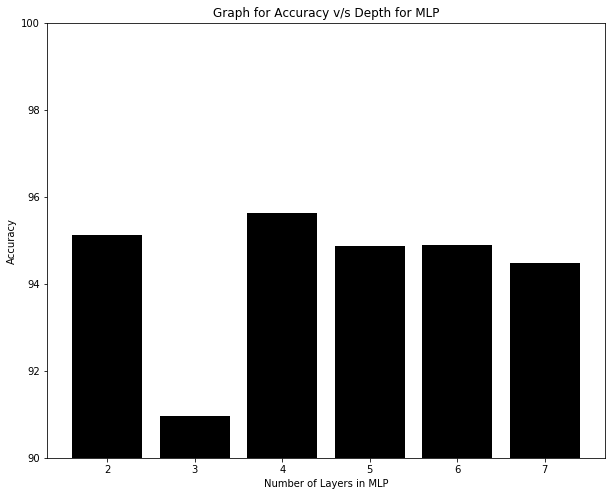

In [33]:
x = [2,3,4,5,6,7]
y = accuracy_hidden_layers*100


plt.figure(figsize=(10,8))
plt.bar(x,y, color='k')
bottom = 90
top = 100
plt.ylim((bottom, top)) 
plt.xlabel('Number of Layers in MLP')
plt.ylabel('Accuracy')
plt.title('Graph for Accuracy v/s Depth for MLP')
plt.show()

### MLP with different neuron numbers/ complexity in depth 2 HLs

In [34]:
comp_accuracies = []

#### 100 neurons

In [35]:
class MLPn1:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        tf.reset_default_graph()
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLPn1', reuse=tf.AUTO_REUSE):

            hl_1 = tf.layers.dense(self.im,100,activation=tf.nn.relu, name='hl_1')
            hl_2 = tf.layers.dense(hl_1,100,activation=tf.nn.relu, name='hl_2')
        
            self.logits = tf.layers.dense(hl_2,10,activation=None, name='logits')
            self.preds = tf.nn.softmax(self.logits, name='preds')
        #########################################
    def compute_loss(self):
        with tf.variable_scope('loss'):

            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [36]:
model = MLPn1(x_train, y_train, './MLPn1_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

In [37]:
start_time = timeit.default_timer()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Epoch 0, Iteration 0, loss 2.810, batch accuracy 0.000
Epoch 0, Iteration 1, loss 2.341, batch accuracy 0.100
Epoch 0, Iteration 2, loss 2.311, batch accuracy 0.100
Epoch 0, Iteration 3, loss 2.213, batch accuracy 0.300
Epoch 0, Iteration 4, loss 2.408, batch accuracy 0.100
Epoch 0, Iteration 5, loss 2.265, batch accuracy 0.000
Epoch 0, Iteration 6, loss 1.863, batch accuracy 0.400
Epoch 0, Iteration 7, loss 2.412, batch accuracy 0.200
Epoch 0, Iteration 8, loss 2.544, batch accuracy 0.100
Epoch 0, Iteration 9, loss 1.884, batch accuracy 0.400
Epoch 0, Iteration 10, loss 1.757, batch accuracy 0.500
Epoch 0, Iteration 11, loss 2.065, batch accuracy 0.100
Epoch 0, Iteration 12, loss 2.307, batch accuracy 0.100
Epoch 0, Iteration 13, loss 1.818, batch accuracy 0.500
Epoch 0, Iteration 14, loss 1.687, batch accuracy 0.500
Epoch 0, Iteration 15, loss 1.845, batch accuracy 0.200
Epoch 0, Iteration 16, loss 1.967, batch accuracy 0.400
Epoch 0, Iteration 17, loss 2.128, batch accuracy 0.300
Ep

Epoch 0, Iteration 186, loss 0.426, batch accuracy 0.800
Epoch 0, Iteration 187, loss 0.561, batch accuracy 0.900
Epoch 0, Iteration 188, loss 1.048, batch accuracy 0.700
Epoch 0, Iteration 189, loss 0.611, batch accuracy 0.900
Epoch 0, Iteration 190, loss 0.345, batch accuracy 0.800
Epoch 0, Iteration 191, loss 0.599, batch accuracy 0.900
Epoch 0, Iteration 192, loss 1.086, batch accuracy 0.600
Epoch 0, Iteration 193, loss 0.397, batch accuracy 0.800
Epoch 0, Iteration 194, loss 0.586, batch accuracy 0.900
Epoch 0, Iteration 195, loss 1.357, batch accuracy 0.600
Epoch 0, Iteration 196, loss 0.467, batch accuracy 0.800
Epoch 0, Iteration 197, loss 0.516, batch accuracy 0.900
Epoch 0, Iteration 198, loss 0.388, batch accuracy 0.900
Epoch 0, Iteration 199, loss 1.041, batch accuracy 0.700
Epoch 0, Iteration 200, loss 1.470, batch accuracy 0.500
Epoch 0, Iteration 201, loss 0.807, batch accuracy 0.700
Epoch 0, Iteration 202, loss 0.414, batch accuracy 0.900
Epoch 0, Iteration 203, loss 0.

Epoch 0, Iteration 367, loss 0.149, batch accuracy 1.000
Epoch 0, Iteration 368, loss 0.419, batch accuracy 0.900
Epoch 0, Iteration 369, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 370, loss 0.463, batch accuracy 0.900
Epoch 0, Iteration 371, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 372, loss 0.555, batch accuracy 0.700
Epoch 0, Iteration 373, loss 0.595, batch accuracy 0.800
Epoch 0, Iteration 374, loss 0.678, batch accuracy 0.800
Epoch 0, Iteration 375, loss 0.539, batch accuracy 0.700
Epoch 0, Iteration 376, loss 0.596, batch accuracy 0.900
Epoch 0, Iteration 377, loss 0.291, batch accuracy 0.900
Epoch 0, Iteration 378, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 379, loss 0.391, batch accuracy 0.900
Epoch 0, Iteration 380, loss 0.599, batch accuracy 0.800
Epoch 0, Iteration 381, loss 0.110, batch accuracy 1.000
Epoch 0, Iteration 382, loss 0.481, batch accuracy 0.700
Epoch 0, Iteration 383, loss 0.477, batch accuracy 0.800
Epoch 0, Iteration 384, loss 0.

Epoch 0, Iteration 553, loss 0.203, batch accuracy 1.000
Epoch 0, Iteration 554, loss 0.467, batch accuracy 0.800
Epoch 0, Iteration 555, loss 0.119, batch accuracy 1.000
Epoch 0, Iteration 556, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 557, loss 0.856, batch accuracy 0.800
Epoch 0, Iteration 558, loss 0.479, batch accuracy 0.800
Epoch 0, Iteration 559, loss 0.734, batch accuracy 0.800
Epoch 0, Iteration 560, loss 0.472, batch accuracy 0.800
Epoch 0, Iteration 561, loss 0.181, batch accuracy 1.000
Epoch 0, Iteration 562, loss 0.121, batch accuracy 1.000
Epoch 0, Iteration 563, loss 0.544, batch accuracy 0.700
Epoch 0, Iteration 564, loss 0.261, batch accuracy 0.900
Epoch 0, Iteration 565, loss 1.211, batch accuracy 0.700
Epoch 0, Iteration 566, loss 0.257, batch accuracy 0.900
Epoch 0, Iteration 567, loss 0.406, batch accuracy 0.900
Epoch 0, Iteration 568, loss 0.129, batch accuracy 1.000
Epoch 0, Iteration 569, loss 0.244, batch accuracy 1.000
Epoch 0, Iteration 570, loss 0.

Epoch 0, Iteration 738, loss 0.182, batch accuracy 1.000
Epoch 0, Iteration 739, loss 0.690, batch accuracy 0.900
Epoch 0, Iteration 740, loss 0.234, batch accuracy 0.900
Epoch 0, Iteration 741, loss 0.384, batch accuracy 0.900
Epoch 0, Iteration 742, loss 0.327, batch accuracy 0.800
Epoch 0, Iteration 743, loss 0.489, batch accuracy 0.800
Epoch 0, Iteration 744, loss 0.348, batch accuracy 0.900
Epoch 0, Iteration 745, loss 0.427, batch accuracy 0.900
Epoch 0, Iteration 746, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 747, loss 0.666, batch accuracy 0.900
Epoch 0, Iteration 748, loss 0.651, batch accuracy 0.900
Epoch 0, Iteration 749, loss 0.514, batch accuracy 0.900
Epoch 0, Iteration 750, loss 0.136, batch accuracy 0.900
Epoch 0, Iteration 751, loss 0.326, batch accuracy 0.800
Epoch 0, Iteration 752, loss 0.205, batch accuracy 0.900
Epoch 0, Iteration 753, loss 0.458, batch accuracy 0.800
Epoch 0, Iteration 754, loss 0.160, batch accuracy 1.000
Epoch 0, Iteration 755, loss 0.

Epoch 0, Iteration 910, loss 0.079, batch accuracy 1.000
Epoch 0, Iteration 911, loss 0.201, batch accuracy 0.900
Epoch 0, Iteration 912, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 913, loss 0.236, batch accuracy 0.900
Epoch 0, Iteration 914, loss 0.472, batch accuracy 0.800
Epoch 0, Iteration 915, loss 0.153, batch accuracy 0.900
Epoch 0, Iteration 916, loss 0.183, batch accuracy 1.000
Epoch 0, Iteration 917, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 918, loss 0.095, batch accuracy 0.900
Epoch 0, Iteration 919, loss 0.344, batch accuracy 0.900
Epoch 0, Iteration 920, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 921, loss 0.437, batch accuracy 0.800
Epoch 0, Iteration 922, loss 0.266, batch accuracy 0.900
Epoch 0, Iteration 923, loss 0.282, batch accuracy 0.900
Epoch 0, Iteration 924, loss 0.150, batch accuracy 1.000
Epoch 0, Iteration 925, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 926, loss 0.130, batch accuracy 0.900
Epoch 0, Iteration 927, loss 0.

Epoch 0, Iteration 1080, loss 0.123, batch accuracy 0.900
Epoch 0, Iteration 1081, loss 0.271, batch accuracy 0.900
Epoch 0, Iteration 1082, loss 0.351, batch accuracy 0.900
Epoch 0, Iteration 1083, loss 0.328, batch accuracy 0.800
Epoch 0, Iteration 1084, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 1085, loss 0.125, batch accuracy 1.000
Epoch 0, Iteration 1086, loss 0.271, batch accuracy 0.900
Epoch 0, Iteration 1087, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 1088, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 1089, loss 0.201, batch accuracy 0.900
Epoch 0, Iteration 1090, loss 0.134, batch accuracy 1.000
Epoch 0, Iteration 1091, loss 0.519, batch accuracy 0.800
Epoch 0, Iteration 1092, loss 0.113, batch accuracy 0.900
Epoch 0, Iteration 1093, loss 0.178, batch accuracy 0.900
Epoch 0, Iteration 1094, loss 0.400, batch accuracy 0.800
Epoch 0, Iteration 1095, loss 0.459, batch accuracy 0.800
Epoch 0, Iteration 1096, loss 0.999, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 1264, loss 0.591, batch accuracy 0.700
Epoch 0, Iteration 1265, loss 1.371, batch accuracy 0.800
Epoch 0, Iteration 1266, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 1267, loss 0.648, batch accuracy 0.800
Epoch 0, Iteration 1268, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 1269, loss 0.122, batch accuracy 1.000
Epoch 0, Iteration 1270, loss 0.620, batch accuracy 0.900
Epoch 0, Iteration 1271, loss 0.225, batch accuracy 0.900
Epoch 0, Iteration 1272, loss 0.367, batch accuracy 0.900
Epoch 0, Iteration 1273, loss 0.208, batch accuracy 1.000
Epoch 0, Iteration 1274, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 1275, loss 0.863, batch accuracy 0.800
Epoch 0, Iteration 1276, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 1277, loss 0.100, batch accuracy 1.000
Epoch 0, Iteration 1278, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 1279, loss 0.410, batch accuracy 0.700
Epoch 0, Iteration 1280, loss 0.252, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1448, loss 0.667, batch accuracy 0.700
Epoch 0, Iteration 1449, loss 0.707, batch accuracy 0.800
Epoch 0, Iteration 1450, loss 0.271, batch accuracy 0.900
Epoch 0, Iteration 1451, loss 0.211, batch accuracy 0.900
Epoch 0, Iteration 1452, loss 0.117, batch accuracy 0.900
Epoch 0, Iteration 1453, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 1454, loss 0.354, batch accuracy 0.800
Epoch 0, Iteration 1455, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 1456, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 1457, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 1458, loss 0.101, batch accuracy 1.000
Epoch 0, Iteration 1459, loss 0.515, batch accuracy 0.800
Epoch 0, Iteration 1460, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 1461, loss 0.304, batch accuracy 0.800
Epoch 0, Iteration 1462, loss 0.170, batch accuracy 0.900
Epoch 0, Iteration 1463, loss 0.128, batch accuracy 1.000
Epoch 0, Iteration 1464, loss 0.562, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1635, loss 1.009, batch accuracy 0.800
Epoch 0, Iteration 1636, loss 0.092, batch accuracy 1.000
Epoch 0, Iteration 1637, loss 0.167, batch accuracy 0.900
Epoch 0, Iteration 1638, loss 0.079, batch accuracy 1.000
Epoch 0, Iteration 1639, loss 0.411, batch accuracy 0.900
Epoch 0, Iteration 1640, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 1641, loss 0.769, batch accuracy 0.800
Epoch 0, Iteration 1642, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 1643, loss 0.197, batch accuracy 1.000
Epoch 0, Iteration 1644, loss 0.107, batch accuracy 1.000
Epoch 0, Iteration 1645, loss 0.626, batch accuracy 0.800
Epoch 0, Iteration 1646, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 1647, loss 0.190, batch accuracy 0.900
Epoch 0, Iteration 1648, loss 0.175, batch accuracy 0.900
Epoch 0, Iteration 1649, loss 0.240, batch accuracy 0.900
Epoch 0, Iteration 1650, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 1651, loss 0.310, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1822, loss 0.126, batch accuracy 1.000
Epoch 0, Iteration 1823, loss 0.131, batch accuracy 1.000
Epoch 0, Iteration 1824, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 1825, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 1826, loss 0.191, batch accuracy 0.900
Epoch 0, Iteration 1827, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 1828, loss 0.314, batch accuracy 0.800
Epoch 0, Iteration 1829, loss 0.769, batch accuracy 0.900
Epoch 0, Iteration 1830, loss 0.174, batch accuracy 0.900
Epoch 0, Iteration 1831, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 1832, loss 0.349, batch accuracy 0.900
Epoch 0, Iteration 1833, loss 0.552, batch accuracy 0.600
Epoch 0, Iteration 1834, loss 0.356, batch accuracy 0.900
Epoch 0, Iteration 1835, loss 0.141, batch accuracy 1.000
Epoch 0, Iteration 1836, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 1837, loss 0.634, batch accuracy 0.800
Epoch 0, Iteration 1838, loss 0.246, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2008, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 2009, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 2010, loss 0.220, batch accuracy 0.900
Epoch 0, Iteration 2011, loss 0.470, batch accuracy 0.800
Epoch 0, Iteration 2012, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 2013, loss 0.202, batch accuracy 0.900
Epoch 0, Iteration 2014, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 2015, loss 0.322, batch accuracy 0.900
Epoch 0, Iteration 2016, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 2017, loss 0.123, batch accuracy 1.000
Epoch 0, Iteration 2018, loss 0.546, batch accuracy 0.900
Epoch 0, Iteration 2019, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 2020, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 2021, loss 0.296, batch accuracy 0.900
Epoch 0, Iteration 2022, loss 0.365, batch accuracy 0.900
Epoch 0, Iteration 2023, loss 0.191, batch accuracy 0.900
Epoch 0, Iteration 2024, loss 0.182, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2191, loss 0.218, batch accuracy 0.900
Epoch 0, Iteration 2192, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 2193, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 2194, loss 0.186, batch accuracy 0.900
Epoch 0, Iteration 2195, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 2196, loss 0.737, batch accuracy 0.800
Epoch 0, Iteration 2197, loss 0.124, batch accuracy 0.900
Epoch 0, Iteration 2198, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 2199, loss 0.101, batch accuracy 1.000
Epoch 0, Iteration 2200, loss 0.384, batch accuracy 0.900
Epoch 0, Iteration 2201, loss 0.130, batch accuracy 1.000
Epoch 0, Iteration 2202, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 2203, loss 0.442, batch accuracy 0.800
Epoch 0, Iteration 2204, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 2205, loss 0.224, batch accuracy 0.900
Epoch 0, Iteration 2206, loss 1.532, batch accuracy 0.800
Epoch 0, Iteration 2207, loss 0.237, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2380, loss 0.273, batch accuracy 0.900
Epoch 0, Iteration 2381, loss 0.155, batch accuracy 0.900
Epoch 0, Iteration 2382, loss 0.101, batch accuracy 1.000
Epoch 0, Iteration 2383, loss 0.662, batch accuracy 0.900
Epoch 0, Iteration 2384, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 2385, loss 0.552, batch accuracy 0.800
Epoch 0, Iteration 2386, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 2387, loss 0.270, batch accuracy 0.900
Epoch 0, Iteration 2388, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 2389, loss 0.401, batch accuracy 0.800
Epoch 0, Iteration 2390, loss 0.223, batch accuracy 0.900
Epoch 0, Iteration 2391, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 2392, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 2393, loss 0.713, batch accuracy 0.900
Epoch 0, Iteration 2394, loss 0.124, batch accuracy 1.000
Epoch 0, Iteration 2395, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 2396, loss 0.211, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2568, loss 0.670, batch accuracy 0.900
Epoch 0, Iteration 2569, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 2570, loss 0.166, batch accuracy 0.900
Epoch 0, Iteration 2571, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 2572, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 2573, loss 0.501, batch accuracy 0.900
Epoch 0, Iteration 2574, loss 0.092, batch accuracy 1.000
Epoch 0, Iteration 2575, loss 0.130, batch accuracy 0.900
Epoch 0, Iteration 2576, loss 0.851, batch accuracy 0.800
Epoch 0, Iteration 2577, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 2578, loss 1.512, batch accuracy 0.800
Epoch 0, Iteration 2579, loss 0.344, batch accuracy 0.900
Epoch 0, Iteration 2580, loss 0.092, batch accuracy 1.000
Epoch 0, Iteration 2581, loss 0.152, batch accuracy 0.900
Epoch 0, Iteration 2582, loss 0.722, batch accuracy 0.800
Epoch 0, Iteration 2583, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 2584, loss 0.327, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2756, loss 0.239, batch accuracy 0.900
Epoch 0, Iteration 2757, loss 0.299, batch accuracy 0.900
Epoch 0, Iteration 2758, loss 0.665, batch accuracy 0.900
Epoch 0, Iteration 2759, loss 0.332, batch accuracy 0.900
Epoch 0, Iteration 2760, loss 0.540, batch accuracy 0.800
Epoch 0, Iteration 2761, loss 0.135, batch accuracy 0.900
Epoch 0, Iteration 2762, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 2763, loss 0.228, batch accuracy 0.900
Epoch 0, Iteration 2764, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 2765, loss 0.210, batch accuracy 0.900
Epoch 0, Iteration 2766, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 2767, loss 0.106, batch accuracy 0.900
Epoch 0, Iteration 2768, loss 0.620, batch accuracy 0.800
Epoch 0, Iteration 2769, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 2770, loss 0.182, batch accuracy 0.900
Epoch 0, Iteration 2771, loss 0.301, batch accuracy 0.900
Epoch 0, Iteration 2772, loss 0.404, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2943, loss 0.110, batch accuracy 1.000
Epoch 0, Iteration 2944, loss 0.144, batch accuracy 0.900
Epoch 0, Iteration 2945, loss 0.150, batch accuracy 0.900
Epoch 0, Iteration 2946, loss 0.435, batch accuracy 0.800
Epoch 0, Iteration 2947, loss 0.136, batch accuracy 0.900
Epoch 0, Iteration 2948, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 2949, loss 0.757, batch accuracy 0.800
Epoch 0, Iteration 2950, loss 0.103, batch accuracy 1.000
Epoch 0, Iteration 2951, loss 0.487, batch accuracy 0.900
Epoch 0, Iteration 2952, loss 0.196, batch accuracy 0.900
Epoch 0, Iteration 2953, loss 0.226, batch accuracy 0.900
Epoch 0, Iteration 2954, loss 0.304, batch accuracy 0.800
Epoch 0, Iteration 2955, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 2956, loss 0.506, batch accuracy 0.900
Epoch 0, Iteration 2957, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 2958, loss 0.440, batch accuracy 0.900
Epoch 0, Iteration 2959, loss 0.124, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3130, loss 0.207, batch accuracy 0.900
Epoch 0, Iteration 3131, loss 0.491, batch accuracy 0.900
Epoch 0, Iteration 3132, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 3133, loss 0.341, batch accuracy 0.800
Epoch 0, Iteration 3134, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 3135, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 3136, loss 0.242, batch accuracy 0.800
Epoch 0, Iteration 3137, loss 0.273, batch accuracy 0.800
Epoch 0, Iteration 3138, loss 0.129, batch accuracy 1.000
Epoch 0, Iteration 3139, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 3140, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 3141, loss 0.113, batch accuracy 1.000
Epoch 0, Iteration 3142, loss 0.534, batch accuracy 0.800
Epoch 0, Iteration 3143, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 3144, loss 0.122, batch accuracy 1.000
Epoch 0, Iteration 3145, loss 0.376, batch accuracy 0.900
Epoch 0, Iteration 3146, loss 0.122, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3318, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 3319, loss 0.450, batch accuracy 0.900
Epoch 0, Iteration 3320, loss 0.097, batch accuracy 0.900
Epoch 0, Iteration 3321, loss 0.542, batch accuracy 0.700
Epoch 0, Iteration 3322, loss 0.133, batch accuracy 1.000
Epoch 0, Iteration 3323, loss 0.346, batch accuracy 0.900
Epoch 0, Iteration 3324, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 3325, loss 0.174, batch accuracy 0.900
Epoch 0, Iteration 3326, loss 0.498, batch accuracy 0.900
Epoch 0, Iteration 3327, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 3328, loss 0.243, batch accuracy 0.900
Epoch 0, Iteration 3329, loss 0.183, batch accuracy 0.900
Epoch 0, Iteration 3330, loss 0.144, batch accuracy 1.000
Epoch 0, Iteration 3331, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 3332, loss 0.401, batch accuracy 0.900
Epoch 0, Iteration 3333, loss 0.227, batch accuracy 0.800
Epoch 0, Iteration 3334, loss 0.017, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3504, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3505, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 3506, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 3507, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 3508, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 3509, loss 0.266, batch accuracy 0.900
Epoch 0, Iteration 3510, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 3511, loss 0.558, batch accuracy 0.800
Epoch 0, Iteration 3512, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 3513, loss 0.175, batch accuracy 1.000
Epoch 0, Iteration 3514, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 3515, loss 0.368, batch accuracy 0.900
Epoch 0, Iteration 3516, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 3517, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 3518, loss 1.378, batch accuracy 0.600
Epoch 0, Iteration 3519, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 3520, loss 1.310, batch accuracy 0.600
Epoch 0, Itera

Epoch 0, Iteration 3686, loss 0.210, batch accuracy 0.900
Epoch 0, Iteration 3687, loss 0.478, batch accuracy 0.800
Epoch 0, Iteration 3688, loss 0.233, batch accuracy 1.000
Epoch 0, Iteration 3689, loss 0.329, batch accuracy 0.900
Epoch 0, Iteration 3690, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 3691, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 3692, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 3693, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 3694, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 3695, loss 0.723, batch accuracy 0.700
Epoch 0, Iteration 3696, loss 0.286, batch accuracy 0.900
Epoch 0, Iteration 3697, loss 0.106, batch accuracy 0.900
Epoch 0, Iteration 3698, loss 0.406, batch accuracy 0.900
Epoch 0, Iteration 3699, loss 0.435, batch accuracy 0.900
Epoch 0, Iteration 3700, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 3701, loss 0.326, batch accuracy 0.900
Epoch 0, Iteration 3702, loss 0.142, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3875, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 3876, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 3877, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 3878, loss 0.743, batch accuracy 0.700
Epoch 0, Iteration 3879, loss 0.209, batch accuracy 0.900
Epoch 0, Iteration 3880, loss 0.244, batch accuracy 0.900
Epoch 0, Iteration 3881, loss 0.397, batch accuracy 0.900
Epoch 0, Iteration 3882, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 3883, loss 0.502, batch accuracy 0.900
Epoch 0, Iteration 3884, loss 0.233, batch accuracy 0.900
Epoch 0, Iteration 3885, loss 0.342, batch accuracy 0.800
Epoch 0, Iteration 3886, loss 0.260, batch accuracy 0.800
Epoch 0, Iteration 3887, loss 0.143, batch accuracy 0.900
Epoch 0, Iteration 3888, loss 0.151, batch accuracy 1.000
Epoch 0, Iteration 3889, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 3890, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 3891, loss 0.563, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4062, loss 0.209, batch accuracy 0.900
Epoch 0, Iteration 4063, loss 0.662, batch accuracy 0.900
Epoch 0, Iteration 4064, loss 0.361, batch accuracy 0.800
Epoch 0, Iteration 4065, loss 0.611, batch accuracy 0.900
Epoch 0, Iteration 4066, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 4067, loss 0.140, batch accuracy 1.000
Epoch 0, Iteration 4068, loss 0.377, batch accuracy 0.800
Epoch 0, Iteration 4069, loss 0.224, batch accuracy 0.900
Epoch 0, Iteration 4070, loss 0.612, batch accuracy 0.800
Epoch 0, Iteration 4071, loss 0.249, batch accuracy 0.900
Epoch 0, Iteration 4072, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4073, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4074, loss 0.263, batch accuracy 0.900
Epoch 0, Iteration 4075, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4076, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 4077, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 4078, loss 0.075, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4243, loss 0.190, batch accuracy 1.000
Epoch 0, Iteration 4244, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 4245, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4246, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 4247, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 4248, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 4249, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 4250, loss 0.293, batch accuracy 0.900
Epoch 0, Iteration 4251, loss 0.149, batch accuracy 0.900
Epoch 0, Iteration 4252, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 4253, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 4254, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 4255, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 4256, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 4257, loss 0.714, batch accuracy 0.900
Epoch 0, Iteration 4258, loss 0.237, batch accuracy 0.900
Epoch 0, Iteration 4259, loss 0.007, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4429, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 4430, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 4431, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 4432, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 4433, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4434, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 4435, loss 0.163, batch accuracy 0.900
Epoch 0, Iteration 4436, loss 0.229, batch accuracy 0.900
Epoch 0, Iteration 4437, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 4438, loss 0.163, batch accuracy 0.900
Epoch 0, Iteration 4439, loss 0.127, batch accuracy 1.000
Epoch 0, Iteration 4440, loss 0.459, batch accuracy 0.900
Epoch 0, Iteration 4441, loss 0.129, batch accuracy 0.900
Epoch 0, Iteration 4442, loss 0.107, batch accuracy 1.000
Epoch 0, Iteration 4443, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 4444, loss 0.118, batch accuracy 1.000
Epoch 0, Iteration 4445, loss 0.030, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4609, loss 0.380, batch accuracy 0.800
Epoch 0, Iteration 4610, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 4611, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 4612, loss 0.325, batch accuracy 0.800
Epoch 0, Iteration 4613, loss 0.160, batch accuracy 0.900
Epoch 0, Iteration 4614, loss 0.385, batch accuracy 0.900
Epoch 0, Iteration 4615, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 4616, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 4617, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 4618, loss 0.126, batch accuracy 0.900
Epoch 0, Iteration 4619, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 4620, loss 0.197, batch accuracy 0.900
Epoch 0, Iteration 4621, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 4622, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 4623, loss 0.433, batch accuracy 0.800
Epoch 0, Iteration 4624, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 4625, loss 0.031, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4799, loss 0.123, batch accuracy 1.000
Epoch 0, Iteration 4800, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 4801, loss 0.280, batch accuracy 0.900
Epoch 0, Iteration 4802, loss 0.104, batch accuracy 1.000
Epoch 0, Iteration 4803, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 4804, loss 0.255, batch accuracy 0.900
Epoch 0, Iteration 4805, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4806, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4807, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 4808, loss 0.311, batch accuracy 0.800
Epoch 0, Iteration 4809, loss 0.421, batch accuracy 0.700
Epoch 0, Iteration 4810, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 4811, loss 0.723, batch accuracy 0.800
Epoch 0, Iteration 4812, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 4813, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 4814, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 4815, loss 0.008, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4986, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 4987, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 4988, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 4989, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 4990, loss 0.551, batch accuracy 0.900
Epoch 0, Iteration 4991, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 4992, loss 0.252, batch accuracy 0.900
Epoch 0, Iteration 4993, loss 0.411, batch accuracy 0.800
Epoch 0, Iteration 4994, loss 0.515, batch accuracy 0.900
Epoch 0, Iteration 4995, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 4996, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 4997, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4998, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 4999, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 5000, loss 0.141, batch accuracy 0.900
Epoch 0, Iteration 5001, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 5002, loss 0.017, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5173, loss 0.539, batch accuracy 0.900
Epoch 0, Iteration 5174, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 5175, loss 0.369, batch accuracy 0.900
Epoch 0, Iteration 5176, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 5177, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 5178, loss 0.330, batch accuracy 0.900
Epoch 0, Iteration 5179, loss 0.246, batch accuracy 0.900
Epoch 0, Iteration 5180, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5181, loss 0.092, batch accuracy 0.900
Epoch 0, Iteration 5182, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 5183, loss 0.369, batch accuracy 0.900
Epoch 0, Iteration 5184, loss 0.225, batch accuracy 0.800
Epoch 0, Iteration 5185, loss 0.543, batch accuracy 0.900
Epoch 0, Iteration 5186, loss 0.193, batch accuracy 1.000
Epoch 0, Iteration 5187, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 5188, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 5189, loss 0.054, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5360, loss 1.021, batch accuracy 0.700
Epoch 0, Iteration 5361, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 5362, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 5363, loss 0.130, batch accuracy 1.000
Epoch 0, Iteration 5364, loss 0.158, batch accuracy 1.000
Epoch 0, Iteration 5365, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 5366, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5367, loss 0.355, batch accuracy 0.900
Epoch 0, Iteration 5368, loss 0.329, batch accuracy 0.900
Epoch 0, Iteration 5369, loss 0.434, batch accuracy 0.900
Epoch 0, Iteration 5370, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 5371, loss 0.178, batch accuracy 0.900
Epoch 0, Iteration 5372, loss 0.562, batch accuracy 0.900
Epoch 0, Iteration 5373, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 5374, loss 0.239, batch accuracy 0.900
Epoch 0, Iteration 5375, loss 0.861, batch accuracy 0.900
Epoch 0, Iteration 5376, loss 0.383, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 5545, loss 0.379, batch accuracy 0.800
Epoch 0, Iteration 5546, loss 0.400, batch accuracy 0.900
Epoch 0, Iteration 5547, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 5548, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 5549, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 5550, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 5551, loss 0.240, batch accuracy 0.900
Epoch 0, Iteration 5552, loss 0.411, batch accuracy 0.900
Epoch 0, Iteration 5553, loss 0.679, batch accuracy 0.900
Epoch 0, Iteration 5554, loss 0.688, batch accuracy 0.900
Epoch 0, Iteration 5555, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5556, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 5557, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 5558, loss 0.150, batch accuracy 0.900
Epoch 0, Iteration 5559, loss 0.360, batch accuracy 0.800
Epoch 0, Iteration 5560, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 5561, loss 0.028, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5735, loss 0.575, batch accuracy 0.900
Epoch 0, Iteration 5736, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 5737, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 5738, loss 0.139, batch accuracy 0.900
Epoch 0, Iteration 5739, loss 0.183, batch accuracy 0.900
Epoch 0, Iteration 5740, loss 0.193, batch accuracy 0.900
Epoch 0, Iteration 5741, loss 0.148, batch accuracy 0.900
Epoch 0, Iteration 5742, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 5743, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 5744, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 5745, loss 0.262, batch accuracy 0.800
Epoch 0, Iteration 5746, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 5747, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 5748, loss 0.293, batch accuracy 0.800
Epoch 0, Iteration 5749, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 5750, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 5751, loss 0.225, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 5919, loss 0.137, batch accuracy 0.900
Epoch 0, Iteration 5920, loss 0.282, batch accuracy 0.900
Epoch 0, Iteration 5921, loss 0.507, batch accuracy 0.900
Epoch 0, Iteration 5922, loss 0.398, batch accuracy 0.800
Epoch 0, Iteration 5923, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 5924, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 5925, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 5926, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5927, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 5928, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 5929, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 5930, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 5931, loss 0.577, batch accuracy 0.800
Epoch 0, Iteration 5932, loss 0.161, batch accuracy 0.900
Epoch 0, Iteration 5933, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 5934, loss 0.630, batch accuracy 0.800
Epoch 0, Iteration 5935, loss 0.103, batch accuracy 1.000
Epoch 0, Itera

Epoch 1, Iteration 111, loss 0.157, batch accuracy 1.000
Epoch 1, Iteration 112, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 113, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 114, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 115, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 116, loss 0.271, batch accuracy 0.800
Epoch 1, Iteration 117, loss 0.123, batch accuracy 1.000
Epoch 1, Iteration 118, loss 0.338, batch accuracy 0.900
Epoch 1, Iteration 119, loss 0.147, batch accuracy 0.900
Epoch 1, Iteration 120, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 121, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 122, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 123, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 124, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 125, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 126, loss 0.895, batch accuracy 0.800
Epoch 1, Iteration 127, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 128, loss 0.

Epoch 1, Iteration 294, loss 0.685, batch accuracy 0.900
Epoch 1, Iteration 295, loss 0.108, batch accuracy 1.000
Epoch 1, Iteration 296, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 297, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 298, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 299, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 300, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 301, loss 0.436, batch accuracy 0.900
Epoch 1, Iteration 302, loss 0.450, batch accuracy 0.800
Epoch 1, Iteration 303, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 304, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 305, loss 0.106, batch accuracy 1.000
Epoch 1, Iteration 306, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 307, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 308, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 309, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 310, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 311, loss 0.

Epoch 1, Iteration 473, loss 0.362, batch accuracy 0.900
Epoch 1, Iteration 474, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 475, loss 0.156, batch accuracy 0.900
Epoch 1, Iteration 476, loss 0.999, batch accuracy 0.800
Epoch 1, Iteration 477, loss 0.270, batch accuracy 0.900
Epoch 1, Iteration 478, loss 0.904, batch accuracy 0.800
Epoch 1, Iteration 479, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 480, loss 0.170, batch accuracy 1.000
Epoch 1, Iteration 481, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 482, loss 0.091, batch accuracy 1.000
Epoch 1, Iteration 483, loss 0.289, batch accuracy 0.900
Epoch 1, Iteration 484, loss 0.724, batch accuracy 0.800
Epoch 1, Iteration 485, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 486, loss 0.109, batch accuracy 0.900
Epoch 1, Iteration 487, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 488, loss 0.119, batch accuracy 0.900
Epoch 1, Iteration 489, loss 0.222, batch accuracy 0.900
Epoch 1, Iteration 490, loss 0.

Epoch 1, Iteration 659, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 660, loss 0.519, batch accuracy 0.800
Epoch 1, Iteration 661, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 662, loss 0.178, batch accuracy 0.900
Epoch 1, Iteration 663, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 664, loss 0.590, batch accuracy 0.900
Epoch 1, Iteration 665, loss 1.182, batch accuracy 0.700
Epoch 1, Iteration 666, loss 0.531, batch accuracy 0.900
Epoch 1, Iteration 667, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 668, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 669, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 670, loss 0.326, batch accuracy 0.900
Epoch 1, Iteration 671, loss 0.229, batch accuracy 0.900
Epoch 1, Iteration 672, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 673, loss 0.344, batch accuracy 0.900
Epoch 1, Iteration 674, loss 0.169, batch accuracy 1.000
Epoch 1, Iteration 675, loss 0.350, batch accuracy 0.900
Epoch 1, Iteration 676, loss 0.

Epoch 1, Iteration 844, loss 0.182, batch accuracy 0.900
Epoch 1, Iteration 845, loss 0.200, batch accuracy 0.800
Epoch 1, Iteration 846, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 847, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 848, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 849, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 850, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 851, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 852, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 853, loss 0.174, batch accuracy 0.900
Epoch 1, Iteration 854, loss 0.223, batch accuracy 0.900
Epoch 1, Iteration 855, loss 0.247, batch accuracy 0.900
Epoch 1, Iteration 856, loss 0.335, batch accuracy 0.800
Epoch 1, Iteration 857, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 858, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 859, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 860, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 861, loss 0.

Epoch 1, Iteration 1028, loss 0.281, batch accuracy 0.900
Epoch 1, Iteration 1029, loss 0.565, batch accuracy 0.700
Epoch 1, Iteration 1030, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1031, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 1032, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 1033, loss 0.501, batch accuracy 0.900
Epoch 1, Iteration 1034, loss 0.378, batch accuracy 0.800
Epoch 1, Iteration 1035, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 1036, loss 0.153, batch accuracy 0.900
Epoch 1, Iteration 1037, loss 0.216, batch accuracy 0.900
Epoch 1, Iteration 1038, loss 0.216, batch accuracy 0.900
Epoch 1, Iteration 1039, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 1040, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 1041, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 1042, loss 0.117, batch accuracy 0.900
Epoch 1, Iteration 1043, loss 0.196, batch accuracy 0.900
Epoch 1, Iteration 1044, loss 0.111, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1212, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1213, loss 0.818, batch accuracy 0.900
Epoch 1, Iteration 1214, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 1215, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 1216, loss 0.567, batch accuracy 0.900
Epoch 1, Iteration 1217, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 1218, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 1219, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1220, loss 0.134, batch accuracy 1.000
Epoch 1, Iteration 1221, loss 0.207, batch accuracy 0.900
Epoch 1, Iteration 1222, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 1223, loss 0.525, batch accuracy 0.900
Epoch 1, Iteration 1224, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 1225, loss 0.137, batch accuracy 0.900
Epoch 1, Iteration 1226, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 1227, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1228, loss 0.032, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1398, loss 0.446, batch accuracy 0.800
Epoch 1, Iteration 1399, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 1400, loss 0.114, batch accuracy 0.900
Epoch 1, Iteration 1401, loss 0.220, batch accuracy 0.900
Epoch 1, Iteration 1402, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 1403, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1404, loss 0.309, batch accuracy 0.900
Epoch 1, Iteration 1405, loss 0.117, batch accuracy 1.000
Epoch 1, Iteration 1406, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 1407, loss 0.293, batch accuracy 0.900
Epoch 1, Iteration 1408, loss 0.332, batch accuracy 0.800
Epoch 1, Iteration 1409, loss 0.431, batch accuracy 0.800
Epoch 1, Iteration 1410, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1411, loss 0.279, batch accuracy 0.900
Epoch 1, Iteration 1412, loss 0.157, batch accuracy 0.900
Epoch 1, Iteration 1413, loss 0.354, batch accuracy 0.800
Epoch 1, Iteration 1414, loss 0.028, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1583, loss 0.114, batch accuracy 1.000
Epoch 1, Iteration 1584, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 1585, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 1586, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 1587, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 1588, loss 0.346, batch accuracy 0.900
Epoch 1, Iteration 1589, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 1590, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 1591, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1592, loss 0.216, batch accuracy 0.900
Epoch 1, Iteration 1593, loss 0.175, batch accuracy 0.900
Epoch 1, Iteration 1594, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 1595, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 1596, loss 0.449, batch accuracy 0.900
Epoch 1, Iteration 1597, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 1598, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1599, loss 0.016, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1769, loss 0.102, batch accuracy 1.000
Epoch 1, Iteration 1770, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1771, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 1772, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1773, loss 0.486, batch accuracy 0.900
Epoch 1, Iteration 1774, loss 0.205, batch accuracy 0.900
Epoch 1, Iteration 1775, loss 0.096, batch accuracy 1.000
Epoch 1, Iteration 1776, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1777, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 1778, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 1779, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 1780, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1781, loss 0.446, batch accuracy 0.900
Epoch 1, Iteration 1782, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1783, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1784, loss 0.989, batch accuracy 0.800
Epoch 1, Iteration 1785, loss 0.051, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1957, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 1958, loss 0.279, batch accuracy 0.900
Epoch 1, Iteration 1959, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 1960, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 1961, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1962, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 1963, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1964, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1965, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1966, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 1967, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1968, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 1969, loss 0.757, batch accuracy 0.800
Epoch 1, Iteration 1970, loss 0.416, batch accuracy 0.900
Epoch 1, Iteration 1971, loss 0.727, batch accuracy 0.800
Epoch 1, Iteration 1972, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 1973, loss 0.097, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2143, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2144, loss 0.425, batch accuracy 0.900
Epoch 1, Iteration 2145, loss 0.429, batch accuracy 0.900
Epoch 1, Iteration 2146, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 2147, loss 0.334, batch accuracy 0.800
Epoch 1, Iteration 2148, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 2149, loss 0.457, batch accuracy 0.900
Epoch 1, Iteration 2150, loss 0.528, batch accuracy 0.800
Epoch 1, Iteration 2151, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 2152, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 2153, loss 0.106, batch accuracy 0.900
Epoch 1, Iteration 2154, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2155, loss 1.163, batch accuracy 0.800
Epoch 1, Iteration 2156, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 2157, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 2158, loss 0.357, batch accuracy 0.800
Epoch 1, Iteration 2159, loss 0.005, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2331, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 2332, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 2333, loss 0.650, batch accuracy 0.900
Epoch 1, Iteration 2334, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 2335, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 2336, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2337, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 2338, loss 0.674, batch accuracy 0.900
Epoch 1, Iteration 2339, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 2340, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2341, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 2342, loss 0.125, batch accuracy 0.900
Epoch 1, Iteration 2343, loss 0.263, batch accuracy 0.900
Epoch 1, Iteration 2344, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 2345, loss 0.107, batch accuracy 1.000
Epoch 1, Iteration 2346, loss 0.200, batch accuracy 0.900
Epoch 1, Iteration 2347, loss 0.070, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2516, loss 0.137, batch accuracy 1.000
Epoch 1, Iteration 2517, loss 0.609, batch accuracy 0.900
Epoch 1, Iteration 2518, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 2519, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 2520, loss 0.220, batch accuracy 1.000
Epoch 1, Iteration 2521, loss 0.539, batch accuracy 0.900
Epoch 1, Iteration 2522, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 2523, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 2524, loss 0.448, batch accuracy 0.800
Epoch 1, Iteration 2525, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 2526, loss 0.229, batch accuracy 0.900
Epoch 1, Iteration 2527, loss 0.736, batch accuracy 0.900
Epoch 1, Iteration 2528, loss 0.998, batch accuracy 0.900
Epoch 1, Iteration 2529, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 2530, loss 0.375, batch accuracy 0.900
Epoch 1, Iteration 2531, loss 0.420, batch accuracy 0.900
Epoch 1, Iteration 2532, loss 0.028, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2702, loss 0.490, batch accuracy 0.900
Epoch 1, Iteration 2703, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2704, loss 0.281, batch accuracy 0.900
Epoch 1, Iteration 2705, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 2706, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 2707, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 2708, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 2709, loss 0.228, batch accuracy 0.900
Epoch 1, Iteration 2710, loss 0.330, batch accuracy 0.900
Epoch 1, Iteration 2711, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 2712, loss 0.144, batch accuracy 0.900
Epoch 1, Iteration 2713, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 2714, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 2715, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 2716, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 2717, loss 0.420, batch accuracy 0.800
Epoch 1, Iteration 2718, loss 0.078, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2882, loss 0.307, batch accuracy 0.900
Epoch 1, Iteration 2883, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 2884, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 2885, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 2886, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2887, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 2888, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 2889, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 2890, loss 0.118, batch accuracy 1.000
Epoch 1, Iteration 2891, loss 0.175, batch accuracy 0.900
Epoch 1, Iteration 2892, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 2893, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2894, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2895, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 2896, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 2897, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 2898, loss 0.461, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3068, loss 0.079, batch accuracy 0.900
Epoch 1, Iteration 3069, loss 0.561, batch accuracy 0.800
Epoch 1, Iteration 3070, loss 0.518, batch accuracy 0.900
Epoch 1, Iteration 3071, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 3072, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 3073, loss 1.258, batch accuracy 0.800
Epoch 1, Iteration 3074, loss 0.349, batch accuracy 0.900
Epoch 1, Iteration 3075, loss 0.404, batch accuracy 0.900
Epoch 1, Iteration 3076, loss 0.269, batch accuracy 0.900
Epoch 1, Iteration 3077, loss 0.174, batch accuracy 0.900
Epoch 1, Iteration 3078, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 3079, loss 0.150, batch accuracy 0.900
Epoch 1, Iteration 3080, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3081, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 3082, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 3083, loss 0.635, batch accuracy 0.900
Epoch 1, Iteration 3084, loss 0.172, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3258, loss 0.221, batch accuracy 0.900
Epoch 1, Iteration 3259, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 3260, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3261, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3262, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 3263, loss 0.220, batch accuracy 0.900
Epoch 1, Iteration 3264, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 3265, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 3266, loss 0.209, batch accuracy 0.900
Epoch 1, Iteration 3267, loss 0.154, batch accuracy 0.900
Epoch 1, Iteration 3268, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 3269, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3270, loss 0.290, batch accuracy 0.900
Epoch 1, Iteration 3271, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 3272, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 3273, loss 0.415, batch accuracy 0.900
Epoch 1, Iteration 3274, loss 0.036, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3446, loss 0.120, batch accuracy 0.900
Epoch 1, Iteration 3447, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 3448, loss 0.316, batch accuracy 0.900
Epoch 1, Iteration 3449, loss 0.395, batch accuracy 0.800
Epoch 1, Iteration 3450, loss 0.115, batch accuracy 1.000
Epoch 1, Iteration 3451, loss 0.220, batch accuracy 0.900
Epoch 1, Iteration 3452, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 3453, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 3454, loss 0.169, batch accuracy 0.900
Epoch 1, Iteration 3455, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 3456, loss 0.598, batch accuracy 0.900
Epoch 1, Iteration 3457, loss 0.106, batch accuracy 1.000
Epoch 1, Iteration 3458, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3459, loss 0.424, batch accuracy 0.900
Epoch 1, Iteration 3460, loss 0.603, batch accuracy 0.800
Epoch 1, Iteration 3461, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3462, loss 0.003, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3635, loss 0.235, batch accuracy 0.900
Epoch 1, Iteration 3636, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 3637, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 3638, loss 0.369, batch accuracy 0.700
Epoch 1, Iteration 3639, loss 0.539, batch accuracy 0.800
Epoch 1, Iteration 3640, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 3641, loss 0.114, batch accuracy 0.900
Epoch 1, Iteration 3642, loss 0.147, batch accuracy 1.000
Epoch 1, Iteration 3643, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 3644, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3645, loss 0.087, batch accuracy 0.900
Epoch 1, Iteration 3646, loss 0.123, batch accuracy 0.900
Epoch 1, Iteration 3647, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 3648, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3649, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3650, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 3651, loss 0.161, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3825, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3826, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3827, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3828, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3829, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3830, loss 0.113, batch accuracy 0.900
Epoch 1, Iteration 3831, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3832, loss 0.361, batch accuracy 0.900
Epoch 1, Iteration 3833, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 3834, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 3835, loss 0.643, batch accuracy 0.700
Epoch 1, Iteration 3836, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 3837, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3838, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3839, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 3840, loss 0.512, batch accuracy 0.800
Epoch 1, Iteration 3841, loss 0.019, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4011, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 4012, loss 0.889, batch accuracy 0.800
Epoch 1, Iteration 4013, loss 0.217, batch accuracy 1.000
Epoch 1, Iteration 4014, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 4015, loss 0.417, batch accuracy 0.900
Epoch 1, Iteration 4016, loss 0.329, batch accuracy 0.800
Epoch 1, Iteration 4017, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 4018, loss 0.381, batch accuracy 0.900
Epoch 1, Iteration 4019, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 4020, loss 0.346, batch accuracy 0.900
Epoch 1, Iteration 4021, loss 0.138, batch accuracy 0.900
Epoch 1, Iteration 4022, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4023, loss 0.406, batch accuracy 0.900
Epoch 1, Iteration 4024, loss 0.089, batch accuracy 0.900
Epoch 1, Iteration 4025, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 4026, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 4027, loss 0.012, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4190, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 4191, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4192, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 4193, loss 0.364, batch accuracy 0.900
Epoch 1, Iteration 4194, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 4195, loss 0.309, batch accuracy 0.900
Epoch 1, Iteration 4196, loss 0.458, batch accuracy 0.900
Epoch 1, Iteration 4197, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4198, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 4199, loss 0.181, batch accuracy 0.900
Epoch 1, Iteration 4200, loss 0.389, batch accuracy 0.900
Epoch 1, Iteration 4201, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 4202, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4203, loss 0.208, batch accuracy 0.900
Epoch 1, Iteration 4204, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 4205, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 4206, loss 0.515, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4377, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 4378, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4379, loss 0.466, batch accuracy 0.900
Epoch 1, Iteration 4380, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4381, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4382, loss 0.267, batch accuracy 0.900
Epoch 1, Iteration 4383, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 4384, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 4385, loss 0.088, batch accuracy 0.900
Epoch 1, Iteration 4386, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 4387, loss 0.850, batch accuracy 0.700
Epoch 1, Iteration 4388, loss 0.205, batch accuracy 0.900
Epoch 1, Iteration 4389, loss 0.291, batch accuracy 0.900
Epoch 1, Iteration 4390, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 4391, loss 0.116, batch accuracy 0.900
Epoch 1, Iteration 4392, loss 0.178, batch accuracy 0.900
Epoch 1, Iteration 4393, loss 0.371, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4562, loss 0.226, batch accuracy 0.900
Epoch 1, Iteration 4563, loss 0.143, batch accuracy 1.000
Epoch 1, Iteration 4564, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 4565, loss 0.246, batch accuracy 0.900
Epoch 1, Iteration 4566, loss 0.225, batch accuracy 0.900
Epoch 1, Iteration 4567, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 4568, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 4569, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 4570, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 4571, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 4572, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4573, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 4574, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 4575, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 4576, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4577, loss 0.428, batch accuracy 0.900
Epoch 1, Iteration 4578, loss 0.160, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4748, loss 0.114, batch accuracy 0.900
Epoch 1, Iteration 4749, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 4750, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 4751, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 4752, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 4753, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4754, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 4755, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4756, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 4757, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4758, loss 0.185, batch accuracy 1.000
Epoch 1, Iteration 4759, loss 0.270, batch accuracy 0.900
Epoch 1, Iteration 4760, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 4761, loss 0.161, batch accuracy 1.000
Epoch 1, Iteration 4762, loss 0.205, batch accuracy 0.900
Epoch 1, Iteration 4763, loss 0.148, batch accuracy 0.900
Epoch 1, Iteration 4764, loss 0.007, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4934, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 4935, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 4936, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 4937, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4938, loss 0.462, batch accuracy 0.900
Epoch 1, Iteration 4939, loss 0.421, batch accuracy 0.900
Epoch 1, Iteration 4940, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 4941, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4942, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 4943, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 4944, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 4945, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4946, loss 0.160, batch accuracy 0.900
Epoch 1, Iteration 4947, loss 0.407, batch accuracy 0.800
Epoch 1, Iteration 4948, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4949, loss 0.185, batch accuracy 0.900
Epoch 1, Iteration 4950, loss 0.141, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5109, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5110, loss 0.291, batch accuracy 0.900
Epoch 1, Iteration 5111, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5112, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5113, loss 0.122, batch accuracy 1.000
Epoch 1, Iteration 5114, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 5115, loss 0.089, batch accuracy 0.900
Epoch 1, Iteration 5116, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 5117, loss 0.254, batch accuracy 0.900
Epoch 1, Iteration 5118, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5119, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 5120, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 5121, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 5122, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 5123, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 5124, loss 0.087, batch accuracy 0.900
Epoch 1, Iteration 5125, loss 0.358, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 5278, loss 0.209, batch accuracy 0.900
Epoch 1, Iteration 5279, loss 0.227, batch accuracy 0.900
Epoch 1, Iteration 5280, loss 0.873, batch accuracy 0.900
Epoch 1, Iteration 5281, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 5282, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 5283, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 5284, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 5285, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5286, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5287, loss 0.237, batch accuracy 0.900
Epoch 1, Iteration 5288, loss 0.171, batch accuracy 0.900
Epoch 1, Iteration 5289, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 5290, loss 0.118, batch accuracy 0.900
Epoch 1, Iteration 5291, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5292, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 5293, loss 0.107, batch accuracy 1.000
Epoch 1, Iteration 5294, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5457, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 5458, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5459, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5460, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 5461, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5462, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 5463, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 5464, loss 0.470, batch accuracy 0.900
Epoch 1, Iteration 5465, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 5466, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5467, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5468, loss 0.257, batch accuracy 0.900
Epoch 1, Iteration 5469, loss 0.442, batch accuracy 0.900
Epoch 1, Iteration 5470, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 5471, loss 0.590, batch accuracy 0.800
Epoch 1, Iteration 5472, loss 0.093, batch accuracy 1.000
Epoch 1, Iteration 5473, loss 0.004, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5643, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5644, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 5645, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 5646, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 5647, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 5648, loss 0.166, batch accuracy 0.900
Epoch 1, Iteration 5649, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5650, loss 0.131, batch accuracy 0.900
Epoch 1, Iteration 5651, loss 0.437, batch accuracy 0.800
Epoch 1, Iteration 5652, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5653, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5654, loss 0.343, batch accuracy 0.900
Epoch 1, Iteration 5655, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5656, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 5657, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5658, loss 0.124, batch accuracy 1.000
Epoch 1, Iteration 5659, loss 0.160, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5831, loss 0.115, batch accuracy 0.900
Epoch 1, Iteration 5832, loss 0.650, batch accuracy 0.800
Epoch 1, Iteration 5833, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 5834, loss 0.104, batch accuracy 1.000
Epoch 1, Iteration 5835, loss 0.222, batch accuracy 0.900
Epoch 1, Iteration 5836, loss 0.192, batch accuracy 0.900
Epoch 1, Iteration 5837, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5838, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5839, loss 0.153, batch accuracy 1.000
Epoch 1, Iteration 5840, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5841, loss 0.652, batch accuracy 0.900
Epoch 1, Iteration 5842, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 5843, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 5844, loss 0.220, batch accuracy 0.900
Epoch 1, Iteration 5845, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5846, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 5847, loss 0.007, batch accuracy 1.000
Epoch 1, Itera

Runtime:  38.73895037300008  seconds


In [38]:
start_time = timeit.default_timer()

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %acc_test)

comp_accuracies.append(acc_test)

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Test accuracy achieved: 0.951
Runtime:  0.39416734999986147  seconds


#### 500 neurons

In [39]:
class MLPn2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        tf.reset_default_graph()
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLPn2', reuse=tf.AUTO_REUSE):

            hl_1 = tf.layers.dense(self.im,500,activation=tf.nn.relu, name='hl_1')
            hl_2 = tf.layers.dense(hl_1,500,activation=tf.nn.relu, name='hl_2')
        
            self.logits = tf.layers.dense(hl_2,10,activation=None, name='logits')
            self.preds = tf.nn.softmax(self.logits, name='preds')
        #########################################
    def compute_loss(self):
        with tf.variable_scope('loss'):

            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [40]:
model = MLPn2(x_train, y_train, './MLPn2_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

In [41]:
start_time = timeit.default_timer()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Epoch 0, Iteration 0, loss 2.633, batch accuracy 0.100
Epoch 0, Iteration 1, loss 2.436, batch accuracy 0.200
Epoch 0, Iteration 2, loss 1.569, batch accuracy 0.600
Epoch 0, Iteration 3, loss 2.755, batch accuracy 0.200
Epoch 0, Iteration 4, loss 2.989, batch accuracy 0.100
Epoch 0, Iteration 5, loss 2.719, batch accuracy 0.300
Epoch 0, Iteration 6, loss 1.437, batch accuracy 0.600
Epoch 0, Iteration 7, loss 1.801, batch accuracy 0.400
Epoch 0, Iteration 8, loss 1.761, batch accuracy 0.400
Epoch 0, Iteration 9, loss 2.817, batch accuracy 0.200
Epoch 0, Iteration 10, loss 1.986, batch accuracy 0.400
Epoch 0, Iteration 11, loss 1.707, batch accuracy 0.400
Epoch 0, Iteration 12, loss 2.281, batch accuracy 0.100
Epoch 0, Iteration 13, loss 1.408, batch accuracy 0.600
Epoch 0, Iteration 14, loss 1.935, batch accuracy 0.300
Epoch 0, Iteration 15, loss 1.808, batch accuracy 0.300
Epoch 0, Iteration 16, loss 1.362, batch accuracy 0.500
Epoch 0, Iteration 17, loss 1.318, batch accuracy 0.700
Ep

Epoch 0, Iteration 168, loss 0.679, batch accuracy 0.900
Epoch 0, Iteration 169, loss 1.501, batch accuracy 0.600
Epoch 0, Iteration 170, loss 0.373, batch accuracy 0.900
Epoch 0, Iteration 171, loss 0.233, batch accuracy 0.900
Epoch 0, Iteration 172, loss 0.293, batch accuracy 0.900
Epoch 0, Iteration 173, loss 0.380, batch accuracy 0.800
Epoch 0, Iteration 174, loss 0.542, batch accuracy 0.900
Epoch 0, Iteration 175, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 176, loss 0.414, batch accuracy 0.900
Epoch 0, Iteration 177, loss 0.328, batch accuracy 0.900
Epoch 0, Iteration 178, loss 0.534, batch accuracy 0.700
Epoch 0, Iteration 179, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 180, loss 0.415, batch accuracy 0.900
Epoch 0, Iteration 181, loss 0.828, batch accuracy 0.800
Epoch 0, Iteration 182, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 183, loss 3.224, batch accuracy 0.600
Epoch 0, Iteration 184, loss 0.301, batch accuracy 0.900
Epoch 0, Iteration 185, loss 1.

Epoch 0, Iteration 313, loss 0.107, batch accuracy 1.000
Epoch 0, Iteration 314, loss 0.442, batch accuracy 0.900
Epoch 0, Iteration 315, loss 0.121, batch accuracy 1.000
Epoch 0, Iteration 316, loss 0.367, batch accuracy 0.900
Epoch 0, Iteration 317, loss 0.348, batch accuracy 0.800
Epoch 0, Iteration 318, loss 0.393, batch accuracy 0.800
Epoch 0, Iteration 319, loss 0.172, batch accuracy 0.900
Epoch 0, Iteration 320, loss 0.113, batch accuracy 0.900
Epoch 0, Iteration 321, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 322, loss 0.477, batch accuracy 0.800
Epoch 0, Iteration 323, loss 0.292, batch accuracy 0.900
Epoch 0, Iteration 324, loss 0.483, batch accuracy 0.800
Epoch 0, Iteration 325, loss 0.881, batch accuracy 0.800
Epoch 0, Iteration 326, loss 1.223, batch accuracy 0.700
Epoch 0, Iteration 327, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 328, loss 0.703, batch accuracy 0.800
Epoch 0, Iteration 329, loss 0.133, batch accuracy 1.000
Epoch 0, Iteration 330, loss 0.

Epoch 0, Iteration 484, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 485, loss 0.385, batch accuracy 0.900
Epoch 0, Iteration 486, loss 0.403, batch accuracy 0.900
Epoch 0, Iteration 487, loss 0.603, batch accuracy 0.700
Epoch 0, Iteration 488, loss 1.090, batch accuracy 0.800
Epoch 0, Iteration 489, loss 0.282, batch accuracy 0.900
Epoch 0, Iteration 490, loss 0.780, batch accuracy 0.800
Epoch 0, Iteration 491, loss 0.371, batch accuracy 0.900
Epoch 0, Iteration 492, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 493, loss 0.949, batch accuracy 0.500
Epoch 0, Iteration 494, loss 0.147, batch accuracy 1.000
Epoch 0, Iteration 495, loss 0.366, batch accuracy 0.800
Epoch 0, Iteration 496, loss 0.205, batch accuracy 0.900
Epoch 0, Iteration 497, loss 0.534, batch accuracy 0.700
Epoch 0, Iteration 498, loss 0.317, batch accuracy 0.900
Epoch 0, Iteration 499, loss 0.161, batch accuracy 0.900
Epoch 0, Iteration 500, loss 0.510, batch accuracy 0.800
Epoch 0, Iteration 501, loss 0.

Epoch 0, Iteration 628, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 629, loss 0.344, batch accuracy 0.900
Epoch 0, Iteration 630, loss 0.191, batch accuracy 1.000
Epoch 0, Iteration 631, loss 0.206, batch accuracy 0.900
Epoch 0, Iteration 632, loss 0.462, batch accuracy 0.900
Epoch 0, Iteration 633, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 634, loss 0.125, batch accuracy 1.000
Epoch 0, Iteration 635, loss 0.371, batch accuracy 0.900
Epoch 0, Iteration 636, loss 1.308, batch accuracy 0.700
Epoch 0, Iteration 637, loss 0.222, batch accuracy 0.900
Epoch 0, Iteration 638, loss 0.516, batch accuracy 0.900
Epoch 0, Iteration 639, loss 0.622, batch accuracy 0.800
Epoch 0, Iteration 640, loss 0.180, batch accuracy 0.900
Epoch 0, Iteration 641, loss 0.440, batch accuracy 0.900
Epoch 0, Iteration 642, loss 0.180, batch accuracy 1.000
Epoch 0, Iteration 643, loss 0.134, batch accuracy 0.900
Epoch 0, Iteration 644, loss 0.110, batch accuracy 1.000
Epoch 0, Iteration 645, loss 0.

Epoch 0, Iteration 799, loss 0.178, batch accuracy 0.900
Epoch 0, Iteration 800, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 801, loss 0.431, batch accuracy 0.700
Epoch 0, Iteration 802, loss 0.124, batch accuracy 1.000
Epoch 0, Iteration 803, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 804, loss 0.217, batch accuracy 0.900
Epoch 0, Iteration 805, loss 0.327, batch accuracy 0.900
Epoch 0, Iteration 806, loss 1.336, batch accuracy 0.800
Epoch 0, Iteration 807, loss 0.275, batch accuracy 0.900
Epoch 0, Iteration 808, loss 0.644, batch accuracy 0.700
Epoch 0, Iteration 809, loss 0.621, batch accuracy 0.900
Epoch 0, Iteration 810, loss 0.814, batch accuracy 0.800
Epoch 0, Iteration 811, loss 0.595, batch accuracy 0.800
Epoch 0, Iteration 812, loss 0.338, batch accuracy 0.800
Epoch 0, Iteration 813, loss 1.327, batch accuracy 0.700
Epoch 0, Iteration 814, loss 0.406, batch accuracy 0.800
Epoch 0, Iteration 815, loss 0.754, batch accuracy 0.800
Epoch 0, Iteration 816, loss 0.

Epoch 0, Iteration 969, loss 0.255, batch accuracy 0.900
Epoch 0, Iteration 970, loss 0.992, batch accuracy 0.600
Epoch 0, Iteration 971, loss 0.219, batch accuracy 0.900
Epoch 0, Iteration 972, loss 0.172, batch accuracy 0.900
Epoch 0, Iteration 973, loss 0.237, batch accuracy 0.800
Epoch 0, Iteration 974, loss 0.370, batch accuracy 0.900
Epoch 0, Iteration 975, loss 0.578, batch accuracy 0.700
Epoch 0, Iteration 976, loss 0.322, batch accuracy 0.800
Epoch 0, Iteration 977, loss 0.244, batch accuracy 0.900
Epoch 0, Iteration 978, loss 0.286, batch accuracy 0.900
Epoch 0, Iteration 979, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 980, loss 0.313, batch accuracy 0.900
Epoch 0, Iteration 981, loss 0.136, batch accuracy 0.900
Epoch 0, Iteration 982, loss 1.021, batch accuracy 0.800
Epoch 0, Iteration 983, loss 0.443, batch accuracy 0.900
Epoch 0, Iteration 984, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 985, loss 0.804, batch accuracy 0.800
Epoch 0, Iteration 986, loss 0.

Epoch 0, Iteration 1113, loss 0.409, batch accuracy 0.700
Epoch 0, Iteration 1114, loss 0.265, batch accuracy 0.900
Epoch 0, Iteration 1115, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 1116, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 1117, loss 0.130, batch accuracy 1.000
Epoch 0, Iteration 1118, loss 0.274, batch accuracy 0.900
Epoch 0, Iteration 1119, loss 1.580, batch accuracy 0.700
Epoch 0, Iteration 1120, loss 0.295, batch accuracy 0.900
Epoch 0, Iteration 1121, loss 0.162, batch accuracy 0.900
Epoch 0, Iteration 1122, loss 0.349, batch accuracy 0.800
Epoch 0, Iteration 1123, loss 0.297, batch accuracy 0.900
Epoch 0, Iteration 1124, loss 0.506, batch accuracy 0.900
Epoch 0, Iteration 1125, loss 0.181, batch accuracy 1.000
Epoch 0, Iteration 1126, loss 0.738, batch accuracy 0.800
Epoch 0, Iteration 1127, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 1128, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 1129, loss 0.025, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1256, loss 1.283, batch accuracy 0.700
Epoch 0, Iteration 1257, loss 0.393, batch accuracy 0.800
Epoch 0, Iteration 1258, loss 0.562, batch accuracy 0.700
Epoch 0, Iteration 1259, loss 0.247, batch accuracy 1.000
Epoch 0, Iteration 1260, loss 0.380, batch accuracy 0.800
Epoch 0, Iteration 1261, loss 0.443, batch accuracy 0.700
Epoch 0, Iteration 1262, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 1263, loss 1.306, batch accuracy 0.800
Epoch 0, Iteration 1264, loss 0.424, batch accuracy 0.800
Epoch 0, Iteration 1265, loss 0.445, batch accuracy 0.900
Epoch 0, Iteration 1266, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 1267, loss 0.262, batch accuracy 0.900
Epoch 0, Iteration 1268, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 1269, loss 0.135, batch accuracy 0.900
Epoch 0, Iteration 1270, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 1271, loss 0.429, batch accuracy 0.800
Epoch 0, Iteration 1272, loss 0.088, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1400, loss 0.314, batch accuracy 0.900
Epoch 0, Iteration 1401, loss 0.476, batch accuracy 0.900
Epoch 0, Iteration 1402, loss 0.132, batch accuracy 1.000
Epoch 0, Iteration 1403, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 1404, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 1405, loss 0.219, batch accuracy 0.900
Epoch 0, Iteration 1406, loss 0.433, batch accuracy 0.800
Epoch 0, Iteration 1407, loss 0.167, batch accuracy 0.900
Epoch 0, Iteration 1408, loss 0.263, batch accuracy 0.900
Epoch 0, Iteration 1409, loss 0.178, batch accuracy 0.900
Epoch 0, Iteration 1410, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 1411, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 1412, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 1413, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 1414, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 1415, loss 0.771, batch accuracy 0.700
Epoch 0, Iteration 1416, loss 0.060, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1567, loss 0.187, batch accuracy 0.900
Epoch 0, Iteration 1568, loss 0.698, batch accuracy 0.800
Epoch 0, Iteration 1569, loss 0.233, batch accuracy 0.900
Epoch 0, Iteration 1570, loss 0.701, batch accuracy 0.900
Epoch 0, Iteration 1571, loss 0.124, batch accuracy 1.000
Epoch 0, Iteration 1572, loss 0.507, batch accuracy 0.900
Epoch 0, Iteration 1573, loss 0.450, batch accuracy 0.800
Epoch 0, Iteration 1574, loss 0.688, batch accuracy 0.900
Epoch 0, Iteration 1575, loss 1.056, batch accuracy 0.700
Epoch 0, Iteration 1576, loss 0.377, batch accuracy 0.900
Epoch 0, Iteration 1577, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 1578, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 1579, loss 1.323, batch accuracy 0.800
Epoch 0, Iteration 1580, loss 1.143, batch accuracy 0.700
Epoch 0, Iteration 1581, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 1582, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 1583, loss 0.084, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1720, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 1721, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 1722, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 1723, loss 0.095, batch accuracy 0.900
Epoch 0, Iteration 1724, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 1725, loss 0.109, batch accuracy 1.000
Epoch 0, Iteration 1726, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 1727, loss 0.176, batch accuracy 0.900
Epoch 0, Iteration 1728, loss 0.178, batch accuracy 0.900
Epoch 0, Iteration 1729, loss 0.144, batch accuracy 0.900
Epoch 0, Iteration 1730, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 1731, loss 0.225, batch accuracy 0.900
Epoch 0, Iteration 1732, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 1733, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 1734, loss 0.322, batch accuracy 0.800
Epoch 0, Iteration 1735, loss 0.486, batch accuracy 0.900
Epoch 0, Iteration 1736, loss 0.169, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1889, loss 1.232, batch accuracy 0.800
Epoch 0, Iteration 1890, loss 0.643, batch accuracy 0.800
Epoch 0, Iteration 1891, loss 0.249, batch accuracy 0.800
Epoch 0, Iteration 1892, loss 0.431, batch accuracy 0.700
Epoch 0, Iteration 1893, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 1894, loss 0.158, batch accuracy 1.000
Epoch 0, Iteration 1895, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 1896, loss 0.559, batch accuracy 0.800
Epoch 0, Iteration 1897, loss 0.347, batch accuracy 0.900
Epoch 0, Iteration 1898, loss 0.432, batch accuracy 0.900
Epoch 0, Iteration 1899, loss 0.811, batch accuracy 0.600
Epoch 0, Iteration 1900, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 1901, loss 0.803, batch accuracy 0.900
Epoch 0, Iteration 1902, loss 0.427, batch accuracy 0.800
Epoch 0, Iteration 1903, loss 0.403, batch accuracy 0.800
Epoch 0, Iteration 1904, loss 0.449, batch accuracy 0.900
Epoch 0, Iteration 1905, loss 0.232, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2034, loss 0.571, batch accuracy 0.800
Epoch 0, Iteration 2035, loss 0.191, batch accuracy 1.000
Epoch 0, Iteration 2036, loss 0.390, batch accuracy 0.900
Epoch 0, Iteration 2037, loss 0.101, batch accuracy 1.000
Epoch 0, Iteration 2038, loss 0.263, batch accuracy 0.900
Epoch 0, Iteration 2039, loss 0.095, batch accuracy 1.000
Epoch 0, Iteration 2040, loss 0.079, batch accuracy 1.000
Epoch 0, Iteration 2041, loss 0.162, batch accuracy 1.000
Epoch 0, Iteration 2042, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 2043, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 2044, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 2045, loss 0.287, batch accuracy 0.900
Epoch 0, Iteration 2046, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 2047, loss 0.488, batch accuracy 0.800
Epoch 0, Iteration 2048, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 2049, loss 0.122, batch accuracy 1.000
Epoch 0, Iteration 2050, loss 0.238, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2176, loss 0.392, batch accuracy 0.900
Epoch 0, Iteration 2177, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 2178, loss 0.324, batch accuracy 0.900
Epoch 0, Iteration 2179, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 2180, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 2181, loss 0.249, batch accuracy 0.800
Epoch 0, Iteration 2182, loss 0.304, batch accuracy 0.900
Epoch 0, Iteration 2183, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 2184, loss 0.276, batch accuracy 0.900
Epoch 0, Iteration 2185, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 2186, loss 0.617, batch accuracy 0.800
Epoch 0, Iteration 2187, loss 0.316, batch accuracy 0.900
Epoch 0, Iteration 2188, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 2189, loss 0.933, batch accuracy 0.700
Epoch 0, Iteration 2190, loss 0.185, batch accuracy 0.900
Epoch 0, Iteration 2191, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 2192, loss 0.077, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2322, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 2323, loss 0.525, batch accuracy 0.800
Epoch 0, Iteration 2324, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 2325, loss 0.645, batch accuracy 0.900
Epoch 0, Iteration 2326, loss 0.144, batch accuracy 0.900
Epoch 0, Iteration 2327, loss 1.133, batch accuracy 0.800
Epoch 0, Iteration 2328, loss 0.380, batch accuracy 0.900
Epoch 0, Iteration 2329, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 2330, loss 0.176, batch accuracy 0.900
Epoch 0, Iteration 2331, loss 0.314, batch accuracy 0.900
Epoch 0, Iteration 2332, loss 0.156, batch accuracy 0.900
Epoch 0, Iteration 2333, loss 0.292, batch accuracy 0.900
Epoch 0, Iteration 2334, loss 0.631, batch accuracy 0.700
Epoch 0, Iteration 2335, loss 0.336, batch accuracy 0.800
Epoch 0, Iteration 2336, loss 0.102, batch accuracy 0.900
Epoch 0, Iteration 2337, loss 0.428, batch accuracy 0.800
Epoch 0, Iteration 2338, loss 0.162, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2468, loss 0.127, batch accuracy 1.000
Epoch 0, Iteration 2469, loss 0.122, batch accuracy 1.000
Epoch 0, Iteration 2470, loss 0.320, batch accuracy 0.900
Epoch 0, Iteration 2471, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 2472, loss 0.448, batch accuracy 0.800
Epoch 0, Iteration 2473, loss 0.241, batch accuracy 0.900
Epoch 0, Iteration 2474, loss 0.162, batch accuracy 0.900
Epoch 0, Iteration 2475, loss 0.138, batch accuracy 1.000
Epoch 0, Iteration 2476, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 2477, loss 0.230, batch accuracy 0.900
Epoch 0, Iteration 2478, loss 0.315, batch accuracy 0.900
Epoch 0, Iteration 2479, loss 0.159, batch accuracy 0.900
Epoch 0, Iteration 2480, loss 0.915, batch accuracy 0.800
Epoch 0, Iteration 2481, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 2482, loss 0.529, batch accuracy 0.800
Epoch 0, Iteration 2483, loss 0.123, batch accuracy 1.000
Epoch 0, Iteration 2484, loss 0.008, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2613, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 2614, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 2615, loss 0.135, batch accuracy 1.000
Epoch 0, Iteration 2616, loss 0.000, batch accuracy 1.000
Epoch 0, Iteration 2617, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 2618, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 2619, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 2620, loss 0.437, batch accuracy 0.900
Epoch 0, Iteration 2621, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 2622, loss 0.884, batch accuracy 0.800
Epoch 0, Iteration 2623, loss 0.081, batch accuracy 1.000
Epoch 0, Iteration 2624, loss 0.527, batch accuracy 0.700
Epoch 0, Iteration 2625, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 2626, loss 0.136, batch accuracy 0.900
Epoch 0, Iteration 2627, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 2628, loss 0.151, batch accuracy 0.900
Epoch 0, Iteration 2629, loss 0.457, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 2777, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 2778, loss 0.377, batch accuracy 0.900
Epoch 0, Iteration 2779, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 2780, loss 0.139, batch accuracy 0.900
Epoch 0, Iteration 2781, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 2782, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 2783, loss 0.447, batch accuracy 0.800
Epoch 0, Iteration 2784, loss 0.113, batch accuracy 1.000
Epoch 0, Iteration 2785, loss 0.255, batch accuracy 0.900
Epoch 0, Iteration 2786, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 2787, loss 0.351, batch accuracy 0.800
Epoch 0, Iteration 2788, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 2789, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 2790, loss 0.157, batch accuracy 1.000
Epoch 0, Iteration 2791, loss 0.807, batch accuracy 0.800
Epoch 0, Iteration 2792, loss 0.307, batch accuracy 0.900
Epoch 0, Iteration 2793, loss 0.090, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2921, loss 0.100, batch accuracy 1.000
Epoch 0, Iteration 2922, loss 0.196, batch accuracy 1.000
Epoch 0, Iteration 2923, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 2924, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 2925, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 2926, loss 0.114, batch accuracy 1.000
Epoch 0, Iteration 2927, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 2928, loss 0.508, batch accuracy 0.800
Epoch 0, Iteration 2929, loss 0.390, batch accuracy 0.700
Epoch 0, Iteration 2930, loss 0.087, batch accuracy 1.000
Epoch 0, Iteration 2931, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 2932, loss 0.553, batch accuracy 0.900
Epoch 0, Iteration 2933, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 2934, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 2935, loss 0.294, batch accuracy 0.900
Epoch 0, Iteration 2936, loss 0.268, batch accuracy 0.900
Epoch 0, Iteration 2937, loss 0.136, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3066, loss 0.287, batch accuracy 0.800
Epoch 0, Iteration 3067, loss 0.171, batch accuracy 0.900
Epoch 0, Iteration 3068, loss 0.148, batch accuracy 1.000
Epoch 0, Iteration 3069, loss 0.402, batch accuracy 0.900
Epoch 0, Iteration 3070, loss 0.491, batch accuracy 0.800
Epoch 0, Iteration 3071, loss 0.273, batch accuracy 0.900
Epoch 0, Iteration 3072, loss 0.740, batch accuracy 0.800
Epoch 0, Iteration 3073, loss 0.212, batch accuracy 0.800
Epoch 0, Iteration 3074, loss 0.171, batch accuracy 0.900
Epoch 0, Iteration 3075, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 3076, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 3077, loss 0.177, batch accuracy 1.000
Epoch 0, Iteration 3078, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 3079, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 3080, loss 0.351, batch accuracy 0.800
Epoch 0, Iteration 3081, loss 0.469, batch accuracy 0.900
Epoch 0, Iteration 3082, loss 0.151, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3236, loss 0.200, batch accuracy 0.900
Epoch 0, Iteration 3237, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 3238, loss 0.171, batch accuracy 0.900
Epoch 0, Iteration 3239, loss 0.180, batch accuracy 0.900
Epoch 0, Iteration 3240, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 3241, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 3242, loss 0.273, batch accuracy 0.900
Epoch 0, Iteration 3243, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 3244, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 3245, loss 0.366, batch accuracy 0.900
Epoch 0, Iteration 3246, loss 0.141, batch accuracy 1.000
Epoch 0, Iteration 3247, loss 1.371, batch accuracy 0.900
Epoch 0, Iteration 3248, loss 0.156, batch accuracy 1.000
Epoch 0, Iteration 3249, loss 1.839, batch accuracy 0.700
Epoch 0, Iteration 3250, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 3251, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 3252, loss 0.552, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 3382, loss 0.212, batch accuracy 0.900
Epoch 0, Iteration 3383, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 3384, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 3385, loss 0.137, batch accuracy 0.900
Epoch 0, Iteration 3386, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 3387, loss 0.094, batch accuracy 0.900
Epoch 0, Iteration 3388, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 3389, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 3390, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 3391, loss 0.424, batch accuracy 0.900
Epoch 0, Iteration 3392, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 3393, loss 0.116, batch accuracy 0.900
Epoch 0, Iteration 3394, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 3395, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 3396, loss 0.429, batch accuracy 0.900
Epoch 0, Iteration 3397, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3398, loss 0.510, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3528, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 3529, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 3530, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 3531, loss 0.849, batch accuracy 0.700
Epoch 0, Iteration 3532, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 3533, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3534, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 3535, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 3536, loss 0.456, batch accuracy 0.900
Epoch 0, Iteration 3537, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 3538, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 3539, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3540, loss 0.108, batch accuracy 0.900
Epoch 0, Iteration 3541, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 3542, loss 0.144, batch accuracy 1.000
Epoch 0, Iteration 3543, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 3544, loss 0.080, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3672, loss 0.107, batch accuracy 0.900
Epoch 0, Iteration 3673, loss 0.113, batch accuracy 0.900
Epoch 0, Iteration 3674, loss 0.136, batch accuracy 0.900
Epoch 0, Iteration 3675, loss 0.428, batch accuracy 0.900
Epoch 0, Iteration 3676, loss 0.373, batch accuracy 0.900
Epoch 0, Iteration 3677, loss 0.973, batch accuracy 0.800
Epoch 0, Iteration 3678, loss 0.119, batch accuracy 1.000
Epoch 0, Iteration 3679, loss 0.538, batch accuracy 0.900
Epoch 0, Iteration 3680, loss 0.336, batch accuracy 0.900
Epoch 0, Iteration 3681, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 3682, loss 0.365, batch accuracy 0.900
Epoch 0, Iteration 3683, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 3684, loss 0.212, batch accuracy 0.900
Epoch 0, Iteration 3685, loss 0.971, batch accuracy 0.900
Epoch 0, Iteration 3686, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 3687, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 3688, loss 0.185, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3815, loss 0.270, batch accuracy 0.900
Epoch 0, Iteration 3816, loss 0.219, batch accuracy 0.900
Epoch 0, Iteration 3817, loss 0.328, batch accuracy 0.900
Epoch 0, Iteration 3818, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 3819, loss 0.576, batch accuracy 0.900
Epoch 0, Iteration 3820, loss 0.079, batch accuracy 1.000
Epoch 0, Iteration 3821, loss 0.490, batch accuracy 0.900
Epoch 0, Iteration 3822, loss 0.164, batch accuracy 0.900
Epoch 0, Iteration 3823, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 3824, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3825, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 3826, loss 0.261, batch accuracy 0.800
Epoch 0, Iteration 3827, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 3828, loss 0.831, batch accuracy 0.800
Epoch 0, Iteration 3829, loss 0.273, batch accuracy 0.800
Epoch 0, Iteration 3830, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 3831, loss 0.326, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3961, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 3962, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 3963, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 3964, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 3965, loss 0.137, batch accuracy 0.900
Epoch 0, Iteration 3966, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 3967, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 3968, loss 0.276, batch accuracy 0.900
Epoch 0, Iteration 3969, loss 0.410, batch accuracy 0.800
Epoch 0, Iteration 3970, loss 0.095, batch accuracy 0.900
Epoch 0, Iteration 3971, loss 0.146, batch accuracy 0.900
Epoch 0, Iteration 3972, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 3973, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 3974, loss 1.122, batch accuracy 0.900
Epoch 0, Iteration 3975, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 3976, loss 0.098, batch accuracy 1.000
Epoch 0, Iteration 3977, loss 0.739, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4122, loss 0.144, batch accuracy 0.900
Epoch 0, Iteration 4123, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 4124, loss 0.228, batch accuracy 0.900
Epoch 0, Iteration 4125, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 4126, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 4127, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 4128, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 4129, loss 1.021, batch accuracy 0.800
Epoch 0, Iteration 4130, loss 0.446, batch accuracy 0.900
Epoch 0, Iteration 4131, loss 0.364, batch accuracy 0.800
Epoch 0, Iteration 4132, loss 0.348, batch accuracy 0.900
Epoch 0, Iteration 4133, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 4134, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 4135, loss 0.206, batch accuracy 0.900
Epoch 0, Iteration 4136, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 4137, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4138, loss 0.077, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4285, loss 1.305, batch accuracy 0.800
Epoch 0, Iteration 4286, loss 0.840, batch accuracy 0.800
Epoch 0, Iteration 4287, loss 0.412, batch accuracy 0.900
Epoch 0, Iteration 4288, loss 0.316, batch accuracy 0.900
Epoch 0, Iteration 4289, loss 0.498, batch accuracy 0.800
Epoch 0, Iteration 4290, loss 0.387, batch accuracy 0.800
Epoch 0, Iteration 4291, loss 0.307, batch accuracy 0.900
Epoch 0, Iteration 4292, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 4293, loss 0.092, batch accuracy 1.000
Epoch 0, Iteration 4294, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 4295, loss 0.468, batch accuracy 0.900
Epoch 0, Iteration 4296, loss 0.624, batch accuracy 0.900
Epoch 0, Iteration 4297, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4298, loss 0.241, batch accuracy 0.900
Epoch 0, Iteration 4299, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 4300, loss 0.155, batch accuracy 0.900
Epoch 0, Iteration 4301, loss 0.205, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4430, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 4431, loss 1.020, batch accuracy 0.900
Epoch 0, Iteration 4432, loss 0.250, batch accuracy 0.900
Epoch 0, Iteration 4433, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 4434, loss 0.508, batch accuracy 0.800
Epoch 0, Iteration 4435, loss 0.101, batch accuracy 1.000
Epoch 0, Iteration 4436, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4437, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 4438, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 4439, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 4440, loss 0.092, batch accuracy 1.000
Epoch 0, Iteration 4441, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 4442, loss 0.260, batch accuracy 0.900
Epoch 0, Iteration 4443, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 4444, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 4445, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 4446, loss 0.064, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4577, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4578, loss 0.687, batch accuracy 0.800
Epoch 0, Iteration 4579, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 4580, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 4581, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 4582, loss 0.383, batch accuracy 0.800
Epoch 0, Iteration 4583, loss 0.837, batch accuracy 0.700
Epoch 0, Iteration 4584, loss 0.410, batch accuracy 0.900
Epoch 0, Iteration 4585, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 4586, loss 0.381, batch accuracy 0.900
Epoch 0, Iteration 4587, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 4588, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 4589, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 4590, loss 0.360, batch accuracy 0.800
Epoch 0, Iteration 4591, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 4592, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 4593, loss 0.018, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4724, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 4725, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 4726, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 4727, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 4728, loss 0.158, batch accuracy 0.900
Epoch 0, Iteration 4729, loss 0.132, batch accuracy 0.900
Epoch 0, Iteration 4730, loss 0.332, batch accuracy 0.800
Epoch 0, Iteration 4731, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 4732, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 4733, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 4734, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 4735, loss 0.369, batch accuracy 0.900
Epoch 0, Iteration 4736, loss 0.172, batch accuracy 0.900
Epoch 0, Iteration 4737, loss 0.227, batch accuracy 0.900
Epoch 0, Iteration 4738, loss 0.341, batch accuracy 0.900
Epoch 0, Iteration 4739, loss 0.081, batch accuracy 1.000
Epoch 0, Iteration 4740, loss 0.205, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4867, loss 0.339, batch accuracy 0.900
Epoch 0, Iteration 4868, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 4869, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 4870, loss 0.105, batch accuracy 0.900
Epoch 0, Iteration 4871, loss 0.210, batch accuracy 0.900
Epoch 0, Iteration 4872, loss 0.432, batch accuracy 0.900
Epoch 0, Iteration 4873, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 4874, loss 0.785, batch accuracy 0.800
Epoch 0, Iteration 4875, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 4876, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 4877, loss 0.216, batch accuracy 0.900
Epoch 0, Iteration 4878, loss 0.197, batch accuracy 1.000
Epoch 0, Iteration 4879, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 4880, loss 0.525, batch accuracy 0.700
Epoch 0, Iteration 4881, loss 0.600, batch accuracy 0.900
Epoch 0, Iteration 4882, loss 0.241, batch accuracy 0.900
Epoch 0, Iteration 4883, loss 0.075, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5013, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 5014, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5015, loss 1.228, batch accuracy 0.700
Epoch 0, Iteration 5016, loss 0.262, batch accuracy 0.900
Epoch 0, Iteration 5017, loss 0.738, batch accuracy 0.900
Epoch 0, Iteration 5018, loss 0.161, batch accuracy 0.900
Epoch 0, Iteration 5019, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 5020, loss 0.421, batch accuracy 0.800
Epoch 0, Iteration 5021, loss 0.363, batch accuracy 0.900
Epoch 0, Iteration 5022, loss 0.476, batch accuracy 0.900
Epoch 0, Iteration 5023, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 5024, loss 0.204, batch accuracy 0.900
Epoch 0, Iteration 5025, loss 0.509, batch accuracy 0.900
Epoch 0, Iteration 5026, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 5027, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 5028, loss 0.189, batch accuracy 0.900
Epoch 0, Iteration 5029, loss 0.179, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5157, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 5158, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 5159, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 5160, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 5161, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 5162, loss 0.556, batch accuracy 0.800
Epoch 0, Iteration 5163, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 5164, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 5165, loss 0.151, batch accuracy 0.900
Epoch 0, Iteration 5166, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 5167, loss 0.784, batch accuracy 0.800
Epoch 0, Iteration 5168, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 5169, loss 0.181, batch accuracy 0.900
Epoch 0, Iteration 5170, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 5171, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 5172, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 5173, loss 0.638, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 5302, loss 0.607, batch accuracy 0.800
Epoch 0, Iteration 5303, loss 0.228, batch accuracy 0.900
Epoch 0, Iteration 5304, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5305, loss 0.159, batch accuracy 1.000
Epoch 0, Iteration 5306, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 5307, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 5308, loss 0.161, batch accuracy 0.900
Epoch 0, Iteration 5309, loss 0.322, batch accuracy 0.900
Epoch 0, Iteration 5310, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 5311, loss 0.446, batch accuracy 0.800
Epoch 0, Iteration 5312, loss 0.956, batch accuracy 0.900
Epoch 0, Iteration 5313, loss 0.273, batch accuracy 0.800
Epoch 0, Iteration 5314, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 5315, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 5316, loss 0.211, batch accuracy 0.900
Epoch 0, Iteration 5317, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 5318, loss 0.103, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5447, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 5448, loss 0.162, batch accuracy 0.900
Epoch 0, Iteration 5449, loss 0.500, batch accuracy 0.700
Epoch 0, Iteration 5450, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 5451, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 5452, loss 0.308, batch accuracy 0.800
Epoch 0, Iteration 5453, loss 0.522, batch accuracy 0.800
Epoch 0, Iteration 5454, loss 0.118, batch accuracy 1.000
Epoch 0, Iteration 5455, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 5456, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 5457, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 5458, loss 0.225, batch accuracy 0.900
Epoch 0, Iteration 5459, loss 0.437, batch accuracy 0.800
Epoch 0, Iteration 5460, loss 0.163, batch accuracy 0.900
Epoch 0, Iteration 5461, loss 0.109, batch accuracy 1.000
Epoch 0, Iteration 5462, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 5463, loss 0.052, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5592, loss 0.173, batch accuracy 0.900
Epoch 0, Iteration 5593, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 5594, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 5595, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 5596, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 5597, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 5598, loss 0.535, batch accuracy 0.900
Epoch 0, Iteration 5599, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 5600, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 5601, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 5602, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 5603, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5604, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5605, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 5606, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 5607, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 5608, loss 0.021, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5736, loss 0.391, batch accuracy 0.900
Epoch 0, Iteration 5737, loss 0.589, batch accuracy 0.900
Epoch 0, Iteration 5738, loss 0.376, batch accuracy 0.800
Epoch 0, Iteration 5739, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 5740, loss 0.513, batch accuracy 0.900
Epoch 0, Iteration 5741, loss 0.147, batch accuracy 0.900
Epoch 0, Iteration 5742, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5743, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 5744, loss 0.642, batch accuracy 0.800
Epoch 0, Iteration 5745, loss 0.539, batch accuracy 0.900
Epoch 0, Iteration 5746, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 5747, loss 0.402, batch accuracy 0.800
Epoch 0, Iteration 5748, loss 0.118, batch accuracy 1.000
Epoch 0, Iteration 5749, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5750, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 5751, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 5752, loss 0.208, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5879, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 5880, loss 0.419, batch accuracy 0.800
Epoch 0, Iteration 5881, loss 0.253, batch accuracy 0.900
Epoch 0, Iteration 5882, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 5883, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5884, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 5885, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 5886, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 5887, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5888, loss 0.459, batch accuracy 0.900
Epoch 0, Iteration 5889, loss 0.121, batch accuracy 1.000
Epoch 0, Iteration 5890, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 5891, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 5892, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 5893, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 5894, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 5895, loss 0.235, batch accuracy 0.900
Epoch 0, Itera

Epoch 1, Iteration 31, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 32, loss 0.123, batch accuracy 0.900
Epoch 1, Iteration 33, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 34, loss 0.804, batch accuracy 0.800
Epoch 1, Iteration 35, loss 0.488, batch accuracy 0.800
Epoch 1, Iteration 36, loss 0.151, batch accuracy 1.000
Epoch 1, Iteration 37, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 38, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 39, loss 0.147, batch accuracy 0.900
Epoch 1, Iteration 40, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 41, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 42, loss 0.427, batch accuracy 0.900
Epoch 1, Iteration 43, loss 0.413, batch accuracy 0.800
Epoch 1, Iteration 44, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 45, loss 0.078, batch accuracy 0.900
Epoch 1, Iteration 46, loss 0.909, batch accuracy 0.800
Epoch 1, Iteration 47, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 48, loss 0.038, batch accurac

Epoch 1, Iteration 201, loss 0.244, batch accuracy 0.900
Epoch 1, Iteration 202, loss 0.594, batch accuracy 0.800
Epoch 1, Iteration 203, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 204, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 205, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 206, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 207, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 208, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 209, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 210, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 211, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 212, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 213, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 214, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 215, loss 0.534, batch accuracy 0.900
Epoch 1, Iteration 216, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 217, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 218, loss 0.

Epoch 1, Iteration 369, loss 0.228, batch accuracy 0.900
Epoch 1, Iteration 370, loss 0.214, batch accuracy 0.900
Epoch 1, Iteration 371, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 372, loss 0.231, batch accuracy 0.900
Epoch 1, Iteration 373, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 374, loss 0.097, batch accuracy 0.900
Epoch 1, Iteration 375, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 376, loss 0.939, batch accuracy 0.900
Epoch 1, Iteration 377, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 378, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 379, loss 0.110, batch accuracy 0.900
Epoch 1, Iteration 380, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 381, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 382, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 383, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 384, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 385, loss 0.927, batch accuracy 0.800
Epoch 1, Iteration 386, loss 0.

Epoch 1, Iteration 520, loss 0.234, batch accuracy 0.900
Epoch 1, Iteration 521, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 522, loss 0.366, batch accuracy 0.900
Epoch 1, Iteration 523, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 524, loss 0.378, batch accuracy 0.800
Epoch 1, Iteration 525, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 526, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 527, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 528, loss 0.269, batch accuracy 0.800
Epoch 1, Iteration 529, loss 0.106, batch accuracy 1.000
Epoch 1, Iteration 530, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 531, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 532, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 533, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 534, loss 0.113, batch accuracy 1.000
Epoch 1, Iteration 535, loss 0.646, batch accuracy 0.800
Epoch 1, Iteration 536, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 537, loss 0.

Epoch 1, Iteration 664, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 665, loss 0.159, batch accuracy 0.900
Epoch 1, Iteration 666, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 667, loss 0.264, batch accuracy 0.900
Epoch 1, Iteration 668, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 669, loss 0.292, batch accuracy 0.900
Epoch 1, Iteration 670, loss 0.223, batch accuracy 0.900
Epoch 1, Iteration 671, loss 0.712, batch accuracy 0.800
Epoch 1, Iteration 672, loss 0.254, batch accuracy 0.900
Epoch 1, Iteration 673, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 674, loss 0.103, batch accuracy 0.900
Epoch 1, Iteration 675, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 676, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 677, loss 0.848, batch accuracy 0.700
Epoch 1, Iteration 678, loss 0.281, batch accuracy 0.900
Epoch 1, Iteration 679, loss 1.311, batch accuracy 0.700
Epoch 1, Iteration 680, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 681, loss 0.

Epoch 1, Iteration 836, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 837, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 838, loss 0.170, batch accuracy 0.900
Epoch 1, Iteration 839, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 840, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 841, loss 0.219, batch accuracy 0.900
Epoch 1, Iteration 842, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 843, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 844, loss 0.535, batch accuracy 0.800
Epoch 1, Iteration 845, loss 0.503, batch accuracy 0.800
Epoch 1, Iteration 846, loss 0.393, batch accuracy 0.800
Epoch 1, Iteration 847, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 848, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 849, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 850, loss 0.255, batch accuracy 0.800
Epoch 1, Iteration 851, loss 0.277, batch accuracy 0.800
Epoch 1, Iteration 852, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 853, loss 0.

Epoch 1, Iteration 981, loss 0.199, batch accuracy 0.800
Epoch 1, Iteration 982, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 983, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 984, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 985, loss 0.482, batch accuracy 0.900
Epoch 1, Iteration 986, loss 0.103, batch accuracy 0.900
Epoch 1, Iteration 987, loss 0.300, batch accuracy 0.900
Epoch 1, Iteration 988, loss 0.238, batch accuracy 0.900
Epoch 1, Iteration 989, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 990, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 991, loss 0.368, batch accuracy 0.900
Epoch 1, Iteration 992, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 993, loss 0.417, batch accuracy 0.900
Epoch 1, Iteration 994, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 995, loss 0.133, batch accuracy 0.900
Epoch 1, Iteration 996, loss 0.465, batch accuracy 0.900
Epoch 1, Iteration 997, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 998, loss 0.

Epoch 1, Iteration 1124, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 1125, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 1126, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 1127, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1128, loss 0.112, batch accuracy 1.000
Epoch 1, Iteration 1129, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 1130, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1131, loss 1.041, batch accuracy 0.800
Epoch 1, Iteration 1132, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1133, loss 0.365, batch accuracy 0.900
Epoch 1, Iteration 1134, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1135, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 1136, loss 0.118, batch accuracy 1.000
Epoch 1, Iteration 1137, loss 0.372, batch accuracy 0.800
Epoch 1, Iteration 1138, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1139, loss 0.460, batch accuracy 0.900
Epoch 1, Iteration 1140, loss 0.133, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1268, loss 0.225, batch accuracy 0.900
Epoch 1, Iteration 1269, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1270, loss 1.086, batch accuracy 0.700
Epoch 1, Iteration 1271, loss 0.210, batch accuracy 0.900
Epoch 1, Iteration 1272, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 1273, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1274, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 1275, loss 0.318, batch accuracy 0.900
Epoch 1, Iteration 1276, loss 0.076, batch accuracy 0.900
Epoch 1, Iteration 1277, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 1278, loss 0.278, batch accuracy 0.900
Epoch 1, Iteration 1279, loss 0.784, batch accuracy 0.900
Epoch 1, Iteration 1280, loss 0.215, batch accuracy 0.900
Epoch 1, Iteration 1281, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 1282, loss 0.847, batch accuracy 0.700
Epoch 1, Iteration 1283, loss 0.358, batch accuracy 0.900
Epoch 1, Iteration 1284, loss 0.013, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1412, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 1413, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1414, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 1415, loss 0.208, batch accuracy 0.900
Epoch 1, Iteration 1416, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1417, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 1418, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 1419, loss 0.434, batch accuracy 0.900
Epoch 1, Iteration 1420, loss 0.123, batch accuracy 1.000
Epoch 1, Iteration 1421, loss 0.103, batch accuracy 0.900
Epoch 1, Iteration 1422, loss 0.263, batch accuracy 0.900
Epoch 1, Iteration 1423, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 1424, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1425, loss 0.246, batch accuracy 0.900
Epoch 1, Iteration 1426, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1427, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1428, loss 0.004, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1555, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 1556, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 1557, loss 0.106, batch accuracy 0.900
Epoch 1, Iteration 1558, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1559, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1560, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1561, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1562, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 1563, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 1564, loss 0.605, batch accuracy 0.900
Epoch 1, Iteration 1565, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 1566, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1567, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1568, loss 0.505, batch accuracy 0.900
Epoch 1, Iteration 1569, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1570, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 1571, loss 0.004, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1700, loss 0.382, batch accuracy 0.800
Epoch 1, Iteration 1701, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 1702, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1703, loss 0.150, batch accuracy 1.000
Epoch 1, Iteration 1704, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 1705, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1706, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1707, loss 0.286, batch accuracy 0.900
Epoch 1, Iteration 1708, loss 0.092, batch accuracy 0.900
Epoch 1, Iteration 1709, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 1710, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 1711, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 1712, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1713, loss 0.145, batch accuracy 1.000
Epoch 1, Iteration 1714, loss 0.395, batch accuracy 0.800
Epoch 1, Iteration 1715, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1716, loss 0.102, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1844, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1845, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 1846, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1847, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1848, loss 0.330, batch accuracy 0.900
Epoch 1, Iteration 1849, loss 0.181, batch accuracy 0.900
Epoch 1, Iteration 1850, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1851, loss 0.156, batch accuracy 0.900
Epoch 1, Iteration 1852, loss 0.277, batch accuracy 0.900
Epoch 1, Iteration 1853, loss 0.077, batch accuracy 0.900
Epoch 1, Iteration 1854, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1855, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1856, loss 0.383, batch accuracy 0.900
Epoch 1, Iteration 1857, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 1858, loss 0.123, batch accuracy 1.000
Epoch 1, Iteration 1859, loss 0.312, batch accuracy 0.900
Epoch 1, Iteration 1860, loss 0.464, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1994, loss 0.250, batch accuracy 0.800
Epoch 1, Iteration 1995, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 1996, loss 0.255, batch accuracy 0.900
Epoch 1, Iteration 1997, loss 0.374, batch accuracy 0.800
Epoch 1, Iteration 1998, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 1999, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 2000, loss 0.196, batch accuracy 0.900
Epoch 1, Iteration 2001, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2002, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2003, loss 0.174, batch accuracy 1.000
Epoch 1, Iteration 2004, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 2005, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2006, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 2007, loss 0.260, batch accuracy 0.900
Epoch 1, Iteration 2008, loss 0.261, batch accuracy 0.900
Epoch 1, Iteration 2009, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2010, loss 0.078, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2137, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 2138, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2139, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 2140, loss 0.450, batch accuracy 0.700
Epoch 1, Iteration 2141, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 2142, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 2143, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 2144, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 2145, loss 0.779, batch accuracy 0.800
Epoch 1, Iteration 2146, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2147, loss 0.161, batch accuracy 0.900
Epoch 1, Iteration 2148, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2149, loss 0.240, batch accuracy 0.900
Epoch 1, Iteration 2150, loss 0.241, batch accuracy 0.800
Epoch 1, Iteration 2151, loss 0.117, batch accuracy 0.900
Epoch 1, Iteration 2152, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2153, loss 0.656, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2294, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 2295, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 2296, loss 0.117, batch accuracy 1.000
Epoch 1, Iteration 2297, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2298, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 2299, loss 0.316, batch accuracy 0.900
Epoch 1, Iteration 2300, loss 0.200, batch accuracy 0.900
Epoch 1, Iteration 2301, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 2302, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 2303, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 2304, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 2305, loss 0.391, batch accuracy 0.900
Epoch 1, Iteration 2306, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 2307, loss 0.382, batch accuracy 0.900
Epoch 1, Iteration 2308, loss 0.088, batch accuracy 1.000
Epoch 1, Iteration 2309, loss 0.189, batch accuracy 0.900
Epoch 1, Iteration 2310, loss 0.017, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2436, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 2437, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2438, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2439, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 2440, loss 0.468, batch accuracy 0.900
Epoch 1, Iteration 2441, loss 0.157, batch accuracy 0.900
Epoch 1, Iteration 2442, loss 0.174, batch accuracy 1.000
Epoch 1, Iteration 2443, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 2444, loss 0.109, batch accuracy 1.000
Epoch 1, Iteration 2445, loss 0.116, batch accuracy 0.900
Epoch 1, Iteration 2446, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2447, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 2448, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 2449, loss 0.428, batch accuracy 0.800
Epoch 1, Iteration 2450, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 2451, loss 0.139, batch accuracy 0.900
Epoch 1, Iteration 2452, loss 0.160, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2607, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2608, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2609, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 2610, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 2611, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2612, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2613, loss 0.462, batch accuracy 0.900
Epoch 1, Iteration 2614, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 2615, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2616, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 2617, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2618, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2619, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2620, loss 0.098, batch accuracy 0.900
Epoch 1, Iteration 2621, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 2622, loss 0.081, batch accuracy 0.900
Epoch 1, Iteration 2623, loss 0.164, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2773, loss 0.235, batch accuracy 0.900
Epoch 1, Iteration 2774, loss 0.572, batch accuracy 0.900
Epoch 1, Iteration 2775, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2776, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2777, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 2778, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2779, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2780, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 2781, loss 0.131, batch accuracy 1.000
Epoch 1, Iteration 2782, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 2783, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2784, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 2785, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 2786, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2787, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2788, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2789, loss 0.212, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2934, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2935, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 2936, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 2937, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2938, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 2939, loss 0.237, batch accuracy 0.900
Epoch 1, Iteration 2940, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 2941, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 2942, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 2943, loss 1.005, batch accuracy 0.700
Epoch 1, Iteration 2944, loss 0.485, batch accuracy 0.900
Epoch 1, Iteration 2945, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 2946, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2947, loss 0.337, batch accuracy 0.800
Epoch 1, Iteration 2948, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 2949, loss 0.271, batch accuracy 0.900
Epoch 1, Iteration 2950, loss 0.025, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3079, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 3080, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 3081, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3082, loss 0.562, batch accuracy 0.800
Epoch 1, Iteration 3083, loss 0.161, batch accuracy 0.900
Epoch 1, Iteration 3084, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 3085, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 3086, loss 0.238, batch accuracy 0.800
Epoch 1, Iteration 3087, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3088, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 3089, loss 0.731, batch accuracy 0.900
Epoch 1, Iteration 3090, loss 1.056, batch accuracy 0.800
Epoch 1, Iteration 3091, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 3092, loss 0.074, batch accuracy 0.900
Epoch 1, Iteration 3093, loss 0.338, batch accuracy 0.900
Epoch 1, Iteration 3094, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 3095, loss 0.326, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3224, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 3225, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3226, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3227, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3228, loss 0.240, batch accuracy 0.900
Epoch 1, Iteration 3229, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 3230, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 3231, loss 0.152, batch accuracy 0.900
Epoch 1, Iteration 3232, loss 0.481, batch accuracy 0.900
Epoch 1, Iteration 3233, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 3234, loss 0.236, batch accuracy 0.900
Epoch 1, Iteration 3235, loss 0.247, batch accuracy 0.900
Epoch 1, Iteration 3236, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3237, loss 0.797, batch accuracy 0.900
Epoch 1, Iteration 3238, loss 0.202, batch accuracy 0.900
Epoch 1, Iteration 3239, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 3240, loss 0.005, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3370, loss 0.251, batch accuracy 0.900
Epoch 1, Iteration 3371, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 3372, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3373, loss 0.530, batch accuracy 0.900
Epoch 1, Iteration 3374, loss 0.220, batch accuracy 0.900
Epoch 1, Iteration 3375, loss 0.539, batch accuracy 0.800
Epoch 1, Iteration 3376, loss 0.146, batch accuracy 0.900
Epoch 1, Iteration 3377, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 3378, loss 0.691, batch accuracy 0.800
Epoch 1, Iteration 3379, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 3380, loss 0.416, batch accuracy 0.900
Epoch 1, Iteration 3381, loss 0.249, batch accuracy 0.900
Epoch 1, Iteration 3382, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3383, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 3384, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 3385, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 3386, loss 0.018, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3515, loss 0.138, batch accuracy 1.000
Epoch 1, Iteration 3516, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3517, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3518, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 3519, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 3520, loss 0.280, batch accuracy 0.900
Epoch 1, Iteration 3521, loss 0.349, batch accuracy 0.900
Epoch 1, Iteration 3522, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3523, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 3524, loss 0.125, batch accuracy 0.900
Epoch 1, Iteration 3525, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3526, loss 0.526, batch accuracy 0.800
Epoch 1, Iteration 3527, loss 0.288, batch accuracy 0.900
Epoch 1, Iteration 3528, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3529, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 3530, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 3531, loss 0.000, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3660, loss 0.429, batch accuracy 0.900
Epoch 1, Iteration 3661, loss 0.267, batch accuracy 0.900
Epoch 1, Iteration 3662, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3663, loss 0.282, batch accuracy 0.900
Epoch 1, Iteration 3664, loss 0.130, batch accuracy 0.900
Epoch 1, Iteration 3665, loss 0.837, batch accuracy 0.800
Epoch 1, Iteration 3666, loss 0.283, batch accuracy 0.900
Epoch 1, Iteration 3667, loss 0.349, batch accuracy 0.800
Epoch 1, Iteration 3668, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 3669, loss 0.625, batch accuracy 0.900
Epoch 1, Iteration 3670, loss 0.478, batch accuracy 0.800
Epoch 1, Iteration 3671, loss 0.259, batch accuracy 0.900
Epoch 1, Iteration 3672, loss 0.741, batch accuracy 0.700
Epoch 1, Iteration 3673, loss 0.199, batch accuracy 0.900
Epoch 1, Iteration 3674, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 3675, loss 0.455, batch accuracy 0.900
Epoch 1, Iteration 3676, loss 0.238, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3805, loss 0.159, batch accuracy 0.900
Epoch 1, Iteration 3806, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3807, loss 0.105, batch accuracy 0.900
Epoch 1, Iteration 3808, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 3809, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 3810, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 3811, loss 0.117, batch accuracy 0.900
Epoch 1, Iteration 3812, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3813, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 3814, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 3815, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3816, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 3817, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3818, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3819, loss 0.295, batch accuracy 0.800
Epoch 1, Iteration 3820, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 3821, loss 0.021, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3950, loss 0.644, batch accuracy 0.900
Epoch 1, Iteration 3951, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3952, loss 0.737, batch accuracy 0.900
Epoch 1, Iteration 3953, loss 0.290, batch accuracy 0.900
Epoch 1, Iteration 3954, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 3955, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3956, loss 0.141, batch accuracy 0.900
Epoch 1, Iteration 3957, loss 0.105, batch accuracy 0.900
Epoch 1, Iteration 3958, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3959, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 3960, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3961, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 3962, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3963, loss 0.233, batch accuracy 0.900
Epoch 1, Iteration 3964, loss 0.080, batch accuracy 0.900
Epoch 1, Iteration 3965, loss 0.166, batch accuracy 0.900
Epoch 1, Iteration 3966, loss 0.014, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4095, loss 0.486, batch accuracy 0.900
Epoch 1, Iteration 4096, loss 0.116, batch accuracy 1.000
Epoch 1, Iteration 4097, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 4098, loss 0.082, batch accuracy 0.900
Epoch 1, Iteration 4099, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4100, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 4101, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 4102, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 4103, loss 0.742, batch accuracy 0.800
Epoch 1, Iteration 4104, loss 0.319, batch accuracy 0.900
Epoch 1, Iteration 4105, loss 0.147, batch accuracy 0.900
Epoch 1, Iteration 4106, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 4107, loss 0.391, batch accuracy 0.900
Epoch 1, Iteration 4108, loss 0.814, batch accuracy 0.700
Epoch 1, Iteration 4109, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 4110, loss 0.127, batch accuracy 0.900
Epoch 1, Iteration 4111, loss 0.402, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 4240, loss 0.190, batch accuracy 0.900
Epoch 1, Iteration 4241, loss 0.125, batch accuracy 1.000
Epoch 1, Iteration 4242, loss 0.113, batch accuracy 0.900
Epoch 1, Iteration 4243, loss 0.130, batch accuracy 0.900
Epoch 1, Iteration 4244, loss 0.311, batch accuracy 0.900
Epoch 1, Iteration 4245, loss 0.135, batch accuracy 1.000
Epoch 1, Iteration 4246, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4247, loss 0.255, batch accuracy 0.900
Epoch 1, Iteration 4248, loss 0.349, batch accuracy 0.900
Epoch 1, Iteration 4249, loss 0.081, batch accuracy 0.900
Epoch 1, Iteration 4250, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 4251, loss 0.387, batch accuracy 0.800
Epoch 1, Iteration 4252, loss 0.228, batch accuracy 0.900
Epoch 1, Iteration 4253, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4254, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4255, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 4256, loss 0.033, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4396, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4397, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4398, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4399, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 4400, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 4401, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4402, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4403, loss 0.160, batch accuracy 0.900
Epoch 1, Iteration 4404, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4405, loss 0.216, batch accuracy 0.900
Epoch 1, Iteration 4406, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 4407, loss 0.397, batch accuracy 0.900
Epoch 1, Iteration 4408, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 4409, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 4410, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4411, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4412, loss 0.063, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4548, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 4549, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4550, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4551, loss 0.171, batch accuracy 0.900
Epoch 1, Iteration 4552, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 4553, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4554, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 4555, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 4556, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 4557, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 4558, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4559, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4560, loss 0.123, batch accuracy 0.900
Epoch 1, Iteration 4561, loss 0.134, batch accuracy 1.000
Epoch 1, Iteration 4562, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 4563, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4564, loss 0.008, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4691, loss 0.169, batch accuracy 0.900
Epoch 1, Iteration 4692, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4693, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4694, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 4695, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4696, loss 0.487, batch accuracy 0.900
Epoch 1, Iteration 4697, loss 0.083, batch accuracy 0.900
Epoch 1, Iteration 4698, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4699, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4700, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 4701, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4702, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 4703, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4704, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4705, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4706, loss 0.629, batch accuracy 0.900
Epoch 1, Iteration 4707, loss 0.052, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4836, loss 0.422, batch accuracy 0.800
Epoch 1, Iteration 4837, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 4838, loss 0.199, batch accuracy 0.900
Epoch 1, Iteration 4839, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4840, loss 0.194, batch accuracy 0.900
Epoch 1, Iteration 4841, loss 0.127, batch accuracy 0.900
Epoch 1, Iteration 4842, loss 0.380, batch accuracy 0.900
Epoch 1, Iteration 4843, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 4844, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4845, loss 0.186, batch accuracy 0.800
Epoch 1, Iteration 4846, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4847, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 4848, loss 1.423, batch accuracy 0.900
Epoch 1, Iteration 4849, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 4850, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4851, loss 0.228, batch accuracy 0.900
Epoch 1, Iteration 4852, loss 0.093, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4979, loss 0.528, batch accuracy 0.900
Epoch 1, Iteration 4980, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 4981, loss 0.619, batch accuracy 0.700
Epoch 1, Iteration 4982, loss 0.224, batch accuracy 0.900
Epoch 1, Iteration 4983, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 4984, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 4985, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4986, loss 0.390, batch accuracy 0.900
Epoch 1, Iteration 4987, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4988, loss 0.468, batch accuracy 0.900
Epoch 1, Iteration 4989, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4990, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4991, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4992, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4993, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 4994, loss 0.401, batch accuracy 0.900
Epoch 1, Iteration 4995, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5146, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5147, loss 0.238, batch accuracy 0.900
Epoch 1, Iteration 5148, loss 0.166, batch accuracy 1.000
Epoch 1, Iteration 5149, loss 0.085, batch accuracy 0.900
Epoch 1, Iteration 5150, loss 0.303, batch accuracy 0.900
Epoch 1, Iteration 5151, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 5152, loss 0.756, batch accuracy 0.900
Epoch 1, Iteration 5153, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 5154, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5155, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 5156, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5157, loss 0.424, batch accuracy 0.800
Epoch 1, Iteration 5158, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5159, loss 0.453, batch accuracy 0.900
Epoch 1, Iteration 5160, loss 0.438, batch accuracy 0.900
Epoch 1, Iteration 5161, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 5162, loss 0.132, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5301, loss 0.207, batch accuracy 0.900
Epoch 1, Iteration 5302, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5303, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 5304, loss 0.112, batch accuracy 0.900
Epoch 1, Iteration 5305, loss 0.980, batch accuracy 0.900
Epoch 1, Iteration 5306, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5307, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 5308, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 5309, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 5310, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 5311, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5312, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5313, loss 0.296, batch accuracy 0.900
Epoch 1, Iteration 5314, loss 0.541, batch accuracy 0.900
Epoch 1, Iteration 5315, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 5316, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 5317, loss 0.388, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5446, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 5447, loss 0.180, batch accuracy 0.900
Epoch 1, Iteration 5448, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5449, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5450, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5451, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5452, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5453, loss 0.088, batch accuracy 1.000
Epoch 1, Iteration 5454, loss 0.099, batch accuracy 0.900
Epoch 1, Iteration 5455, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5456, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 5457, loss 0.643, batch accuracy 0.900
Epoch 1, Iteration 5458, loss 0.656, batch accuracy 0.800
Epoch 1, Iteration 5459, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 5460, loss 0.114, batch accuracy 0.900
Epoch 1, Iteration 5461, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5462, loss 0.003, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5590, loss 0.491, batch accuracy 0.800
Epoch 1, Iteration 5591, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5592, loss 1.086, batch accuracy 0.700
Epoch 1, Iteration 5593, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 5594, loss 0.099, batch accuracy 1.000
Epoch 1, Iteration 5595, loss 0.737, batch accuracy 0.800
Epoch 1, Iteration 5596, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 5597, loss 0.168, batch accuracy 0.900
Epoch 1, Iteration 5598, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 5599, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5600, loss 0.222, batch accuracy 0.900
Epoch 1, Iteration 5601, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 5602, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 5603, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 5604, loss 0.502, batch accuracy 0.900
Epoch 1, Iteration 5605, loss 0.205, batch accuracy 0.900
Epoch 1, Iteration 5606, loss 0.209, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5734, loss 0.174, batch accuracy 0.900
Epoch 1, Iteration 5735, loss 0.541, batch accuracy 0.900
Epoch 1, Iteration 5736, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 5737, loss 0.341, batch accuracy 0.900
Epoch 1, Iteration 5738, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5739, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5740, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 5741, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 5742, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 5743, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5744, loss 0.079, batch accuracy 0.900
Epoch 1, Iteration 5745, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 5746, loss 0.903, batch accuracy 0.800
Epoch 1, Iteration 5747, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 5748, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 5749, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 5750, loss 0.136, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5878, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 5879, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5880, loss 0.310, batch accuracy 0.900
Epoch 1, Iteration 5881, loss 0.132, batch accuracy 0.900
Epoch 1, Iteration 5882, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 5883, loss 0.687, batch accuracy 0.800
Epoch 1, Iteration 5884, loss 0.846, batch accuracy 0.700
Epoch 1, Iteration 5885, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 5886, loss 0.121, batch accuracy 1.000
Epoch 1, Iteration 5887, loss 0.122, batch accuracy 0.900
Epoch 1, Iteration 5888, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 5889, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 5890, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 5891, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 5892, loss 0.151, batch accuracy 0.900
Epoch 1, Iteration 5893, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 5894, loss 0.105, batch accuracy 1.000
Epoch 1, Itera

In [42]:
start_time = timeit.default_timer()

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %acc_test)

comp_accuracies.append(acc_test)

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Test accuracy achieved: 0.952
Runtime:  1.1442681349999475  seconds


#### 1000 neurons

In [43]:
class MLPn3:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        tf.reset_default_graph()
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLPn3', reuse=tf.AUTO_REUSE):

            hl_1 = tf.layers.dense(self.im,1000,activation=tf.nn.relu, name='hl_1')
            hl_2 = tf.layers.dense(hl_1,1000,activation=tf.nn.relu, name='hl_2')
        
            self.logits = tf.layers.dense(hl_2,10,activation=None, name='logits')
            self.preds = tf.nn.softmax(self.logits, name='preds')
        #########################################
    def compute_loss(self):
        with tf.variable_scope('loss'):
 
            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [44]:
model = MLPn3(x_train, y_train, './MLPn3_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

In [45]:
start_time = timeit.default_timer()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Epoch 0, Iteration 0, loss 2.551, batch accuracy 0.000
Epoch 0, Iteration 1, loss 4.860, batch accuracy 0.000
Epoch 0, Iteration 2, loss 4.873, batch accuracy 0.100
Epoch 0, Iteration 3, loss 2.432, batch accuracy 0.500
Epoch 0, Iteration 4, loss 2.167, batch accuracy 0.400
Epoch 0, Iteration 5, loss 2.085, batch accuracy 0.200
Epoch 0, Iteration 6, loss 1.782, batch accuracy 0.400
Epoch 0, Iteration 7, loss 2.399, batch accuracy 0.300
Epoch 0, Iteration 8, loss 2.053, batch accuracy 0.400
Epoch 0, Iteration 9, loss 1.659, batch accuracy 0.500
Epoch 0, Iteration 10, loss 2.021, batch accuracy 0.200
Epoch 0, Iteration 11, loss 1.741, batch accuracy 0.300
Epoch 0, Iteration 12, loss 1.183, batch accuracy 0.500
Epoch 0, Iteration 13, loss 1.905, batch accuracy 0.200
Epoch 0, Iteration 14, loss 1.510, batch accuracy 0.400
Epoch 0, Iteration 15, loss 1.756, batch accuracy 0.300
Epoch 0, Iteration 16, loss 1.475, batch accuracy 0.500
Epoch 0, Iteration 17, loss 1.899, batch accuracy 0.600
Ep

Epoch 0, Iteration 159, loss 1.074, batch accuracy 0.800
Epoch 0, Iteration 160, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 161, loss 1.106, batch accuracy 0.700
Epoch 0, Iteration 162, loss 0.719, batch accuracy 0.800
Epoch 0, Iteration 163, loss 0.402, batch accuracy 0.900
Epoch 0, Iteration 164, loss 0.428, batch accuracy 0.900
Epoch 0, Iteration 165, loss 1.027, batch accuracy 0.700
Epoch 0, Iteration 166, loss 0.506, batch accuracy 0.900
Epoch 0, Iteration 167, loss 1.130, batch accuracy 0.600
Epoch 0, Iteration 168, loss 1.066, batch accuracy 0.800
Epoch 0, Iteration 169, loss 0.733, batch accuracy 0.700
Epoch 0, Iteration 170, loss 0.643, batch accuracy 0.800
Epoch 0, Iteration 171, loss 1.152, batch accuracy 0.800
Epoch 0, Iteration 172, loss 1.026, batch accuracy 0.700
Epoch 0, Iteration 173, loss 0.757, batch accuracy 0.800
Epoch 0, Iteration 174, loss 0.438, batch accuracy 0.900
Epoch 0, Iteration 175, loss 0.649, batch accuracy 0.800
Epoch 0, Iteration 176, loss 0.

Epoch 0, Iteration 308, loss 0.328, batch accuracy 0.900
Epoch 0, Iteration 309, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 310, loss 0.457, batch accuracy 0.800
Epoch 0, Iteration 311, loss 0.649, batch accuracy 0.800
Epoch 0, Iteration 312, loss 0.366, batch accuracy 0.900
Epoch 0, Iteration 313, loss 0.484, batch accuracy 0.800
Epoch 0, Iteration 314, loss 0.340, batch accuracy 0.900
Epoch 0, Iteration 315, loss 0.393, batch accuracy 0.800
Epoch 0, Iteration 316, loss 0.959, batch accuracy 0.700
Epoch 0, Iteration 317, loss 0.253, batch accuracy 0.800
Epoch 0, Iteration 318, loss 0.414, batch accuracy 0.800
Epoch 0, Iteration 319, loss 0.220, batch accuracy 0.900
Epoch 0, Iteration 320, loss 0.425, batch accuracy 0.800
Epoch 0, Iteration 321, loss 0.240, batch accuracy 0.900
Epoch 0, Iteration 322, loss 0.802, batch accuracy 0.800
Epoch 0, Iteration 323, loss 0.560, batch accuracy 0.700
Epoch 0, Iteration 324, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 325, loss 0.

Epoch 0, Iteration 457, loss 0.800, batch accuracy 0.800
Epoch 0, Iteration 458, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 459, loss 0.127, batch accuracy 1.000
Epoch 0, Iteration 460, loss 0.652, batch accuracy 0.800
Epoch 0, Iteration 461, loss 0.783, batch accuracy 0.800
Epoch 0, Iteration 462, loss 0.391, batch accuracy 0.900
Epoch 0, Iteration 463, loss 0.587, batch accuracy 0.900
Epoch 0, Iteration 464, loss 0.372, batch accuracy 0.900
Epoch 0, Iteration 465, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 466, loss 0.420, batch accuracy 0.800
Epoch 0, Iteration 467, loss 0.727, batch accuracy 0.800
Epoch 0, Iteration 468, loss 0.370, batch accuracy 0.900
Epoch 0, Iteration 469, loss 0.354, batch accuracy 0.900
Epoch 0, Iteration 470, loss 0.922, batch accuracy 0.800
Epoch 0, Iteration 471, loss 0.461, batch accuracy 0.900
Epoch 0, Iteration 472, loss 0.445, batch accuracy 0.700
Epoch 0, Iteration 473, loss 0.373, batch accuracy 0.900
Epoch 0, Iteration 474, loss 0.

Epoch 0, Iteration 613, loss 0.422, batch accuracy 0.900
Epoch 0, Iteration 614, loss 0.720, batch accuracy 0.800
Epoch 0, Iteration 615, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 616, loss 0.349, batch accuracy 0.900
Epoch 0, Iteration 617, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 618, loss 0.182, batch accuracy 0.900
Epoch 0, Iteration 619, loss 0.274, batch accuracy 0.900
Epoch 0, Iteration 620, loss 0.589, batch accuracy 0.800
Epoch 0, Iteration 621, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 622, loss 0.192, batch accuracy 0.900
Epoch 0, Iteration 623, loss 0.315, batch accuracy 0.800
Epoch 0, Iteration 624, loss 0.382, batch accuracy 0.900
Epoch 0, Iteration 625, loss 0.513, batch accuracy 0.800
Epoch 0, Iteration 626, loss 0.156, batch accuracy 1.000
Epoch 0, Iteration 627, loss 1.347, batch accuracy 0.600
Epoch 0, Iteration 628, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 629, loss 0.665, batch accuracy 0.800
Epoch 0, Iteration 630, loss 0.

Epoch 0, Iteration 761, loss 0.141, batch accuracy 1.000
Epoch 0, Iteration 762, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 763, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 764, loss 0.746, batch accuracy 0.800
Epoch 0, Iteration 765, loss 0.249, batch accuracy 1.000
Epoch 0, Iteration 766, loss 0.126, batch accuracy 0.900
Epoch 0, Iteration 767, loss 0.124, batch accuracy 1.000
Epoch 0, Iteration 768, loss 1.062, batch accuracy 0.600
Epoch 0, Iteration 769, loss 0.138, batch accuracy 0.900
Epoch 0, Iteration 770, loss 0.209, batch accuracy 0.900
Epoch 0, Iteration 771, loss 0.170, batch accuracy 0.900
Epoch 0, Iteration 772, loss 0.999, batch accuracy 0.800
Epoch 0, Iteration 773, loss 0.210, batch accuracy 0.900
Epoch 0, Iteration 774, loss 0.977, batch accuracy 0.600
Epoch 0, Iteration 775, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 776, loss 0.235, batch accuracy 0.800
Epoch 0, Iteration 777, loss 0.261, batch accuracy 0.900
Epoch 0, Iteration 778, loss 0.

Epoch 0, Iteration 910, loss 0.507, batch accuracy 0.800
Epoch 0, Iteration 911, loss 0.268, batch accuracy 0.900
Epoch 0, Iteration 912, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 913, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 914, loss 0.163, batch accuracy 0.900
Epoch 0, Iteration 915, loss 0.148, batch accuracy 1.000
Epoch 0, Iteration 916, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 917, loss 0.455, batch accuracy 0.700
Epoch 0, Iteration 918, loss 0.643, batch accuracy 0.800
Epoch 0, Iteration 919, loss 0.165, batch accuracy 0.900
Epoch 0, Iteration 920, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 921, loss 0.283, batch accuracy 0.900
Epoch 0, Iteration 922, loss 0.204, batch accuracy 1.000
Epoch 0, Iteration 923, loss 0.323, batch accuracy 0.800
Epoch 0, Iteration 924, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 925, loss 0.322, batch accuracy 0.800
Epoch 0, Iteration 926, loss 0.675, batch accuracy 0.900
Epoch 0, Iteration 927, loss 0.

Epoch 0, Iteration 1060, loss 0.231, batch accuracy 0.900
Epoch 0, Iteration 1061, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 1062, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 1063, loss 0.425, batch accuracy 0.800
Epoch 0, Iteration 1064, loss 0.229, batch accuracy 0.900
Epoch 0, Iteration 1065, loss 0.208, batch accuracy 0.800
Epoch 0, Iteration 1066, loss 0.588, batch accuracy 0.800
Epoch 0, Iteration 1067, loss 0.196, batch accuracy 0.900
Epoch 0, Iteration 1068, loss 0.119, batch accuracy 0.900
Epoch 0, Iteration 1069, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 1070, loss 0.201, batch accuracy 1.000
Epoch 0, Iteration 1071, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 1072, loss 0.161, batch accuracy 1.000
Epoch 0, Iteration 1073, loss 0.590, batch accuracy 0.800
Epoch 0, Iteration 1074, loss 0.546, batch accuracy 0.800
Epoch 0, Iteration 1075, loss 0.357, batch accuracy 0.900
Epoch 0, Iteration 1076, loss 0.034, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1206, loss 0.284, batch accuracy 0.900
Epoch 0, Iteration 1207, loss 0.295, batch accuracy 0.800
Epoch 0, Iteration 1208, loss 0.100, batch accuracy 1.000
Epoch 0, Iteration 1209, loss 0.087, batch accuracy 1.000
Epoch 0, Iteration 1210, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 1211, loss 0.330, batch accuracy 0.900
Epoch 0, Iteration 1212, loss 0.556, batch accuracy 0.900
Epoch 0, Iteration 1213, loss 0.802, batch accuracy 0.800
Epoch 0, Iteration 1214, loss 0.122, batch accuracy 0.900
Epoch 0, Iteration 1215, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 1216, loss 0.528, batch accuracy 0.900
Epoch 0, Iteration 1217, loss 0.633, batch accuracy 0.800
Epoch 0, Iteration 1218, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 1219, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 1220, loss 0.599, batch accuracy 0.900
Epoch 0, Iteration 1221, loss 0.182, batch accuracy 0.900
Epoch 0, Iteration 1222, loss 0.214, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1353, loss 0.860, batch accuracy 0.700
Epoch 0, Iteration 1354, loss 0.466, batch accuracy 0.900
Epoch 0, Iteration 1355, loss 0.324, batch accuracy 0.900
Epoch 0, Iteration 1356, loss 0.108, batch accuracy 1.000
Epoch 0, Iteration 1357, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 1358, loss 0.110, batch accuracy 1.000
Epoch 0, Iteration 1359, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 1360, loss 0.358, batch accuracy 0.900
Epoch 0, Iteration 1361, loss 0.580, batch accuracy 0.800
Epoch 0, Iteration 1362, loss 0.238, batch accuracy 0.900
Epoch 0, Iteration 1363, loss 0.156, batch accuracy 0.900
Epoch 0, Iteration 1364, loss 0.265, batch accuracy 0.800
Epoch 0, Iteration 1365, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 1366, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 1367, loss 1.013, batch accuracy 0.800
Epoch 0, Iteration 1368, loss 0.129, batch accuracy 1.000
Epoch 0, Iteration 1369, loss 0.064, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1501, loss 0.171, batch accuracy 0.900
Epoch 0, Iteration 1502, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 1503, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 1504, loss 0.136, batch accuracy 0.900
Epoch 0, Iteration 1505, loss 0.152, batch accuracy 0.900
Epoch 0, Iteration 1506, loss 0.432, batch accuracy 0.900
Epoch 0, Iteration 1507, loss 0.857, batch accuracy 0.800
Epoch 0, Iteration 1508, loss 0.355, batch accuracy 0.800
Epoch 0, Iteration 1509, loss 0.408, batch accuracy 0.800
Epoch 0, Iteration 1510, loss 0.287, batch accuracy 0.800
Epoch 0, Iteration 1511, loss 0.304, batch accuracy 0.900
Epoch 0, Iteration 1512, loss 0.267, batch accuracy 0.900
Epoch 0, Iteration 1513, loss 1.112, batch accuracy 0.700
Epoch 0, Iteration 1514, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 1515, loss 0.291, batch accuracy 0.900
Epoch 0, Iteration 1516, loss 0.354, batch accuracy 0.800
Epoch 0, Iteration 1517, loss 0.127, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1648, loss 0.393, batch accuracy 0.800
Epoch 0, Iteration 1649, loss 0.224, batch accuracy 1.000
Epoch 0, Iteration 1650, loss 0.648, batch accuracy 0.700
Epoch 0, Iteration 1651, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 1652, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 1653, loss 0.432, batch accuracy 0.800
Epoch 0, Iteration 1654, loss 1.231, batch accuracy 0.600
Epoch 0, Iteration 1655, loss 0.150, batch accuracy 0.900
Epoch 0, Iteration 1656, loss 0.079, batch accuracy 1.000
Epoch 0, Iteration 1657, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 1658, loss 0.268, batch accuracy 0.900
Epoch 0, Iteration 1659, loss 0.862, batch accuracy 0.800
Epoch 0, Iteration 1660, loss 0.386, batch accuracy 0.800
Epoch 0, Iteration 1661, loss 0.323, batch accuracy 0.900
Epoch 0, Iteration 1662, loss 0.139, batch accuracy 0.900
Epoch 0, Iteration 1663, loss 0.480, batch accuracy 0.800
Epoch 0, Iteration 1664, loss 0.363, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1791, loss 0.667, batch accuracy 0.700
Epoch 0, Iteration 1792, loss 1.105, batch accuracy 0.800
Epoch 0, Iteration 1793, loss 0.277, batch accuracy 0.900
Epoch 0, Iteration 1794, loss 0.166, batch accuracy 0.900
Epoch 0, Iteration 1795, loss 0.143, batch accuracy 0.900
Epoch 0, Iteration 1796, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 1797, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 1798, loss 0.549, batch accuracy 0.900
Epoch 0, Iteration 1799, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 1800, loss 0.081, batch accuracy 1.000
Epoch 0, Iteration 1801, loss 0.194, batch accuracy 0.800
Epoch 0, Iteration 1802, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 1803, loss 0.352, batch accuracy 0.700
Epoch 0, Iteration 1804, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 1805, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 1806, loss 0.559, batch accuracy 0.800
Epoch 0, Iteration 1807, loss 0.073, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1941, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 1942, loss 1.056, batch accuracy 0.600
Epoch 0, Iteration 1943, loss 0.207, batch accuracy 0.900
Epoch 0, Iteration 1944, loss 0.188, batch accuracy 0.900
Epoch 0, Iteration 1945, loss 0.485, batch accuracy 0.800
Epoch 0, Iteration 1946, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 1947, loss 0.582, batch accuracy 0.800
Epoch 0, Iteration 1948, loss 0.397, batch accuracy 0.800
Epoch 0, Iteration 1949, loss 1.572, batch accuracy 0.500
Epoch 0, Iteration 1950, loss 0.116, batch accuracy 1.000
Epoch 0, Iteration 1951, loss 0.204, batch accuracy 0.900
Epoch 0, Iteration 1952, loss 0.506, batch accuracy 0.800
Epoch 0, Iteration 1953, loss 0.314, batch accuracy 0.900
Epoch 0, Iteration 1954, loss 0.225, batch accuracy 0.800
Epoch 0, Iteration 1955, loss 0.320, batch accuracy 0.900
Epoch 0, Iteration 1956, loss 0.240, batch accuracy 0.900
Epoch 0, Iteration 1957, loss 0.078, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2089, loss 0.541, batch accuracy 0.900
Epoch 0, Iteration 2090, loss 0.726, batch accuracy 0.800
Epoch 0, Iteration 2091, loss 0.127, batch accuracy 0.900
Epoch 0, Iteration 2092, loss 0.473, batch accuracy 0.800
Epoch 0, Iteration 2093, loss 0.219, batch accuracy 1.000
Epoch 0, Iteration 2094, loss 0.212, batch accuracy 0.900
Epoch 0, Iteration 2095, loss 0.295, batch accuracy 0.800
Epoch 0, Iteration 2096, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 2097, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 2098, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 2099, loss 0.088, batch accuracy 0.900
Epoch 0, Iteration 2100, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 2101, loss 0.137, batch accuracy 1.000
Epoch 0, Iteration 2102, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 2103, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 2104, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 2105, loss 0.195, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2237, loss 0.165, batch accuracy 0.900
Epoch 0, Iteration 2238, loss 0.982, batch accuracy 0.700
Epoch 0, Iteration 2239, loss 0.176, batch accuracy 0.900
Epoch 0, Iteration 2240, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 2241, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 2242, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 2243, loss 0.254, batch accuracy 0.900
Epoch 0, Iteration 2244, loss 0.562, batch accuracy 0.900
Epoch 0, Iteration 2245, loss 0.132, batch accuracy 1.000
Epoch 0, Iteration 2246, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 2247, loss 0.213, batch accuracy 0.900
Epoch 0, Iteration 2248, loss 0.394, batch accuracy 0.800
Epoch 0, Iteration 2249, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 2250, loss 0.144, batch accuracy 0.900
Epoch 0, Iteration 2251, loss 0.226, batch accuracy 0.900
Epoch 0, Iteration 2252, loss 0.331, batch accuracy 0.900
Epoch 0, Iteration 2253, loss 0.030, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2382, loss 0.301, batch accuracy 0.900
Epoch 0, Iteration 2383, loss 0.152, batch accuracy 0.900
Epoch 0, Iteration 2384, loss 0.387, batch accuracy 0.900
Epoch 0, Iteration 2385, loss 0.738, batch accuracy 0.900
Epoch 0, Iteration 2386, loss 0.743, batch accuracy 0.800
Epoch 0, Iteration 2387, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 2388, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 2389, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 2390, loss 0.149, batch accuracy 1.000
Epoch 0, Iteration 2391, loss 0.468, batch accuracy 0.800
Epoch 0, Iteration 2392, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 2393, loss 0.316, batch accuracy 0.900
Epoch 0, Iteration 2394, loss 0.229, batch accuracy 0.900
Epoch 0, Iteration 2395, loss 0.423, batch accuracy 0.900
Epoch 0, Iteration 2396, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 2397, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 2398, loss 0.004, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2531, loss 0.928, batch accuracy 0.700
Epoch 0, Iteration 2532, loss 0.853, batch accuracy 0.700
Epoch 0, Iteration 2533, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 2534, loss 0.563, batch accuracy 0.900
Epoch 0, Iteration 2535, loss 0.156, batch accuracy 1.000
Epoch 0, Iteration 2536, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 2537, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 2538, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 2539, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 2540, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 2541, loss 0.279, batch accuracy 0.900
Epoch 0, Iteration 2542, loss 0.461, batch accuracy 0.900
Epoch 0, Iteration 2543, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 2544, loss 0.377, batch accuracy 0.800
Epoch 0, Iteration 2545, loss 0.623, batch accuracy 0.700
Epoch 0, Iteration 2546, loss 0.814, batch accuracy 0.900
Epoch 0, Iteration 2547, loss 0.010, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2677, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 2678, loss 0.114, batch accuracy 0.900
Epoch 0, Iteration 2679, loss 0.734, batch accuracy 0.800
Epoch 0, Iteration 2680, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 2681, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 2682, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 2683, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 2684, loss 0.274, batch accuracy 0.900
Epoch 0, Iteration 2685, loss 0.205, batch accuracy 0.900
Epoch 0, Iteration 2686, loss 0.129, batch accuracy 0.900
Epoch 0, Iteration 2687, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 2688, loss 0.219, batch accuracy 0.900
Epoch 0, Iteration 2689, loss 0.516, batch accuracy 0.900
Epoch 0, Iteration 2690, loss 0.230, batch accuracy 0.900
Epoch 0, Iteration 2691, loss 0.902, batch accuracy 0.700
Epoch 0, Iteration 2692, loss 0.161, batch accuracy 1.000
Epoch 0, Iteration 2693, loss 0.594, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2823, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 2824, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 2825, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 2826, loss 0.255, batch accuracy 0.900
Epoch 0, Iteration 2827, loss 0.162, batch accuracy 0.900
Epoch 0, Iteration 2828, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 2829, loss 0.243, batch accuracy 0.800
Epoch 0, Iteration 2830, loss 0.200, batch accuracy 0.900
Epoch 0, Iteration 2831, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 2832, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 2833, loss 0.116, batch accuracy 1.000
Epoch 0, Iteration 2834, loss 0.265, batch accuracy 0.900
Epoch 0, Iteration 2835, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 2836, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 2837, loss 0.692, batch accuracy 0.800
Epoch 0, Iteration 2838, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 2839, loss 0.316, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2966, loss 0.200, batch accuracy 0.900
Epoch 0, Iteration 2967, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 2968, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 2969, loss 0.299, batch accuracy 0.900
Epoch 0, Iteration 2970, loss 0.316, batch accuracy 0.800
Epoch 0, Iteration 2971, loss 0.253, batch accuracy 0.900
Epoch 0, Iteration 2972, loss 0.240, batch accuracy 0.900
Epoch 0, Iteration 2973, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 2974, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 2975, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 2976, loss 0.475, batch accuracy 0.900
Epoch 0, Iteration 2977, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 2978, loss 0.186, batch accuracy 0.900
Epoch 0, Iteration 2979, loss 0.352, batch accuracy 0.900
Epoch 0, Iteration 2980, loss 0.154, batch accuracy 1.000
Epoch 0, Iteration 2981, loss 0.306, batch accuracy 0.900
Epoch 0, Iteration 2982, loss 0.019, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3115, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 3116, loss 0.515, batch accuracy 0.900
Epoch 0, Iteration 3117, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 3118, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3119, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 3120, loss 0.189, batch accuracy 0.900
Epoch 0, Iteration 3121, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 3122, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 3123, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 3124, loss 0.299, batch accuracy 0.900
Epoch 0, Iteration 3125, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 3126, loss 0.211, batch accuracy 0.900
Epoch 0, Iteration 3127, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 3128, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 3129, loss 0.130, batch accuracy 1.000
Epoch 0, Iteration 3130, loss 0.531, batch accuracy 0.700
Epoch 0, Iteration 3131, loss 0.001, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3267, loss 0.268, batch accuracy 0.900
Epoch 0, Iteration 3268, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 3269, loss 0.767, batch accuracy 0.700
Epoch 0, Iteration 3270, loss 0.138, batch accuracy 0.900
Epoch 0, Iteration 3271, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 3272, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 3273, loss 0.210, batch accuracy 0.800
Epoch 0, Iteration 3274, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 3275, loss 0.153, batch accuracy 1.000
Epoch 0, Iteration 3276, loss 0.207, batch accuracy 0.900
Epoch 0, Iteration 3277, loss 0.412, batch accuracy 0.900
Epoch 0, Iteration 3278, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3279, loss 1.215, batch accuracy 0.700
Epoch 0, Iteration 3280, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 3281, loss 0.759, batch accuracy 0.800
Epoch 0, Iteration 3282, loss 0.316, batch accuracy 0.800
Epoch 0, Iteration 3283, loss 0.117, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3414, loss 0.178, batch accuracy 0.900
Epoch 0, Iteration 3415, loss 0.134, batch accuracy 1.000
Epoch 0, Iteration 3416, loss 0.436, batch accuracy 0.800
Epoch 0, Iteration 3417, loss 0.237, batch accuracy 0.900
Epoch 0, Iteration 3418, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 3419, loss 0.218, batch accuracy 0.900
Epoch 0, Iteration 3420, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 3421, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 3422, loss 0.344, batch accuracy 0.900
Epoch 0, Iteration 3423, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 3424, loss 0.333, batch accuracy 0.900
Epoch 0, Iteration 3425, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 3426, loss 0.157, batch accuracy 1.000
Epoch 0, Iteration 3427, loss 0.630, batch accuracy 0.900
Epoch 0, Iteration 3428, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 3429, loss 0.336, batch accuracy 0.900
Epoch 0, Iteration 3430, loss 0.056, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3556, loss 0.139, batch accuracy 0.900
Epoch 0, Iteration 3557, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 3558, loss 0.206, batch accuracy 0.800
Epoch 0, Iteration 3559, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 3560, loss 0.222, batch accuracy 0.900
Epoch 0, Iteration 3561, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 3562, loss 0.172, batch accuracy 0.900
Epoch 0, Iteration 3563, loss 0.249, batch accuracy 0.900
Epoch 0, Iteration 3564, loss 0.196, batch accuracy 0.900
Epoch 0, Iteration 3565, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 3566, loss 0.110, batch accuracy 0.900
Epoch 0, Iteration 3567, loss 0.324, batch accuracy 0.800
Epoch 0, Iteration 3568, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 3569, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 3570, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 3571, loss 0.268, batch accuracy 0.900
Epoch 0, Iteration 3572, loss 0.021, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3699, loss 0.911, batch accuracy 0.900
Epoch 0, Iteration 3700, loss 0.526, batch accuracy 0.900
Epoch 0, Iteration 3701, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 3702, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 3703, loss 0.313, batch accuracy 0.800
Epoch 0, Iteration 3704, loss 0.106, batch accuracy 0.900
Epoch 0, Iteration 3705, loss 0.632, batch accuracy 0.900
Epoch 0, Iteration 3706, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 3707, loss 0.121, batch accuracy 1.000
Epoch 0, Iteration 3708, loss 0.537, batch accuracy 0.900
Epoch 0, Iteration 3709, loss 0.189, batch accuracy 0.900
Epoch 0, Iteration 3710, loss 0.450, batch accuracy 0.900
Epoch 0, Iteration 3711, loss 0.326, batch accuracy 0.800
Epoch 0, Iteration 3712, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 3713, loss 0.929, batch accuracy 0.800
Epoch 0, Iteration 3714, loss 0.334, batch accuracy 0.800
Epoch 0, Iteration 3715, loss 0.528, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 3849, loss 0.151, batch accuracy 0.900
Epoch 0, Iteration 3850, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 3851, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 3852, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 3853, loss 0.360, batch accuracy 0.900
Epoch 0, Iteration 3854, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 3855, loss 0.155, batch accuracy 0.900
Epoch 0, Iteration 3856, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 3857, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 3858, loss 0.419, batch accuracy 0.800
Epoch 0, Iteration 3859, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 3860, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 3861, loss 0.207, batch accuracy 0.900
Epoch 0, Iteration 3862, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3863, loss 0.242, batch accuracy 0.900
Epoch 0, Iteration 3864, loss 1.185, batch accuracy 0.700
Epoch 0, Iteration 3865, loss 0.337, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3995, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 3996, loss 0.200, batch accuracy 1.000
Epoch 0, Iteration 3997, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 3998, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 3999, loss 0.128, batch accuracy 1.000
Epoch 0, Iteration 4000, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 4001, loss 0.288, batch accuracy 0.900
Epoch 0, Iteration 4002, loss 0.385, batch accuracy 0.900
Epoch 0, Iteration 4003, loss 0.262, batch accuracy 0.900
Epoch 0, Iteration 4004, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 4005, loss 0.197, batch accuracy 0.900
Epoch 0, Iteration 4006, loss 0.209, batch accuracy 0.900
Epoch 0, Iteration 4007, loss 0.210, batch accuracy 0.900
Epoch 0, Iteration 4008, loss 0.259, batch accuracy 0.800
Epoch 0, Iteration 4009, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 4010, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 4011, loss 0.858, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4139, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 4140, loss 0.132, batch accuracy 1.000
Epoch 0, Iteration 4141, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 4142, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 4143, loss 0.640, batch accuracy 0.900
Epoch 0, Iteration 4144, loss 0.314, batch accuracy 0.900
Epoch 0, Iteration 4145, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 4146, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 4147, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 4148, loss 0.442, batch accuracy 0.900
Epoch 0, Iteration 4149, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 4150, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 4151, loss 0.389, batch accuracy 0.900
Epoch 0, Iteration 4152, loss 0.182, batch accuracy 0.900
Epoch 0, Iteration 4153, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 4154, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 4155, loss 0.062, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4285, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 4286, loss 0.348, batch accuracy 0.900
Epoch 0, Iteration 4287, loss 0.417, batch accuracy 0.700
Epoch 0, Iteration 4288, loss 0.448, batch accuracy 0.800
Epoch 0, Iteration 4289, loss 0.274, batch accuracy 0.900
Epoch 0, Iteration 4290, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4291, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 4292, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 4293, loss 0.457, batch accuracy 0.900
Epoch 0, Iteration 4294, loss 0.087, batch accuracy 1.000
Epoch 0, Iteration 4295, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4296, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 4297, loss 0.550, batch accuracy 0.900
Epoch 0, Iteration 4298, loss 0.120, batch accuracy 0.900
Epoch 0, Iteration 4299, loss 0.425, batch accuracy 0.900
Epoch 0, Iteration 4300, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 4301, loss 0.112, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4432, loss 0.870, batch accuracy 0.800
Epoch 0, Iteration 4433, loss 0.113, batch accuracy 1.000
Epoch 0, Iteration 4434, loss 0.279, batch accuracy 0.900
Epoch 0, Iteration 4435, loss 0.177, batch accuracy 0.900
Epoch 0, Iteration 4436, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 4437, loss 0.467, batch accuracy 0.800
Epoch 0, Iteration 4438, loss 0.356, batch accuracy 0.900
Epoch 0, Iteration 4439, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 4440, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 4441, loss 0.159, batch accuracy 0.900
Epoch 0, Iteration 4442, loss 0.408, batch accuracy 0.900
Epoch 0, Iteration 4443, loss 0.132, batch accuracy 1.000
Epoch 0, Iteration 4444, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 4445, loss 0.395, batch accuracy 0.900
Epoch 0, Iteration 4446, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 4447, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 4448, loss 0.518, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4580, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 4581, loss 0.313, batch accuracy 0.800
Epoch 0, Iteration 4582, loss 0.478, batch accuracy 0.800
Epoch 0, Iteration 4583, loss 0.480, batch accuracy 0.900
Epoch 0, Iteration 4584, loss 0.119, batch accuracy 0.900
Epoch 0, Iteration 4585, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 4586, loss 0.254, batch accuracy 0.800
Epoch 0, Iteration 4587, loss 0.247, batch accuracy 0.900
Epoch 0, Iteration 4588, loss 0.508, batch accuracy 0.800
Epoch 0, Iteration 4589, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 4590, loss 0.292, batch accuracy 0.900
Epoch 0, Iteration 4591, loss 0.101, batch accuracy 0.900
Epoch 0, Iteration 4592, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 4593, loss 0.527, batch accuracy 0.800
Epoch 0, Iteration 4594, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 4595, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 4596, loss 0.215, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4726, loss 0.089, batch accuracy 0.900
Epoch 0, Iteration 4727, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 4728, loss 0.302, batch accuracy 0.900
Epoch 0, Iteration 4729, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 4730, loss 0.535, batch accuracy 0.800
Epoch 0, Iteration 4731, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 4732, loss 0.402, batch accuracy 0.900
Epoch 0, Iteration 4733, loss 0.447, batch accuracy 0.900
Epoch 0, Iteration 4734, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 4735, loss 0.246, batch accuracy 0.800
Epoch 0, Iteration 4736, loss 0.197, batch accuracy 0.900
Epoch 0, Iteration 4737, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 4738, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 4739, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 4740, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 4741, loss 0.580, batch accuracy 0.900
Epoch 0, Iteration 4742, loss 0.096, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4872, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 4873, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 4874, loss 0.192, batch accuracy 0.900
Epoch 0, Iteration 4875, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 4876, loss 0.541, batch accuracy 0.800
Epoch 0, Iteration 4877, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 4878, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 4879, loss 0.680, batch accuracy 0.700
Epoch 0, Iteration 4880, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 4881, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4882, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 4883, loss 0.623, batch accuracy 0.800
Epoch 0, Iteration 4884, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 4885, loss 0.359, batch accuracy 0.900
Epoch 0, Iteration 4886, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4887, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 4888, loss 0.457, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 5017, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 5018, loss 0.330, batch accuracy 0.900
Epoch 0, Iteration 5019, loss 0.385, batch accuracy 0.900
Epoch 0, Iteration 5020, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 5021, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 5022, loss 0.177, batch accuracy 0.900
Epoch 0, Iteration 5023, loss 0.192, batch accuracy 0.900
Epoch 0, Iteration 5024, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 5025, loss 0.125, batch accuracy 0.900
Epoch 0, Iteration 5026, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 5027, loss 0.451, batch accuracy 0.900
Epoch 0, Iteration 5028, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 5029, loss 1.522, batch accuracy 0.600
Epoch 0, Iteration 5030, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 5031, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 5032, loss 0.157, batch accuracy 1.000
Epoch 0, Iteration 5033, loss 0.180, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5169, loss 0.218, batch accuracy 0.900
Epoch 0, Iteration 5170, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5171, loss 0.752, batch accuracy 0.800
Epoch 0, Iteration 5172, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 5173, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 5174, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 5175, loss 0.238, batch accuracy 0.900
Epoch 0, Iteration 5176, loss 0.095, batch accuracy 1.000
Epoch 0, Iteration 5177, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5178, loss 0.162, batch accuracy 1.000
Epoch 0, Iteration 5179, loss 0.189, batch accuracy 0.900
Epoch 0, Iteration 5180, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 5181, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 5182, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 5183, loss 0.216, batch accuracy 0.900
Epoch 0, Iteration 5184, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 5185, loss 0.827, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 5325, loss 0.226, batch accuracy 0.900
Epoch 0, Iteration 5326, loss 0.142, batch accuracy 0.900
Epoch 0, Iteration 5327, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 5328, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 5329, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 5330, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5331, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 5332, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 5333, loss 0.339, batch accuracy 0.900
Epoch 0, Iteration 5334, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5335, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 5336, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 5337, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 5338, loss 0.438, batch accuracy 0.900
Epoch 0, Iteration 5339, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5340, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 5341, loss 0.135, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5474, loss 0.087, batch accuracy 1.000
Epoch 0, Iteration 5475, loss 0.109, batch accuracy 1.000
Epoch 0, Iteration 5476, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 5477, loss 0.082, batch accuracy 0.900
Epoch 0, Iteration 5478, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 5479, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 5480, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 5481, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 5482, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 5483, loss 0.430, batch accuracy 0.900
Epoch 0, Iteration 5484, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 5485, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5486, loss 0.192, batch accuracy 0.900
Epoch 0, Iteration 5487, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 5488, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 5489, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 5490, loss 0.128, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5625, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 5626, loss 0.277, batch accuracy 0.800
Epoch 0, Iteration 5627, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 5628, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 5629, loss 0.542, batch accuracy 0.900
Epoch 0, Iteration 5630, loss 0.716, batch accuracy 0.700
Epoch 0, Iteration 5631, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 5632, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5633, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 5634, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5635, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 5636, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 5637, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 5638, loss 0.434, batch accuracy 0.900
Epoch 0, Iteration 5639, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 5640, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 5641, loss 0.014, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5779, loss 0.310, batch accuracy 0.900
Epoch 0, Iteration 5780, loss 0.376, batch accuracy 0.900
Epoch 0, Iteration 5781, loss 1.124, batch accuracy 0.800
Epoch 0, Iteration 5782, loss 0.620, batch accuracy 0.900
Epoch 0, Iteration 5783, loss 0.286, batch accuracy 0.900
Epoch 0, Iteration 5784, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 5785, loss 0.108, batch accuracy 0.900
Epoch 0, Iteration 5786, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 5787, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 5788, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 5789, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 5790, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 5791, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 5792, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5793, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 5794, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 5795, loss 0.007, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5927, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5928, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 5929, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5930, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 5931, loss 0.202, batch accuracy 0.900
Epoch 0, Iteration 5932, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 5933, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 5934, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 5935, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 5936, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5937, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 5938, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 5939, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 5940, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 5941, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 5942, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 5943, loss 0.000, batch accuracy 1.000
Epoch 0, Itera

Epoch 1, Iteration 76, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 77, loss 0.328, batch accuracy 0.900
Epoch 1, Iteration 78, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 79, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 80, loss 0.179, batch accuracy 0.900
Epoch 1, Iteration 81, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 82, loss 0.191, batch accuracy 0.900
Epoch 1, Iteration 83, loss 0.434, batch accuracy 0.900
Epoch 1, Iteration 84, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 85, loss 0.841, batch accuracy 0.700
Epoch 1, Iteration 86, loss 0.128, batch accuracy 1.000
Epoch 1, Iteration 87, loss 0.254, batch accuracy 0.900
Epoch 1, Iteration 88, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 89, loss 0.147, batch accuracy 0.900
Epoch 1, Iteration 90, loss 0.113, batch accuracy 1.000
Epoch 1, Iteration 91, loss 0.685, batch accuracy 0.900
Epoch 1, Iteration 92, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 93, loss 0.442, batch accurac

Epoch 1, Iteration 225, loss 0.362, batch accuracy 0.900
Epoch 1, Iteration 226, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 227, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 228, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 229, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 230, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 231, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 232, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 233, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 234, loss 0.325, batch accuracy 0.900
Epoch 1, Iteration 235, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 236, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 237, loss 0.298, batch accuracy 0.900
Epoch 1, Iteration 238, loss 0.680, batch accuracy 0.900
Epoch 1, Iteration 239, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 240, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 241, loss 0.089, batch accuracy 1.000
Epoch 1, Iteration 242, loss 0.

Epoch 1, Iteration 381, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 382, loss 0.563, batch accuracy 0.900
Epoch 1, Iteration 383, loss 0.265, batch accuracy 0.800
Epoch 1, Iteration 384, loss 0.527, batch accuracy 0.800
Epoch 1, Iteration 385, loss 0.392, batch accuracy 0.800
Epoch 1, Iteration 386, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 387, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 388, loss 0.251, batch accuracy 0.800
Epoch 1, Iteration 389, loss 0.152, batch accuracy 0.900
Epoch 1, Iteration 390, loss 0.406, batch accuracy 0.900
Epoch 1, Iteration 391, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 392, loss 0.272, batch accuracy 0.900
Epoch 1, Iteration 393, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 394, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 395, loss 0.772, batch accuracy 0.900
Epoch 1, Iteration 396, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 397, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 398, loss 0.

Epoch 1, Iteration 531, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 532, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 533, loss 0.708, batch accuracy 0.900
Epoch 1, Iteration 534, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 535, loss 0.756, batch accuracy 0.800
Epoch 1, Iteration 536, loss 0.147, batch accuracy 0.900
Epoch 1, Iteration 537, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 538, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 539, loss 0.235, batch accuracy 0.800
Epoch 1, Iteration 540, loss 0.395, batch accuracy 0.800
Epoch 1, Iteration 541, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 542, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 543, loss 0.365, batch accuracy 0.900
Epoch 1, Iteration 544, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 545, loss 0.195, batch accuracy 0.900
Epoch 1, Iteration 546, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 547, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 548, loss 0.

Epoch 1, Iteration 685, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 686, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 687, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 688, loss 0.204, batch accuracy 0.900
Epoch 1, Iteration 689, loss 0.243, batch accuracy 0.900
Epoch 1, Iteration 690, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 691, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 692, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 693, loss 0.524, batch accuracy 0.900
Epoch 1, Iteration 694, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 695, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 696, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 697, loss 0.479, batch accuracy 0.800
Epoch 1, Iteration 698, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 699, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 700, loss 0.294, batch accuracy 0.900
Epoch 1, Iteration 701, loss 0.552, batch accuracy 0.800
Epoch 1, Iteration 702, loss 0.

Epoch 1, Iteration 833, loss 0.594, batch accuracy 0.800
Epoch 1, Iteration 834, loss 0.104, batch accuracy 1.000
Epoch 1, Iteration 835, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 836, loss 0.345, batch accuracy 0.900
Epoch 1, Iteration 837, loss 0.297, batch accuracy 0.900
Epoch 1, Iteration 838, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 839, loss 0.110, batch accuracy 0.900
Epoch 1, Iteration 840, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 841, loss 0.611, batch accuracy 0.800
Epoch 1, Iteration 842, loss 0.440, batch accuracy 0.900
Epoch 1, Iteration 843, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 844, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 845, loss 1.100, batch accuracy 0.600
Epoch 1, Iteration 846, loss 0.120, batch accuracy 0.900
Epoch 1, Iteration 847, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 848, loss 0.108, batch accuracy 0.900
Epoch 1, Iteration 849, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 850, loss 0.

Epoch 1, Iteration 983, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 984, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 985, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 986, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 987, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 988, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 989, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 990, loss 0.149, batch accuracy 0.900
Epoch 1, Iteration 991, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 992, loss 0.237, batch accuracy 0.900
Epoch 1, Iteration 993, loss 0.888, batch accuracy 0.900
Epoch 1, Iteration 994, loss 0.385, batch accuracy 0.900
Epoch 1, Iteration 995, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 996, loss 0.762, batch accuracy 0.800
Epoch 1, Iteration 997, loss 0.147, batch accuracy 0.900
Epoch 1, Iteration 998, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 999, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 1000, loss 0

Epoch 1, Iteration 1132, loss 0.215, batch accuracy 0.900
Epoch 1, Iteration 1133, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1134, loss 0.321, batch accuracy 0.900
Epoch 1, Iteration 1135, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 1136, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 1137, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 1138, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1139, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 1140, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 1141, loss 0.525, batch accuracy 0.800
Epoch 1, Iteration 1142, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1143, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 1144, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1145, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 1146, loss 1.020, batch accuracy 0.800
Epoch 1, Iteration 1147, loss 0.347, batch accuracy 0.800
Epoch 1, Iteration 1148, loss 0.032, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1281, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 1282, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1283, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 1284, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1285, loss 0.160, batch accuracy 0.900
Epoch 1, Iteration 1286, loss 0.118, batch accuracy 1.000
Epoch 1, Iteration 1287, loss 0.456, batch accuracy 0.800
Epoch 1, Iteration 1288, loss 0.748, batch accuracy 0.800
Epoch 1, Iteration 1289, loss 0.113, batch accuracy 1.000
Epoch 1, Iteration 1290, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 1291, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 1292, loss 0.405, batch accuracy 0.800
Epoch 1, Iteration 1293, loss 0.726, batch accuracy 0.800
Epoch 1, Iteration 1294, loss 0.127, batch accuracy 0.900
Epoch 1, Iteration 1295, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1296, loss 1.286, batch accuracy 0.900
Epoch 1, Iteration 1297, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1429, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 1430, loss 0.378, batch accuracy 0.900
Epoch 1, Iteration 1431, loss 0.404, batch accuracy 0.900
Epoch 1, Iteration 1432, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 1433, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1434, loss 0.770, batch accuracy 0.800
Epoch 1, Iteration 1435, loss 0.116, batch accuracy 0.900
Epoch 1, Iteration 1436, loss 0.559, batch accuracy 0.900
Epoch 1, Iteration 1437, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1438, loss 0.501, batch accuracy 0.900
Epoch 1, Iteration 1439, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1440, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 1441, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 1442, loss 0.361, batch accuracy 0.800
Epoch 1, Iteration 1443, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1444, loss 0.134, batch accuracy 0.900
Epoch 1, Iteration 1445, loss 0.056, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1574, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1575, loss 0.392, batch accuracy 0.900
Epoch 1, Iteration 1576, loss 0.310, batch accuracy 0.900
Epoch 1, Iteration 1577, loss 0.367, batch accuracy 0.900
Epoch 1, Iteration 1578, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 1579, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 1580, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 1581, loss 0.192, batch accuracy 1.000
Epoch 1, Iteration 1582, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1583, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 1584, loss 0.260, batch accuracy 0.900
Epoch 1, Iteration 1585, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1586, loss 0.514, batch accuracy 0.900
Epoch 1, Iteration 1587, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 1588, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 1589, loss 0.097, batch accuracy 1.000
Epoch 1, Iteration 1590, loss 0.007, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1721, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1722, loss 0.672, batch accuracy 0.900
Epoch 1, Iteration 1723, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 1724, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1725, loss 0.592, batch accuracy 0.900
Epoch 1, Iteration 1726, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 1727, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 1728, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 1729, loss 0.363, batch accuracy 0.900
Epoch 1, Iteration 1730, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 1731, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 1732, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 1733, loss 0.135, batch accuracy 0.900
Epoch 1, Iteration 1734, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 1735, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1736, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 1737, loss 0.050, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1871, loss 0.102, batch accuracy 0.900
Epoch 1, Iteration 1872, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1873, loss 0.517, batch accuracy 0.900
Epoch 1, Iteration 1874, loss 0.157, batch accuracy 0.900
Epoch 1, Iteration 1875, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 1876, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 1877, loss 0.418, batch accuracy 0.900
Epoch 1, Iteration 1878, loss 0.099, batch accuracy 1.000
Epoch 1, Iteration 1879, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 1880, loss 0.405, batch accuracy 0.900
Epoch 1, Iteration 1881, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1882, loss 0.192, batch accuracy 0.900
Epoch 1, Iteration 1883, loss 1.273, batch accuracy 0.900
Epoch 1, Iteration 1884, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1885, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1886, loss 0.106, batch accuracy 0.900
Epoch 1, Iteration 1887, loss 0.004, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2017, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2018, loss 0.200, batch accuracy 0.900
Epoch 1, Iteration 2019, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 2020, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2021, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 2022, loss 0.220, batch accuracy 0.900
Epoch 1, Iteration 2023, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2024, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2025, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2026, loss 0.937, batch accuracy 0.900
Epoch 1, Iteration 2027, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 2028, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 2029, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2030, loss 0.256, batch accuracy 0.900
Epoch 1, Iteration 2031, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2032, loss 0.104, batch accuracy 1.000
Epoch 1, Iteration 2033, loss 0.782, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 2167, loss 0.411, batch accuracy 0.800
Epoch 1, Iteration 2168, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 2169, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 2170, loss 0.262, batch accuracy 0.900
Epoch 1, Iteration 2171, loss 0.502, batch accuracy 0.900
Epoch 1, Iteration 2172, loss 0.249, batch accuracy 0.900
Epoch 1, Iteration 2173, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 2174, loss 0.511, batch accuracy 0.900
Epoch 1, Iteration 2175, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2176, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2177, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 2178, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 2179, loss 0.176, batch accuracy 0.900
Epoch 1, Iteration 2180, loss 0.147, batch accuracy 0.900
Epoch 1, Iteration 2181, loss 0.093, batch accuracy 0.900
Epoch 1, Iteration 2182, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 2183, loss 0.024, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2311, loss 0.836, batch accuracy 0.900
Epoch 1, Iteration 2312, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 2313, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 2314, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2315, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2316, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2317, loss 0.159, batch accuracy 1.000
Epoch 1, Iteration 2318, loss 0.196, batch accuracy 0.900
Epoch 1, Iteration 2319, loss 0.123, batch accuracy 0.900
Epoch 1, Iteration 2320, loss 0.248, batch accuracy 0.900
Epoch 1, Iteration 2321, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 2322, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 2323, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 2324, loss 0.533, batch accuracy 0.900
Epoch 1, Iteration 2325, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2326, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 2327, loss 0.006, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2457, loss 0.179, batch accuracy 0.900
Epoch 1, Iteration 2458, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 2459, loss 0.321, batch accuracy 0.900
Epoch 1, Iteration 2460, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 2461, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 2462, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 2463, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2464, loss 0.106, batch accuracy 0.900
Epoch 1, Iteration 2465, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 2466, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 2467, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 2468, loss 1.318, batch accuracy 0.800
Epoch 1, Iteration 2469, loss 0.248, batch accuracy 0.900
Epoch 1, Iteration 2470, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 2471, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 2472, loss 0.782, batch accuracy 0.900
Epoch 1, Iteration 2473, loss 0.911, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 2602, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2603, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2604, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2605, loss 0.480, batch accuracy 0.900
Epoch 1, Iteration 2606, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2607, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2608, loss 1.253, batch accuracy 0.900
Epoch 1, Iteration 2609, loss 0.998, batch accuracy 0.900
Epoch 1, Iteration 2610, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 2611, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 2612, loss 0.681, batch accuracy 0.800
Epoch 1, Iteration 2613, loss 0.099, batch accuracy 0.900
Epoch 1, Iteration 2614, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 2615, loss 0.482, batch accuracy 0.800
Epoch 1, Iteration 2616, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 2617, loss 0.837, batch accuracy 0.900
Epoch 1, Iteration 2618, loss 0.034, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2748, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 2749, loss 0.220, batch accuracy 0.900
Epoch 1, Iteration 2750, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2751, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 2752, loss 0.120, batch accuracy 0.900
Epoch 1, Iteration 2753, loss 0.665, batch accuracy 0.900
Epoch 1, Iteration 2754, loss 0.343, batch accuracy 0.900
Epoch 1, Iteration 2755, loss 0.379, batch accuracy 0.900
Epoch 1, Iteration 2756, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 2757, loss 0.439, batch accuracy 0.800
Epoch 1, Iteration 2758, loss 0.244, batch accuracy 0.900
Epoch 1, Iteration 2759, loss 0.323, batch accuracy 0.800
Epoch 1, Iteration 2760, loss 0.544, batch accuracy 0.800
Epoch 1, Iteration 2761, loss 0.440, batch accuracy 0.900
Epoch 1, Iteration 2762, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 2763, loss 0.144, batch accuracy 1.000
Epoch 1, Iteration 2764, loss 0.026, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2890, loss 0.472, batch accuracy 0.900
Epoch 1, Iteration 2891, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 2892, loss 0.485, batch accuracy 0.900
Epoch 1, Iteration 2893, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 2894, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 2895, loss 0.267, batch accuracy 0.900
Epoch 1, Iteration 2896, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2897, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 2898, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 2899, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2900, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 2901, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 2902, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2903, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2904, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2905, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2906, loss 0.136, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3035, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3036, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 3037, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3038, loss 0.655, batch accuracy 0.800
Epoch 1, Iteration 3039, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 3040, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 3041, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 3042, loss 0.491, batch accuracy 0.900
Epoch 1, Iteration 3043, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3044, loss 0.224, batch accuracy 0.900
Epoch 1, Iteration 3045, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3046, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 3047, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 3048, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 3049, loss 0.488, batch accuracy 0.800
Epoch 1, Iteration 3050, loss 0.177, batch accuracy 0.900
Epoch 1, Iteration 3051, loss 0.039, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3184, loss 0.169, batch accuracy 0.900
Epoch 1, Iteration 3185, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 3186, loss 0.050, batch accuracy 1.000
Epoch 1, Iteration 3187, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 3188, loss 0.276, batch accuracy 0.900
Epoch 1, Iteration 3189, loss 0.146, batch accuracy 0.900
Epoch 1, Iteration 3190, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 3191, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 3192, loss 0.181, batch accuracy 0.900
Epoch 1, Iteration 3193, loss 0.768, batch accuracy 0.900
Epoch 1, Iteration 3194, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 3195, loss 0.239, batch accuracy 0.900
Epoch 1, Iteration 3196, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3197, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 3198, loss 0.239, batch accuracy 0.900
Epoch 1, Iteration 3199, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3200, loss 0.103, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3328, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 3329, loss 0.199, batch accuracy 0.900
Epoch 1, Iteration 3330, loss 0.577, batch accuracy 0.700
Epoch 1, Iteration 3331, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 3332, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3333, loss 0.195, batch accuracy 0.900
Epoch 1, Iteration 3334, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 3335, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 3336, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 3337, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3338, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 3339, loss 0.102, batch accuracy 0.900
Epoch 1, Iteration 3340, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 3341, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 3342, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 3343, loss 0.620, batch accuracy 0.900
Epoch 1, Iteration 3344, loss 0.021, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3479, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3480, loss 0.752, batch accuracy 0.900
Epoch 1, Iteration 3481, loss 0.208, batch accuracy 0.900
Epoch 1, Iteration 3482, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3483, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 3484, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 3485, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3486, loss 0.659, batch accuracy 0.900
Epoch 1, Iteration 3487, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 3488, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 3489, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 3490, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3491, loss 0.099, batch accuracy 1.000
Epoch 1, Iteration 3492, loss 0.426, batch accuracy 0.900
Epoch 1, Iteration 3493, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3494, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3495, loss 0.127, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3625, loss 0.342, batch accuracy 0.900
Epoch 1, Iteration 3626, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 3627, loss 0.480, batch accuracy 0.800
Epoch 1, Iteration 3628, loss 0.094, batch accuracy 0.900
Epoch 1, Iteration 3629, loss 0.247, batch accuracy 0.900
Epoch 1, Iteration 3630, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 3631, loss 0.187, batch accuracy 0.900
Epoch 1, Iteration 3632, loss 0.324, batch accuracy 0.900
Epoch 1, Iteration 3633, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 3634, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3635, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3636, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 3637, loss 0.352, batch accuracy 0.900
Epoch 1, Iteration 3638, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3639, loss 0.114, batch accuracy 1.000
Epoch 1, Iteration 3640, loss 0.099, batch accuracy 0.900
Epoch 1, Iteration 3641, loss 0.500, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3769, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 3770, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3771, loss 0.424, batch accuracy 0.900
Epoch 1, Iteration 3772, loss 0.266, batch accuracy 0.900
Epoch 1, Iteration 3773, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3774, loss 0.664, batch accuracy 0.800
Epoch 1, Iteration 3775, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 3776, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3777, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3778, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 3779, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 3780, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 3781, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 3782, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 3783, loss 1.320, batch accuracy 0.900
Epoch 1, Iteration 3784, loss 0.456, batch accuracy 0.900
Epoch 1, Iteration 3785, loss 0.683, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3912, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 3913, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 3914, loss 0.775, batch accuracy 0.900
Epoch 1, Iteration 3915, loss 0.105, batch accuracy 1.000
Epoch 1, Iteration 3916, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3917, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3918, loss 0.477, batch accuracy 0.900
Epoch 1, Iteration 3919, loss 0.255, batch accuracy 0.800
Epoch 1, Iteration 3920, loss 0.575, batch accuracy 0.900
Epoch 1, Iteration 3921, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3922, loss 0.324, batch accuracy 0.900
Epoch 1, Iteration 3923, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 3924, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3925, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3926, loss 0.896, batch accuracy 0.700
Epoch 1, Iteration 3927, loss 0.542, batch accuracy 0.800
Epoch 1, Iteration 3928, loss 0.134, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4061, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 4062, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4063, loss 0.173, batch accuracy 0.900
Epoch 1, Iteration 4064, loss 0.089, batch accuracy 1.000
Epoch 1, Iteration 4065, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4066, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 4067, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4068, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4069, loss 0.524, batch accuracy 0.900
Epoch 1, Iteration 4070, loss 0.185, batch accuracy 0.900
Epoch 1, Iteration 4071, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 4072, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4073, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 4074, loss 0.284, batch accuracy 0.900
Epoch 1, Iteration 4075, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4076, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4077, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4210, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 4211, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 4212, loss 0.192, batch accuracy 0.900
Epoch 1, Iteration 4213, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4214, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4215, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 4216, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 4217, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4218, loss 0.618, batch accuracy 0.700
Epoch 1, Iteration 4219, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 4220, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 4221, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 4222, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 4223, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 4224, loss 0.248, batch accuracy 0.900
Epoch 1, Iteration 4225, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4226, loss 0.078, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4361, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 4362, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 4363, loss 0.179, batch accuracy 0.900
Epoch 1, Iteration 4364, loss 0.209, batch accuracy 0.900
Epoch 1, Iteration 4365, loss 0.541, batch accuracy 0.900
Epoch 1, Iteration 4366, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 4367, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 4368, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4369, loss 1.142, batch accuracy 0.900
Epoch 1, Iteration 4370, loss 0.156, batch accuracy 0.900
Epoch 1, Iteration 4371, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4372, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 4373, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 4374, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 4375, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 4376, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4377, loss 0.000, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4510, loss 0.110, batch accuracy 0.900
Epoch 1, Iteration 4511, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4512, loss 0.114, batch accuracy 0.900
Epoch 1, Iteration 4513, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4514, loss 0.620, batch accuracy 0.800
Epoch 1, Iteration 4515, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 4516, loss 0.093, batch accuracy 0.900
Epoch 1, Iteration 4517, loss 0.243, batch accuracy 0.900
Epoch 1, Iteration 4518, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4519, loss 0.230, batch accuracy 0.900
Epoch 1, Iteration 4520, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 4521, loss 0.149, batch accuracy 0.900
Epoch 1, Iteration 4522, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4523, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4524, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4525, loss 0.139, batch accuracy 0.900
Epoch 1, Iteration 4526, loss 0.445, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4659, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 4660, loss 0.176, batch accuracy 0.900
Epoch 1, Iteration 4661, loss 0.718, batch accuracy 0.800
Epoch 1, Iteration 4662, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4663, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 4664, loss 0.755, batch accuracy 0.900
Epoch 1, Iteration 4665, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 4666, loss 0.275, batch accuracy 0.900
Epoch 1, Iteration 4667, loss 0.351, batch accuracy 0.900
Epoch 1, Iteration 4668, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 4669, loss 0.310, batch accuracy 0.900
Epoch 1, Iteration 4670, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 4671, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 4672, loss 0.531, batch accuracy 0.900
Epoch 1, Iteration 4673, loss 0.361, batch accuracy 0.900
Epoch 1, Iteration 4674, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4675, loss 0.062, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4810, loss 0.756, batch accuracy 0.900
Epoch 1, Iteration 4811, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 4812, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4813, loss 0.087, batch accuracy 0.900
Epoch 1, Iteration 4814, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 4815, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 4816, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4817, loss 0.255, batch accuracy 0.900
Epoch 1, Iteration 4818, loss 0.273, batch accuracy 0.900
Epoch 1, Iteration 4819, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4820, loss 0.272, batch accuracy 0.900
Epoch 1, Iteration 4821, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 4822, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4823, loss 0.313, batch accuracy 0.900
Epoch 1, Iteration 4824, loss 0.121, batch accuracy 0.900
Epoch 1, Iteration 4825, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 4826, loss 0.034, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4957, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 4958, loss 0.305, batch accuracy 0.900
Epoch 1, Iteration 4959, loss 0.181, batch accuracy 0.900
Epoch 1, Iteration 4960, loss 0.083, batch accuracy 0.900
Epoch 1, Iteration 4961, loss 0.556, batch accuracy 0.900
Epoch 1, Iteration 4962, loss 0.453, batch accuracy 0.800
Epoch 1, Iteration 4963, loss 0.417, batch accuracy 0.900
Epoch 1, Iteration 4964, loss 0.339, batch accuracy 0.900
Epoch 1, Iteration 4965, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 4966, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 4967, loss 0.684, batch accuracy 0.800
Epoch 1, Iteration 4968, loss 0.249, batch accuracy 0.900
Epoch 1, Iteration 4969, loss 0.275, batch accuracy 0.900
Epoch 1, Iteration 4970, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 4971, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 4972, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 4973, loss 0.055, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5101, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 5102, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5103, loss 0.076, batch accuracy 0.900
Epoch 1, Iteration 5104, loss 0.150, batch accuracy 1.000
Epoch 1, Iteration 5105, loss 0.369, batch accuracy 0.900
Epoch 1, Iteration 5106, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 5107, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 5108, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 5109, loss 0.319, batch accuracy 0.900
Epoch 1, Iteration 5110, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 5111, loss 0.389, batch accuracy 0.800
Epoch 1, Iteration 5112, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5113, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 5114, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 5115, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5116, loss 0.142, batch accuracy 0.900
Epoch 1, Iteration 5117, loss 0.013, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5250, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 5251, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5252, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 5253, loss 0.242, batch accuracy 0.900
Epoch 1, Iteration 5254, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5255, loss 0.677, batch accuracy 0.900
Epoch 1, Iteration 5256, loss 0.151, batch accuracy 0.900
Epoch 1, Iteration 5257, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 5258, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 5259, loss 0.233, batch accuracy 0.900
Epoch 1, Iteration 5260, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 5261, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5262, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5263, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5264, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5265, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5266, loss 0.005, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5397, loss 0.226, batch accuracy 0.900
Epoch 1, Iteration 5398, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 5399, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5400, loss 0.311, batch accuracy 0.900
Epoch 1, Iteration 5401, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 5402, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 5403, loss 0.347, batch accuracy 0.900
Epoch 1, Iteration 5404, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5405, loss 0.113, batch accuracy 1.000
Epoch 1, Iteration 5406, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 5407, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5408, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 5409, loss 0.163, batch accuracy 1.000
Epoch 1, Iteration 5410, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5411, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5412, loss 0.714, batch accuracy 0.800
Epoch 1, Iteration 5413, loss 0.073, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5544, loss 0.282, batch accuracy 0.900
Epoch 1, Iteration 5545, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 5546, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5547, loss 0.246, batch accuracy 0.900
Epoch 1, Iteration 5548, loss 0.768, batch accuracy 0.900
Epoch 1, Iteration 5549, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 5550, loss 0.146, batch accuracy 0.900
Epoch 1, Iteration 5551, loss 0.789, batch accuracy 0.700
Epoch 1, Iteration 5552, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5553, loss 0.164, batch accuracy 0.900
Epoch 1, Iteration 5554, loss 0.301, batch accuracy 0.900
Epoch 1, Iteration 5555, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5556, loss 0.226, batch accuracy 0.800
Epoch 1, Iteration 5557, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 5558, loss 0.238, batch accuracy 0.900
Epoch 1, Iteration 5559, loss 0.114, batch accuracy 1.000
Epoch 1, Iteration 5560, loss 0.008, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5690, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 5691, loss 0.496, batch accuracy 0.900
Epoch 1, Iteration 5692, loss 0.118, batch accuracy 0.900
Epoch 1, Iteration 5693, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 5694, loss 0.323, batch accuracy 0.900
Epoch 1, Iteration 5695, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5696, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 5697, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5698, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 5699, loss 1.235, batch accuracy 0.800
Epoch 1, Iteration 5700, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5701, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 5702, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 5703, loss 0.475, batch accuracy 0.900
Epoch 1, Iteration 5704, loss 0.344, batch accuracy 0.900
Epoch 1, Iteration 5705, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5706, loss 0.002, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5834, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 5835, loss 0.219, batch accuracy 0.900
Epoch 1, Iteration 5836, loss 0.194, batch accuracy 0.900
Epoch 1, Iteration 5837, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 5838, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5839, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5840, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5841, loss 0.196, batch accuracy 0.900
Epoch 1, Iteration 5842, loss 0.405, batch accuracy 0.900
Epoch 1, Iteration 5843, loss 0.365, batch accuracy 0.900
Epoch 1, Iteration 5844, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5845, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5846, loss 0.428, batch accuracy 0.800
Epoch 1, Iteration 5847, loss 0.706, batch accuracy 0.900
Epoch 1, Iteration 5848, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 5849, loss 0.320, batch accuracy 0.900
Epoch 1, Iteration 5850, loss 0.306, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5977, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5978, loss 0.401, batch accuracy 0.900
Epoch 1, Iteration 5979, loss 0.097, batch accuracy 0.900
Epoch 1, Iteration 5980, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 5981, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 5982, loss 0.150, batch accuracy 0.900
Epoch 1, Iteration 5983, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5984, loss 0.208, batch accuracy 0.900
Epoch 1, Iteration 5985, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 5986, loss 0.599, batch accuracy 0.900
Epoch 1, Iteration 5987, loss 1.030, batch accuracy 0.900
Epoch 1, Iteration 5988, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5989, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 5990, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 5991, loss 0.393, batch accuracy 0.900
Epoch 1, Iteration 5992, loss 0.285, batch accuracy 0.900
Epoch 1, Iteration 5993, loss 0.036, batch accuracy 1.000
Epoch 1, Itera

In [46]:
start_time = timeit.default_timer()

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %acc_test)

comp_accuracies.append(acc_test)

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Test accuracy achieved: 0.952
Runtime:  2.333964728999945  seconds


#### 5000 neurons

In [47]:
class MLPn4:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        tf.reset_default_graph()
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLPn4', reuse=tf.AUTO_REUSE):
         
            hl_1 = tf.layers.dense(self.im,5000,activation=tf.nn.relu, name='hl_1')
            hl_2 = tf.layers.dense(hl_1,5000,activation=tf.nn.relu, name='hl_2')
        
            self.logits = tf.layers.dense(hl_2,10,activation=None, name='logits')
            self.preds = tf.nn.softmax(self.logits, name='preds')
        
    def compute_loss(self):
        with tf.variable_scope('loss'):

            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [48]:
model = MLPn4(x_train, y_train, './MLPn4_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

In [49]:
start_time = timeit.default_timer()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Epoch 0, Iteration 0, loss 2.497, batch accuracy 0.000
Epoch 0, Iteration 1, loss 17.350, batch accuracy 0.100
Epoch 0, Iteration 2, loss 29.236, batch accuracy 0.100
Epoch 0, Iteration 3, loss 10.336, batch accuracy 0.300
Epoch 0, Iteration 4, loss 3.816, batch accuracy 0.100
Epoch 0, Iteration 5, loss 2.790, batch accuracy 0.200
Epoch 0, Iteration 6, loss 2.448, batch accuracy 0.100
Epoch 0, Iteration 7, loss 2.012, batch accuracy 0.500
Epoch 0, Iteration 8, loss 2.495, batch accuracy 0.200
Epoch 0, Iteration 9, loss 1.885, batch accuracy 0.500
Epoch 0, Iteration 10, loss 2.069, batch accuracy 0.200
Epoch 0, Iteration 11, loss 1.990, batch accuracy 0.100
Epoch 0, Iteration 12, loss 2.029, batch accuracy 0.400
Epoch 0, Iteration 13, loss 2.064, batch accuracy 0.300
Epoch 0, Iteration 14, loss 1.691, batch accuracy 0.400
Epoch 0, Iteration 15, loss 1.614, batch accuracy 0.500
Epoch 0, Iteration 16, loss 1.829, batch accuracy 0.400
Epoch 0, Iteration 17, loss 2.258, batch accuracy 0.000

Epoch 0, Iteration 146, loss 1.397, batch accuracy 0.600
Epoch 0, Iteration 147, loss 1.223, batch accuracy 0.500
Epoch 0, Iteration 148, loss 1.417, batch accuracy 0.500
Epoch 0, Iteration 149, loss 1.288, batch accuracy 0.600
Epoch 0, Iteration 150, loss 1.536, batch accuracy 0.500
Epoch 0, Iteration 151, loss 0.678, batch accuracy 0.900
Epoch 0, Iteration 152, loss 0.593, batch accuracy 0.900
Epoch 0, Iteration 153, loss 0.562, batch accuracy 0.800
Epoch 0, Iteration 154, loss 0.689, batch accuracy 0.800
Epoch 0, Iteration 155, loss 0.687, batch accuracy 0.800
Epoch 0, Iteration 156, loss 0.925, batch accuracy 0.700
Epoch 0, Iteration 157, loss 1.064, batch accuracy 0.600
Epoch 0, Iteration 158, loss 0.285, batch accuracy 1.000
Epoch 0, Iteration 159, loss 0.566, batch accuracy 0.700
Epoch 0, Iteration 160, loss 0.440, batch accuracy 0.900
Epoch 0, Iteration 161, loss 1.262, batch accuracy 0.700
Epoch 0, Iteration 162, loss 0.819, batch accuracy 0.700
Epoch 0, Iteration 163, loss 1.

Epoch 0, Iteration 290, loss 0.136, batch accuracy 1.000
Epoch 0, Iteration 291, loss 0.230, batch accuracy 1.000
Epoch 0, Iteration 292, loss 1.497, batch accuracy 0.600
Epoch 0, Iteration 293, loss 1.095, batch accuracy 0.800
Epoch 0, Iteration 294, loss 1.219, batch accuracy 0.500
Epoch 0, Iteration 295, loss 0.256, batch accuracy 0.900
Epoch 0, Iteration 296, loss 0.459, batch accuracy 0.900
Epoch 0, Iteration 297, loss 1.514, batch accuracy 0.300
Epoch 0, Iteration 298, loss 0.324, batch accuracy 1.000
Epoch 0, Iteration 299, loss 0.311, batch accuracy 0.900
Epoch 0, Iteration 300, loss 0.747, batch accuracy 0.700
Epoch 0, Iteration 301, loss 0.328, batch accuracy 0.900
Epoch 0, Iteration 302, loss 0.357, batch accuracy 0.800
Epoch 0, Iteration 303, loss 0.619, batch accuracy 0.800
Epoch 0, Iteration 304, loss 1.035, batch accuracy 0.600
Epoch 0, Iteration 305, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 306, loss 0.260, batch accuracy 0.900
Epoch 0, Iteration 307, loss 0.

Epoch 0, Iteration 434, loss 0.382, batch accuracy 0.900
Epoch 0, Iteration 435, loss 0.646, batch accuracy 0.700
Epoch 0, Iteration 436, loss 0.802, batch accuracy 0.800
Epoch 0, Iteration 437, loss 0.773, batch accuracy 0.700
Epoch 0, Iteration 438, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 439, loss 0.308, batch accuracy 0.900
Epoch 0, Iteration 440, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 441, loss 0.411, batch accuracy 0.800
Epoch 0, Iteration 442, loss 0.088, batch accuracy 1.000
Epoch 0, Iteration 443, loss 0.328, batch accuracy 0.900
Epoch 0, Iteration 444, loss 0.472, batch accuracy 0.800
Epoch 0, Iteration 445, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 446, loss 0.282, batch accuracy 0.900
Epoch 0, Iteration 447, loss 0.433, batch accuracy 0.800
Epoch 0, Iteration 448, loss 0.750, batch accuracy 0.800
Epoch 0, Iteration 449, loss 1.019, batch accuracy 0.700
Epoch 0, Iteration 450, loss 0.161, batch accuracy 1.000
Epoch 0, Iteration 451, loss 0.

Epoch 0, Iteration 578, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 579, loss 0.415, batch accuracy 0.900
Epoch 0, Iteration 580, loss 0.878, batch accuracy 0.800
Epoch 0, Iteration 581, loss 0.413, batch accuracy 0.800
Epoch 0, Iteration 582, loss 0.149, batch accuracy 1.000
Epoch 0, Iteration 583, loss 0.149, batch accuracy 1.000
Epoch 0, Iteration 584, loss 0.463, batch accuracy 0.900
Epoch 0, Iteration 585, loss 0.182, batch accuracy 1.000
Epoch 0, Iteration 586, loss 0.255, batch accuracy 0.900
Epoch 0, Iteration 587, loss 1.446, batch accuracy 0.600
Epoch 0, Iteration 588, loss 1.129, batch accuracy 0.700
Epoch 0, Iteration 589, loss 0.182, batch accuracy 0.900
Epoch 0, Iteration 590, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 591, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 592, loss 0.315, batch accuracy 0.800
Epoch 0, Iteration 593, loss 0.409, batch accuracy 0.800
Epoch 0, Iteration 594, loss 0.124, batch accuracy 1.000
Epoch 0, Iteration 595, loss 0.

Epoch 0, Iteration 723, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 724, loss 0.671, batch accuracy 0.800
Epoch 0, Iteration 725, loss 0.134, batch accuracy 1.000
Epoch 0, Iteration 726, loss 0.252, batch accuracy 1.000
Epoch 0, Iteration 727, loss 0.168, batch accuracy 0.900
Epoch 0, Iteration 728, loss 0.751, batch accuracy 0.900
Epoch 0, Iteration 729, loss 0.280, batch accuracy 1.000
Epoch 0, Iteration 730, loss 0.440, batch accuracy 0.900
Epoch 0, Iteration 731, loss 1.925, batch accuracy 0.600
Epoch 0, Iteration 732, loss 0.472, batch accuracy 0.800
Epoch 0, Iteration 733, loss 0.896, batch accuracy 0.800
Epoch 0, Iteration 734, loss 0.311, batch accuracy 0.900
Epoch 0, Iteration 735, loss 0.557, batch accuracy 0.800
Epoch 0, Iteration 736, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 737, loss 0.933, batch accuracy 0.600
Epoch 0, Iteration 738, loss 0.182, batch accuracy 0.900
Epoch 0, Iteration 739, loss 0.508, batch accuracy 0.800
Epoch 0, Iteration 740, loss 0.

Epoch 0, Iteration 867, loss 0.321, batch accuracy 0.900
Epoch 0, Iteration 868, loss 0.163, batch accuracy 1.000
Epoch 0, Iteration 869, loss 0.688, batch accuracy 0.900
Epoch 0, Iteration 870, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 871, loss 0.427, batch accuracy 0.800
Epoch 0, Iteration 872, loss 0.193, batch accuracy 0.900
Epoch 0, Iteration 873, loss 0.458, batch accuracy 0.800
Epoch 0, Iteration 874, loss 0.963, batch accuracy 0.800
Epoch 0, Iteration 875, loss 0.639, batch accuracy 0.800
Epoch 0, Iteration 876, loss 0.717, batch accuracy 0.800
Epoch 0, Iteration 877, loss 0.802, batch accuracy 0.800
Epoch 0, Iteration 878, loss 0.782, batch accuracy 0.800
Epoch 0, Iteration 879, loss 1.450, batch accuracy 0.700
Epoch 0, Iteration 880, loss 0.644, batch accuracy 0.800
Epoch 0, Iteration 881, loss 1.051, batch accuracy 0.700
Epoch 0, Iteration 882, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 883, loss 1.123, batch accuracy 0.700
Epoch 0, Iteration 884, loss 1.

Epoch 0, Iteration 1012, loss 0.426, batch accuracy 0.800
Epoch 0, Iteration 1013, loss 0.631, batch accuracy 0.700
Epoch 0, Iteration 1014, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 1015, loss 0.558, batch accuracy 0.900
Epoch 0, Iteration 1016, loss 0.445, batch accuracy 0.800
Epoch 0, Iteration 1017, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 1018, loss 0.188, batch accuracy 1.000
Epoch 0, Iteration 1019, loss 0.359, batch accuracy 0.900
Epoch 0, Iteration 1020, loss 0.529, batch accuracy 0.900
Epoch 0, Iteration 1021, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 1022, loss 0.774, batch accuracy 0.800
Epoch 0, Iteration 1023, loss 1.132, batch accuracy 0.700
Epoch 0, Iteration 1024, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 1025, loss 0.788, batch accuracy 0.900
Epoch 0, Iteration 1026, loss 0.238, batch accuracy 1.000
Epoch 0, Iteration 1027, loss 0.378, batch accuracy 0.900
Epoch 0, Iteration 1028, loss 0.098, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 1154, loss 0.629, batch accuracy 0.800
Epoch 0, Iteration 1155, loss 0.228, batch accuracy 0.900
Epoch 0, Iteration 1156, loss 0.646, batch accuracy 0.900
Epoch 0, Iteration 1157, loss 0.340, batch accuracy 0.900
Epoch 0, Iteration 1158, loss 0.297, batch accuracy 0.900
Epoch 0, Iteration 1159, loss 0.497, batch accuracy 0.800
Epoch 0, Iteration 1160, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 1161, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 1162, loss 0.224, batch accuracy 0.900
Epoch 0, Iteration 1163, loss 0.242, batch accuracy 0.900
Epoch 0, Iteration 1164, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 1165, loss 0.474, batch accuracy 0.900
Epoch 0, Iteration 1166, loss 1.099, batch accuracy 0.900
Epoch 0, Iteration 1167, loss 0.217, batch accuracy 0.900
Epoch 0, Iteration 1168, loss 0.294, batch accuracy 0.900
Epoch 0, Iteration 1169, loss 0.183, batch accuracy 0.900
Epoch 0, Iteration 1170, loss 0.729, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1296, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 1297, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 1298, loss 0.856, batch accuracy 0.800
Epoch 0, Iteration 1299, loss 0.323, batch accuracy 0.900
Epoch 0, Iteration 1300, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 1301, loss 0.558, batch accuracy 0.800
Epoch 0, Iteration 1302, loss 1.269, batch accuracy 0.800
Epoch 0, Iteration 1303, loss 0.199, batch accuracy 1.000
Epoch 0, Iteration 1304, loss 0.162, batch accuracy 1.000
Epoch 0, Iteration 1305, loss 0.669, batch accuracy 0.800
Epoch 0, Iteration 1306, loss 0.284, batch accuracy 0.900
Epoch 0, Iteration 1307, loss 0.278, batch accuracy 0.800
Epoch 0, Iteration 1308, loss 1.344, batch accuracy 0.700
Epoch 0, Iteration 1309, loss 0.158, batch accuracy 0.900
Epoch 0, Iteration 1310, loss 0.115, batch accuracy 1.000
Epoch 0, Iteration 1311, loss 1.231, batch accuracy 0.800
Epoch 0, Iteration 1312, loss 0.551, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1438, loss 0.214, batch accuracy 0.900
Epoch 0, Iteration 1439, loss 0.176, batch accuracy 0.900
Epoch 0, Iteration 1440, loss 0.114, batch accuracy 1.000
Epoch 0, Iteration 1441, loss 0.463, batch accuracy 0.900
Epoch 0, Iteration 1442, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 1443, loss 0.118, batch accuracy 1.000
Epoch 0, Iteration 1444, loss 0.487, batch accuracy 0.800
Epoch 0, Iteration 1445, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 1446, loss 0.647, batch accuracy 0.900
Epoch 0, Iteration 1447, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 1448, loss 1.172, batch accuracy 0.900
Epoch 0, Iteration 1449, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 1450, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 1451, loss 1.034, batch accuracy 0.700
Epoch 0, Iteration 1452, loss 0.399, batch accuracy 0.900
Epoch 0, Iteration 1453, loss 0.454, batch accuracy 0.900
Epoch 0, Iteration 1454, loss 0.160, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1580, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 1581, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 1582, loss 0.773, batch accuracy 0.900
Epoch 0, Iteration 1583, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 1584, loss 0.354, batch accuracy 0.900
Epoch 0, Iteration 1585, loss 0.198, batch accuracy 1.000
Epoch 0, Iteration 1586, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 1587, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 1588, loss 0.137, batch accuracy 0.900
Epoch 0, Iteration 1589, loss 0.227, batch accuracy 0.800
Epoch 0, Iteration 1590, loss 0.326, batch accuracy 0.800
Epoch 0, Iteration 1591, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 1592, loss 0.197, batch accuracy 1.000
Epoch 0, Iteration 1593, loss 1.172, batch accuracy 0.700
Epoch 0, Iteration 1594, loss 0.120, batch accuracy 1.000
Epoch 0, Iteration 1595, loss 0.396, batch accuracy 0.900
Epoch 0, Iteration 1596, loss 0.799, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 1723, loss 0.514, batch accuracy 0.800
Epoch 0, Iteration 1724, loss 0.305, batch accuracy 0.900
Epoch 0, Iteration 1725, loss 1.884, batch accuracy 0.500
Epoch 0, Iteration 1726, loss 0.855, batch accuracy 0.700
Epoch 0, Iteration 1727, loss 0.835, batch accuracy 0.700
Epoch 0, Iteration 1728, loss 0.626, batch accuracy 0.800
Epoch 0, Iteration 1729, loss 0.824, batch accuracy 0.900
Epoch 0, Iteration 1730, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 1731, loss 1.189, batch accuracy 0.600
Epoch 0, Iteration 1732, loss 0.888, batch accuracy 0.800
Epoch 0, Iteration 1733, loss 0.134, batch accuracy 1.000
Epoch 0, Iteration 1734, loss 0.084, batch accuracy 1.000
Epoch 0, Iteration 1735, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 1736, loss 0.220, batch accuracy 1.000
Epoch 0, Iteration 1737, loss 0.065, batch accuracy 1.000
Epoch 0, Iteration 1738, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 1739, loss 2.145, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1865, loss 0.195, batch accuracy 1.000
Epoch 0, Iteration 1866, loss 0.113, batch accuracy 1.000
Epoch 0, Iteration 1867, loss 0.694, batch accuracy 0.600
Epoch 0, Iteration 1868, loss 0.270, batch accuracy 0.900
Epoch 0, Iteration 1869, loss 1.354, batch accuracy 0.700
Epoch 0, Iteration 1870, loss 0.194, batch accuracy 0.900
Epoch 0, Iteration 1871, loss 0.439, batch accuracy 0.900
Epoch 0, Iteration 1872, loss 0.249, batch accuracy 0.800
Epoch 0, Iteration 1873, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 1874, loss 0.252, batch accuracy 1.000
Epoch 0, Iteration 1875, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 1876, loss 0.197, batch accuracy 1.000
Epoch 0, Iteration 1877, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 1878, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 1879, loss 0.284, batch accuracy 0.900
Epoch 0, Iteration 1880, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 1881, loss 0.421, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 2008, loss 0.720, batch accuracy 0.900
Epoch 0, Iteration 2009, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 2010, loss 0.211, batch accuracy 0.900
Epoch 0, Iteration 2011, loss 0.614, batch accuracy 0.700
Epoch 0, Iteration 2012, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 2013, loss 0.257, batch accuracy 0.900
Epoch 0, Iteration 2014, loss 0.423, batch accuracy 0.800
Epoch 0, Iteration 2015, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 2016, loss 0.426, batch accuracy 0.900
Epoch 0, Iteration 2017, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 2018, loss 0.503, batch accuracy 0.900
Epoch 0, Iteration 2019, loss 0.179, batch accuracy 0.800
Epoch 0, Iteration 2020, loss 0.550, batch accuracy 0.700
Epoch 0, Iteration 2021, loss 0.341, batch accuracy 0.900
Epoch 0, Iteration 2022, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 2023, loss 0.156, batch accuracy 0.900
Epoch 0, Iteration 2024, loss 0.099, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2150, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 2151, loss 0.093, batch accuracy 1.000
Epoch 0, Iteration 2152, loss 0.785, batch accuracy 0.900
Epoch 0, Iteration 2153, loss 0.476, batch accuracy 0.700
Epoch 0, Iteration 2154, loss 0.323, batch accuracy 0.700
Epoch 0, Iteration 2155, loss 0.115, batch accuracy 0.900
Epoch 0, Iteration 2156, loss 0.699, batch accuracy 0.800
Epoch 0, Iteration 2157, loss 0.242, batch accuracy 0.900
Epoch 0, Iteration 2158, loss 0.211, batch accuracy 0.900
Epoch 0, Iteration 2159, loss 0.129, batch accuracy 1.000
Epoch 0, Iteration 2160, loss 0.208, batch accuracy 0.900
Epoch 0, Iteration 2161, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 2162, loss 0.171, batch accuracy 0.900
Epoch 0, Iteration 2163, loss 0.669, batch accuracy 0.800
Epoch 0, Iteration 2164, loss 0.466, batch accuracy 0.900
Epoch 0, Iteration 2165, loss 0.597, batch accuracy 0.800
Epoch 0, Iteration 2166, loss 0.191, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2292, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 2293, loss 0.229, batch accuracy 0.800
Epoch 0, Iteration 2294, loss 0.585, batch accuracy 0.800
Epoch 0, Iteration 2295, loss 0.392, batch accuracy 0.900
Epoch 0, Iteration 2296, loss 0.157, batch accuracy 0.900
Epoch 0, Iteration 2297, loss 0.283, batch accuracy 0.900
Epoch 0, Iteration 2298, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 2299, loss 0.054, batch accuracy 1.000
Epoch 0, Iteration 2300, loss 0.272, batch accuracy 0.800
Epoch 0, Iteration 2301, loss 0.190, batch accuracy 0.800
Epoch 0, Iteration 2302, loss 0.156, batch accuracy 1.000
Epoch 0, Iteration 2303, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 2304, loss 0.688, batch accuracy 0.800
Epoch 0, Iteration 2305, loss 0.175, batch accuracy 0.900
Epoch 0, Iteration 2306, loss 0.281, batch accuracy 0.900
Epoch 0, Iteration 2307, loss 1.436, batch accuracy 0.800
Epoch 0, Iteration 2308, loss 0.720, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 2434, loss 0.171, batch accuracy 1.000
Epoch 0, Iteration 2435, loss 0.313, batch accuracy 0.800
Epoch 0, Iteration 2436, loss 0.242, batch accuracy 0.900
Epoch 0, Iteration 2437, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 2438, loss 0.229, batch accuracy 0.900
Epoch 0, Iteration 2439, loss 0.268, batch accuracy 1.000
Epoch 0, Iteration 2440, loss 0.458, batch accuracy 0.900
Epoch 0, Iteration 2441, loss 0.147, batch accuracy 1.000
Epoch 0, Iteration 2442, loss 0.172, batch accuracy 0.900
Epoch 0, Iteration 2443, loss 0.456, batch accuracy 0.900
Epoch 0, Iteration 2444, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 2445, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 2446, loss 0.126, batch accuracy 0.900
Epoch 0, Iteration 2447, loss 0.110, batch accuracy 1.000
Epoch 0, Iteration 2448, loss 0.251, batch accuracy 0.900
Epoch 0, Iteration 2449, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 2450, loss 0.039, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2576, loss 0.177, batch accuracy 0.900
Epoch 0, Iteration 2577, loss 0.396, batch accuracy 0.900
Epoch 0, Iteration 2578, loss 1.141, batch accuracy 0.700
Epoch 0, Iteration 2579, loss 0.298, batch accuracy 0.900
Epoch 0, Iteration 2580, loss 0.484, batch accuracy 0.900
Epoch 0, Iteration 2581, loss 0.915, batch accuracy 0.900
Epoch 0, Iteration 2582, loss 0.325, batch accuracy 0.900
Epoch 0, Iteration 2583, loss 0.744, batch accuracy 0.800
Epoch 0, Iteration 2584, loss 1.042, batch accuracy 0.700
Epoch 0, Iteration 2585, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 2586, loss 0.324, batch accuracy 0.900
Epoch 0, Iteration 2587, loss 0.308, batch accuracy 0.900
Epoch 0, Iteration 2588, loss 0.236, batch accuracy 1.000
Epoch 0, Iteration 2589, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 2590, loss 0.356, batch accuracy 0.800
Epoch 0, Iteration 2591, loss 0.317, batch accuracy 0.900
Epoch 0, Iteration 2592, loss 0.220, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2718, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 2719, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 2720, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 2721, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 2722, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 2723, loss 0.537, batch accuracy 0.800
Epoch 0, Iteration 2724, loss 0.081, batch accuracy 0.900
Epoch 0, Iteration 2725, loss 0.650, batch accuracy 0.700
Epoch 0, Iteration 2726, loss 0.189, batch accuracy 0.900
Epoch 0, Iteration 2727, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 2728, loss 0.342, batch accuracy 0.900
Epoch 0, Iteration 2729, loss 0.326, batch accuracy 0.900
Epoch 0, Iteration 2730, loss 0.757, batch accuracy 0.900
Epoch 0, Iteration 2731, loss 0.247, batch accuracy 0.900
Epoch 0, Iteration 2732, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 2733, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 2734, loss 0.709, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2860, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 2861, loss 0.194, batch accuracy 1.000
Epoch 0, Iteration 2862, loss 0.219, batch accuracy 0.900
Epoch 0, Iteration 2863, loss 0.269, batch accuracy 0.900
Epoch 0, Iteration 2864, loss 0.239, batch accuracy 0.900
Epoch 0, Iteration 2865, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 2866, loss 1.187, batch accuracy 0.800
Epoch 0, Iteration 2867, loss 0.143, batch accuracy 0.900
Epoch 0, Iteration 2868, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 2869, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 2870, loss 0.930, batch accuracy 0.700
Epoch 0, Iteration 2871, loss 0.125, batch accuracy 0.900
Epoch 0, Iteration 2872, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 2873, loss 0.159, batch accuracy 0.900
Epoch 0, Iteration 2874, loss 0.632, batch accuracy 0.900
Epoch 0, Iteration 2875, loss 0.092, batch accuracy 1.000
Epoch 0, Iteration 2876, loss 0.175, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3003, loss 0.906, batch accuracy 0.800
Epoch 0, Iteration 3004, loss 0.229, batch accuracy 0.900
Epoch 0, Iteration 3005, loss 0.316, batch accuracy 0.900
Epoch 0, Iteration 3006, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 3007, loss 0.145, batch accuracy 0.900
Epoch 0, Iteration 3008, loss 0.419, batch accuracy 0.800
Epoch 0, Iteration 3009, loss 0.319, batch accuracy 0.900
Epoch 0, Iteration 3010, loss 0.446, batch accuracy 0.800
Epoch 0, Iteration 3011, loss 0.651, batch accuracy 0.900
Epoch 0, Iteration 3012, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 3013, loss 1.102, batch accuracy 0.800
Epoch 0, Iteration 3014, loss 0.294, batch accuracy 0.800
Epoch 0, Iteration 3015, loss 0.140, batch accuracy 0.900
Epoch 0, Iteration 3016, loss 0.087, batch accuracy 1.000
Epoch 0, Iteration 3017, loss 0.350, batch accuracy 0.800
Epoch 0, Iteration 3018, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 3019, loss 0.379, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3145, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 3146, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 3147, loss 0.549, batch accuracy 0.900
Epoch 0, Iteration 3148, loss 0.000, batch accuracy 1.000
Epoch 0, Iteration 3149, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 3150, loss 0.140, batch accuracy 0.900
Epoch 0, Iteration 3151, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 3152, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 3153, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 3154, loss 0.115, batch accuracy 0.900
Epoch 0, Iteration 3155, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 3156, loss 0.211, batch accuracy 0.900
Epoch 0, Iteration 3157, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 3158, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 3159, loss 0.317, batch accuracy 0.900
Epoch 0, Iteration 3160, loss 0.859, batch accuracy 0.800
Epoch 0, Iteration 3161, loss 0.358, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3288, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 3289, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 3290, loss 0.528, batch accuracy 0.800
Epoch 0, Iteration 3291, loss 0.393, batch accuracy 0.800
Epoch 0, Iteration 3292, loss 0.484, batch accuracy 0.800
Epoch 0, Iteration 3293, loss 0.127, batch accuracy 0.900
Epoch 0, Iteration 3294, loss 0.550, batch accuracy 0.900
Epoch 0, Iteration 3295, loss 0.145, batch accuracy 1.000
Epoch 0, Iteration 3296, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 3297, loss 0.344, batch accuracy 0.900
Epoch 0, Iteration 3298, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3299, loss 0.205, batch accuracy 0.900
Epoch 0, Iteration 3300, loss 0.181, batch accuracy 0.900
Epoch 0, Iteration 3301, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 3302, loss 0.483, batch accuracy 0.700
Epoch 0, Iteration 3303, loss 0.211, batch accuracy 1.000
Epoch 0, Iteration 3304, loss 0.456, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 3430, loss 0.271, batch accuracy 0.900
Epoch 0, Iteration 3431, loss 0.227, batch accuracy 0.900
Epoch 0, Iteration 3432, loss 0.341, batch accuracy 0.900
Epoch 0, Iteration 3433, loss 0.244, batch accuracy 0.900
Epoch 0, Iteration 3434, loss 0.510, batch accuracy 0.900
Epoch 0, Iteration 3435, loss 0.218, batch accuracy 0.900
Epoch 0, Iteration 3436, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 3437, loss 0.092, batch accuracy 1.000
Epoch 0, Iteration 3438, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 3439, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 3440, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 3441, loss 0.325, batch accuracy 0.900
Epoch 0, Iteration 3442, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 3443, loss 0.354, batch accuracy 0.800
Epoch 0, Iteration 3444, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 3445, loss 0.249, batch accuracy 0.900
Epoch 0, Iteration 3446, loss 0.070, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3572, loss 0.447, batch accuracy 0.800
Epoch 0, Iteration 3573, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 3574, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 3575, loss 0.189, batch accuracy 0.900
Epoch 0, Iteration 3576, loss 0.481, batch accuracy 0.900
Epoch 0, Iteration 3577, loss 0.252, batch accuracy 0.900
Epoch 0, Iteration 3578, loss 0.160, batch accuracy 1.000
Epoch 0, Iteration 3579, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 3580, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 3581, loss 0.257, batch accuracy 0.900
Epoch 0, Iteration 3582, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 3583, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 3584, loss 0.364, batch accuracy 0.900
Epoch 0, Iteration 3585, loss 0.121, batch accuracy 1.000
Epoch 0, Iteration 3586, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 3587, loss 0.221, batch accuracy 0.900
Epoch 0, Iteration 3588, loss 0.065, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3715, loss 0.182, batch accuracy 1.000
Epoch 0, Iteration 3716, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 3717, loss 0.428, batch accuracy 0.900
Epoch 0, Iteration 3718, loss 1.274, batch accuracy 0.600
Epoch 0, Iteration 3719, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 3720, loss 0.468, batch accuracy 0.900
Epoch 0, Iteration 3721, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 3722, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 3723, loss 0.258, batch accuracy 0.900
Epoch 0, Iteration 3724, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 3725, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 3726, loss 0.927, batch accuracy 0.700
Epoch 0, Iteration 3727, loss 0.286, batch accuracy 0.900
Epoch 0, Iteration 3728, loss 0.275, batch accuracy 0.900
Epoch 0, Iteration 3729, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 3730, loss 0.114, batch accuracy 1.000
Epoch 0, Iteration 3731, loss 0.255, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3857, loss 0.227, batch accuracy 0.900
Epoch 0, Iteration 3858, loss 0.323, batch accuracy 0.900
Epoch 0, Iteration 3859, loss 0.609, batch accuracy 0.900
Epoch 0, Iteration 3860, loss 0.226, batch accuracy 0.900
Epoch 0, Iteration 3861, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 3862, loss 0.441, batch accuracy 0.800
Epoch 0, Iteration 3863, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 3864, loss 0.098, batch accuracy 1.000
Epoch 0, Iteration 3865, loss 0.104, batch accuracy 0.900
Epoch 0, Iteration 3866, loss 0.477, batch accuracy 0.800
Epoch 0, Iteration 3867, loss 0.733, batch accuracy 0.800
Epoch 0, Iteration 3868, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 3869, loss 0.148, batch accuracy 1.000
Epoch 0, Iteration 3870, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 3871, loss 0.399, batch accuracy 0.800
Epoch 0, Iteration 3872, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 3873, loss 0.105, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4000, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4001, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 4002, loss 0.440, batch accuracy 0.900
Epoch 0, Iteration 4003, loss 0.225, batch accuracy 0.900
Epoch 0, Iteration 4004, loss 0.966, batch accuracy 0.900
Epoch 0, Iteration 4005, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 4006, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 4007, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 4008, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 4009, loss 0.118, batch accuracy 1.000
Epoch 0, Iteration 4010, loss 0.312, batch accuracy 0.900
Epoch 0, Iteration 4011, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 4012, loss 0.324, batch accuracy 0.800
Epoch 0, Iteration 4013, loss 0.148, batch accuracy 0.900
Epoch 0, Iteration 4014, loss 0.125, batch accuracy 0.900
Epoch 0, Iteration 4015, loss 0.160, batch accuracy 1.000
Epoch 0, Iteration 4016, loss 0.055, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4142, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 4143, loss 0.674, batch accuracy 0.800
Epoch 0, Iteration 4144, loss 0.181, batch accuracy 0.900
Epoch 0, Iteration 4145, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 4146, loss 0.183, batch accuracy 0.900
Epoch 0, Iteration 4147, loss 0.603, batch accuracy 0.800
Epoch 0, Iteration 4148, loss 0.171, batch accuracy 0.800
Epoch 0, Iteration 4149, loss 0.567, batch accuracy 0.900
Epoch 0, Iteration 4150, loss 0.213, batch accuracy 0.900
Epoch 0, Iteration 4151, loss 0.161, batch accuracy 0.900
Epoch 0, Iteration 4152, loss 0.100, batch accuracy 1.000
Epoch 0, Iteration 4153, loss 0.032, batch accuracy 1.000
Epoch 0, Iteration 4154, loss 0.192, batch accuracy 0.900
Epoch 0, Iteration 4155, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 4156, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 4157, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 4158, loss 0.027, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 4284, loss 0.313, batch accuracy 0.900
Epoch 0, Iteration 4285, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 4286, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4287, loss 0.399, batch accuracy 0.800
Epoch 0, Iteration 4288, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 4289, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 4290, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4291, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 4292, loss 0.101, batch accuracy 0.900
Epoch 0, Iteration 4293, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 4294, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 4295, loss 0.172, batch accuracy 0.900
Epoch 0, Iteration 4296, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4297, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4298, loss 0.163, batch accuracy 0.900
Epoch 0, Iteration 4299, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 4300, loss 0.926, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4426, loss 0.215, batch accuracy 1.000
Epoch 0, Iteration 4427, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 4428, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 4429, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 4430, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 4431, loss 0.283, batch accuracy 0.900
Epoch 0, Iteration 4432, loss 0.495, batch accuracy 0.800
Epoch 0, Iteration 4433, loss 0.100, batch accuracy 1.000
Epoch 0, Iteration 4434, loss 0.215, batch accuracy 0.800
Epoch 0, Iteration 4435, loss 0.092, batch accuracy 0.900
Epoch 0, Iteration 4436, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 4437, loss 1.098, batch accuracy 0.700
Epoch 0, Iteration 4438, loss 0.236, batch accuracy 0.900
Epoch 0, Iteration 4439, loss 0.214, batch accuracy 0.900
Epoch 0, Iteration 4440, loss 0.380, batch accuracy 0.800
Epoch 0, Iteration 4441, loss 0.138, batch accuracy 1.000
Epoch 0, Iteration 4442, loss 0.340, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4568, loss 0.398, batch accuracy 0.800
Epoch 0, Iteration 4569, loss 0.347, batch accuracy 0.800
Epoch 0, Iteration 4570, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 4571, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 4572, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 4573, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 4574, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 4575, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4576, loss 0.478, batch accuracy 0.900
Epoch 0, Iteration 4577, loss 0.797, batch accuracy 0.800
Epoch 0, Iteration 4578, loss 0.524, batch accuracy 0.900
Epoch 0, Iteration 4579, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 4580, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 4581, loss 0.346, batch accuracy 0.900
Epoch 0, Iteration 4582, loss 0.716, batch accuracy 0.800
Epoch 0, Iteration 4583, loss 0.293, batch accuracy 0.900
Epoch 0, Iteration 4584, loss 0.254, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4711, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 4712, loss 0.575, batch accuracy 0.900
Epoch 0, Iteration 4713, loss 0.203, batch accuracy 0.900
Epoch 0, Iteration 4714, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 4715, loss 0.169, batch accuracy 0.900
Epoch 0, Iteration 4716, loss 0.474, batch accuracy 0.900
Epoch 0, Iteration 4717, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 4718, loss 0.079, batch accuracy 1.000
Epoch 0, Iteration 4719, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 4720, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 4721, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 4722, loss 0.162, batch accuracy 0.900
Epoch 0, Iteration 4723, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 4724, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 4725, loss 0.212, batch accuracy 0.900
Epoch 0, Iteration 4726, loss 0.187, batch accuracy 0.900
Epoch 0, Iteration 4727, loss 0.277, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4853, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 4854, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 4855, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 4856, loss 0.498, batch accuracy 0.900
Epoch 0, Iteration 4857, loss 0.509, batch accuracy 0.900
Epoch 0, Iteration 4858, loss 0.410, batch accuracy 0.900
Epoch 0, Iteration 4859, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 4860, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 4861, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 4862, loss 0.148, batch accuracy 0.900
Epoch 0, Iteration 4863, loss 0.204, batch accuracy 0.800
Epoch 0, Iteration 4864, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 4865, loss 1.580, batch accuracy 0.700
Epoch 0, Iteration 4866, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 4867, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 4868, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 4869, loss 0.338, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4995, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4996, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 4997, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 4998, loss 0.597, batch accuracy 0.800
Epoch 0, Iteration 4999, loss 0.375, batch accuracy 0.800
Epoch 0, Iteration 5000, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 5001, loss 0.148, batch accuracy 0.900
Epoch 0, Iteration 5002, loss 0.319, batch accuracy 0.900
Epoch 0, Iteration 5003, loss 0.829, batch accuracy 0.700
Epoch 0, Iteration 5004, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 5005, loss 0.041, batch accuracy 1.000
Epoch 0, Iteration 5006, loss 0.142, batch accuracy 1.000
Epoch 0, Iteration 5007, loss 1.151, batch accuracy 0.700
Epoch 0, Iteration 5008, loss 0.364, batch accuracy 0.900
Epoch 0, Iteration 5009, loss 0.395, batch accuracy 0.900
Epoch 0, Iteration 5010, loss 0.797, batch accuracy 0.800
Epoch 0, Iteration 5011, loss 0.018, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5137, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 5138, loss 0.344, batch accuracy 0.800
Epoch 0, Iteration 5139, loss 0.101, batch accuracy 0.900
Epoch 0, Iteration 5140, loss 0.105, batch accuracy 0.900
Epoch 0, Iteration 5141, loss 0.729, batch accuracy 0.900
Epoch 0, Iteration 5142, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 5143, loss 0.283, batch accuracy 0.900
Epoch 0, Iteration 5144, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 5145, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 5146, loss 0.673, batch accuracy 0.900
Epoch 0, Iteration 5147, loss 0.635, batch accuracy 0.800
Epoch 0, Iteration 5148, loss 0.312, batch accuracy 0.900
Epoch 0, Iteration 5149, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 5150, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5151, loss 0.292, batch accuracy 0.900
Epoch 0, Iteration 5152, loss 0.131, batch accuracy 0.900
Epoch 0, Iteration 5153, loss 0.039, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5280, loss 0.217, batch accuracy 0.900
Epoch 0, Iteration 5281, loss 0.152, batch accuracy 0.900
Epoch 0, Iteration 5282, loss 0.494, batch accuracy 0.800
Epoch 0, Iteration 5283, loss 0.120, batch accuracy 0.900
Epoch 0, Iteration 5284, loss 0.768, batch accuracy 0.800
Epoch 0, Iteration 5285, loss 0.393, batch accuracy 0.900
Epoch 0, Iteration 5286, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 5287, loss 0.142, batch accuracy 0.900
Epoch 0, Iteration 5288, loss 0.162, batch accuracy 0.900
Epoch 0, Iteration 5289, loss 0.128, batch accuracy 1.000
Epoch 0, Iteration 5290, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5291, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5292, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5293, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5294, loss 0.132, batch accuracy 1.000
Epoch 0, Iteration 5295, loss 0.081, batch accuracy 0.900
Epoch 0, Iteration 5296, loss 0.031, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5423, loss 0.243, batch accuracy 0.900
Epoch 0, Iteration 5424, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 5425, loss 0.514, batch accuracy 0.900
Epoch 0, Iteration 5426, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 5427, loss 0.239, batch accuracy 0.900
Epoch 0, Iteration 5428, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5429, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5430, loss 0.305, batch accuracy 0.900
Epoch 0, Iteration 5431, loss 0.336, batch accuracy 0.900
Epoch 0, Iteration 5432, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 5433, loss 0.386, batch accuracy 0.900
Epoch 0, Iteration 5434, loss 0.197, batch accuracy 0.900
Epoch 0, Iteration 5435, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5436, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 5437, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 5438, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 5439, loss 0.083, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5565, loss 0.174, batch accuracy 1.000
Epoch 0, Iteration 5566, loss 0.750, batch accuracy 0.900
Epoch 0, Iteration 5567, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 5568, loss 0.489, batch accuracy 0.900
Epoch 0, Iteration 5569, loss 0.191, batch accuracy 0.900
Epoch 0, Iteration 5570, loss 0.654, batch accuracy 0.700
Epoch 0, Iteration 5571, loss 0.219, batch accuracy 0.900
Epoch 0, Iteration 5572, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 5573, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 5574, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 5575, loss 0.682, batch accuracy 0.800
Epoch 0, Iteration 5576, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 5577, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 5578, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 5579, loss 0.320, batch accuracy 0.900
Epoch 0, Iteration 5580, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 5581, loss 0.042, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5708, loss 0.118, batch accuracy 0.900
Epoch 0, Iteration 5709, loss 0.409, batch accuracy 0.800
Epoch 0, Iteration 5710, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5711, loss 0.843, batch accuracy 0.800
Epoch 0, Iteration 5712, loss 0.485, batch accuracy 0.800
Epoch 0, Iteration 5713, loss 0.050, batch accuracy 1.000
Epoch 0, Iteration 5714, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 5715, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 5716, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 5717, loss 0.122, batch accuracy 1.000
Epoch 0, Iteration 5718, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5719, loss 0.772, batch accuracy 0.700
Epoch 0, Iteration 5720, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 5721, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 5722, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 5723, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 5724, loss 0.263, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5850, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 5851, loss 0.507, batch accuracy 0.900
Epoch 0, Iteration 5852, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 5853, loss 0.694, batch accuracy 0.800
Epoch 0, Iteration 5854, loss 0.662, batch accuracy 0.900
Epoch 0, Iteration 5855, loss 0.189, batch accuracy 0.900
Epoch 0, Iteration 5856, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 5857, loss 0.120, batch accuracy 0.900
Epoch 0, Iteration 5858, loss 1.054, batch accuracy 0.900
Epoch 0, Iteration 5859, loss 0.163, batch accuracy 0.900
Epoch 0, Iteration 5860, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 5861, loss 0.111, batch accuracy 0.900
Epoch 0, Iteration 5862, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5863, loss 0.164, batch accuracy 0.900
Epoch 0, Iteration 5864, loss 0.204, batch accuracy 0.900
Epoch 0, Iteration 5865, loss 0.679, batch accuracy 0.800
Epoch 0, Iteration 5866, loss 0.014, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5992, loss 0.432, batch accuracy 0.900
Epoch 0, Iteration 5993, loss 0.933, batch accuracy 0.800
Epoch 0, Iteration 5994, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 5995, loss 0.928, batch accuracy 0.800
Epoch 0, Iteration 5996, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 5997, loss 0.069, batch accuracy 1.000
Epoch 0, Iteration 5998, loss 0.496, batch accuracy 0.900
Epoch 0, Iteration 5999, loss 0.351, batch accuracy 0.900
Epoch 1, Iteration 0, loss 0.212, batch accuracy 0.900
Epoch 1, Iteration 1, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 2, loss 0.630, batch accuracy 0.900
Epoch 1, Iteration 3, loss 0.146, batch accuracy 0.900
Epoch 1, Iteration 4, loss 0.243, batch accuracy 0.800
Epoch 1, Iteration 5, loss 0.344, batch accuracy 0.900
Epoch 1, Iteration 6, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 7, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 8, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 9, loss 0.179, batch a

Epoch 1, Iteration 138, loss 0.172, batch accuracy 1.000
Epoch 1, Iteration 139, loss 0.514, batch accuracy 0.800
Epoch 1, Iteration 140, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 141, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 142, loss 0.099, batch accuracy 0.900
Epoch 1, Iteration 143, loss 0.649, batch accuracy 0.900
Epoch 1, Iteration 144, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 145, loss 0.805, batch accuracy 0.900
Epoch 1, Iteration 146, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 147, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 148, loss 0.212, batch accuracy 0.900
Epoch 1, Iteration 149, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 150, loss 0.231, batch accuracy 0.900
Epoch 1, Iteration 151, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 152, loss 0.232, batch accuracy 0.900
Epoch 1, Iteration 153, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 154, loss 0.276, batch accuracy 0.900
Epoch 1, Iteration 155, loss 0.

Epoch 1, Iteration 282, loss 1.101, batch accuracy 0.700
Epoch 1, Iteration 283, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 284, loss 0.662, batch accuracy 0.800
Epoch 1, Iteration 285, loss 0.655, batch accuracy 0.600
Epoch 1, Iteration 286, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 287, loss 0.135, batch accuracy 0.900
Epoch 1, Iteration 288, loss 0.413, batch accuracy 0.800
Epoch 1, Iteration 289, loss 0.289, batch accuracy 0.900
Epoch 1, Iteration 290, loss 0.090, batch accuracy 0.900
Epoch 1, Iteration 291, loss 0.239, batch accuracy 0.900
Epoch 1, Iteration 292, loss 0.415, batch accuracy 0.800
Epoch 1, Iteration 293, loss 0.494, batch accuracy 0.900
Epoch 1, Iteration 294, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 295, loss 0.270, batch accuracy 0.900
Epoch 1, Iteration 296, loss 0.402, batch accuracy 0.900
Epoch 1, Iteration 297, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 298, loss 0.646, batch accuracy 0.800
Epoch 1, Iteration 299, loss 0.

Epoch 1, Iteration 426, loss 0.936, batch accuracy 0.900
Epoch 1, Iteration 427, loss 1.128, batch accuracy 0.800
Epoch 1, Iteration 428, loss 0.281, batch accuracy 0.900
Epoch 1, Iteration 429, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 430, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 431, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 432, loss 0.169, batch accuracy 0.900
Epoch 1, Iteration 433, loss 0.091, batch accuracy 1.000
Epoch 1, Iteration 434, loss 0.353, batch accuracy 0.800
Epoch 1, Iteration 435, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 436, loss 0.665, batch accuracy 0.900
Epoch 1, Iteration 437, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 438, loss 0.152, batch accuracy 1.000
Epoch 1, Iteration 439, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 440, loss 0.336, batch accuracy 0.900
Epoch 1, Iteration 441, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 442, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 443, loss 0.

Epoch 1, Iteration 571, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 572, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 573, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 574, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 575, loss 0.620, batch accuracy 0.800
Epoch 1, Iteration 576, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 577, loss 0.255, batch accuracy 0.900
Epoch 1, Iteration 578, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 579, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 580, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 581, loss 0.266, batch accuracy 0.900
Epoch 1, Iteration 582, loss 0.132, batch accuracy 1.000
Epoch 1, Iteration 583, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 584, loss 0.097, batch accuracy 1.000
Epoch 1, Iteration 585, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 586, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 587, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 588, loss 0.

Epoch 1, Iteration 715, loss 0.386, batch accuracy 0.900
Epoch 1, Iteration 716, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 717, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 718, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 719, loss 0.154, batch accuracy 0.900
Epoch 1, Iteration 720, loss 0.536, batch accuracy 0.900
Epoch 1, Iteration 721, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 722, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 723, loss 0.168, batch accuracy 0.900
Epoch 1, Iteration 724, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 725, loss 0.156, batch accuracy 0.900
Epoch 1, Iteration 726, loss 2.633, batch accuracy 0.900
Epoch 1, Iteration 727, loss 0.536, batch accuracy 0.900
Epoch 1, Iteration 728, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 729, loss 0.118, batch accuracy 1.000
Epoch 1, Iteration 730, loss 0.384, batch accuracy 0.900
Epoch 1, Iteration 731, loss 0.173, batch accuracy 0.900
Epoch 1, Iteration 732, loss 0.

Epoch 1, Iteration 859, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 860, loss 0.215, batch accuracy 0.800
Epoch 1, Iteration 861, loss 0.395, batch accuracy 0.900
Epoch 1, Iteration 862, loss 0.901, batch accuracy 0.800
Epoch 1, Iteration 863, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 864, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 865, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 866, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 867, loss 0.165, batch accuracy 1.000
Epoch 1, Iteration 868, loss 0.368, batch accuracy 0.800
Epoch 1, Iteration 869, loss 0.475, batch accuracy 0.900
Epoch 1, Iteration 870, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 871, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 872, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 873, loss 0.423, batch accuracy 0.800
Epoch 1, Iteration 874, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 875, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 876, loss 0.

Epoch 1, Iteration 1004, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1005, loss 0.266, batch accuracy 0.900
Epoch 1, Iteration 1006, loss 0.119, batch accuracy 1.000
Epoch 1, Iteration 1007, loss 0.529, batch accuracy 0.800
Epoch 1, Iteration 1008, loss 0.474, batch accuracy 0.900
Epoch 1, Iteration 1009, loss 0.226, batch accuracy 0.900
Epoch 1, Iteration 1010, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1011, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1012, loss 0.953, batch accuracy 0.900
Epoch 1, Iteration 1013, loss 0.560, batch accuracy 0.900
Epoch 1, Iteration 1014, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 1015, loss 0.561, batch accuracy 0.900
Epoch 1, Iteration 1016, loss 0.203, batch accuracy 0.900
Epoch 1, Iteration 1017, loss 0.250, batch accuracy 0.800
Epoch 1, Iteration 1018, loss 0.127, batch accuracy 0.900
Epoch 1, Iteration 1019, loss 0.213, batch accuracy 0.900
Epoch 1, Iteration 1020, loss 0.149, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1146, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1147, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 1148, loss 0.287, batch accuracy 0.900
Epoch 1, Iteration 1149, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 1150, loss 0.368, batch accuracy 0.800
Epoch 1, Iteration 1151, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 1152, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1153, loss 0.262, batch accuracy 0.900
Epoch 1, Iteration 1154, loss 0.239, batch accuracy 0.900
Epoch 1, Iteration 1155, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1156, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1157, loss 0.906, batch accuracy 0.800
Epoch 1, Iteration 1158, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 1159, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 1160, loss 0.169, batch accuracy 0.900
Epoch 1, Iteration 1161, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1162, loss 0.003, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1289, loss 0.159, batch accuracy 0.900
Epoch 1, Iteration 1290, loss 0.650, batch accuracy 0.900
Epoch 1, Iteration 1291, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1292, loss 0.284, batch accuracy 0.900
Epoch 1, Iteration 1293, loss 0.123, batch accuracy 0.900
Epoch 1, Iteration 1294, loss 0.544, batch accuracy 0.700
Epoch 1, Iteration 1295, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1296, loss 0.262, batch accuracy 0.900
Epoch 1, Iteration 1297, loss 0.345, batch accuracy 0.800
Epoch 1, Iteration 1298, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 1299, loss 0.345, batch accuracy 0.900
Epoch 1, Iteration 1300, loss 0.330, batch accuracy 0.900
Epoch 1, Iteration 1301, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 1302, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 1303, loss 0.574, batch accuracy 0.800
Epoch 1, Iteration 1304, loss 0.166, batch accuracy 0.800
Epoch 1, Iteration 1305, loss 0.964, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 1432, loss 0.115, batch accuracy 0.900
Epoch 1, Iteration 1433, loss 0.220, batch accuracy 0.900
Epoch 1, Iteration 1434, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1435, loss 0.321, batch accuracy 0.900
Epoch 1, Iteration 1436, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 1437, loss 1.012, batch accuracy 0.900
Epoch 1, Iteration 1438, loss 0.769, batch accuracy 0.900
Epoch 1, Iteration 1439, loss 1.099, batch accuracy 0.900
Epoch 1, Iteration 1440, loss 0.442, batch accuracy 0.700
Epoch 1, Iteration 1441, loss 0.144, batch accuracy 1.000
Epoch 1, Iteration 1442, loss 0.090, batch accuracy 0.900
Epoch 1, Iteration 1443, loss 0.333, batch accuracy 0.900
Epoch 1, Iteration 1444, loss 0.233, batch accuracy 0.900
Epoch 1, Iteration 1445, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 1446, loss 0.203, batch accuracy 0.900
Epoch 1, Iteration 1447, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 1448, loss 0.228, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1574, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 1575, loss 0.306, batch accuracy 0.900
Epoch 1, Iteration 1576, loss 0.311, batch accuracy 0.800
Epoch 1, Iteration 1577, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 1578, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1579, loss 0.130, batch accuracy 0.900
Epoch 1, Iteration 1580, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1581, loss 0.286, batch accuracy 0.900
Epoch 1, Iteration 1582, loss 0.358, batch accuracy 0.900
Epoch 1, Iteration 1583, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 1584, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 1585, loss 0.303, batch accuracy 0.900
Epoch 1, Iteration 1586, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 1587, loss 0.152, batch accuracy 1.000
Epoch 1, Iteration 1588, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 1589, loss 0.123, batch accuracy 1.000
Epoch 1, Iteration 1590, loss 0.065, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1716, loss 1.730, batch accuracy 0.900
Epoch 1, Iteration 1717, loss 0.861, batch accuracy 0.800
Epoch 1, Iteration 1718, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1719, loss 0.091, batch accuracy 1.000
Epoch 1, Iteration 1720, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 1721, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 1722, loss 0.153, batch accuracy 0.900
Epoch 1, Iteration 1723, loss 0.392, batch accuracy 0.900
Epoch 1, Iteration 1724, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 1725, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 1726, loss 0.044, batch accuracy 1.000
Epoch 1, Iteration 1727, loss 0.479, batch accuracy 0.800
Epoch 1, Iteration 1728, loss 0.597, batch accuracy 0.800
Epoch 1, Iteration 1729, loss 0.154, batch accuracy 0.900
Epoch 1, Iteration 1730, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 1731, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1732, loss 0.373, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1858, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1859, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 1860, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1861, loss 0.326, batch accuracy 0.900
Epoch 1, Iteration 1862, loss 0.157, batch accuracy 0.900
Epoch 1, Iteration 1863, loss 0.117, batch accuracy 0.900
Epoch 1, Iteration 1864, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 1865, loss 0.294, batch accuracy 0.800
Epoch 1, Iteration 1866, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 1867, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 1868, loss 0.398, batch accuracy 0.900
Epoch 1, Iteration 1869, loss 0.451, batch accuracy 0.900
Epoch 1, Iteration 1870, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 1871, loss 0.432, batch accuracy 0.800
Epoch 1, Iteration 1872, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 1873, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 1874, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2000, loss 0.296, batch accuracy 0.800
Epoch 1, Iteration 2001, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2002, loss 0.828, batch accuracy 0.900
Epoch 1, Iteration 2003, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 2004, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 2005, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 2006, loss 0.307, batch accuracy 0.900
Epoch 1, Iteration 2007, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 2008, loss 0.119, batch accuracy 1.000
Epoch 1, Iteration 2009, loss 0.148, batch accuracy 1.000
Epoch 1, Iteration 2010, loss 0.262, batch accuracy 0.900
Epoch 1, Iteration 2011, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2012, loss 0.165, batch accuracy 0.900
Epoch 1, Iteration 2013, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 2014, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 2015, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2016, loss 0.315, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2143, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 2144, loss 0.116, batch accuracy 1.000
Epoch 1, Iteration 2145, loss 0.490, batch accuracy 0.900
Epoch 1, Iteration 2146, loss 0.142, batch accuracy 1.000
Epoch 1, Iteration 2147, loss 0.198, batch accuracy 0.900
Epoch 1, Iteration 2148, loss 0.252, batch accuracy 0.900
Epoch 1, Iteration 2149, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 2150, loss 0.397, batch accuracy 0.900
Epoch 1, Iteration 2151, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 2152, loss 0.148, batch accuracy 1.000
Epoch 1, Iteration 2153, loss 0.194, batch accuracy 0.900
Epoch 1, Iteration 2154, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 2155, loss 0.387, batch accuracy 0.800
Epoch 1, Iteration 2156, loss 0.129, batch accuracy 1.000
Epoch 1, Iteration 2157, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2158, loss 0.139, batch accuracy 0.900
Epoch 1, Iteration 2159, loss 1.077, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 2285, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2286, loss 0.259, batch accuracy 0.900
Epoch 1, Iteration 2287, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 2288, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 2289, loss 0.123, batch accuracy 0.900
Epoch 1, Iteration 2290, loss 0.181, batch accuracy 0.900
Epoch 1, Iteration 2291, loss 0.495, batch accuracy 0.800
Epoch 1, Iteration 2292, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2293, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2294, loss 1.008, batch accuracy 0.900
Epoch 1, Iteration 2295, loss 0.663, batch accuracy 0.700
Epoch 1, Iteration 2296, loss 0.378, batch accuracy 0.900
Epoch 1, Iteration 2297, loss 0.871, batch accuracy 0.800
Epoch 1, Iteration 2298, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2299, loss 0.520, batch accuracy 0.800
Epoch 1, Iteration 2300, loss 0.113, batch accuracy 0.900
Epoch 1, Iteration 2301, loss 0.006, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2427, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 2428, loss 0.301, batch accuracy 0.800
Epoch 1, Iteration 2429, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 2430, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 2431, loss 0.236, batch accuracy 0.900
Epoch 1, Iteration 2432, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2433, loss 0.578, batch accuracy 0.800
Epoch 1, Iteration 2434, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 2435, loss 0.740, batch accuracy 0.800
Epoch 1, Iteration 2436, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 2437, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 2438, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2439, loss 0.680, batch accuracy 0.700
Epoch 1, Iteration 2440, loss 0.447, batch accuracy 0.900
Epoch 1, Iteration 2441, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2442, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 2443, loss 0.374, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2570, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2571, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 2572, loss 0.349, batch accuracy 0.900
Epoch 1, Iteration 2573, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 2574, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 2575, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2576, loss 0.219, batch accuracy 0.800
Epoch 1, Iteration 2577, loss 0.153, batch accuracy 0.900
Epoch 1, Iteration 2578, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2579, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2580, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 2581, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 2582, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 2583, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2584, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2585, loss 0.368, batch accuracy 0.900
Epoch 1, Iteration 2586, loss 0.005, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2712, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 2713, loss 0.234, batch accuracy 0.900
Epoch 1, Iteration 2714, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2715, loss 0.353, batch accuracy 0.900
Epoch 1, Iteration 2716, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 2717, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 2718, loss 1.875, batch accuracy 0.900
Epoch 1, Iteration 2719, loss 0.216, batch accuracy 0.900
Epoch 1, Iteration 2720, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 2721, loss 0.116, batch accuracy 0.900
Epoch 1, Iteration 2722, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2723, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 2724, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 2725, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2726, loss 0.663, batch accuracy 0.900
Epoch 1, Iteration 2727, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 2728, loss 0.005, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2855, loss 0.171, batch accuracy 0.900
Epoch 1, Iteration 2856, loss 0.221, batch accuracy 0.900
Epoch 1, Iteration 2857, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2858, loss 0.602, batch accuracy 0.800
Epoch 1, Iteration 2859, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2860, loss 0.254, batch accuracy 0.900
Epoch 1, Iteration 2861, loss 0.333, batch accuracy 0.800
Epoch 1, Iteration 2862, loss 0.579, batch accuracy 0.900
Epoch 1, Iteration 2863, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 2864, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 2865, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 2866, loss 0.315, batch accuracy 0.900
Epoch 1, Iteration 2867, loss 0.407, batch accuracy 0.900
Epoch 1, Iteration 2868, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 2869, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 2870, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 2871, loss 0.094, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2997, loss 0.687, batch accuracy 0.900
Epoch 1, Iteration 2998, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 2999, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3000, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3001, loss 0.173, batch accuracy 0.900
Epoch 1, Iteration 3002, loss 0.226, batch accuracy 0.900
Epoch 1, Iteration 3003, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3004, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3005, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 3006, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 3007, loss 0.231, batch accuracy 0.900
Epoch 1, Iteration 3008, loss 1.012, batch accuracy 0.900
Epoch 1, Iteration 3009, loss 0.197, batch accuracy 0.900
Epoch 1, Iteration 3010, loss 0.637, batch accuracy 0.800
Epoch 1, Iteration 3011, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 3012, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 3013, loss 0.362, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3140, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3141, loss 0.366, batch accuracy 0.900
Epoch 1, Iteration 3142, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3143, loss 0.248, batch accuracy 0.900
Epoch 1, Iteration 3144, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3145, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3146, loss 0.196, batch accuracy 0.900
Epoch 1, Iteration 3147, loss 0.419, batch accuracy 0.800
Epoch 1, Iteration 3148, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 3149, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3150, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 3151, loss 0.300, batch accuracy 0.900
Epoch 1, Iteration 3152, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 3153, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3154, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 3155, loss 0.141, batch accuracy 1.000
Epoch 1, Iteration 3156, loss 0.012, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3282, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3283, loss 0.089, batch accuracy 1.000
Epoch 1, Iteration 3284, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 3285, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 3286, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 3287, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3288, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3289, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 3290, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3291, loss 0.096, batch accuracy 0.900
Epoch 1, Iteration 3292, loss 0.482, batch accuracy 0.900
Epoch 1, Iteration 3293, loss 0.726, batch accuracy 0.900
Epoch 1, Iteration 3294, loss 0.118, batch accuracy 0.900
Epoch 1, Iteration 3295, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3296, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 3297, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 3298, loss 0.005, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3425, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 3426, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3427, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3428, loss 0.285, batch accuracy 0.900
Epoch 1, Iteration 3429, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 3430, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3431, loss 0.136, batch accuracy 0.900
Epoch 1, Iteration 3432, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 3433, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3434, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 3435, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3436, loss 0.473, batch accuracy 0.800
Epoch 1, Iteration 3437, loss 0.140, batch accuracy 0.900
Epoch 1, Iteration 3438, loss 0.162, batch accuracy 0.900
Epoch 1, Iteration 3439, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 3440, loss 0.300, batch accuracy 0.900
Epoch 1, Iteration 3441, loss 0.004, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3567, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3568, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3569, loss 0.315, batch accuracy 0.800
Epoch 1, Iteration 3570, loss 0.923, batch accuracy 0.700
Epoch 1, Iteration 3571, loss 0.143, batch accuracy 1.000
Epoch 1, Iteration 3572, loss 0.272, batch accuracy 0.900
Epoch 1, Iteration 3573, loss 0.150, batch accuracy 0.900
Epoch 1, Iteration 3574, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 3575, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 3576, loss 0.166, batch accuracy 0.900
Epoch 1, Iteration 3577, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 3578, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3579, loss 0.739, batch accuracy 0.900
Epoch 1, Iteration 3580, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 3581, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3582, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 3583, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3709, loss 0.194, batch accuracy 0.800
Epoch 1, Iteration 3710, loss 0.071, batch accuracy 1.000
Epoch 1, Iteration 3711, loss 2.211, batch accuracy 0.800
Epoch 1, Iteration 3712, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 3713, loss 0.084, batch accuracy 0.900
Epoch 1, Iteration 3714, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3715, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3716, loss 0.256, batch accuracy 0.900
Epoch 1, Iteration 3717, loss 0.214, batch accuracy 0.900
Epoch 1, Iteration 3718, loss 0.449, batch accuracy 0.900
Epoch 1, Iteration 3719, loss 0.774, batch accuracy 0.900
Epoch 1, Iteration 3720, loss 0.099, batch accuracy 0.900
Epoch 1, Iteration 3721, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 3722, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 3723, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 3724, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3725, loss 0.007, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3851, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 3852, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3853, loss 0.119, batch accuracy 1.000
Epoch 1, Iteration 3854, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 3855, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3856, loss 0.353, batch accuracy 0.900
Epoch 1, Iteration 3857, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3858, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 3859, loss 0.355, batch accuracy 0.900
Epoch 1, Iteration 3860, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 3861, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 3862, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 3863, loss 0.288, batch accuracy 0.900
Epoch 1, Iteration 3864, loss 0.117, batch accuracy 1.000
Epoch 1, Iteration 3865, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3866, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 3867, loss 0.403, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3993, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 3994, loss 0.255, batch accuracy 0.800
Epoch 1, Iteration 3995, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 3996, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3997, loss 0.199, batch accuracy 0.900
Epoch 1, Iteration 3998, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3999, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 4000, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4001, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 4002, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 4003, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4004, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4005, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4006, loss 0.128, batch accuracy 1.000
Epoch 1, Iteration 4007, loss 0.489, batch accuracy 0.900
Epoch 1, Iteration 4008, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 4009, loss 0.874, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 4136, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4137, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 4138, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 4139, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4140, loss 0.513, batch accuracy 0.900
Epoch 1, Iteration 4141, loss 0.182, batch accuracy 0.900
Epoch 1, Iteration 4142, loss 0.155, batch accuracy 0.900
Epoch 1, Iteration 4143, loss 0.114, batch accuracy 0.900
Epoch 1, Iteration 4144, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 4145, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 4146, loss 0.654, batch accuracy 0.800
Epoch 1, Iteration 4147, loss 0.212, batch accuracy 0.900
Epoch 1, Iteration 4148, loss 0.781, batch accuracy 0.800
Epoch 1, Iteration 4149, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 4150, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4151, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 4152, loss 0.618, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4278, loss 0.110, batch accuracy 0.900
Epoch 1, Iteration 4279, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4280, loss 0.161, batch accuracy 0.900
Epoch 1, Iteration 4281, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 4282, loss 0.037, batch accuracy 1.000
Epoch 1, Iteration 4283, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4284, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4285, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4286, loss 0.662, batch accuracy 0.900
Epoch 1, Iteration 4287, loss 0.116, batch accuracy 0.900
Epoch 1, Iteration 4288, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 4289, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 4290, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 4291, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 4292, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 4293, loss 0.876, batch accuracy 0.900
Epoch 1, Iteration 4294, loss 0.120, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4420, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 4421, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 4422, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4423, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 4424, loss 0.866, batch accuracy 0.900
Epoch 1, Iteration 4425, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4426, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 4427, loss 0.543, batch accuracy 0.900
Epoch 1, Iteration 4428, loss 0.167, batch accuracy 0.900
Epoch 1, Iteration 4429, loss 0.246, batch accuracy 0.900
Epoch 1, Iteration 4430, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4431, loss 0.250, batch accuracy 0.900
Epoch 1, Iteration 4432, loss 0.835, batch accuracy 0.700
Epoch 1, Iteration 4433, loss 1.451, batch accuracy 0.700
Epoch 1, Iteration 4434, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 4435, loss 0.241, batch accuracy 0.900
Epoch 1, Iteration 4436, loss 0.257, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 4563, loss 0.251, batch accuracy 0.900
Epoch 1, Iteration 4564, loss 0.223, batch accuracy 0.900
Epoch 1, Iteration 4565, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4566, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4567, loss 0.350, batch accuracy 0.900
Epoch 1, Iteration 4568, loss 0.376, batch accuracy 0.800
Epoch 1, Iteration 4569, loss 0.113, batch accuracy 1.000
Epoch 1, Iteration 4570, loss 0.101, batch accuracy 0.900
Epoch 1, Iteration 4571, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 4572, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4573, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4574, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 4575, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 4576, loss 0.147, batch accuracy 0.900
Epoch 1, Iteration 4577, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4578, loss 0.082, batch accuracy 1.000
Epoch 1, Iteration 4579, loss 0.241, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4706, loss 0.125, batch accuracy 0.900
Epoch 1, Iteration 4707, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4708, loss 0.798, batch accuracy 0.900
Epoch 1, Iteration 4709, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 4710, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 4711, loss 0.150, batch accuracy 1.000
Epoch 1, Iteration 4712, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4713, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4714, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 4715, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 4716, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 4717, loss 0.275, batch accuracy 0.900
Epoch 1, Iteration 4718, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 4719, loss 0.533, batch accuracy 0.800
Epoch 1, Iteration 4720, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4721, loss 0.180, batch accuracy 0.900
Epoch 1, Iteration 4722, loss 0.018, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4848, loss 0.643, batch accuracy 0.800
Epoch 1, Iteration 4849, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4850, loss 0.097, batch accuracy 0.900
Epoch 1, Iteration 4851, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4852, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 4853, loss 0.801, batch accuracy 0.900
Epoch 1, Iteration 4854, loss 0.145, batch accuracy 0.900
Epoch 1, Iteration 4855, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4856, loss 0.121, batch accuracy 0.900
Epoch 1, Iteration 4857, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4858, loss 0.923, batch accuracy 0.900
Epoch 1, Iteration 4859, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 4860, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 4861, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 4862, loss 0.473, batch accuracy 0.800
Epoch 1, Iteration 4863, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 4864, loss 0.448, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4990, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 4991, loss 0.833, batch accuracy 0.700
Epoch 1, Iteration 4992, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4993, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 4994, loss 0.390, batch accuracy 0.800
Epoch 1, Iteration 4995, loss 0.329, batch accuracy 0.900
Epoch 1, Iteration 4996, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 4997, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 4998, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 4999, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 5000, loss 0.736, batch accuracy 0.800
Epoch 1, Iteration 5001, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5002, loss 0.152, batch accuracy 0.900
Epoch 1, Iteration 5003, loss 0.306, batch accuracy 0.900
Epoch 1, Iteration 5004, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 5005, loss 0.545, batch accuracy 0.800
Epoch 1, Iteration 5006, loss 0.034, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5132, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5133, loss 0.091, batch accuracy 1.000
Epoch 1, Iteration 5134, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 5135, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 5136, loss 0.778, batch accuracy 0.800
Epoch 1, Iteration 5137, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 5138, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 5139, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5140, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5141, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5142, loss 0.784, batch accuracy 0.900
Epoch 1, Iteration 5143, loss 0.786, batch accuracy 0.800
Epoch 1, Iteration 5144, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 5145, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 5146, loss 0.146, batch accuracy 0.900
Epoch 1, Iteration 5147, loss 0.562, batch accuracy 0.700
Epoch 1, Iteration 5148, loss 0.104, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5275, loss 0.133, batch accuracy 0.900
Epoch 1, Iteration 5276, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5277, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 5278, loss 0.352, batch accuracy 0.700
Epoch 1, Iteration 5279, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 5280, loss 0.169, batch accuracy 0.900
Epoch 1, Iteration 5281, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5282, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5283, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5284, loss 0.079, batch accuracy 1.000
Epoch 1, Iteration 5285, loss 0.091, batch accuracy 1.000
Epoch 1, Iteration 5286, loss 0.157, batch accuracy 0.900
Epoch 1, Iteration 5287, loss 0.293, batch accuracy 0.900
Epoch 1, Iteration 5288, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5289, loss 0.250, batch accuracy 0.900
Epoch 1, Iteration 5290, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 5291, loss 0.045, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5417, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 5418, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5419, loss 0.094, batch accuracy 0.900
Epoch 1, Iteration 5420, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 5421, loss 0.070, batch accuracy 1.000
Epoch 1, Iteration 5422, loss 0.268, batch accuracy 0.900
Epoch 1, Iteration 5423, loss 0.118, batch accuracy 0.900
Epoch 1, Iteration 5424, loss 0.212, batch accuracy 0.900
Epoch 1, Iteration 5425, loss 0.558, batch accuracy 0.900
Epoch 1, Iteration 5426, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 5427, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5428, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 5429, loss 0.112, batch accuracy 0.900
Epoch 1, Iteration 5430, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5431, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 5432, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 5433, loss 0.005, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5560, loss 0.559, batch accuracy 0.900
Epoch 1, Iteration 5561, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5562, loss 0.895, batch accuracy 0.800
Epoch 1, Iteration 5563, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5564, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 5565, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5566, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 5567, loss 0.634, batch accuracy 0.900
Epoch 1, Iteration 5568, loss 0.141, batch accuracy 1.000
Epoch 1, Iteration 5569, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 5570, loss 0.519, batch accuracy 0.900
Epoch 1, Iteration 5571, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5572, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5573, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 5574, loss 0.459, batch accuracy 0.800
Epoch 1, Iteration 5575, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 5576, loss 0.213, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5702, loss 0.085, batch accuracy 1.000
Epoch 1, Iteration 5703, loss 0.698, batch accuracy 0.800
Epoch 1, Iteration 5704, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 5705, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5706, loss 0.131, batch accuracy 1.000
Epoch 1, Iteration 5707, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5708, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5709, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5710, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 5711, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 5712, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5713, loss 0.201, batch accuracy 0.900
Epoch 1, Iteration 5714, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5715, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 5716, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5717, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5718, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5844, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5845, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 5846, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 5847, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5848, loss 1.477, batch accuracy 0.900
Epoch 1, Iteration 5849, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 5850, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 5851, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5852, loss 0.060, batch accuracy 1.000
Epoch 1, Iteration 5853, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 5854, loss 0.214, batch accuracy 0.900
Epoch 1, Iteration 5855, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 5856, loss 0.155, batch accuracy 1.000
Epoch 1, Iteration 5857, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5858, loss 0.302, batch accuracy 0.900
Epoch 1, Iteration 5859, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5860, loss 0.000, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5986, loss 0.152, batch accuracy 0.900
Epoch 1, Iteration 5987, loss 1.938, batch accuracy 0.800
Epoch 1, Iteration 5988, loss 0.290, batch accuracy 0.900
Epoch 1, Iteration 5989, loss 0.112, batch accuracy 0.900
Epoch 1, Iteration 5990, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5991, loss 0.445, batch accuracy 0.800
Epoch 1, Iteration 5992, loss 0.097, batch accuracy 0.900
Epoch 1, Iteration 5993, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5994, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5995, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5996, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 5997, loss 0.139, batch accuracy 0.900
Epoch 1, Iteration 5998, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 5999, loss 0.497, batch accuracy 0.800
Runtime:  2113.18341466  seconds


In [50]:
start_time = timeit.default_timer()

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %acc_test)

comp_accuracies.append(acc_test)

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Test accuracy achieved: 0.957
Runtime:  22.273375797999506  seconds


#### 10000 neurons

In [51]:
class MLPn5:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        tf.reset_default_graph()
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLPn5', reuse=tf.AUTO_REUSE):
        
            hl_1 = tf.layers.dense(self.im,10000,activation=tf.nn.relu, name='hl_1')
            hl_2 = tf.layers.dense(hl_1,10000,activation=tf.nn.relu, name='hl_2')
        
            self.logits = tf.layers.dense(hl_2,10,activation=None, name='logits')
            self.preds = tf.nn.softmax(self.logits, name='preds')
        
    def compute_loss(self):
        with tf.variable_scope('loss'):

            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [52]:
model = MLPn5(x_train, y_train, './MLPn5_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

In [53]:
start_time = timeit.default_timer()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Epoch 0, Iteration 0, loss 2.297, batch accuracy 0.100
Epoch 0, Iteration 1, loss 50.890, batch accuracy 0.200
Epoch 0, Iteration 2, loss 16.185, batch accuracy 0.200
Epoch 0, Iteration 3, loss 8.771, batch accuracy 0.200
Epoch 0, Iteration 4, loss 5.266, batch accuracy 0.000
Epoch 0, Iteration 5, loss 2.989, batch accuracy 0.200
Epoch 0, Iteration 6, loss 4.240, batch accuracy 0.000
Epoch 0, Iteration 7, loss 2.131, batch accuracy 0.200
Epoch 0, Iteration 8, loss 3.097, batch accuracy 0.000
Epoch 0, Iteration 9, loss 2.300, batch accuracy 0.200
Epoch 0, Iteration 10, loss 2.093, batch accuracy 0.200
Epoch 0, Iteration 11, loss 2.066, batch accuracy 0.200
Epoch 0, Iteration 12, loss 2.734, batch accuracy 0.200
Epoch 0, Iteration 13, loss 2.170, batch accuracy 0.100
Epoch 0, Iteration 14, loss 1.943, batch accuracy 0.200
Epoch 0, Iteration 15, loss 1.945, batch accuracy 0.300
Epoch 0, Iteration 16, loss 2.439, batch accuracy 0.100
Epoch 0, Iteration 17, loss 1.495, batch accuracy 0.500


Epoch 0, Iteration 146, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 147, loss 1.295, batch accuracy 0.700
Epoch 0, Iteration 148, loss 0.602, batch accuracy 0.800
Epoch 0, Iteration 149, loss 0.885, batch accuracy 0.800
Epoch 0, Iteration 150, loss 0.825, batch accuracy 0.600
Epoch 0, Iteration 151, loss 0.673, batch accuracy 0.700
Epoch 0, Iteration 152, loss 0.165, batch accuracy 1.000
Epoch 0, Iteration 153, loss 0.762, batch accuracy 0.700
Epoch 0, Iteration 154, loss 1.699, batch accuracy 0.500
Epoch 0, Iteration 155, loss 0.209, batch accuracy 0.900
Epoch 0, Iteration 156, loss 1.242, batch accuracy 0.600
Epoch 0, Iteration 157, loss 0.802, batch accuracy 0.600
Epoch 0, Iteration 158, loss 1.143, batch accuracy 0.700
Epoch 0, Iteration 159, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 160, loss 2.194, batch accuracy 0.600
Epoch 0, Iteration 161, loss 0.779, batch accuracy 0.700
Epoch 0, Iteration 162, loss 0.366, batch accuracy 0.900
Epoch 0, Iteration 163, loss 0.

Epoch 0, Iteration 290, loss 0.641, batch accuracy 0.800
Epoch 0, Iteration 291, loss 0.764, batch accuracy 0.500
Epoch 0, Iteration 292, loss 1.708, batch accuracy 0.600
Epoch 0, Iteration 293, loss 0.853, batch accuracy 0.700
Epoch 0, Iteration 294, loss 0.673, batch accuracy 0.800
Epoch 0, Iteration 295, loss 0.343, batch accuracy 1.000
Epoch 0, Iteration 296, loss 0.680, batch accuracy 0.700
Epoch 0, Iteration 297, loss 0.825, batch accuracy 0.700
Epoch 0, Iteration 298, loss 2.376, batch accuracy 0.600
Epoch 0, Iteration 299, loss 0.406, batch accuracy 1.000
Epoch 0, Iteration 300, loss 0.382, batch accuracy 0.900
Epoch 0, Iteration 301, loss 0.311, batch accuracy 1.000
Epoch 0, Iteration 302, loss 0.568, batch accuracy 0.800
Epoch 0, Iteration 303, loss 0.811, batch accuracy 0.800
Epoch 0, Iteration 304, loss 0.593, batch accuracy 0.800
Epoch 0, Iteration 305, loss 0.720, batch accuracy 0.700
Epoch 0, Iteration 306, loss 0.849, batch accuracy 0.800
Epoch 0, Iteration 307, loss 0.

Epoch 0, Iteration 434, loss 0.365, batch accuracy 0.900
Epoch 0, Iteration 435, loss 0.167, batch accuracy 1.000
Epoch 0, Iteration 436, loss 0.327, batch accuracy 0.900
Epoch 0, Iteration 437, loss 0.819, batch accuracy 0.700
Epoch 0, Iteration 438, loss 0.961, batch accuracy 0.600
Epoch 0, Iteration 439, loss 0.718, batch accuracy 0.900
Epoch 0, Iteration 440, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 441, loss 0.643, batch accuracy 0.800
Epoch 0, Iteration 442, loss 0.179, batch accuracy 1.000
Epoch 0, Iteration 443, loss 0.798, batch accuracy 0.800
Epoch 0, Iteration 444, loss 0.287, batch accuracy 0.900
Epoch 0, Iteration 445, loss 0.604, batch accuracy 0.900
Epoch 0, Iteration 446, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 447, loss 0.996, batch accuracy 0.700
Epoch 0, Iteration 448, loss 0.404, batch accuracy 0.700
Epoch 0, Iteration 449, loss 0.559, batch accuracy 0.700
Epoch 0, Iteration 450, loss 0.391, batch accuracy 0.900
Epoch 0, Iteration 451, loss 0.

Epoch 0, Iteration 578, loss 0.398, batch accuracy 0.900
Epoch 0, Iteration 579, loss 2.570, batch accuracy 0.500
Epoch 0, Iteration 580, loss 0.848, batch accuracy 0.700
Epoch 0, Iteration 581, loss 0.210, batch accuracy 1.000
Epoch 0, Iteration 582, loss 0.483, batch accuracy 0.700
Epoch 0, Iteration 583, loss 0.633, batch accuracy 0.800
Epoch 0, Iteration 584, loss 0.975, batch accuracy 0.500
Epoch 0, Iteration 585, loss 0.572, batch accuracy 0.900
Epoch 0, Iteration 586, loss 0.178, batch accuracy 1.000
Epoch 0, Iteration 587, loss 1.061, batch accuracy 0.600
Epoch 0, Iteration 588, loss 1.058, batch accuracy 0.700
Epoch 0, Iteration 589, loss 0.331, batch accuracy 0.900
Epoch 0, Iteration 590, loss 1.407, batch accuracy 0.900
Epoch 0, Iteration 591, loss 0.233, batch accuracy 0.900
Epoch 0, Iteration 592, loss 0.270, batch accuracy 0.900
Epoch 0, Iteration 593, loss 0.230, batch accuracy 0.900
Epoch 0, Iteration 594, loss 0.079, batch accuracy 1.000
Epoch 0, Iteration 595, loss 0.

Epoch 0, Iteration 722, loss 0.670, batch accuracy 0.700
Epoch 0, Iteration 723, loss 0.992, batch accuracy 0.800
Epoch 0, Iteration 724, loss 0.857, batch accuracy 0.900
Epoch 0, Iteration 725, loss 0.185, batch accuracy 0.900
Epoch 0, Iteration 726, loss 1.150, batch accuracy 0.700
Epoch 0, Iteration 727, loss 0.292, batch accuracy 0.800
Epoch 0, Iteration 728, loss 0.168, batch accuracy 0.900
Epoch 0, Iteration 729, loss 0.249, batch accuracy 0.900
Epoch 0, Iteration 730, loss 0.476, batch accuracy 0.800
Epoch 0, Iteration 731, loss 0.587, batch accuracy 0.800
Epoch 0, Iteration 732, loss 1.140, batch accuracy 0.700
Epoch 0, Iteration 733, loss 0.433, batch accuracy 0.900
Epoch 0, Iteration 734, loss 0.493, batch accuracy 0.800
Epoch 0, Iteration 735, loss 0.171, batch accuracy 1.000
Epoch 0, Iteration 736, loss 0.121, batch accuracy 1.000
Epoch 0, Iteration 737, loss 0.424, batch accuracy 0.800
Epoch 0, Iteration 738, loss 0.231, batch accuracy 0.900
Epoch 0, Iteration 739, loss 0.

Epoch 0, Iteration 866, loss 0.189, batch accuracy 0.900
Epoch 0, Iteration 867, loss 0.468, batch accuracy 0.800
Epoch 0, Iteration 868, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 869, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 870, loss 0.146, batch accuracy 1.000
Epoch 0, Iteration 871, loss 0.986, batch accuracy 0.900
Epoch 0, Iteration 872, loss 0.680, batch accuracy 0.800
Epoch 0, Iteration 873, loss 0.290, batch accuracy 0.900
Epoch 0, Iteration 874, loss 0.218, batch accuracy 0.900
Epoch 0, Iteration 875, loss 0.104, batch accuracy 1.000
Epoch 0, Iteration 876, loss 0.497, batch accuracy 0.900
Epoch 0, Iteration 877, loss 0.288, batch accuracy 0.900
Epoch 0, Iteration 878, loss 0.742, batch accuracy 0.800
Epoch 0, Iteration 879, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 880, loss 1.131, batch accuracy 0.700
Epoch 0, Iteration 881, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 882, loss 0.179, batch accuracy 1.000
Epoch 0, Iteration 883, loss 0.

Epoch 0, Iteration 1010, loss 0.250, batch accuracy 1.000
Epoch 0, Iteration 1011, loss 0.113, batch accuracy 0.900
Epoch 0, Iteration 1012, loss 0.779, batch accuracy 0.700
Epoch 0, Iteration 1013, loss 0.612, batch accuracy 0.800
Epoch 0, Iteration 1014, loss 1.073, batch accuracy 0.800
Epoch 0, Iteration 1015, loss 0.362, batch accuracy 0.900
Epoch 0, Iteration 1016, loss 0.829, batch accuracy 0.900
Epoch 0, Iteration 1017, loss 0.556, batch accuracy 0.900
Epoch 0, Iteration 1018, loss 0.977, batch accuracy 0.700
Epoch 0, Iteration 1019, loss 0.156, batch accuracy 1.000
Epoch 0, Iteration 1020, loss 0.477, batch accuracy 0.800
Epoch 0, Iteration 1021, loss 0.411, batch accuracy 0.800
Epoch 0, Iteration 1022, loss 0.170, batch accuracy 0.900
Epoch 0, Iteration 1023, loss 0.653, batch accuracy 0.700
Epoch 0, Iteration 1024, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 1025, loss 0.373, batch accuracy 0.800
Epoch 0, Iteration 1026, loss 0.358, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1152, loss 0.291, batch accuracy 0.900
Epoch 0, Iteration 1153, loss 0.919, batch accuracy 0.600
Epoch 0, Iteration 1154, loss 0.206, batch accuracy 1.000
Epoch 0, Iteration 1155, loss 0.222, batch accuracy 0.900
Epoch 0, Iteration 1156, loss 0.426, batch accuracy 0.800
Epoch 0, Iteration 1157, loss 0.415, batch accuracy 0.800
Epoch 0, Iteration 1158, loss 0.158, batch accuracy 0.900
Epoch 0, Iteration 1159, loss 0.798, batch accuracy 0.800
Epoch 0, Iteration 1160, loss 0.390, batch accuracy 0.800
Epoch 0, Iteration 1161, loss 0.247, batch accuracy 0.900
Epoch 0, Iteration 1162, loss 1.165, batch accuracy 0.800
Epoch 0, Iteration 1163, loss 0.135, batch accuracy 1.000
Epoch 0, Iteration 1164, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 1165, loss 0.567, batch accuracy 0.900
Epoch 0, Iteration 1166, loss 0.568, batch accuracy 0.800
Epoch 0, Iteration 1167, loss 0.535, batch accuracy 0.800
Epoch 0, Iteration 1168, loss 0.291, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1294, loss 0.837, batch accuracy 0.800
Epoch 0, Iteration 1295, loss 0.126, batch accuracy 1.000
Epoch 0, Iteration 1296, loss 0.192, batch accuracy 1.000
Epoch 0, Iteration 1297, loss 0.876, batch accuracy 0.800
Epoch 0, Iteration 1298, loss 0.186, batch accuracy 0.900
Epoch 0, Iteration 1299, loss 0.213, batch accuracy 0.800
Epoch 0, Iteration 1300, loss 0.146, batch accuracy 1.000
Epoch 0, Iteration 1301, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 1302, loss 0.327, batch accuracy 0.900
Epoch 0, Iteration 1303, loss 0.620, batch accuracy 0.800
Epoch 0, Iteration 1304, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 1305, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 1306, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 1307, loss 4.036, batch accuracy 0.500
Epoch 0, Iteration 1308, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 1309, loss 0.100, batch accuracy 1.000
Epoch 0, Iteration 1310, loss 1.024, batch accuracy 0.600
Epoch 0, Itera

Epoch 0, Iteration 1436, loss 0.200, batch accuracy 0.900
Epoch 0, Iteration 1437, loss 0.495, batch accuracy 0.900
Epoch 0, Iteration 1438, loss 0.130, batch accuracy 1.000
Epoch 0, Iteration 1439, loss 0.801, batch accuracy 0.800
Epoch 0, Iteration 1440, loss 0.118, batch accuracy 1.000
Epoch 0, Iteration 1441, loss 0.355, batch accuracy 0.900
Epoch 0, Iteration 1442, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 1443, loss 0.127, batch accuracy 1.000
Epoch 0, Iteration 1444, loss 0.366, batch accuracy 0.900
Epoch 0, Iteration 1445, loss 0.024, batch accuracy 1.000
Epoch 0, Iteration 1446, loss 0.102, batch accuracy 1.000
Epoch 0, Iteration 1447, loss 0.170, batch accuracy 1.000
Epoch 0, Iteration 1448, loss 0.461, batch accuracy 0.900
Epoch 0, Iteration 1449, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 1450, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 1451, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 1452, loss 0.434, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1578, loss 0.114, batch accuracy 1.000
Epoch 0, Iteration 1579, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 1580, loss 0.385, batch accuracy 0.900
Epoch 0, Iteration 1581, loss 0.133, batch accuracy 1.000
Epoch 0, Iteration 1582, loss 0.193, batch accuracy 0.900
Epoch 0, Iteration 1583, loss 0.226, batch accuracy 0.900
Epoch 0, Iteration 1584, loss 0.504, batch accuracy 0.900
Epoch 0, Iteration 1585, loss 0.452, batch accuracy 0.900
Epoch 0, Iteration 1586, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 1587, loss 0.272, batch accuracy 0.800
Epoch 0, Iteration 1588, loss 0.138, batch accuracy 0.900
Epoch 0, Iteration 1589, loss 0.355, batch accuracy 0.900
Epoch 0, Iteration 1590, loss 0.531, batch accuracy 0.900
Epoch 0, Iteration 1591, loss 0.391, batch accuracy 0.900
Epoch 0, Iteration 1592, loss 0.359, batch accuracy 0.900
Epoch 0, Iteration 1593, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 1594, loss 0.196, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 1720, loss 0.819, batch accuracy 0.800
Epoch 0, Iteration 1721, loss 0.089, batch accuracy 1.000
Epoch 0, Iteration 1722, loss 0.180, batch accuracy 0.900
Epoch 0, Iteration 1723, loss 0.222, batch accuracy 0.900
Epoch 0, Iteration 1724, loss 0.117, batch accuracy 1.000
Epoch 0, Iteration 1725, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 1726, loss 0.157, batch accuracy 1.000
Epoch 0, Iteration 1727, loss 0.607, batch accuracy 0.800
Epoch 0, Iteration 1728, loss 0.130, batch accuracy 1.000
Epoch 0, Iteration 1729, loss 0.075, batch accuracy 1.000
Epoch 0, Iteration 1730, loss 0.439, batch accuracy 0.800
Epoch 0, Iteration 1731, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 1732, loss 0.319, batch accuracy 0.900
Epoch 0, Iteration 1733, loss 0.146, batch accuracy 0.900
Epoch 0, Iteration 1734, loss 0.907, batch accuracy 0.800
Epoch 0, Iteration 1735, loss 0.426, batch accuracy 0.800
Epoch 0, Iteration 1736, loss 0.360, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 1862, loss 0.174, batch accuracy 0.900
Epoch 0, Iteration 1863, loss 0.229, batch accuracy 0.900
Epoch 0, Iteration 1864, loss 0.226, batch accuracy 0.900
Epoch 0, Iteration 1865, loss 0.376, batch accuracy 0.900
Epoch 0, Iteration 1866, loss 0.379, batch accuracy 0.800
Epoch 0, Iteration 1867, loss 0.290, batch accuracy 0.900
Epoch 0, Iteration 1868, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 1869, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 1870, loss 0.385, batch accuracy 0.900
Epoch 0, Iteration 1871, loss 0.290, batch accuracy 0.900
Epoch 0, Iteration 1872, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 1873, loss 0.208, batch accuracy 0.900
Epoch 0, Iteration 1874, loss 0.103, batch accuracy 1.000
Epoch 0, Iteration 1875, loss 0.587, batch accuracy 0.800
Epoch 0, Iteration 1876, loss 0.233, batch accuracy 0.900
Epoch 0, Iteration 1877, loss 0.113, batch accuracy 0.900
Epoch 0, Iteration 1878, loss 0.127, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2004, loss 0.175, batch accuracy 0.900
Epoch 0, Iteration 2005, loss 0.522, batch accuracy 0.700
Epoch 0, Iteration 2006, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 2007, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 2008, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 2009, loss 0.168, batch accuracy 0.900
Epoch 0, Iteration 2010, loss 0.183, batch accuracy 0.900
Epoch 0, Iteration 2011, loss 0.112, batch accuracy 0.900
Epoch 0, Iteration 2012, loss 0.229, batch accuracy 0.900
Epoch 0, Iteration 2013, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 2014, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 2015, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 2016, loss 0.264, batch accuracy 0.900
Epoch 0, Iteration 2017, loss 1.162, batch accuracy 0.900
Epoch 0, Iteration 2018, loss 0.303, batch accuracy 0.800
Epoch 0, Iteration 2019, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 2020, loss 0.208, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2146, loss 0.554, batch accuracy 0.800
Epoch 0, Iteration 2147, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 2148, loss 0.290, batch accuracy 0.900
Epoch 0, Iteration 2149, loss 0.310, batch accuracy 0.900
Epoch 0, Iteration 2150, loss 0.118, batch accuracy 1.000
Epoch 0, Iteration 2151, loss 0.763, batch accuracy 0.800
Epoch 0, Iteration 2152, loss 0.250, batch accuracy 0.900
Epoch 0, Iteration 2153, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 2154, loss 0.158, batch accuracy 1.000
Epoch 0, Iteration 2155, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 2156, loss 0.334, batch accuracy 0.900
Epoch 0, Iteration 2157, loss 0.090, batch accuracy 1.000
Epoch 0, Iteration 2158, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 2159, loss 0.625, batch accuracy 0.900
Epoch 0, Iteration 2160, loss 0.200, batch accuracy 0.900
Epoch 0, Iteration 2161, loss 0.138, batch accuracy 0.900
Epoch 0, Iteration 2162, loss 0.612, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2288, loss 1.107, batch accuracy 0.900
Epoch 0, Iteration 2289, loss 0.114, batch accuracy 0.900
Epoch 0, Iteration 2290, loss 0.184, batch accuracy 0.900
Epoch 0, Iteration 2291, loss 0.493, batch accuracy 0.800
Epoch 0, Iteration 2292, loss 0.035, batch accuracy 1.000
Epoch 0, Iteration 2293, loss 0.251, batch accuracy 0.900
Epoch 0, Iteration 2294, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 2295, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 2296, loss 0.185, batch accuracy 1.000
Epoch 0, Iteration 2297, loss 0.496, batch accuracy 0.700
Epoch 0, Iteration 2298, loss 0.384, batch accuracy 0.900
Epoch 0, Iteration 2299, loss 0.575, batch accuracy 0.900
Epoch 0, Iteration 2300, loss 0.111, batch accuracy 1.000
Epoch 0, Iteration 2301, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 2302, loss 0.281, batch accuracy 0.900
Epoch 0, Iteration 2303, loss 0.760, batch accuracy 0.900
Epoch 0, Iteration 2304, loss 0.545, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 2430, loss 0.017, batch accuracy 1.000
Epoch 0, Iteration 2431, loss 0.615, batch accuracy 0.700
Epoch 0, Iteration 2432, loss 0.131, batch accuracy 0.900
Epoch 0, Iteration 2433, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 2434, loss 0.545, batch accuracy 0.900
Epoch 0, Iteration 2435, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 2436, loss 0.197, batch accuracy 0.900
Epoch 0, Iteration 2437, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 2438, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 2439, loss 0.396, batch accuracy 0.900
Epoch 0, Iteration 2440, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 2441, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 2442, loss 0.940, batch accuracy 0.700
Epoch 0, Iteration 2443, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 2444, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 2445, loss 0.695, batch accuracy 0.700
Epoch 0, Iteration 2446, loss 0.099, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2572, loss 0.112, batch accuracy 1.000
Epoch 0, Iteration 2573, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 2574, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 2575, loss 0.081, batch accuracy 1.000
Epoch 0, Iteration 2576, loss 0.140, batch accuracy 1.000
Epoch 0, Iteration 2577, loss 0.439, batch accuracy 0.900
Epoch 0, Iteration 2578, loss 0.566, batch accuracy 0.900
Epoch 0, Iteration 2579, loss 0.468, batch accuracy 0.700
Epoch 0, Iteration 2580, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 2581, loss 1.300, batch accuracy 0.700
Epoch 0, Iteration 2582, loss 0.799, batch accuracy 0.800
Epoch 0, Iteration 2583, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 2584, loss 0.195, batch accuracy 0.900
Epoch 0, Iteration 2585, loss 0.435, batch accuracy 0.800
Epoch 0, Iteration 2586, loss 0.312, batch accuracy 0.900
Epoch 0, Iteration 2587, loss 0.725, batch accuracy 0.900
Epoch 0, Iteration 2588, loss 0.250, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2714, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 2715, loss 0.033, batch accuracy 1.000
Epoch 0, Iteration 2716, loss 0.143, batch accuracy 1.000
Epoch 0, Iteration 2717, loss 0.404, batch accuracy 0.900
Epoch 0, Iteration 2718, loss 0.200, batch accuracy 0.900
Epoch 0, Iteration 2719, loss 0.482, batch accuracy 0.900
Epoch 0, Iteration 2720, loss 0.210, batch accuracy 0.900
Epoch 0, Iteration 2721, loss 0.137, batch accuracy 0.900
Epoch 0, Iteration 2722, loss 0.127, batch accuracy 1.000
Epoch 0, Iteration 2723, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 2724, loss 0.263, batch accuracy 0.900
Epoch 0, Iteration 2725, loss 0.117, batch accuracy 0.900
Epoch 0, Iteration 2726, loss 0.179, batch accuracy 0.900
Epoch 0, Iteration 2727, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 2728, loss 0.225, batch accuracy 0.800
Epoch 0, Iteration 2729, loss 0.370, batch accuracy 0.900
Epoch 0, Iteration 2730, loss 0.041, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 2856, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 2857, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 2858, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 2859, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 2860, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 2861, loss 0.760, batch accuracy 0.800
Epoch 0, Iteration 2862, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 2863, loss 0.188, batch accuracy 0.900
Epoch 0, Iteration 2864, loss 0.133, batch accuracy 1.000
Epoch 0, Iteration 2865, loss 0.080, batch accuracy 1.000
Epoch 0, Iteration 2866, loss 0.068, batch accuracy 1.000
Epoch 0, Iteration 2867, loss 0.003, batch accuracy 1.000
Epoch 0, Iteration 2868, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 2869, loss 0.679, batch accuracy 0.800
Epoch 0, Iteration 2870, loss 1.124, batch accuracy 0.900
Epoch 0, Iteration 2871, loss 0.387, batch accuracy 0.900
Epoch 0, Iteration 2872, loss 0.140, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 2998, loss 0.424, batch accuracy 0.900
Epoch 0, Iteration 2999, loss 0.036, batch accuracy 1.000
Epoch 0, Iteration 3000, loss 0.052, batch accuracy 1.000
Epoch 0, Iteration 3001, loss 0.078, batch accuracy 1.000
Epoch 0, Iteration 3002, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 3003, loss 0.374, batch accuracy 0.800
Epoch 0, Iteration 3004, loss 0.255, batch accuracy 0.900
Epoch 0, Iteration 3005, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 3006, loss 0.401, batch accuracy 0.900
Epoch 0, Iteration 3007, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 3008, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 3009, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 3010, loss 0.504, batch accuracy 0.900
Epoch 0, Iteration 3011, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 3012, loss 0.284, batch accuracy 0.800
Epoch 0, Iteration 3013, loss 0.294, batch accuracy 0.800
Epoch 0, Iteration 3014, loss 0.030, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3140, loss 0.172, batch accuracy 0.900
Epoch 0, Iteration 3141, loss 0.172, batch accuracy 0.900
Epoch 0, Iteration 3142, loss 0.455, batch accuracy 0.900
Epoch 0, Iteration 3143, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 3144, loss 0.204, batch accuracy 0.900
Epoch 0, Iteration 3145, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 3146, loss 0.573, batch accuracy 0.900
Epoch 0, Iteration 3147, loss 0.104, batch accuracy 1.000
Epoch 0, Iteration 3148, loss 0.099, batch accuracy 1.000
Epoch 0, Iteration 3149, loss 0.116, batch accuracy 0.900
Epoch 0, Iteration 3150, loss 0.207, batch accuracy 0.900
Epoch 0, Iteration 3151, loss 0.175, batch accuracy 0.900
Epoch 0, Iteration 3152, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3153, loss 0.194, batch accuracy 0.900
Epoch 0, Iteration 3154, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 3155, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 3156, loss 0.218, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 3282, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 3283, loss 0.460, batch accuracy 0.800
Epoch 0, Iteration 3284, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 3285, loss 0.061, batch accuracy 1.000
Epoch 0, Iteration 3286, loss 0.077, batch accuracy 1.000
Epoch 0, Iteration 3287, loss 0.410, batch accuracy 0.900
Epoch 0, Iteration 3288, loss 1.433, batch accuracy 0.900
Epoch 0, Iteration 3289, loss 0.343, batch accuracy 0.900
Epoch 0, Iteration 3290, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 3291, loss 0.347, batch accuracy 0.900
Epoch 0, Iteration 3292, loss 0.158, batch accuracy 1.000
Epoch 0, Iteration 3293, loss 0.472, batch accuracy 0.800
Epoch 0, Iteration 3294, loss 0.380, batch accuracy 0.900
Epoch 0, Iteration 3295, loss 0.042, batch accuracy 1.000
Epoch 0, Iteration 3296, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 3297, loss 0.323, batch accuracy 0.900
Epoch 0, Iteration 3298, loss 0.031, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3424, loss 0.741, batch accuracy 0.800
Epoch 0, Iteration 3425, loss 0.383, batch accuracy 0.800
Epoch 0, Iteration 3426, loss 0.425, batch accuracy 0.800
Epoch 0, Iteration 3427, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 3428, loss 0.813, batch accuracy 0.800
Epoch 0, Iteration 3429, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 3430, loss 0.456, batch accuracy 0.800
Epoch 0, Iteration 3431, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 3432, loss 0.058, batch accuracy 1.000
Epoch 0, Iteration 3433, loss 0.682, batch accuracy 0.900
Epoch 0, Iteration 3434, loss 0.138, batch accuracy 1.000
Epoch 0, Iteration 3435, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 3436, loss 0.072, batch accuracy 1.000
Epoch 0, Iteration 3437, loss 0.198, batch accuracy 0.900
Epoch 0, Iteration 3438, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 3439, loss 0.168, batch accuracy 0.900
Epoch 0, Iteration 3440, loss 0.062, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3566, loss 0.155, batch accuracy 0.900
Epoch 0, Iteration 3567, loss 0.098, batch accuracy 0.900
Epoch 0, Iteration 3568, loss 0.027, batch accuracy 1.000
Epoch 0, Iteration 3569, loss 0.108, batch accuracy 1.000
Epoch 0, Iteration 3570, loss 0.046, batch accuracy 1.000
Epoch 0, Iteration 3571, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 3572, loss 0.149, batch accuracy 1.000
Epoch 0, Iteration 3573, loss 0.722, batch accuracy 0.900
Epoch 0, Iteration 3574, loss 0.406, batch accuracy 0.900
Epoch 0, Iteration 3575, loss 0.299, batch accuracy 0.900
Epoch 0, Iteration 3576, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 3577, loss 0.616, batch accuracy 0.700
Epoch 0, Iteration 3578, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3579, loss 0.467, batch accuracy 0.900
Epoch 0, Iteration 3580, loss 0.008, batch accuracy 1.000
Epoch 0, Iteration 3581, loss 0.095, batch accuracy 1.000
Epoch 0, Iteration 3582, loss 0.014, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3708, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 3709, loss 0.393, batch accuracy 0.800
Epoch 0, Iteration 3710, loss 0.720, batch accuracy 0.900
Epoch 0, Iteration 3711, loss 0.094, batch accuracy 1.000
Epoch 0, Iteration 3712, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 3713, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 3714, loss 0.467, batch accuracy 0.900
Epoch 0, Iteration 3715, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 3716, loss 0.660, batch accuracy 0.900
Epoch 0, Iteration 3717, loss 0.022, batch accuracy 1.000
Epoch 0, Iteration 3718, loss 0.205, batch accuracy 0.900
Epoch 0, Iteration 3719, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 3720, loss 0.485, batch accuracy 0.800
Epoch 0, Iteration 3721, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 3722, loss 0.606, batch accuracy 0.800
Epoch 0, Iteration 3723, loss 0.229, batch accuracy 1.000
Epoch 0, Iteration 3724, loss 0.022, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3850, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 3851, loss 1.247, batch accuracy 0.900
Epoch 0, Iteration 3852, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 3853, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 3854, loss 0.312, batch accuracy 0.900
Epoch 0, Iteration 3855, loss 0.361, batch accuracy 0.900
Epoch 0, Iteration 3856, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3857, loss 0.110, batch accuracy 0.900
Epoch 0, Iteration 3858, loss 0.190, batch accuracy 1.000
Epoch 0, Iteration 3859, loss 0.303, batch accuracy 0.900
Epoch 0, Iteration 3860, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 3861, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 3862, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 3863, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 3864, loss 0.083, batch accuracy 1.000
Epoch 0, Iteration 3865, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 3866, loss 0.034, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 3992, loss 0.154, batch accuracy 0.900
Epoch 0, Iteration 3993, loss 0.355, batch accuracy 0.900
Epoch 0, Iteration 3994, loss 0.539, batch accuracy 0.900
Epoch 0, Iteration 3995, loss 0.153, batch accuracy 0.900
Epoch 0, Iteration 3996, loss 0.110, batch accuracy 0.900
Epoch 0, Iteration 3997, loss 0.130, batch accuracy 1.000
Epoch 0, Iteration 3998, loss 0.790, batch accuracy 0.900
Epoch 0, Iteration 3999, loss 1.434, batch accuracy 0.700
Epoch 0, Iteration 4000, loss 0.633, batch accuracy 0.800
Epoch 0, Iteration 4001, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 4002, loss 0.412, batch accuracy 0.800
Epoch 0, Iteration 4003, loss 0.406, batch accuracy 0.800
Epoch 0, Iteration 4004, loss 0.133, batch accuracy 0.900
Epoch 0, Iteration 4005, loss 1.031, batch accuracy 0.800
Epoch 0, Iteration 4006, loss 0.500, batch accuracy 0.900
Epoch 0, Iteration 4007, loss 0.485, batch accuracy 0.900
Epoch 0, Iteration 4008, loss 0.116, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4134, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4135, loss 0.113, batch accuracy 1.000
Epoch 0, Iteration 4136, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 4137, loss 1.265, batch accuracy 0.700
Epoch 0, Iteration 4138, loss 0.216, batch accuracy 0.900
Epoch 0, Iteration 4139, loss 0.124, batch accuracy 1.000
Epoch 0, Iteration 4140, loss 0.150, batch accuracy 1.000
Epoch 0, Iteration 4141, loss 0.232, batch accuracy 0.900
Epoch 0, Iteration 4142, loss 0.490, batch accuracy 0.900
Epoch 0, Iteration 4143, loss 0.023, batch accuracy 1.000
Epoch 0, Iteration 4144, loss 0.268, batch accuracy 0.900
Epoch 0, Iteration 4145, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 4146, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 4147, loss 0.085, batch accuracy 1.000
Epoch 0, Iteration 4148, loss 0.461, batch accuracy 0.800
Epoch 0, Iteration 4149, loss 0.664, batch accuracy 0.900
Epoch 0, Iteration 4150, loss 0.447, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4276, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 4277, loss 0.147, batch accuracy 1.000
Epoch 0, Iteration 4278, loss 0.235, batch accuracy 1.000
Epoch 0, Iteration 4279, loss 0.073, batch accuracy 1.000
Epoch 0, Iteration 4280, loss 0.278, batch accuracy 0.900
Epoch 0, Iteration 4281, loss 0.070, batch accuracy 1.000
Epoch 0, Iteration 4282, loss 0.013, batch accuracy 1.000
Epoch 0, Iteration 4283, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 4284, loss 0.147, batch accuracy 0.900
Epoch 0, Iteration 4285, loss 0.131, batch accuracy 0.900
Epoch 0, Iteration 4286, loss 0.044, batch accuracy 1.000
Epoch 0, Iteration 4287, loss 0.053, batch accuracy 1.000
Epoch 0, Iteration 4288, loss 0.105, batch accuracy 1.000
Epoch 0, Iteration 4289, loss 0.472, batch accuracy 0.800
Epoch 0, Iteration 4290, loss 0.284, batch accuracy 0.800
Epoch 0, Iteration 4291, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 4292, loss 0.380, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4418, loss 0.673, batch accuracy 0.800
Epoch 0, Iteration 4419, loss 0.056, batch accuracy 1.000
Epoch 0, Iteration 4420, loss 0.210, batch accuracy 0.900
Epoch 0, Iteration 4421, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 4422, loss 0.095, batch accuracy 1.000
Epoch 0, Iteration 4423, loss 0.074, batch accuracy 1.000
Epoch 0, Iteration 4424, loss 0.039, batch accuracy 1.000
Epoch 0, Iteration 4425, loss 0.275, batch accuracy 0.900
Epoch 0, Iteration 4426, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 4427, loss 0.034, batch accuracy 1.000
Epoch 0, Iteration 4428, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 4429, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 4430, loss 0.011, batch accuracy 1.000
Epoch 0, Iteration 4431, loss 0.021, batch accuracy 1.000
Epoch 0, Iteration 4432, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 4433, loss 0.380, batch accuracy 0.800
Epoch 0, Iteration 4434, loss 0.574, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4560, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4561, loss 0.439, batch accuracy 0.900
Epoch 0, Iteration 4562, loss 0.361, batch accuracy 0.900
Epoch 0, Iteration 4563, loss 0.215, batch accuracy 0.900
Epoch 0, Iteration 4564, loss 0.287, batch accuracy 0.800
Epoch 0, Iteration 4565, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 4566, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 4567, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 4568, loss 0.111, batch accuracy 0.900
Epoch 0, Iteration 4569, loss 0.292, batch accuracy 0.900
Epoch 0, Iteration 4570, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 4571, loss 1.588, batch accuracy 0.800
Epoch 0, Iteration 4572, loss 0.029, batch accuracy 1.000
Epoch 0, Iteration 4573, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 4574, loss 0.180, batch accuracy 1.000
Epoch 0, Iteration 4575, loss 0.389, batch accuracy 0.800
Epoch 0, Iteration 4576, loss 0.502, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 4702, loss 0.199, batch accuracy 1.000
Epoch 0, Iteration 4703, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 4704, loss 0.310, batch accuracy 0.900
Epoch 0, Iteration 4705, loss 0.673, batch accuracy 0.800
Epoch 0, Iteration 4706, loss 0.031, batch accuracy 1.000
Epoch 0, Iteration 4707, loss 0.450, batch accuracy 0.900
Epoch 0, Iteration 4708, loss 0.222, batch accuracy 0.900
Epoch 0, Iteration 4709, loss 0.156, batch accuracy 0.900
Epoch 0, Iteration 4710, loss 0.062, batch accuracy 1.000
Epoch 0, Iteration 4711, loss 0.224, batch accuracy 1.000
Epoch 0, Iteration 4712, loss 0.162, batch accuracy 0.900
Epoch 0, Iteration 4713, loss 0.992, batch accuracy 0.900
Epoch 0, Iteration 4714, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 4715, loss 0.994, batch accuracy 0.800
Epoch 0, Iteration 4716, loss 0.245, batch accuracy 0.900
Epoch 0, Iteration 4717, loss 0.067, batch accuracy 1.000
Epoch 0, Iteration 4718, loss 0.383, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 4844, loss 0.014, batch accuracy 1.000
Epoch 0, Iteration 4845, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 4846, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 4847, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 4848, loss 0.000, batch accuracy 1.000
Epoch 0, Iteration 4849, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 4850, loss 0.281, batch accuracy 0.900
Epoch 0, Iteration 4851, loss 0.066, batch accuracy 1.000
Epoch 0, Iteration 4852, loss 0.760, batch accuracy 0.900
Epoch 0, Iteration 4853, loss 0.143, batch accuracy 0.900
Epoch 0, Iteration 4854, loss 0.114, batch accuracy 0.900
Epoch 0, Iteration 4855, loss 0.043, batch accuracy 1.000
Epoch 0, Iteration 4856, loss 0.468, batch accuracy 0.900
Epoch 0, Iteration 4857, loss 0.132, batch accuracy 1.000
Epoch 0, Iteration 4858, loss 0.080, batch accuracy 0.900
Epoch 0, Iteration 4859, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 4860, loss 0.766, batch accuracy 0.700
Epoch 0, Itera

Epoch 0, Iteration 4986, loss 0.226, batch accuracy 1.000
Epoch 0, Iteration 4987, loss 0.328, batch accuracy 0.900
Epoch 0, Iteration 4988, loss 0.091, batch accuracy 1.000
Epoch 0, Iteration 4989, loss 0.875, batch accuracy 0.700
Epoch 0, Iteration 4990, loss 0.428, batch accuracy 0.800
Epoch 0, Iteration 4991, loss 0.106, batch accuracy 1.000
Epoch 0, Iteration 4992, loss 0.099, batch accuracy 0.900
Epoch 0, Iteration 4993, loss 0.744, batch accuracy 0.900
Epoch 0, Iteration 4994, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 4995, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 4996, loss 0.399, batch accuracy 0.900
Epoch 0, Iteration 4997, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 4998, loss 0.099, batch accuracy 0.900
Epoch 0, Iteration 4999, loss 0.777, batch accuracy 0.900
Epoch 0, Iteration 5000, loss 0.634, batch accuracy 0.900
Epoch 0, Iteration 5001, loss 0.450, batch accuracy 0.800
Epoch 0, Iteration 5002, loss 1.050, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 5128, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 5129, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5130, loss 0.427, batch accuracy 0.800
Epoch 0, Iteration 5131, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 5132, loss 0.098, batch accuracy 1.000
Epoch 0, Iteration 5133, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5134, loss 0.098, batch accuracy 1.000
Epoch 0, Iteration 5135, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 5136, loss 0.141, batch accuracy 1.000
Epoch 0, Iteration 5137, loss 0.143, batch accuracy 0.900
Epoch 0, Iteration 5138, loss 0.025, batch accuracy 1.000
Epoch 0, Iteration 5139, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 5140, loss 0.009, batch accuracy 1.000
Epoch 0, Iteration 5141, loss 0.366, batch accuracy 0.900
Epoch 0, Iteration 5142, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 5143, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5144, loss 0.011, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5270, loss 0.193, batch accuracy 0.900
Epoch 0, Iteration 5271, loss 0.018, batch accuracy 1.000
Epoch 0, Iteration 5272, loss 0.366, batch accuracy 0.900
Epoch 0, Iteration 5273, loss 0.055, batch accuracy 1.000
Epoch 0, Iteration 5274, loss 0.107, batch accuracy 1.000
Epoch 0, Iteration 5275, loss 0.371, batch accuracy 0.800
Epoch 0, Iteration 5276, loss 0.153, batch accuracy 0.900
Epoch 0, Iteration 5277, loss 0.006, batch accuracy 1.000
Epoch 0, Iteration 5278, loss 0.326, batch accuracy 0.800
Epoch 0, Iteration 5279, loss 0.026, batch accuracy 1.000
Epoch 0, Iteration 5280, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 5281, loss 0.020, batch accuracy 1.000
Epoch 0, Iteration 5282, loss 0.308, batch accuracy 0.900
Epoch 0, Iteration 5283, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 5284, loss 0.178, batch accuracy 0.800
Epoch 0, Iteration 5285, loss 0.048, batch accuracy 1.000
Epoch 0, Iteration 5286, loss 0.012, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5412, loss 0.199, batch accuracy 0.900
Epoch 0, Iteration 5413, loss 0.086, batch accuracy 1.000
Epoch 0, Iteration 5414, loss 0.060, batch accuracy 1.000
Epoch 0, Iteration 5415, loss 0.097, batch accuracy 1.000
Epoch 0, Iteration 5416, loss 0.336, batch accuracy 0.900
Epoch 0, Iteration 5417, loss 0.107, batch accuracy 0.900
Epoch 0, Iteration 5418, loss 0.377, batch accuracy 0.900
Epoch 0, Iteration 5419, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 5420, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5421, loss 1.276, batch accuracy 0.800
Epoch 0, Iteration 5422, loss 0.362, batch accuracy 0.900
Epoch 0, Iteration 5423, loss 0.123, batch accuracy 1.000
Epoch 0, Iteration 5424, loss 0.971, batch accuracy 0.800
Epoch 0, Iteration 5425, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5426, loss 0.063, batch accuracy 1.000
Epoch 0, Iteration 5427, loss 0.082, batch accuracy 1.000
Epoch 0, Iteration 5428, loss 0.324, batch accuracy 0.800
Epoch 0, Itera

Epoch 0, Iteration 5554, loss 0.415, batch accuracy 0.800
Epoch 0, Iteration 5555, loss 0.005, batch accuracy 1.000
Epoch 0, Iteration 5556, loss 0.295, batch accuracy 0.800
Epoch 0, Iteration 5557, loss 0.016, batch accuracy 1.000
Epoch 0, Iteration 5558, loss 0.002, batch accuracy 1.000
Epoch 0, Iteration 5559, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5560, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 5561, loss 0.038, batch accuracy 1.000
Epoch 0, Iteration 5562, loss 0.057, batch accuracy 1.000
Epoch 0, Iteration 5563, loss 0.154, batch accuracy 1.000
Epoch 0, Iteration 5564, loss 0.015, batch accuracy 1.000
Epoch 0, Iteration 5565, loss 0.040, batch accuracy 1.000
Epoch 0, Iteration 5566, loss 0.199, batch accuracy 0.900
Epoch 0, Iteration 5567, loss 0.010, batch accuracy 1.000
Epoch 0, Iteration 5568, loss 0.463, batch accuracy 0.800
Epoch 0, Iteration 5569, loss 0.007, batch accuracy 1.000
Epoch 0, Iteration 5570, loss 0.085, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5696, loss 0.197, batch accuracy 1.000
Epoch 0, Iteration 5697, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5698, loss 0.051, batch accuracy 1.000
Epoch 0, Iteration 5699, loss 0.981, batch accuracy 0.700
Epoch 0, Iteration 5700, loss 0.093, batch accuracy 0.900
Epoch 0, Iteration 5701, loss 0.825, batch accuracy 0.800
Epoch 0, Iteration 5702, loss 0.489, batch accuracy 0.800
Epoch 0, Iteration 5703, loss 0.556, batch accuracy 0.700
Epoch 0, Iteration 5704, loss 0.677, batch accuracy 0.900
Epoch 0, Iteration 5705, loss 0.173, batch accuracy 0.900
Epoch 0, Iteration 5706, loss 0.459, batch accuracy 0.900
Epoch 0, Iteration 5707, loss 0.045, batch accuracy 1.000
Epoch 0, Iteration 5708, loss 0.049, batch accuracy 1.000
Epoch 0, Iteration 5709, loss 0.930, batch accuracy 0.900
Epoch 0, Iteration 5710, loss 1.043, batch accuracy 0.700
Epoch 0, Iteration 5711, loss 0.443, batch accuracy 0.900
Epoch 0, Iteration 5712, loss 0.006, batch accuracy 1.000
Epoch 0, Itera

Epoch 0, Iteration 5838, loss 0.279, batch accuracy 0.900
Epoch 0, Iteration 5839, loss 0.059, batch accuracy 1.000
Epoch 0, Iteration 5840, loss 0.001, batch accuracy 1.000
Epoch 0, Iteration 5841, loss 0.064, batch accuracy 1.000
Epoch 0, Iteration 5842, loss 0.244, batch accuracy 0.900
Epoch 0, Iteration 5843, loss 0.187, batch accuracy 0.900
Epoch 0, Iteration 5844, loss 0.148, batch accuracy 0.900
Epoch 0, Iteration 5845, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 5846, loss 0.096, batch accuracy 1.000
Epoch 0, Iteration 5847, loss 0.030, batch accuracy 1.000
Epoch 0, Iteration 5848, loss 0.012, batch accuracy 1.000
Epoch 0, Iteration 5849, loss 0.106, batch accuracy 0.900
Epoch 0, Iteration 5850, loss 0.000, batch accuracy 1.000
Epoch 0, Iteration 5851, loss 0.000, batch accuracy 1.000
Epoch 0, Iteration 5852, loss 0.141, batch accuracy 0.900
Epoch 0, Iteration 5853, loss 0.047, batch accuracy 1.000
Epoch 0, Iteration 5854, loss 0.219, batch accuracy 0.900
Epoch 0, Itera

Epoch 0, Iteration 5980, loss 0.384, batch accuracy 0.800
Epoch 0, Iteration 5981, loss 0.071, batch accuracy 1.000
Epoch 0, Iteration 5982, loss 0.340, batch accuracy 0.900
Epoch 0, Iteration 5983, loss 0.103, batch accuracy 1.000
Epoch 0, Iteration 5984, loss 0.204, batch accuracy 0.900
Epoch 0, Iteration 5985, loss 0.004, batch accuracy 1.000
Epoch 0, Iteration 5986, loss 0.415, batch accuracy 0.800
Epoch 0, Iteration 5987, loss 0.593, batch accuracy 0.900
Epoch 0, Iteration 5988, loss 0.019, batch accuracy 1.000
Epoch 0, Iteration 5989, loss 1.659, batch accuracy 0.600
Epoch 0, Iteration 5990, loss 0.204, batch accuracy 0.900
Epoch 0, Iteration 5991, loss 0.076, batch accuracy 1.000
Epoch 0, Iteration 5992, loss 0.126, batch accuracy 0.900
Epoch 0, Iteration 5993, loss 0.318, batch accuracy 0.900
Epoch 0, Iteration 5994, loss 0.037, batch accuracy 1.000
Epoch 0, Iteration 5995, loss 0.028, batch accuracy 1.000
Epoch 0, Iteration 5996, loss 0.040, batch accuracy 1.000
Epoch 0, Itera

Epoch 1, Iteration 126, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 127, loss 0.119, batch accuracy 0.900
Epoch 1, Iteration 128, loss 1.242, batch accuracy 0.800
Epoch 1, Iteration 129, loss 0.195, batch accuracy 0.900
Epoch 1, Iteration 130, loss 0.657, batch accuracy 0.800
Epoch 1, Iteration 131, loss 0.105, batch accuracy 1.000
Epoch 1, Iteration 132, loss 0.799, batch accuracy 0.800
Epoch 1, Iteration 133, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 134, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 135, loss 0.330, batch accuracy 0.900
Epoch 1, Iteration 136, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 137, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 138, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 139, loss 0.384, batch accuracy 0.900
Epoch 1, Iteration 140, loss 0.112, batch accuracy 0.900
Epoch 1, Iteration 141, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 142, loss 0.155, batch accuracy 1.000
Epoch 1, Iteration 143, loss 0.

Epoch 1, Iteration 270, loss 0.106, batch accuracy 1.000
Epoch 1, Iteration 271, loss 0.372, batch accuracy 0.900
Epoch 1, Iteration 272, loss 0.484, batch accuracy 0.900
Epoch 1, Iteration 273, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 274, loss 0.697, batch accuracy 0.900
Epoch 1, Iteration 275, loss 0.175, batch accuracy 0.900
Epoch 1, Iteration 276, loss 0.294, batch accuracy 0.800
Epoch 1, Iteration 277, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 278, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 279, loss 0.372, batch accuracy 0.900
Epoch 1, Iteration 280, loss 0.136, batch accuracy 0.900
Epoch 1, Iteration 281, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 282, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 283, loss 1.050, batch accuracy 0.700
Epoch 1, Iteration 284, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 285, loss 0.163, batch accuracy 0.900
Epoch 1, Iteration 286, loss 0.431, batch accuracy 0.800
Epoch 1, Iteration 287, loss 0.

Epoch 1, Iteration 414, loss 0.146, batch accuracy 0.900
Epoch 1, Iteration 415, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 416, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 417, loss 0.141, batch accuracy 0.900
Epoch 1, Iteration 418, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 419, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 420, loss 0.630, batch accuracy 0.800
Epoch 1, Iteration 421, loss 0.535, batch accuracy 0.800
Epoch 1, Iteration 422, loss 0.116, batch accuracy 1.000
Epoch 1, Iteration 423, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 424, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 425, loss 0.201, batch accuracy 0.900
Epoch 1, Iteration 426, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 427, loss 0.128, batch accuracy 0.900
Epoch 1, Iteration 428, loss 0.844, batch accuracy 0.800
Epoch 1, Iteration 429, loss 0.125, batch accuracy 0.900
Epoch 1, Iteration 430, loss 0.264, batch accuracy 0.900
Epoch 1, Iteration 431, loss 0.

Epoch 1, Iteration 558, loss 0.099, batch accuracy 0.900
Epoch 1, Iteration 559, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 560, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 561, loss 0.822, batch accuracy 0.700
Epoch 1, Iteration 562, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 563, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 564, loss 0.232, batch accuracy 0.900
Epoch 1, Iteration 565, loss 0.125, batch accuracy 0.900
Epoch 1, Iteration 566, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 567, loss 0.097, batch accuracy 1.000
Epoch 1, Iteration 568, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 569, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 570, loss 0.202, batch accuracy 0.800
Epoch 1, Iteration 571, loss 0.441, batch accuracy 0.900
Epoch 1, Iteration 572, loss 0.427, batch accuracy 0.900
Epoch 1, Iteration 573, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 574, loss 0.229, batch accuracy 0.900
Epoch 1, Iteration 575, loss 0.

Epoch 1, Iteration 702, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 703, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 704, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 705, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 706, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 707, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 708, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 709, loss 0.191, batch accuracy 0.900
Epoch 1, Iteration 710, loss 0.170, batch accuracy 0.900
Epoch 1, Iteration 711, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 712, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 713, loss 0.157, batch accuracy 1.000
Epoch 1, Iteration 714, loss 0.148, batch accuracy 1.000
Epoch 1, Iteration 715, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 716, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 717, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 718, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 719, loss 0.

Epoch 1, Iteration 846, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 847, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 848, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 849, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 850, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 851, loss 0.192, batch accuracy 0.900
Epoch 1, Iteration 852, loss 0.076, batch accuracy 0.900
Epoch 1, Iteration 853, loss 0.172, batch accuracy 0.900
Epoch 1, Iteration 854, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 855, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 856, loss 0.457, batch accuracy 0.800
Epoch 1, Iteration 857, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 858, loss 0.336, batch accuracy 0.900
Epoch 1, Iteration 859, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 860, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 861, loss 0.829, batch accuracy 0.900
Epoch 1, Iteration 862, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 863, loss 0.

Epoch 1, Iteration 990, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 991, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 992, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 993, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 994, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 995, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 996, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 997, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 998, loss 0.382, batch accuracy 0.900
Epoch 1, Iteration 999, loss 0.048, batch accuracy 1.000
Epoch 1, Iteration 1000, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 1001, loss 0.083, batch accuracy 0.900
Epoch 1, Iteration 1002, loss 0.100, batch accuracy 1.000
Epoch 1, Iteration 1003, loss 0.182, batch accuracy 0.800
Epoch 1, Iteration 1004, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 1005, loss 0.102, batch accuracy 1.000
Epoch 1, Iteration 1006, loss 0.333, batch accuracy 0.900
Epoch 1, Iteration 1007,

Epoch 1, Iteration 1132, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 1133, loss 0.117, batch accuracy 0.900
Epoch 1, Iteration 1134, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1135, loss 0.429, batch accuracy 0.900
Epoch 1, Iteration 1136, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1137, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 1138, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 1139, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1140, loss 0.123, batch accuracy 1.000
Epoch 1, Iteration 1141, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 1142, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 1143, loss 0.168, batch accuracy 0.900
Epoch 1, Iteration 1144, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 1145, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 1146, loss 0.787, batch accuracy 0.900
Epoch 1, Iteration 1147, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1148, loss 0.026, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1274, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 1275, loss 0.120, batch accuracy 1.000
Epoch 1, Iteration 1276, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 1277, loss 0.169, batch accuracy 0.900
Epoch 1, Iteration 1278, loss 0.049, batch accuracy 1.000
Epoch 1, Iteration 1279, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1280, loss 0.662, batch accuracy 0.900
Epoch 1, Iteration 1281, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1282, loss 0.080, batch accuracy 1.000
Epoch 1, Iteration 1283, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 1284, loss 0.164, batch accuracy 0.900
Epoch 1, Iteration 1285, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 1286, loss 0.083, batch accuracy 1.000
Epoch 1, Iteration 1287, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1288, loss 0.991, batch accuracy 0.800
Epoch 1, Iteration 1289, loss 0.110, batch accuracy 1.000
Epoch 1, Iteration 1290, loss 0.019, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1416, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 1417, loss 0.842, batch accuracy 0.900
Epoch 1, Iteration 1418, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 1419, loss 0.309, batch accuracy 0.900
Epoch 1, Iteration 1420, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 1421, loss 0.096, batch accuracy 1.000
Epoch 1, Iteration 1422, loss 1.018, batch accuracy 0.800
Epoch 1, Iteration 1423, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1424, loss 0.120, batch accuracy 1.000
Epoch 1, Iteration 1425, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 1426, loss 0.966, batch accuracy 0.800
Epoch 1, Iteration 1427, loss 0.142, batch accuracy 1.000
Epoch 1, Iteration 1428, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1429, loss 0.461, batch accuracy 0.800
Epoch 1, Iteration 1430, loss 0.848, batch accuracy 0.800
Epoch 1, Iteration 1431, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 1432, loss 0.166, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 1558, loss 0.346, batch accuracy 0.900
Epoch 1, Iteration 1559, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1560, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 1561, loss 0.756, batch accuracy 0.800
Epoch 1, Iteration 1562, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1563, loss 0.284, batch accuracy 0.900
Epoch 1, Iteration 1564, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 1565, loss 0.403, batch accuracy 0.900
Epoch 1, Iteration 1566, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 1567, loss 0.953, batch accuracy 0.800
Epoch 1, Iteration 1568, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 1569, loss 0.768, batch accuracy 0.900
Epoch 1, Iteration 1570, loss 0.109, batch accuracy 1.000
Epoch 1, Iteration 1571, loss 0.301, batch accuracy 0.900
Epoch 1, Iteration 1572, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 1573, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 1574, loss 0.033, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1700, loss 0.198, batch accuracy 0.900
Epoch 1, Iteration 1701, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 1702, loss 0.251, batch accuracy 0.900
Epoch 1, Iteration 1703, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 1704, loss 0.107, batch accuracy 0.900
Epoch 1, Iteration 1705, loss 0.696, batch accuracy 0.800
Epoch 1, Iteration 1706, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 1707, loss 0.243, batch accuracy 0.900
Epoch 1, Iteration 1708, loss 0.486, batch accuracy 0.800
Epoch 1, Iteration 1709, loss 0.154, batch accuracy 1.000
Epoch 1, Iteration 1710, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 1711, loss 0.126, batch accuracy 0.900
Epoch 1, Iteration 1712, loss 0.669, batch accuracy 0.800
Epoch 1, Iteration 1713, loss 0.153, batch accuracy 0.900
Epoch 1, Iteration 1714, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1715, loss 0.236, batch accuracy 0.900
Epoch 1, Iteration 1716, loss 0.025, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1842, loss 0.187, batch accuracy 0.900
Epoch 1, Iteration 1843, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1844, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 1845, loss 0.188, batch accuracy 0.900
Epoch 1, Iteration 1846, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 1847, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 1848, loss 0.084, batch accuracy 0.900
Epoch 1, Iteration 1849, loss 0.811, batch accuracy 0.900
Epoch 1, Iteration 1850, loss 0.106, batch accuracy 0.900
Epoch 1, Iteration 1851, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 1852, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1853, loss 0.210, batch accuracy 0.900
Epoch 1, Iteration 1854, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 1855, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 1856, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 1857, loss 0.499, batch accuracy 0.800
Epoch 1, Iteration 1858, loss 0.037, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 1984, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 1985, loss 0.324, batch accuracy 0.900
Epoch 1, Iteration 1986, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 1987, loss 0.093, batch accuracy 1.000
Epoch 1, Iteration 1988, loss 0.241, batch accuracy 0.900
Epoch 1, Iteration 1989, loss 0.168, batch accuracy 0.900
Epoch 1, Iteration 1990, loss 0.188, batch accuracy 0.900
Epoch 1, Iteration 1991, loss 0.562, batch accuracy 0.900
Epoch 1, Iteration 1992, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 1993, loss 0.570, batch accuracy 0.900
Epoch 1, Iteration 1994, loss 0.128, batch accuracy 0.900
Epoch 1, Iteration 1995, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 1996, loss 0.410, batch accuracy 0.800
Epoch 1, Iteration 1997, loss 0.042, batch accuracy 1.000
Epoch 1, Iteration 1998, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 1999, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 2000, loss 0.083, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2126, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2127, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 2128, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 2129, loss 0.072, batch accuracy 1.000
Epoch 1, Iteration 2130, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 2131, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2132, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2133, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2134, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 2135, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2136, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2137, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2138, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2139, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2140, loss 0.533, batch accuracy 0.900
Epoch 1, Iteration 2141, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2142, loss 0.381, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2268, loss 0.225, batch accuracy 0.900
Epoch 1, Iteration 2269, loss 0.538, batch accuracy 0.800
Epoch 1, Iteration 2270, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 2271, loss 0.133, batch accuracy 0.900
Epoch 1, Iteration 2272, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2273, loss 0.134, batch accuracy 0.900
Epoch 1, Iteration 2274, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 2275, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2276, loss 0.178, batch accuracy 0.900
Epoch 1, Iteration 2277, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 2278, loss 0.081, batch accuracy 1.000
Epoch 1, Iteration 2279, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 2280, loss 0.760, batch accuracy 0.900
Epoch 1, Iteration 2281, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 2282, loss 0.157, batch accuracy 0.900
Epoch 1, Iteration 2283, loss 1.080, batch accuracy 0.900
Epoch 1, Iteration 2284, loss 0.047, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2410, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 2411, loss 0.245, batch accuracy 0.800
Epoch 1, Iteration 2412, loss 0.493, batch accuracy 0.800
Epoch 1, Iteration 2413, loss 0.183, batch accuracy 0.900
Epoch 1, Iteration 2414, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 2415, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 2416, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2417, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 2418, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 2419, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 2420, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 2421, loss 0.326, batch accuracy 0.900
Epoch 1, Iteration 2422, loss 0.441, batch accuracy 0.900
Epoch 1, Iteration 2423, loss 0.168, batch accuracy 0.900
Epoch 1, Iteration 2424, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 2425, loss 0.702, batch accuracy 0.800
Epoch 1, Iteration 2426, loss 0.017, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 2552, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 2553, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2554, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2555, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 2556, loss 0.255, batch accuracy 0.900
Epoch 1, Iteration 2557, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 2558, loss 0.124, batch accuracy 0.900
Epoch 1, Iteration 2559, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 2560, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 2561, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 2562, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 2563, loss 0.058, batch accuracy 1.000
Epoch 1, Iteration 2564, loss 0.516, batch accuracy 0.900
Epoch 1, Iteration 2565, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 2566, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 2567, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 2568, loss 0.243, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2694, loss 0.031, batch accuracy 1.000
Epoch 1, Iteration 2695, loss 0.419, batch accuracy 0.900
Epoch 1, Iteration 2696, loss 0.066, batch accuracy 1.000
Epoch 1, Iteration 2697, loss 0.038, batch accuracy 1.000
Epoch 1, Iteration 2698, loss 0.543, batch accuracy 0.900
Epoch 1, Iteration 2699, loss 0.105, batch accuracy 1.000
Epoch 1, Iteration 2700, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 2701, loss 0.074, batch accuracy 1.000
Epoch 1, Iteration 2702, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 2703, loss 0.234, batch accuracy 0.900
Epoch 1, Iteration 2704, loss 0.220, batch accuracy 0.900
Epoch 1, Iteration 2705, loss 0.136, batch accuracy 0.900
Epoch 1, Iteration 2706, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 2707, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 2708, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 2709, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 2710, loss 1.195, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2836, loss 0.034, batch accuracy 1.000
Epoch 1, Iteration 2837, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 2838, loss 0.403, batch accuracy 0.800
Epoch 1, Iteration 2839, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2840, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 2841, loss 0.447, batch accuracy 0.900
Epoch 1, Iteration 2842, loss 0.479, batch accuracy 0.800
Epoch 1, Iteration 2843, loss 0.447, batch accuracy 0.900
Epoch 1, Iteration 2844, loss 0.638, batch accuracy 0.800
Epoch 1, Iteration 2845, loss 0.208, batch accuracy 0.900
Epoch 1, Iteration 2846, loss 0.197, batch accuracy 0.900
Epoch 1, Iteration 2847, loss 0.585, batch accuracy 0.900
Epoch 1, Iteration 2848, loss 1.108, batch accuracy 0.800
Epoch 1, Iteration 2849, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 2850, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 2851, loss 0.107, batch accuracy 1.000
Epoch 1, Iteration 2852, loss 0.126, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 2978, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 2979, loss 0.189, batch accuracy 1.000
Epoch 1, Iteration 2980, loss 0.161, batch accuracy 0.900
Epoch 1, Iteration 2981, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 2982, loss 0.279, batch accuracy 0.900
Epoch 1, Iteration 2983, loss 0.158, batch accuracy 0.900
Epoch 1, Iteration 2984, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 2985, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 2986, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 2987, loss 0.388, batch accuracy 0.900
Epoch 1, Iteration 2988, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 2989, loss 0.131, batch accuracy 1.000
Epoch 1, Iteration 2990, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 2991, loss 0.040, batch accuracy 1.000
Epoch 1, Iteration 2992, loss 0.052, batch accuracy 1.000
Epoch 1, Iteration 2993, loss 0.180, batch accuracy 0.900
Epoch 1, Iteration 2994, loss 0.011, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3120, loss 0.043, batch accuracy 1.000
Epoch 1, Iteration 3121, loss 0.930, batch accuracy 0.800
Epoch 1, Iteration 3122, loss 0.112, batch accuracy 1.000
Epoch 1, Iteration 3123, loss 0.133, batch accuracy 0.900
Epoch 1, Iteration 3124, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3125, loss 0.191, batch accuracy 0.900
Epoch 1, Iteration 3126, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 3127, loss 0.245, batch accuracy 0.900
Epoch 1, Iteration 3128, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3129, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3130, loss 0.057, batch accuracy 1.000
Epoch 1, Iteration 3131, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3132, loss 0.141, batch accuracy 0.900
Epoch 1, Iteration 3133, loss 0.465, batch accuracy 0.800
Epoch 1, Iteration 3134, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 3135, loss 0.068, batch accuracy 1.000
Epoch 1, Iteration 3136, loss 0.266, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3262, loss 0.304, batch accuracy 0.800
Epoch 1, Iteration 3263, loss 0.131, batch accuracy 0.900
Epoch 1, Iteration 3264, loss 0.232, batch accuracy 1.000
Epoch 1, Iteration 3265, loss 0.205, batch accuracy 0.900
Epoch 1, Iteration 3266, loss 0.489, batch accuracy 0.800
Epoch 1, Iteration 3267, loss 0.565, batch accuracy 0.900
Epoch 1, Iteration 3268, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3269, loss 0.425, batch accuracy 0.900
Epoch 1, Iteration 3270, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 3271, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3272, loss 0.484, batch accuracy 0.800
Epoch 1, Iteration 3273, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3274, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 3275, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3276, loss 0.026, batch accuracy 1.000
Epoch 1, Iteration 3277, loss 0.075, batch accuracy 1.000
Epoch 1, Iteration 3278, loss 0.514, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 3404, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3405, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 3406, loss 0.423, batch accuracy 0.900
Epoch 1, Iteration 3407, loss 0.093, batch accuracy 1.000
Epoch 1, Iteration 3408, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 3409, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 3410, loss 0.835, batch accuracy 0.800
Epoch 1, Iteration 3411, loss 0.103, batch accuracy 1.000
Epoch 1, Iteration 3412, loss 0.214, batch accuracy 0.900
Epoch 1, Iteration 3413, loss 0.401, batch accuracy 0.800
Epoch 1, Iteration 3414, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 3415, loss 0.233, batch accuracy 0.900
Epoch 1, Iteration 3416, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 3417, loss 0.374, batch accuracy 0.800
Epoch 1, Iteration 3418, loss 1.828, batch accuracy 0.700
Epoch 1, Iteration 3419, loss 0.139, batch accuracy 0.900
Epoch 1, Iteration 3420, loss 0.164, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3546, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3547, loss 0.097, batch accuracy 0.900
Epoch 1, Iteration 3548, loss 0.999, batch accuracy 0.900
Epoch 1, Iteration 3549, loss 0.117, batch accuracy 0.900
Epoch 1, Iteration 3550, loss 0.341, batch accuracy 0.800
Epoch 1, Iteration 3551, loss 0.219, batch accuracy 0.900
Epoch 1, Iteration 3552, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 3553, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3554, loss 0.193, batch accuracy 1.000
Epoch 1, Iteration 3555, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 3556, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 3557, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 3558, loss 0.628, batch accuracy 0.900
Epoch 1, Iteration 3559, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 3560, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 3561, loss 1.274, batch accuracy 0.700
Epoch 1, Iteration 3562, loss 0.008, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3688, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 3689, loss 0.077, batch accuracy 1.000
Epoch 1, Iteration 3690, loss 0.019, batch accuracy 1.000
Epoch 1, Iteration 3691, loss 1.306, batch accuracy 0.900
Epoch 1, Iteration 3692, loss 0.456, batch accuracy 0.900
Epoch 1, Iteration 3693, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 3694, loss 0.030, batch accuracy 1.000
Epoch 1, Iteration 3695, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 3696, loss 0.303, batch accuracy 0.900
Epoch 1, Iteration 3697, loss 0.208, batch accuracy 0.900
Epoch 1, Iteration 3698, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 3699, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 3700, loss 0.087, batch accuracy 1.000
Epoch 1, Iteration 3701, loss 0.314, batch accuracy 0.900
Epoch 1, Iteration 3702, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3703, loss 0.095, batch accuracy 1.000
Epoch 1, Iteration 3704, loss 0.247, batch accuracy 0.800
Epoch 1, Itera

Epoch 1, Iteration 3830, loss 0.124, batch accuracy 1.000
Epoch 1, Iteration 3831, loss 0.132, batch accuracy 1.000
Epoch 1, Iteration 3832, loss 0.682, batch accuracy 0.900
Epoch 1, Iteration 3833, loss 0.028, batch accuracy 1.000
Epoch 1, Iteration 3834, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 3835, loss 0.235, batch accuracy 0.900
Epoch 1, Iteration 3836, loss 0.251, batch accuracy 0.900
Epoch 1, Iteration 3837, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 3838, loss 0.141, batch accuracy 0.900
Epoch 1, Iteration 3839, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 3840, loss 0.197, batch accuracy 0.900
Epoch 1, Iteration 3841, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3842, loss 0.400, batch accuracy 0.900
Epoch 1, Iteration 3843, loss 0.478, batch accuracy 0.900
Epoch 1, Iteration 3844, loss 0.069, batch accuracy 1.000
Epoch 1, Iteration 3845, loss 0.171, batch accuracy 0.900
Epoch 1, Iteration 3846, loss 0.062, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 3972, loss 0.143, batch accuracy 0.900
Epoch 1, Iteration 3973, loss 0.184, batch accuracy 0.900
Epoch 1, Iteration 3974, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 3975, loss 0.199, batch accuracy 0.900
Epoch 1, Iteration 3976, loss 0.323, batch accuracy 0.900
Epoch 1, Iteration 3977, loss 0.084, batch accuracy 1.000
Epoch 1, Iteration 3978, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 3979, loss 0.549, batch accuracy 0.900
Epoch 1, Iteration 3980, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 3981, loss 0.045, batch accuracy 1.000
Epoch 1, Iteration 3982, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 3983, loss 0.025, batch accuracy 1.000
Epoch 1, Iteration 3984, loss 0.116, batch accuracy 0.900
Epoch 1, Iteration 3985, loss 0.421, batch accuracy 0.900
Epoch 1, Iteration 3986, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 3987, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 3988, loss 0.019, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4114, loss 0.974, batch accuracy 0.800
Epoch 1, Iteration 4115, loss 0.093, batch accuracy 1.000
Epoch 1, Iteration 4116, loss 0.119, batch accuracy 1.000
Epoch 1, Iteration 4117, loss 0.138, batch accuracy 0.900
Epoch 1, Iteration 4118, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 4119, loss 0.029, batch accuracy 1.000
Epoch 1, Iteration 4120, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4121, loss 0.076, batch accuracy 1.000
Epoch 1, Iteration 4122, loss 0.231, batch accuracy 0.900
Epoch 1, Iteration 4123, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4124, loss 0.086, batch accuracy 1.000
Epoch 1, Iteration 4125, loss 0.101, batch accuracy 0.900
Epoch 1, Iteration 4126, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4127, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4128, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 4129, loss 0.845, batch accuracy 0.800
Epoch 1, Iteration 4130, loss 0.001, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4256, loss 0.056, batch accuracy 1.000
Epoch 1, Iteration 4257, loss 0.160, batch accuracy 1.000
Epoch 1, Iteration 4258, loss 0.552, batch accuracy 0.900
Epoch 1, Iteration 4259, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 4260, loss 0.157, batch accuracy 1.000
Epoch 1, Iteration 4261, loss 0.115, batch accuracy 0.900
Epoch 1, Iteration 4262, loss 0.130, batch accuracy 0.900
Epoch 1, Iteration 4263, loss 0.063, batch accuracy 1.000
Epoch 1, Iteration 4264, loss 0.541, batch accuracy 0.700
Epoch 1, Iteration 4265, loss 0.024, batch accuracy 1.000
Epoch 1, Iteration 4266, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 4267, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 4268, loss 0.844, batch accuracy 0.900
Epoch 1, Iteration 4269, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4270, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4271, loss 0.706, batch accuracy 0.800
Epoch 1, Iteration 4272, loss 0.009, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4398, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 4399, loss 0.551, batch accuracy 0.800
Epoch 1, Iteration 4400, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 4401, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4402, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4403, loss 1.767, batch accuracy 0.800
Epoch 1, Iteration 4404, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4405, loss 0.144, batch accuracy 0.900
Epoch 1, Iteration 4406, loss 0.064, batch accuracy 1.000
Epoch 1, Iteration 4407, loss 0.015, batch accuracy 1.000
Epoch 1, Iteration 4408, loss 1.084, batch accuracy 0.800
Epoch 1, Iteration 4409, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 4410, loss 0.224, batch accuracy 0.900
Epoch 1, Iteration 4411, loss 0.349, batch accuracy 0.900
Epoch 1, Iteration 4412, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 4413, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 4414, loss 0.162, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4540, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 4541, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 4542, loss 0.806, batch accuracy 0.800
Epoch 1, Iteration 4543, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4544, loss 0.061, batch accuracy 1.000
Epoch 1, Iteration 4545, loss 0.208, batch accuracy 0.900
Epoch 1, Iteration 4546, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 4547, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 4548, loss 0.133, batch accuracy 0.900
Epoch 1, Iteration 4549, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 4550, loss 0.207, batch accuracy 0.900
Epoch 1, Iteration 4551, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 4552, loss 0.144, batch accuracy 0.900
Epoch 1, Iteration 4553, loss 0.135, batch accuracy 0.900
Epoch 1, Iteration 4554, loss 0.116, batch accuracy 1.000
Epoch 1, Iteration 4555, loss 0.193, batch accuracy 0.900
Epoch 1, Iteration 4556, loss 0.003, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 4682, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 4683, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 4684, loss 0.137, batch accuracy 0.900
Epoch 1, Iteration 4685, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4686, loss 0.018, batch accuracy 1.000
Epoch 1, Iteration 4687, loss 0.192, batch accuracy 0.900
Epoch 1, Iteration 4688, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4689, loss 0.123, batch accuracy 0.900
Epoch 1, Iteration 4690, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4691, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4692, loss 0.692, batch accuracy 0.800
Epoch 1, Iteration 4693, loss 0.404, batch accuracy 0.900
Epoch 1, Iteration 4694, loss 0.062, batch accuracy 1.000
Epoch 1, Iteration 4695, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4696, loss 0.033, batch accuracy 1.000
Epoch 1, Iteration 4697, loss 0.646, batch accuracy 0.800
Epoch 1, Iteration 4698, loss 0.196, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4824, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 4825, loss 0.650, batch accuracy 0.800
Epoch 1, Iteration 4826, loss 0.225, batch accuracy 0.900
Epoch 1, Iteration 4827, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 4828, loss 0.643, batch accuracy 0.800
Epoch 1, Iteration 4829, loss 0.041, batch accuracy 1.000
Epoch 1, Iteration 4830, loss 0.196, batch accuracy 0.900
Epoch 1, Iteration 4831, loss 0.021, batch accuracy 1.000
Epoch 1, Iteration 4832, loss 0.046, batch accuracy 1.000
Epoch 1, Iteration 4833, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 4834, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 4835, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 4836, loss 0.893, batch accuracy 0.700
Epoch 1, Iteration 4837, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4838, loss 0.388, batch accuracy 0.800
Epoch 1, Iteration 4839, loss 0.383, batch accuracy 0.900
Epoch 1, Iteration 4840, loss 0.107, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 4966, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 4967, loss 0.012, batch accuracy 1.000
Epoch 1, Iteration 4968, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 4969, loss 0.036, batch accuracy 1.000
Epoch 1, Iteration 4970, loss 0.104, batch accuracy 1.000
Epoch 1, Iteration 4971, loss 0.701, batch accuracy 0.900
Epoch 1, Iteration 4972, loss 0.596, batch accuracy 0.900
Epoch 1, Iteration 4973, loss 0.023, batch accuracy 1.000
Epoch 1, Iteration 4974, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 4975, loss 0.779, batch accuracy 0.700
Epoch 1, Iteration 4976, loss 0.132, batch accuracy 0.900
Epoch 1, Iteration 4977, loss 0.211, batch accuracy 0.800
Epoch 1, Iteration 4978, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 4979, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 4980, loss 0.671, batch accuracy 0.900
Epoch 1, Iteration 4981, loss 0.215, batch accuracy 0.900
Epoch 1, Iteration 4982, loss 0.369, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5108, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5109, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5110, loss 0.059, batch accuracy 1.000
Epoch 1, Iteration 5111, loss 0.219, batch accuracy 0.900
Epoch 1, Iteration 5112, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 5113, loss 0.196, batch accuracy 0.800
Epoch 1, Iteration 5114, loss 0.134, batch accuracy 0.900
Epoch 1, Iteration 5115, loss 0.168, batch accuracy 0.800
Epoch 1, Iteration 5116, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5117, loss 0.393, batch accuracy 0.800
Epoch 1, Iteration 5118, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5119, loss 0.231, batch accuracy 0.900
Epoch 1, Iteration 5120, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 5121, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 5122, loss 0.017, batch accuracy 1.000
Epoch 1, Iteration 5123, loss 0.020, batch accuracy 1.000
Epoch 1, Iteration 5124, loss 0.073, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5250, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5251, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5252, loss 0.053, batch accuracy 1.000
Epoch 1, Iteration 5253, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5254, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5255, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 5256, loss 0.161, batch accuracy 0.900
Epoch 1, Iteration 5257, loss 0.274, batch accuracy 0.900
Epoch 1, Iteration 5258, loss 0.145, batch accuracy 1.000
Epoch 1, Iteration 5259, loss 0.997, batch accuracy 0.800
Epoch 1, Iteration 5260, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5261, loss 0.363, batch accuracy 0.900
Epoch 1, Iteration 5262, loss 0.065, batch accuracy 1.000
Epoch 1, Iteration 5263, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 5264, loss 0.393, batch accuracy 0.900
Epoch 1, Iteration 5265, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 5266, loss 0.002, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5392, loss 0.393, batch accuracy 0.900
Epoch 1, Iteration 5393, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 5394, loss 0.191, batch accuracy 0.900
Epoch 1, Iteration 5395, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5396, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5397, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 5398, loss 0.479, batch accuracy 0.900
Epoch 1, Iteration 5399, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5400, loss 0.181, batch accuracy 1.000
Epoch 1, Iteration 5401, loss 0.236, batch accuracy 0.900
Epoch 1, Iteration 5402, loss 0.108, batch accuracy 1.000
Epoch 1, Iteration 5403, loss 0.005, batch accuracy 1.000
Epoch 1, Iteration 5404, loss 0.131, batch accuracy 1.000
Epoch 1, Iteration 5405, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5406, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5407, loss 0.244, batch accuracy 0.900
Epoch 1, Iteration 5408, loss 0.007, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5534, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5535, loss 0.097, batch accuracy 0.900
Epoch 1, Iteration 5536, loss 0.016, batch accuracy 1.000
Epoch 1, Iteration 5537, loss 0.164, batch accuracy 0.900
Epoch 1, Iteration 5538, loss 0.327, batch accuracy 0.800
Epoch 1, Iteration 5539, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5540, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5541, loss 0.073, batch accuracy 1.000
Epoch 1, Iteration 5542, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5543, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5544, loss 0.008, batch accuracy 1.000
Epoch 1, Iteration 5545, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5546, loss 0.013, batch accuracy 1.000
Epoch 1, Iteration 5547, loss 0.039, batch accuracy 1.000
Epoch 1, Iteration 5548, loss 0.160, batch accuracy 0.900
Epoch 1, Iteration 5549, loss 0.032, batch accuracy 1.000
Epoch 1, Iteration 5550, loss 0.193, batch accuracy 0.900
Epoch 1, Itera

Epoch 1, Iteration 5676, loss 0.001, batch accuracy 1.000
Epoch 1, Iteration 5677, loss 0.007, batch accuracy 1.000
Epoch 1, Iteration 5678, loss 0.000, batch accuracy 1.000
Epoch 1, Iteration 5679, loss 0.400, batch accuracy 0.800
Epoch 1, Iteration 5680, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 5681, loss 0.022, batch accuracy 1.000
Epoch 1, Iteration 5682, loss 1.306, batch accuracy 0.900
Epoch 1, Iteration 5683, loss 0.539, batch accuracy 0.900
Epoch 1, Iteration 5684, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5685, loss 0.006, batch accuracy 1.000
Epoch 1, Iteration 5686, loss 0.035, batch accuracy 1.000
Epoch 1, Iteration 5687, loss 0.532, batch accuracy 0.800
Epoch 1, Iteration 5688, loss 0.211, batch accuracy 0.900
Epoch 1, Iteration 5689, loss 0.187, batch accuracy 0.900
Epoch 1, Iteration 5690, loss 0.164, batch accuracy 0.900
Epoch 1, Iteration 5691, loss 0.089, batch accuracy 1.000
Epoch 1, Iteration 5692, loss 0.074, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5818, loss 0.403, batch accuracy 0.900
Epoch 1, Iteration 5819, loss 0.009, batch accuracy 1.000
Epoch 1, Iteration 5820, loss 0.382, batch accuracy 0.900
Epoch 1, Iteration 5821, loss 0.270, batch accuracy 0.900
Epoch 1, Iteration 5822, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 5823, loss 1.069, batch accuracy 0.700
Epoch 1, Iteration 5824, loss 0.270, batch accuracy 0.900
Epoch 1, Iteration 5825, loss 0.406, batch accuracy 0.800
Epoch 1, Iteration 5826, loss 0.092, batch accuracy 1.000
Epoch 1, Iteration 5827, loss 0.129, batch accuracy 0.900
Epoch 1, Iteration 5828, loss 0.090, batch accuracy 1.000
Epoch 1, Iteration 5829, loss 0.067, batch accuracy 1.000
Epoch 1, Iteration 5830, loss 0.003, batch accuracy 1.000
Epoch 1, Iteration 5831, loss 0.004, batch accuracy 1.000
Epoch 1, Iteration 5832, loss 0.051, batch accuracy 1.000
Epoch 1, Iteration 5833, loss 0.722, batch accuracy 0.800
Epoch 1, Iteration 5834, loss 0.049, batch accuracy 1.000
Epoch 1, Itera

Epoch 1, Iteration 5960, loss 0.010, batch accuracy 1.000
Epoch 1, Iteration 5961, loss 1.466, batch accuracy 0.800
Epoch 1, Iteration 5962, loss 0.331, batch accuracy 0.900
Epoch 1, Iteration 5963, loss 0.092, batch accuracy 0.900
Epoch 1, Iteration 5964, loss 0.002, batch accuracy 1.000
Epoch 1, Iteration 5965, loss 0.519, batch accuracy 0.800
Epoch 1, Iteration 5966, loss 0.094, batch accuracy 1.000
Epoch 1, Iteration 5967, loss 0.078, batch accuracy 1.000
Epoch 1, Iteration 5968, loss 0.027, batch accuracy 1.000
Epoch 1, Iteration 5969, loss 0.055, batch accuracy 1.000
Epoch 1, Iteration 5970, loss 1.034, batch accuracy 0.800
Epoch 1, Iteration 5971, loss 0.284, batch accuracy 0.900
Epoch 1, Iteration 5972, loss 0.321, batch accuracy 0.800
Epoch 1, Iteration 5973, loss 0.054, batch accuracy 1.000
Epoch 1, Iteration 5974, loss 0.047, batch accuracy 1.000
Epoch 1, Iteration 5975, loss 0.011, batch accuracy 1.000
Epoch 1, Iteration 5976, loss 0.016, batch accuracy 1.000
Epoch 1, Itera

In [54]:
start_time = timeit.default_timer()

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %acc_test)

comp_accuracies.append(acc_test)

elapsed = timeit.default_timer() - start_time      # Runtime counter stops
print('Runtime: ' , elapsed, ' seconds')

Test accuracy achieved: 0.931
Runtime:  77.86732072400082  seconds


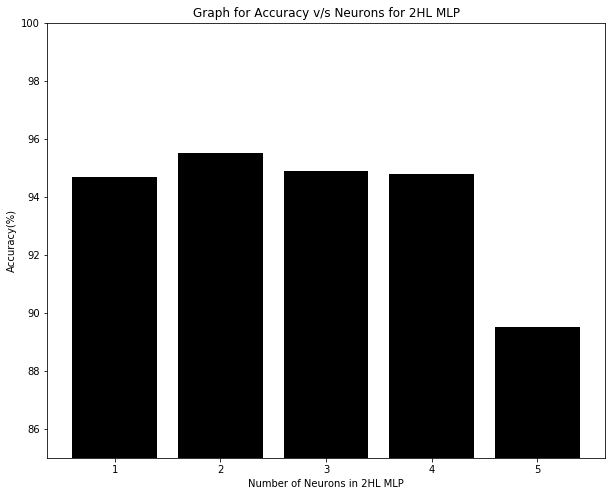

In [55]:
x_name = [100,500,1000,5000,10000]
x = [1,2,3,4,5]
y = [94.7, 95.5, 94.9, 94.8, 89.5]


plt.figure(figsize=(10,8))
plt.bar(x,y, color='k')
bottom = 85
top = 100
plt.ylim((bottom, top)) 
plt.xlabel('Number of Neurons in 2HL MLP')
plt.ylabel('Accuracy(%)')
plt.title('Graph for Accuracy v/s Neurons for 2HL MLP')
plt.show()